In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=2, heads=4).to(device) 
        self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        
        f=u_t - 5 * u * (1-u) #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

        #计算损失，共三项损失\n",
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss = loss_res + loss_bc + loss_ic
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [0]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 10000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500

def hh(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return hh(x) * np.exp(5*t) / ( hh(x) * np.exp(5*t) + 1 - hh(x))

for seed in seeds:
    set_seed(seed) #设置随机数种子
    # --- 1. 参数设置 ---
    nIter = 10000
    nIterLBFGS = 500
    # ... 其他参数 ...

    # --- 2. 初始化 ---
    N_f_1 = N_f // 20
    X_f_train = lb + (ub - lb) * lhs(2, N_f_1)

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f_train, lb, ub)

    # 【新】创建巨大、固定的候选点池
    N_f_candidate = N_f * 2
    X_f_candidate = lb + (ub - lb) * lhs(2, N_f_candidate)
    is_point_selected_mask = np.zeros(N_f_candidate, dtype=bool) #布尔掩码，形状是(N_f_candidate,)，初始值为False，表示所有点都未被选择
    

    # --- 3. 初始训练 ---
    start_time = time.time()
    model.train(nIter // 20, 0)

    # --- 4. 主动学习循环 ---
    # 计算总轮数,这里是19
    num_active_rounds = (nIter - nIter // 20) // (nIter // 20)
    # 每轮训练中记录的检查点数量，其实就是后面的T
    num_checkpoints_per_round = 10
    # 两次检查点之间的训练迭代次数
    epochs_between_checkpoints = (nIter // 20) // num_checkpoints_per_round

    # 用于存储每一轮最终预测的全局历史
    global_final_predictions = []

    for i in range(num_active_rounds):        
        # a. 训练并记录预测历史
        prediction_history = []
        # 记录当前模型在整个候选池上的预测输出
        
        for j in range(num_checkpoints_per_round):
            model.train(epochs_between_checkpoints, 0)
            
            # 记录当前模型在整个候选池上的预测输出
            predictions = model.predict(X_f_candidate) # 返回 (N, 1) 的Numpy数组
            # prediction_history.append(predictions.flatten()) # 存为一维数组，每个元素形状为 (N, ) 
            prediction_history.append(predictions) # 存为二维数组，每个元素形状为 (N, 1)
        local_prediction_history = prediction_history

        # b. 计算不稳定性分数 g(x) = Σ v_t * a_t(x)
        # 将历史记录转为矩阵 (T+1, N_candidates,1)
        local_history_matrix = np.array(local_prediction_history)
        T_local, num_candidates, _ = local_history_matrix.shape #T表示共存储了多少个模型的预测结果，num_candidates表示候选点的数量

        # 获取最终预测u_T(x)
        local_final_prediction = local_history_matrix[-1, :, :] # (N_candidates, 1) 的数组

        # 计算不一致性矩阵 a_t(x) = |u_t(x) - u_T(x)|
        # 利用 NumPy 的广播机制高效计算，具体为(T, N_candidates,1)-(N_candidates,1)（相当于用T个元素分别和最后一个元素相减）,最后得到的形状是(T, N_candidates)
        # disagreement_matrix_A = np.abs(prediction_history_matrix - final_prediction_vec)
        local_disagreement = np.linalg.norm(local_history_matrix - local_final_prediction, ord=2, axis=-1)

        # 计算时间权重向量 v_t = (t/T)^k
        t_local = np.arange(1, T_local + 1) #形状是(T,)的数组
        k_local = 1.0  # 权重指数，可以作为超参数调整
        v_local = (t_local / T_local) ** k_local #形状是(T,)

        # 计算最终不稳定性分数 g(x)
        # g = V^T * A (矩阵乘法概念)
        # 实际操作：将权重向量V变形以进行逐元素乘法，然后在时间轴上求和
        # v_local（也就是V）的形状是(T,)，local_disagreement（也就是A）的形状是(T, N_candidates)
        # V[:, np.newaxis] 将V变为 (T, 1)，可以与A进行广播乘法
        g_micro = np.sum(v_local[:, np.newaxis] * local_disagreement, axis=0) #求和前形状为 (T, N_candidates)，求和后形状为(N_candidates,)

        
        # c. 更新并计算【宏观不稳定性 g_macro】
        # ------------------------------------------------------------------
        # 将本轮的最终预测加入全局历史列表
        global_final_predictions.append(local_final_prediction)
        
        g_macro = np.zeros(num_candidates) # 如果历史太短，宏观不稳定性为0
        
        # 只有当全局历史足够长时（至少有两次最终预测），计算才有意义
        if len(global_final_predictions) > 1:
            global_history_matrix = np.array(global_final_predictions)
            T_global, _, _ = global_history_matrix.shape # T_global 是当前的主动学习轮数 i+1
            
            # 使用全局最新的预测作为基准
            global_final_prediction = global_history_matrix[-1, :, :]
            
            # 计算宏观不一致性
            global_disagreement = np.linalg.norm(global_history_matrix - global_final_prediction, ord=2, axis=-1)
            
            # 【宏观 t, k】
            t_global = np.arange(1, T_global + 1)
            k_macro = 2.0 # 宏观时间尺度上，可以给后期变化更大的惩罚，所以k可以更大
            v_global = (t_global / T_global) ** k_macro
            
            # 计算宏观不稳定性分数
            g_macro = np.sum(v_global[:, np.newaxis] * global_disagreement, axis=0)


        # d. 融合分数
        # ------------------------------------------------------------------
        # 在融合前，对两种分数进行归一化，使其尺度相当，避免其中一个主导
        # 这是一个很好的实践，可以防止数值问题
        if np.std(g_micro) > 1e-6:
            g_micro_norm = (g_micro - np.mean(g_micro)) / np.std(g_micro)
        else:
            g_micro_norm = np.zeros_like(g_micro)

        if np.std(g_macro) > 1e-6:
            g_macro_norm = (g_macro - np.mean(g_macro)) / np.std(g_macro)
        else:
            g_macro_norm = np.zeros_like(g_macro)
            
        # 设置融合权重
        w_micro = 0.5
        w_macro = 0.5
        
        instability_scores_g = w_micro * g_micro_norm + w_macro * g_macro_norm



        batch_size = N_f_candidate // 10 # 设置批处理大小为候选点数量的十分之一，避免显存爆炸
        all_residuals = [] # 创建一个空列表来存储每个批次的残差结果


        # 循环处理每个批次
        for i in range(0, N_f_candidate, batch_size):
            # 获取当前批次的数据
            X_batch = X_f_candidate[i : i + batch_size]
            
            # 对当前批次计算残差
            # model.residual 内部的计算量大大减小，不会爆显存了
            residual_batch = model.residual(X_batch) # 返回 (batch_size, 1) 的 NumPy 数组
            
            # 将当前批次的结果添加到列表中
            all_residuals.append(residual_batch)

        # 将所有批次的结果拼接成一个大的 NumPy 数组
        residual = np.vstack(all_residuals) # vstack 用于垂直堆叠

        # --- 后续处理不变 ---
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        # 将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()



        #进行归一化
        epsilon = 1e-5
        
        norm_residual = np.linalg.norm(abs_residual)
        if norm_residual > epsilon:
            abs_residual = abs_residual / norm_residual
        else:
            abs_residual = np.zeros_like(abs_residual)
        # norm_distances = np.linalg.norm(distances)
        # if norm_distances > epsilon:
        #     distances = distances / norm_distances
        # else:
        #     distances = np.zeros_like(distances)

        norm_instability = np.linalg.norm(instability_scores_g)
        if norm_instability > epsilon:
            instability_scores_g = instability_scores_g / norm_instability
        else:
            instability_scores_g = np.zeros_like(instability_scores_g)

        xinxi = abs_residual + instability_scores_g #将残差和不稳定性分数相加，得到新的分数


        # e. 选择新的点
        # 屏蔽已选中的点，防止重复选择
        xinxi[is_point_selected_mask] = -1.0
        
        # 找出分数最高的 N_f_1 个点的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:]
        
        # 提取新点
        X_f_train_topk = X_f_candidate[topk_indices]
        
        # f. 更新训练集和掩码
        X_f_train = np.vstack((X_f_train, X_f_train_topk))
        is_point_selected_mask[topk_indices] = True


        # e. 更新模型内部的配位点
        X_f = make_time_sequence(X_f_train, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        #配位点数据
        model.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次


    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)

    u_star = u_ana(X_star[:,0], X_star[:,1])
    # .reshape(101,101)\n",


    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE







    

/tmp/ipykernel_3304076/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<01:02,  8.03it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 27.07it/s]

Adam:   2%|▏         | 11/500 [00:00<00:14, 33.60it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 36.77it/s]

Adam:   4%|▍         | 21/500 [00:00<00:12, 38.41it/s]

Adam:   5%|▌         | 25/500 [00:00<00:13, 35.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:12, 37.46it/s]

Adam:   7%|▋         | 34/500 [00:00<00:12, 37.50it/s]

Adam:   8%|▊         | 39/500 [00:01<00:11, 39.12it/s]

Adam:   9%|▊         | 43/500 [00:01<00:11, 38.89it/s]

Adam:   9%|▉         | 47/500 [00:01<00:11, 38.03it/s]

Adam:  10%|█         | 52/500 [00:01<00:11, 39.04it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:11, 39.62it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:10, 40.02it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:10, 41.35it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:10, 41.50it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:10, 39.56it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:10, 38.88it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:10, 38.56it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:10, 40.34it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:09, 40.86it/s]

Adam:  20%|██        | 100/500 [00:02<00:09, 41.49it/s]

Adam:  21%|██        | 105/500 [00:02<00:09, 41.78it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:09, 39.05it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:09, 40.19it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:09, 40.48it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:09, 40.54it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:09, 40.67it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:08, 40.75it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:08, 41.15it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:08, 41.88it/s]

Adam:  30%|███       | 150/500 [00:03<00:08, 41.46it/s]

Adam:  31%|███       | 155/500 [00:03<00:08, 41.33it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:08, 41.16it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:08, 41.16it/s]

Adam:  34%|███▍      | 170/500 [00:04<00:08, 40.98it/s]

Adam:  35%|███▌      | 175/500 [00:04<00:07, 41.19it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:07, 41.35it/s]

Adam:  37%|███▋      | 185/500 [00:04<00:07, 41.50it/s]

Adam:  38%|███▊      | 190/500 [00:04<00:07, 41.63it/s]

Adam:  39%|███▉      | 195/500 [00:04<00:07, 42.56it/s]

Adam:  40%|████      | 200/500 [00:05<00:07, 42.29it/s]

Adam:  41%|████      | 205/500 [00:05<00:07, 42.10it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:06, 41.97it/s]

Adam:  43%|████▎     | 215/500 [00:05<00:06, 41.91it/s]

Adam:  44%|████▍     | 220/500 [00:05<00:06, 41.89it/s]

Adam:  45%|████▌     | 225/500 [00:05<00:06, 41.94it/s]

Adam:  46%|████▌     | 230/500 [00:05<00:06, 41.94it/s]

Adam:  47%|████▋     | 235/500 [00:05<00:06, 41.64it/s]

Adam:  48%|████▊     | 240/500 [00:05<00:06, 41.71it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:06, 40.90it/s]

Adam:  50%|█████     | 250/500 [00:06<00:06, 41.15it/s]

Adam:  51%|█████     | 255/500 [00:06<00:05, 42.06it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:05, 42.56it/s]

Adam:  53%|█████▎    | 265/500 [00:06<00:05, 41.99it/s]

Adam:  54%|█████▍    | 270/500 [00:06<00:05, 41.81it/s]

Adam:  55%|█████▌    | 275/500 [00:06<00:05, 41.59it/s]

Adam:  56%|█████▌    | 280/500 [00:06<00:05, 41.49it/s]

Adam:  57%|█████▋    | 285/500 [00:07<00:05, 41.16it/s]

Adam:  58%|█████▊    | 290/500 [00:07<00:05, 41.19it/s]

Adam:  59%|█████▉    | 295/500 [00:07<00:04, 41.76it/s]

Adam:  60%|██████    | 300/500 [00:07<00:04, 41.85it/s]

Adam:  61%|██████    | 305/500 [00:07<00:04, 40.59it/s]

Adam:  62%|██████▏   | 310/500 [00:07<00:04, 38.86it/s]

Adam:  63%|██████▎   | 315/500 [00:07<00:04, 39.18it/s]

Adam:  64%|██████▍   | 320/500 [00:07<00:04, 40.33it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 40.02it/s]

Adam:  66%|██████▌   | 330/500 [00:08<00:04, 40.38it/s]

Adam:  67%|██████▋   | 335/500 [00:08<00:04, 40.87it/s]

Adam:  68%|██████▊   | 340/500 [00:08<00:03, 41.49it/s]

Adam:  69%|██████▉   | 345/500 [00:08<00:03, 41.71it/s]

Adam:  70%|███████   | 350/500 [00:08<00:03, 40.82it/s]

Adam:  71%|███████   | 355/500 [00:08<00:03, 41.52it/s]

Adam:  72%|███████▏  | 360/500 [00:08<00:03, 40.54it/s]

Adam:  73%|███████▎  | 365/500 [00:09<00:03, 40.52it/s]

Adam:  74%|███████▍  | 370/500 [00:09<00:03, 40.37it/s]

Adam:  75%|███████▌  | 375/500 [00:09<00:03, 40.39it/s]

Adam:  76%|███████▌  | 380/500 [00:09<00:02, 40.40it/s]

Adam:  77%|███████▋  | 385/500 [00:09<00:02, 40.32it/s]

Adam:  78%|███████▊  | 390/500 [00:09<00:02, 38.80it/s]

Adam:  79%|███████▉  | 395/500 [00:09<00:02, 39.24it/s]

Adam:  80%|███████▉  | 399/500 [00:09<00:02, 39.01it/s]

Adam:  81%|████████  | 403/500 [00:10<00:02, 37.87it/s]

Adam:  82%|████████▏ | 408/500 [00:10<00:02, 38.50it/s]

Adam:  83%|████████▎ | 413/500 [00:10<00:02, 39.29it/s]

Adam:  83%|████████▎ | 417/500 [00:10<00:02, 37.55it/s]

Adam:  84%|████████▍ | 421/500 [00:10<00:02, 37.58it/s]

Adam:  85%|████████▌ | 425/500 [00:10<00:01, 38.01it/s]

Adam:  86%|████████▌ | 430/500 [00:10<00:01, 39.59it/s]

Adam:  87%|████████▋ | 434/500 [00:10<00:01, 37.61it/s]

Adam:  88%|████████▊ | 438/500 [00:10<00:01, 37.78it/s]

Adam:  88%|████████▊ | 442/500 [00:11<00:01, 38.23it/s]

Adam:  89%|████████▉ | 446/500 [00:11<00:01, 37.71it/s]

Adam:  90%|█████████ | 451/500 [00:11<00:01, 38.07it/s]

Adam:  91%|█████████ | 456/500 [00:11<00:01, 38.86it/s]

Adam:  92%|█████████▏| 460/500 [00:11<00:01, 39.15it/s]

Adam:  93%|█████████▎| 464/500 [00:11<00:00, 39.25it/s]

Adam:  94%|█████████▎| 468/500 [00:11<00:00, 39.37it/s]

Adam:  95%|█████████▍| 473/500 [00:11<00:00, 39.63it/s]

Adam:  96%|█████████▌| 478/500 [00:11<00:00, 39.80it/s]

Adam:  97%|█████████▋| 483/500 [00:12<00:00, 39.91it/s]

Adam:  97%|█████████▋| 487/500 [00:12<00:00, 39.02it/s]

Adam:  98%|█████████▊| 491/500 [00:12<00:00, 38.97it/s]

Adam:  99%|█████████▉| 495/500 [00:12<00:00, 38.37it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 39.07it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 39.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.06it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.91it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.41it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.38it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.36it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.91it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.20it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.87it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.77it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.43it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.27it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.53it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.99it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.44it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.34it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.47it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.25it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.41it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.52it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.22it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.61it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.59it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.52it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.21it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.03it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.46it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.77it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.90it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.30it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.71it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.14it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.42it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.99it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.18it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.73it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.99it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.50it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.91it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.19it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.40it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.36it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.08it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.97it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.77it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.13it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.37it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.83it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.36it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.48it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.96it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.72it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.54it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.33it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.19it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.88it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.19it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.45it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.62it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.61it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.38it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.80it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.76it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.42it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.89it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.99it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.85it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.66it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.68it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.66it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 35.49it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.83it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.60it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.42it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.17it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.07it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.87it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.68it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.06it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.27it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.10it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.25it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.37it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.49it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.83it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.98it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.33it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.38it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.12it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.91it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.26it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.98it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.70it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.56it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.02it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.12it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.11it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.01it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.93it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.42it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.05it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.74it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.14it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.94it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.31it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.88it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.70it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.92it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.16it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.55it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.25it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.96it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.32it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.56it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.62it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.14it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.32it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.18it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.86it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.89it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.12it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.00it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.56it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.49it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.69it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.32it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.29it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.43it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.57it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.55it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.38it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.57it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.94it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.89it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.79it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.40it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.92it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.61it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.81it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.86it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.84it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.15it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.51it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.32it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.13it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.50it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.67it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.76it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.22it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.98it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.78it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.79it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.76it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.19it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.39it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.63it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.81it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.96it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 29.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.97it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.85it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.85it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.50it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.37it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.40it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.44it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.72it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.94it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.66it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.38it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.50it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.01it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.60it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.98it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.27it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 29.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.95it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.42it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.71it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.16it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.56it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.31it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.37it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.69it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.96it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.46it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.25it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.22it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.15it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.13it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.92it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.38it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.49it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.73it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.77it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.71it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.06it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.41it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.71it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.96it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.30it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.62it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.00it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.31it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.38it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.15it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.70it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.49it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.14it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.07it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.02it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.63it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.53it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.49it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.10it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.60it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.50it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.52it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.65it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.76it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.68it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.13it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.32it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.04it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.90it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.16it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.67it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.64it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 22.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.05it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.73it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.24it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.43it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.55it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.86it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.13it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.77it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.39it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.30it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.36it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.98it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.69it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.64it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.06it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.16it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.32it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.63it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.44it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.63it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.97it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.92it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.81it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.01it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.43it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.00it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.01it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.60it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.07it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.74it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.25it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.86it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.39it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.12it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.99it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 22.11it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.44it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.37it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.82it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.51it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.71it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.52it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.88it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.76it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.35it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.40it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.66it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.16it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.84it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.96it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.07it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.05it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.12it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.01it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.06it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.60it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.57it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.76it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.42it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.60it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.55it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.83it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.80it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.46it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.49it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.79it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.78it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.56it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.87it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.42it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.30it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.25it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.01it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.03it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.08it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.05it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.32it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.14it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.25it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.06it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.78it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.84it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.44it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.53it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.66it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.64it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.58it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.60it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.63it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.06it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.20it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.48it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.53it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.81it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.74it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.70it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.53it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.58it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.44it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.50it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.31it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.18it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.35it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.55it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.72it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.61it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.68it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.49it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.68it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.73it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.76it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.49it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.60it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.61it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.61it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.65it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.68it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.69it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.87it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.79it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.73it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.71it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.52it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.57it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.60it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.18it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.20it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.11it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.23it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.23it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.23it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.86it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.92it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.07it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.14it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.22it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.00it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.10it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.07it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.06it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.23it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.02it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.13it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.10it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.85it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.96it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.82it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.92it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.75it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.30it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.06it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.61it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.66it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.68it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.70it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.73it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.79it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.78it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.59it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.68it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.66it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.71it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.75it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.76it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.84it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.13it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.75it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.79it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.82it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.73it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.65it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.69it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.44it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.48it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.60it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.64it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.72it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.78it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.36it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.99it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.79it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.84it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.75it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.78it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.78it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.73it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.74it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.78it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.81it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.74it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.73it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.71it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.79it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.80it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.69it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.13it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.76it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.73it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.80it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.83it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.84it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.77it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.66it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.74it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.74it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.78it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.80it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.80it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.74it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.30it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.95it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.89it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.85it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.82it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.83it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.82it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.89it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.71it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.78it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.79it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.77it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.82it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.77it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.51it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.75it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.71it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.62it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.43it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.44it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.50it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.67it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.08it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.01it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.14it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.28it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.34it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.39it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.35it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.33it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.31it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.33it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.29it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.07it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.50it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.06it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.23it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.28it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.40it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.05it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.96it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.69it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.82it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.84it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 18.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.66it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.86it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.69it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.73it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.83it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.84it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.81it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.91it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.78it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.87it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.84it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.95it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.87it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.92it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.97it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.68it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.57it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.51it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.51it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.49it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.32it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.24it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.38it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.41it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.51it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.67it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.55it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.31it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.37it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.41it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.48it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.52it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.60it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.01it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.00it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.02it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.98it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.94it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.09it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.05it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.10it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.13it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.12it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.10it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.11it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.13it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.02it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.04it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.10it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.14it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.17it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.09it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.19it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.26it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.05it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.10it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.14it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.20it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.21it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.96it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.99it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.05it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.09it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.14it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.14it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.08it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.20it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.98it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.10it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.14it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.15it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.19it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.16it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.77it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.75it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.77it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.78it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.52it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.58it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.59it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.67it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.70it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.64it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.66it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.67it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.66it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.70it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.64it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.68it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.17it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.20it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.21it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.24it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.18it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.28it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.26it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.21it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.29it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.31it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.28it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.22it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.23it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.23it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.31it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.11it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.20it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.27it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.34it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.24it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.26it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.31it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.34it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.21it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.28it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.28it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.34it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.34it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.20it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.67it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.04it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.90it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.25it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.44it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.90it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.22it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 21.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.03it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.89it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.89it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.50it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.43it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.79it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.43it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.56it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.81it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.03it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.58it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.80it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.88it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.92it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.11it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.33it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.22it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.33it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.36it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.53it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.26it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.78it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.20it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.32it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.96it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.99it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.76it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.50it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.29it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.63it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.66it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 16.84it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.36it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.09it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.88it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.40it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.93it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 16.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.20it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.12it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.62it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.37it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.56it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.85it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.82it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.73it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.76it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.27it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.33it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.85it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.36it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.31it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.33it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.36it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.33it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.12it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.30it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.35it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.33it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.35it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.38it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.38it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.39it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.44it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.06it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.49it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.97it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.25it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.30it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.35it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.34it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.34it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.21it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 16.97it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 16.74it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.64it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 16.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.91it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.20it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.87it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.02it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.81it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.98it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.99it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.69it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.20it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.41it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.90it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.33it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.76it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.51it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<14:48,  1.78s/it]

LBFGS:   0%|          | 2/500 [00:03<14:08,  1.70s/it]

LBFGS:   1%|          | 3/500 [00:05<16:08,  1.95s/it]

LBFGS:   1%|          | 4/500 [00:06<12:26,  1.51s/it]

LBFGS:   1%|          | 5/500 [00:06<08:55,  1.08s/it]

LBFGS:   1%|          | 6/500 [00:07<06:47,  1.21it/s]

LBFGS:   1%|▏         | 7/500 [00:07<05:20,  1.54it/s]

LBFGS:   2%|▏         | 8/500 [00:07<04:23,  1.87it/s]

LBFGS:   2%|▏         | 9/500 [00:08<03:56,  2.08it/s]

LBFGS:   2%|▏         | 10/500 [00:08<03:33,  2.30it/s]

LBFGS:   2%|▏         | 11/500 [00:08<03:16,  2.49it/s]

LBFGS:   2%|▏         | 12/500 [00:09<02:59,  2.72it/s]

LBFGS:   3%|▎         | 13/500 [00:09<02:47,  2.90it/s]

LBFGS:   3%|▎         | 14/500 [00:09<02:40,  3.04it/s]

LBFGS:   3%|▎         | 15/500 [00:09<02:34,  3.15it/s]

LBFGS:   3%|▎         | 16/500 [00:10<02:35,  3.11it/s]

LBFGS:   3%|▎         | 17/500 [00:10<02:35,  3.11it/s]

LBFGS:   4%|▎         | 18/500 [00:10<02:37,  3.07it/s]

LBFGS:   4%|▍         | 19/500 [00:11<02:39,  3.02it/s]

LBFGS:   4%|▍         | 20/500 [00:11<02:38,  3.03it/s]

LBFGS:   4%|▍         | 21/500 [00:11<02:35,  3.07it/s]

LBFGS:   4%|▍         | 22/500 [00:12<02:31,  3.15it/s]

LBFGS:   5%|▍         | 23/500 [00:12<02:29,  3.18it/s]

LBFGS:   5%|▍         | 24/500 [00:12<02:26,  3.26it/s]

LBFGS:   5%|▌         | 25/500 [00:13<02:23,  3.31it/s]

LBFGS:   5%|▌         | 26/500 [00:13<02:26,  3.23it/s]

LBFGS:   5%|▌         | 27/500 [00:13<02:24,  3.28it/s]

LBFGS:   6%|▌         | 28/500 [00:13<02:22,  3.32it/s]

LBFGS:   6%|▌         | 29/500 [00:14<02:20,  3.35it/s]

LBFGS:   6%|▌         | 30/500 [00:14<02:19,  3.38it/s]

LBFGS:   6%|▌         | 31/500 [00:14<02:17,  3.40it/s]

LBFGS:   6%|▋         | 32/500 [00:15<02:21,  3.30it/s]

LBFGS:   7%|▋         | 33/500 [00:15<02:20,  3.33it/s]

LBFGS:   7%|▋         | 34/500 [00:15<02:24,  3.23it/s]

LBFGS:   7%|▋         | 35/500 [00:16<02:26,  3.17it/s]

LBFGS:   7%|▋         | 36/500 [00:16<02:23,  3.24it/s]

LBFGS:   7%|▋         | 37/500 [00:16<02:25,  3.18it/s]

LBFGS:   8%|▊         | 38/500 [00:17<02:21,  3.26it/s]

LBFGS:   8%|▊         | 39/500 [00:17<02:19,  3.31it/s]

LBFGS:   8%|▊         | 40/500 [00:17<02:22,  3.22it/s]

LBFGS:   8%|▊         | 41/500 [00:18<02:24,  3.17it/s]

LBFGS:   8%|▊         | 42/500 [00:18<02:25,  3.14it/s]

LBFGS:   9%|▊         | 43/500 [00:18<02:21,  3.22it/s]

LBFGS:   9%|▉         | 44/500 [00:18<02:29,  3.05it/s]

LBFGS:   9%|▉         | 45/500 [00:19<02:29,  3.05it/s]

LBFGS:   9%|▉         | 46/500 [00:19<02:28,  3.06it/s]

LBFGS:   9%|▉         | 47/500 [00:19<02:29,  3.04it/s]

LBFGS:  10%|▉         | 48/500 [00:20<02:28,  3.04it/s]

LBFGS:  10%|▉         | 49/500 [00:20<02:28,  3.04it/s]

LBFGS:  10%|█         | 50/500 [00:20<02:32,  2.95it/s]

LBFGS:  10%|█         | 51/500 [00:21<02:31,  2.96it/s]

LBFGS:  10%|█         | 52/500 [00:21<02:24,  3.09it/s]

LBFGS:  11%|█         | 53/500 [00:21<02:26,  3.06it/s]

LBFGS:  11%|█         | 54/500 [00:22<02:25,  3.07it/s]

LBFGS:  11%|█         | 55/500 [00:22<02:24,  3.07it/s]

LBFGS:  11%|█         | 56/500 [00:22<02:20,  3.17it/s]

LBFGS:  11%|█▏        | 57/500 [00:23<02:16,  3.24it/s]

LBFGS:  12%|█▏        | 58/500 [00:23<02:15,  3.26it/s]

LBFGS:  12%|█▏        | 59/500 [00:23<02:19,  3.15it/s]

LBFGS:  12%|█▏        | 60/500 [00:24<02:17,  3.21it/s]

LBFGS:  12%|█▏        | 61/500 [00:24<02:20,  3.13it/s]

LBFGS:  12%|█▏        | 62/500 [00:24<02:18,  3.17it/s]

LBFGS:  13%|█▎        | 63/500 [00:25<02:19,  3.13it/s]

LBFGS:  13%|█▎        | 64/500 [00:25<02:20,  3.10it/s]

LBFGS:  13%|█▎        | 65/500 [00:25<02:18,  3.14it/s]

LBFGS:  13%|█▎        | 66/500 [00:26<02:18,  3.13it/s]

LBFGS:  13%|█▎        | 67/500 [00:26<02:19,  3.10it/s]

LBFGS:  14%|█▎        | 68/500 [00:26<02:20,  3.08it/s]

LBFGS:  14%|█▍        | 69/500 [00:27<02:20,  3.07it/s]

LBFGS:  14%|█▍        | 70/500 [00:27<02:21,  3.04it/s]

LBFGS:  14%|█▍        | 71/500 [00:27<02:16,  3.15it/s]

LBFGS:  14%|█▍        | 72/500 [00:27<02:12,  3.23it/s]

LBFGS:  15%|█▍        | 73/500 [00:28<02:10,  3.28it/s]

LBFGS:  15%|█▍        | 74/500 [00:28<02:08,  3.31it/s]

LBFGS:  15%|█▌        | 75/500 [00:28<02:08,  3.30it/s]

LBFGS:  15%|█▌        | 76/500 [00:29<02:07,  3.34it/s]

LBFGS:  15%|█▌        | 77/500 [00:29<02:05,  3.36it/s]

LBFGS:  16%|█▌        | 78/500 [00:29<02:05,  3.37it/s]

LBFGS:  16%|█▌        | 79/500 [00:30<02:03,  3.40it/s]

LBFGS:  16%|█▌        | 80/500 [00:30<02:03,  3.41it/s]

LBFGS:  16%|█▌        | 81/500 [00:30<02:02,  3.42it/s]

LBFGS:  16%|█▋        | 82/500 [00:30<02:01,  3.43it/s]

LBFGS:  17%|█▋        | 83/500 [00:31<02:01,  3.44it/s]

LBFGS:  17%|█▋        | 84/500 [00:31<02:00,  3.44it/s]

LBFGS:  17%|█▋        | 85/500 [00:31<02:00,  3.45it/s]

LBFGS:  17%|█▋        | 86/500 [00:32<02:00,  3.45it/s]

LBFGS:  17%|█▋        | 87/500 [00:32<01:59,  3.45it/s]

LBFGS:  18%|█▊        | 88/500 [00:32<01:59,  3.45it/s]

LBFGS:  18%|█▊        | 89/500 [00:32<01:59,  3.45it/s]

LBFGS:  18%|█▊        | 90/500 [00:33<01:58,  3.46it/s]

LBFGS:  18%|█▊        | 91/500 [00:33<01:58,  3.45it/s]

LBFGS:  18%|█▊        | 92/500 [00:33<02:03,  3.30it/s]

LBFGS:  19%|█▊        | 93/500 [00:34<02:01,  3.34it/s]

LBFGS:  19%|█▉        | 94/500 [00:34<02:00,  3.38it/s]

LBFGS:  19%|█▉        | 95/500 [00:34<01:59,  3.40it/s]

LBFGS:  19%|█▉        | 96/500 [00:35<01:59,  3.39it/s]

LBFGS:  19%|█▉        | 97/500 [00:35<01:59,  3.38it/s]

LBFGS:  20%|█▉        | 98/500 [00:35<01:58,  3.39it/s]

LBFGS:  20%|█▉        | 99/500 [00:35<01:57,  3.40it/s]

LBFGS:  20%|██        | 100/500 [00:36<01:56,  3.42it/s]

LBFGS:  20%|██        | 101/500 [00:36<01:56,  3.43it/s]

LBFGS:  20%|██        | 102/500 [00:36<01:55,  3.43it/s]

LBFGS:  21%|██        | 103/500 [00:37<01:55,  3.42it/s]

LBFGS:  21%|██        | 104/500 [00:37<02:00,  3.30it/s]

LBFGS:  21%|██        | 105/500 [00:37<02:02,  3.22it/s]

LBFGS:  21%|██        | 106/500 [00:38<02:01,  3.25it/s]

LBFGS:  21%|██▏       | 107/500 [00:38<02:02,  3.20it/s]

LBFGS:  22%|██▏       | 108/500 [00:38<01:59,  3.27it/s]

LBFGS:  22%|██▏       | 109/500 [00:38<01:57,  3.31it/s]

LBFGS:  22%|██▏       | 110/500 [00:39<02:01,  3.21it/s]

LBFGS:  22%|██▏       | 111/500 [00:39<01:58,  3.27it/s]

LBFGS:  22%|██▏       | 112/500 [00:39<01:56,  3.32it/s]

LBFGS:  23%|██▎       | 113/500 [00:40<01:59,  3.23it/s]

LBFGS:  23%|██▎       | 114/500 [00:40<02:01,  3.17it/s]

LBFGS:  23%|██▎       | 115/500 [00:40<02:02,  3.15it/s]

LBFGS:  23%|██▎       | 116/500 [00:41<01:58,  3.24it/s]

LBFGS:  23%|██▎       | 117/500 [00:41<02:00,  3.18it/s]

LBFGS:  24%|██▎       | 118/500 [00:41<01:57,  3.26it/s]

LBFGS:  24%|██▍       | 119/500 [00:42<01:55,  3.31it/s]

LBFGS:  24%|██▍       | 120/500 [00:42<01:53,  3.35it/s]

LBFGS:  24%|██▍       | 121/500 [00:42<01:51,  3.39it/s]

LBFGS:  24%|██▍       | 122/500 [00:42<01:51,  3.40it/s]

LBFGS:  25%|██▍       | 123/500 [00:43<01:51,  3.39it/s]

LBFGS:  25%|██▍       | 124/500 [00:43<01:50,  3.40it/s]

LBFGS:  25%|██▌       | 125/500 [00:43<01:53,  3.29it/s]

LBFGS:  25%|██▌       | 126/500 [00:44<01:55,  3.24it/s]

LBFGS:  25%|██▌       | 127/500 [00:44<01:54,  3.26it/s]

LBFGS:  26%|██▌       | 128/500 [00:44<01:56,  3.20it/s]

LBFGS:  26%|██▌       | 129/500 [00:45<01:58,  3.14it/s]

LBFGS:  26%|██▌       | 130/500 [00:45<01:54,  3.23it/s]

LBFGS:  26%|██▌       | 131/500 [00:45<01:55,  3.21it/s]

LBFGS:  26%|██▋       | 132/500 [00:45<01:53,  3.25it/s]

LBFGS:  27%|██▋       | 133/500 [00:46<01:51,  3.30it/s]

LBFGS:  27%|██▋       | 134/500 [00:46<01:49,  3.33it/s]

LBFGS:  27%|██▋       | 135/500 [00:46<01:52,  3.24it/s]

LBFGS:  27%|██▋       | 136/500 [00:47<01:51,  3.26it/s]

LBFGS:  27%|██▋       | 137/500 [00:47<01:53,  3.21it/s]

LBFGS:  28%|██▊       | 138/500 [00:47<01:50,  3.29it/s]

LBFGS:  28%|██▊       | 139/500 [00:48<01:48,  3.33it/s]

LBFGS:  28%|██▊       | 140/500 [00:48<01:46,  3.37it/s]

LBFGS:  28%|██▊       | 141/500 [00:48<01:45,  3.40it/s]

LBFGS:  28%|██▊       | 142/500 [00:49<01:48,  3.29it/s]

LBFGS:  29%|██▊       | 143/500 [00:49<01:47,  3.33it/s]

LBFGS:  29%|██▉       | 144/500 [00:49<01:45,  3.36it/s]

LBFGS:  29%|██▉       | 145/500 [00:49<01:44,  3.39it/s]

LBFGS:  29%|██▉       | 146/500 [00:50<01:47,  3.28it/s]

LBFGS:  29%|██▉       | 147/500 [00:50<01:50,  3.18it/s]

LBFGS:  30%|██▉       | 148/500 [00:50<01:51,  3.16it/s]

LBFGS:  30%|██▉       | 149/500 [00:51<01:48,  3.24it/s]

LBFGS:  30%|███       | 150/500 [00:51<01:46,  3.27it/s]

LBFGS:  30%|███       | 151/500 [00:51<01:48,  3.20it/s]

LBFGS:  30%|███       | 152/500 [00:52<01:46,  3.27it/s]

LBFGS:  31%|███       | 153/500 [00:52<01:44,  3.32it/s]

LBFGS:  31%|███       | 154/500 [00:52<01:43,  3.36it/s]

LBFGS:  31%|███       | 155/500 [00:52<01:42,  3.38it/s]

LBFGS:  31%|███       | 156/500 [00:53<01:41,  3.40it/s]

LBFGS:  31%|███▏      | 157/500 [00:53<01:40,  3.41it/s]

LBFGS:  32%|███▏      | 158/500 [00:53<01:39,  3.42it/s]

LBFGS:  32%|███▏      | 159/500 [00:54<01:39,  3.42it/s]

LBFGS:  32%|███▏      | 160/500 [00:54<01:39,  3.43it/s]

LBFGS:  32%|███▏      | 161/500 [00:54<01:38,  3.43it/s]

LBFGS:  32%|███▏      | 162/500 [00:54<01:38,  3.43it/s]

LBFGS:  33%|███▎      | 163/500 [00:55<01:37,  3.44it/s]

LBFGS:  33%|███▎      | 164/500 [00:55<01:41,  3.31it/s]

LBFGS:  33%|███▎      | 165/500 [00:55<01:43,  3.23it/s]

LBFGS:  33%|███▎      | 166/500 [00:56<01:45,  3.18it/s]

LBFGS:  33%|███▎      | 167/500 [00:56<01:46,  3.13it/s]

LBFGS:  34%|███▎      | 168/500 [00:56<01:43,  3.21it/s]

LBFGS:  34%|███▍      | 169/500 [00:57<01:41,  3.27it/s]

LBFGS:  34%|███▍      | 170/500 [00:57<01:39,  3.32it/s]

LBFGS:  34%|███▍      | 171/500 [00:57<01:38,  3.35it/s]

LBFGS:  34%|███▍      | 172/500 [00:58<01:37,  3.37it/s]

LBFGS:  35%|███▍      | 173/500 [00:58<01:36,  3.39it/s]

LBFGS:  35%|███▍      | 174/500 [00:58<01:35,  3.40it/s]

LBFGS:  35%|███▌      | 175/500 [00:58<01:34,  3.42it/s]

LBFGS:  35%|███▌      | 176/500 [00:59<01:35,  3.41it/s]

LBFGS:  35%|███▌      | 177/500 [00:59<01:34,  3.41it/s]

LBFGS:  36%|███▌      | 178/500 [00:59<01:34,  3.41it/s]

LBFGS:  36%|███▌      | 179/500 [01:00<01:37,  3.29it/s]

LBFGS:  36%|███▌      | 180/500 [01:00<01:39,  3.21it/s]

LBFGS:  36%|███▌      | 181/500 [01:00<01:44,  3.06it/s]

LBFGS:  36%|███▋      | 182/500 [01:01<01:40,  3.18it/s]

LBFGS:  37%|███▋      | 183/500 [01:01<01:37,  3.25it/s]

LBFGS:  37%|███▋      | 184/500 [01:01<01:35,  3.30it/s]

LBFGS:  37%|███▋      | 185/500 [01:01<01:34,  3.34it/s]

LBFGS:  37%|███▋      | 186/500 [01:02<01:32,  3.38it/s]

LBFGS:  37%|███▋      | 187/500 [01:02<01:36,  3.24it/s]

LBFGS:  38%|███▊      | 188/500 [01:02<01:38,  3.18it/s]

LBFGS:  38%|███▊      | 189/500 [01:03<01:39,  3.14it/s]

LBFGS:  38%|███▊      | 190/500 [01:03<01:36,  3.22it/s]

LBFGS:  38%|███▊      | 191/500 [01:03<01:34,  3.27it/s]

LBFGS:  38%|███▊      | 192/500 [01:04<01:32,  3.31it/s]

LBFGS:  39%|███▊      | 193/500 [01:04<01:31,  3.35it/s]

LBFGS:  39%|███▉      | 194/500 [01:04<01:31,  3.36it/s]

LBFGS:  39%|███▉      | 195/500 [01:05<01:31,  3.35it/s]

LBFGS:  39%|███▉      | 196/500 [01:05<01:30,  3.36it/s]

LBFGS:  39%|███▉      | 197/500 [01:05<01:30,  3.37it/s]

LBFGS:  40%|███▉      | 198/500 [01:05<01:29,  3.38it/s]

LBFGS:  40%|███▉      | 199/500 [01:06<01:29,  3.36it/s]

LBFGS:  40%|████      | 200/500 [01:06<01:30,  3.30it/s]

LBFGS:  40%|████      | 201/500 [01:06<01:32,  3.22it/s]

LBFGS:  40%|████      | 202/500 [01:07<01:34,  3.16it/s]

LBFGS:  41%|████      | 203/500 [01:07<01:35,  3.13it/s]

LBFGS:  41%|████      | 204/500 [01:07<01:35,  3.11it/s]

LBFGS:  41%|████      | 205/500 [01:08<01:34,  3.13it/s]

LBFGS:  41%|████      | 206/500 [01:08<01:30,  3.25it/s]

LBFGS:  41%|████▏     | 207/500 [01:08<01:29,  3.28it/s]

LBFGS:  42%|████▏     | 208/500 [01:09<01:27,  3.32it/s]

LBFGS:  42%|████▏     | 209/500 [01:09<01:26,  3.35it/s]

LBFGS:  42%|████▏     | 210/500 [01:09<01:29,  3.25it/s]

LBFGS:  42%|████▏     | 211/500 [01:09<01:30,  3.18it/s]

LBFGS:  42%|████▏     | 212/500 [01:10<01:31,  3.13it/s]

LBFGS:  43%|████▎     | 213/500 [01:10<01:35,  3.00it/s]

LBFGS:  43%|████▎     | 214/500 [01:10<01:31,  3.12it/s]

LBFGS:  43%|████▎     | 215/500 [01:11<01:32,  3.09it/s]

LBFGS:  43%|████▎     | 216/500 [01:11<01:29,  3.17it/s]

LBFGS:  43%|████▎     | 217/500 [01:11<01:31,  3.10it/s]

LBFGS:  44%|████▎     | 218/500 [01:12<01:31,  3.08it/s]

LBFGS:  44%|████▍     | 219/500 [01:12<01:29,  3.15it/s]

LBFGS:  44%|████▍     | 220/500 [01:12<01:26,  3.23it/s]

LBFGS:  44%|████▍     | 221/500 [01:13<01:25,  3.28it/s]

LBFGS:  44%|████▍     | 222/500 [01:13<01:24,  3.29it/s]

LBFGS:  45%|████▍     | 223/500 [01:13<01:24,  3.30it/s]

LBFGS:  45%|████▍     | 224/500 [01:14<01:23,  3.32it/s]

LBFGS:  45%|████▌     | 225/500 [01:14<01:22,  3.32it/s]

LBFGS:  45%|████▌     | 226/500 [01:14<01:21,  3.36it/s]

LBFGS:  45%|████▌     | 227/500 [01:14<01:21,  3.37it/s]

LBFGS:  46%|████▌     | 228/500 [01:15<01:22,  3.28it/s]

LBFGS:  46%|████▌     | 229/500 [01:15<01:22,  3.30it/s]

LBFGS:  46%|████▌     | 230/500 [01:15<01:20,  3.34it/s]

LBFGS:  46%|████▌     | 231/500 [01:16<01:19,  3.37it/s]

LBFGS:  46%|████▋     | 232/500 [01:16<01:19,  3.39it/s]

LBFGS:  47%|████▋     | 233/500 [01:16<01:21,  3.26it/s]

LBFGS:  47%|████▋     | 234/500 [01:17<01:20,  3.31it/s]

LBFGS:  47%|████▋     | 235/500 [01:17<01:23,  3.19it/s]

LBFGS:  47%|████▋     | 236/500 [01:17<01:23,  3.15it/s]

LBFGS:  47%|████▋     | 237/500 [01:18<01:22,  3.20it/s]

LBFGS:  48%|████▊     | 238/500 [01:18<01:20,  3.26it/s]

LBFGS:  48%|████▊     | 239/500 [01:18<01:21,  3.19it/s]

LBFGS:  48%|████▊     | 240/500 [01:18<01:19,  3.27it/s]

LBFGS:  48%|████▊     | 241/500 [01:19<01:18,  3.32it/s]

LBFGS:  48%|████▊     | 242/500 [01:19<01:16,  3.36it/s]

LBFGS:  49%|████▊     | 243/500 [01:19<01:18,  3.26it/s]

LBFGS:  49%|████▉     | 244/500 [01:20<01:16,  3.35it/s]

LBFGS:  49%|████▉     | 245/500 [01:20<01:14,  3.42it/s]

LBFGS:  49%|████▉     | 246/500 [01:20<01:14,  3.41it/s]

LBFGS:  49%|████▉     | 247/500 [01:21<01:16,  3.29it/s]

LBFGS:  50%|████▉     | 248/500 [01:21<01:21,  3.11it/s]

LBFGS:  50%|████▉     | 249/500 [01:21<01:18,  3.18it/s]

LBFGS:  50%|█████     | 250/500 [01:21<01:16,  3.26it/s]

LBFGS:  50%|█████     | 251/500 [01:22<01:15,  3.29it/s]

LBFGS:  50%|█████     | 252/500 [01:22<01:15,  3.30it/s]

LBFGS:  51%|█████     | 253/500 [01:22<01:17,  3.20it/s]

LBFGS:  51%|█████     | 254/500 [01:23<01:14,  3.28it/s]

LBFGS:  51%|█████     | 255/500 [01:23<01:13,  3.33it/s]

LBFGS:  51%|█████     | 256/500 [01:23<01:12,  3.38it/s]

LBFGS:  51%|█████▏    | 257/500 [01:24<01:11,  3.39it/s]

LBFGS:  52%|█████▏    | 258/500 [01:24<01:11,  3.41it/s]

LBFGS:  52%|█████▏    | 259/500 [01:24<01:11,  3.39it/s]

LBFGS:  52%|█████▏    | 260/500 [01:24<01:10,  3.41it/s]

LBFGS:  52%|█████▏    | 261/500 [01:25<01:09,  3.42it/s]

LBFGS:  52%|█████▏    | 262/500 [01:25<01:12,  3.29it/s]

LBFGS:  53%|█████▎    | 263/500 [01:25<01:11,  3.30it/s]

LBFGS:  53%|█████▎    | 264/500 [01:26<01:13,  3.22it/s]

LBFGS:  53%|█████▎    | 265/500 [01:26<01:12,  3.23it/s]

LBFGS:  53%|█████▎    | 266/500 [01:26<01:11,  3.26it/s]

LBFGS:  53%|█████▎    | 267/500 [01:27<01:13,  3.18it/s]

LBFGS:  54%|█████▎    | 268/500 [01:27<01:11,  3.25it/s]

LBFGS:  54%|█████▍    | 269/500 [01:27<01:10,  3.30it/s]

LBFGS:  54%|█████▍    | 270/500 [01:28<01:09,  3.32it/s]

LBFGS:  54%|█████▍    | 271/500 [01:28<01:08,  3.35it/s]

LBFGS:  54%|█████▍    | 272/500 [01:28<01:10,  3.22it/s]

LBFGS:  55%|█████▍    | 273/500 [01:28<01:12,  3.15it/s]

LBFGS:  55%|█████▍    | 274/500 [01:29<01:12,  3.11it/s]

LBFGS:  55%|█████▌    | 275/500 [01:29<01:10,  3.18it/s]

LBFGS:  55%|█████▌    | 276/500 [01:29<01:11,  3.13it/s]

LBFGS:  55%|█████▌    | 277/500 [01:30<01:12,  3.09it/s]

LBFGS:  56%|█████▌    | 278/500 [01:30<01:12,  3.08it/s]

LBFGS:  56%|█████▌    | 279/500 [01:30<01:13,  3.02it/s]

LBFGS:  56%|█████▌    | 280/500 [01:31<01:11,  3.08it/s]

LBFGS:  56%|█████▌    | 281/500 [01:31<01:09,  3.15it/s]

LBFGS:  56%|█████▋    | 282/500 [01:31<01:08,  3.20it/s]

LBFGS:  57%|█████▋    | 283/500 [01:32<01:08,  3.15it/s]

LBFGS:  57%|█████▋    | 284/500 [01:32<01:09,  3.11it/s]

LBFGS:  57%|█████▋    | 285/500 [01:32<01:10,  3.06it/s]

LBFGS:  57%|█████▋    | 286/500 [01:33<01:08,  3.14it/s]

LBFGS:  57%|█████▋    | 287/500 [01:33<01:08,  3.11it/s]

LBFGS:  58%|█████▊    | 288/500 [01:33<01:06,  3.17it/s]

LBFGS:  58%|█████▊    | 289/500 [01:34<01:07,  3.13it/s]

LBFGS:  58%|█████▊    | 290/500 [01:34<01:05,  3.21it/s]

LBFGS:  58%|█████▊    | 291/500 [01:34<01:06,  3.15it/s]

LBFGS:  58%|█████▊    | 292/500 [01:35<01:05,  3.16it/s]

LBFGS:  59%|█████▊    | 293/500 [01:35<01:03,  3.23it/s]

LBFGS:  59%|█████▉    | 294/500 [01:35<01:02,  3.30it/s]

LBFGS:  59%|█████▉    | 295/500 [01:35<01:01,  3.32it/s]

LBFGS:  59%|█████▉    | 296/500 [01:36<01:03,  3.23it/s]

LBFGS:  59%|█████▉    | 297/500 [01:36<01:02,  3.26it/s]

LBFGS:  60%|█████▉    | 298/500 [01:36<01:01,  3.29it/s]

LBFGS:  60%|█████▉    | 299/500 [01:37<01:00,  3.31it/s]

LBFGS:  60%|██████    | 300/500 [01:37<00:59,  3.34it/s]

LBFGS:  60%|██████    | 301/500 [01:37<01:01,  3.25it/s]

LBFGS:  60%|██████    | 302/500 [01:38<01:02,  3.18it/s]

LBFGS:  61%|██████    | 303/500 [01:38<01:03,  3.11it/s]

LBFGS:  61%|██████    | 304/500 [01:38<01:01,  3.19it/s]

LBFGS:  61%|██████    | 305/500 [01:39<01:00,  3.23it/s]

LBFGS:  61%|██████    | 306/500 [01:39<01:00,  3.18it/s]

LBFGS:  61%|██████▏   | 307/500 [01:39<01:01,  3.13it/s]

LBFGS:  62%|██████▏   | 308/500 [01:40<01:02,  3.09it/s]

LBFGS:  62%|██████▏   | 309/500 [01:40<01:00,  3.15it/s]

LBFGS:  62%|██████▏   | 310/500 [01:40<01:01,  3.10it/s]

LBFGS:  62%|██████▏   | 311/500 [01:40<00:58,  3.23it/s]

LBFGS:  62%|██████▏   | 312/500 [01:41<00:59,  3.17it/s]

LBFGS:  63%|██████▎   | 313/500 [01:41<00:59,  3.13it/s]

LBFGS:  63%|██████▎   | 314/500 [01:41<00:56,  3.29it/s]

LBFGS:  63%|██████▎   | 315/500 [01:42<00:55,  3.33it/s]

LBFGS:  63%|██████▎   | 316/500 [01:42<00:57,  3.20it/s]

LBFGS:  63%|██████▎   | 317/500 [01:42<00:56,  3.26it/s]

LBFGS:  64%|██████▎   | 318/500 [01:43<00:57,  3.15it/s]

LBFGS:  64%|██████▍   | 319/500 [01:43<00:56,  3.19it/s]

LBFGS:  64%|██████▍   | 320/500 [01:43<00:57,  3.14it/s]

LBFGS:  64%|██████▍   | 321/500 [01:44<00:55,  3.22it/s]

LBFGS:  64%|██████▍   | 322/500 [01:44<00:54,  3.26it/s]

LBFGS:  65%|██████▍   | 323/500 [01:44<00:55,  3.18it/s]

LBFGS:  65%|██████▍   | 324/500 [01:44<00:54,  3.23it/s]

LBFGS:  65%|██████▌   | 325/500 [01:45<00:53,  3.29it/s]

LBFGS:  65%|██████▌   | 326/500 [01:45<00:56,  3.09it/s]

LBFGS:  65%|██████▌   | 327/500 [01:46<00:58,  2.98it/s]

LBFGS:  66%|██████▌   | 328/500 [01:46<00:55,  3.07it/s]

LBFGS:  66%|██████▌   | 329/500 [01:46<00:55,  3.06it/s]

LBFGS:  66%|██████▌   | 330/500 [01:46<00:53,  3.15it/s]

LBFGS:  66%|██████▌   | 331/500 [01:47<00:54,  3.10it/s]

LBFGS:  66%|██████▋   | 332/500 [01:47<00:52,  3.18it/s]

LBFGS:  67%|██████▋   | 333/500 [01:47<00:53,  3.14it/s]

LBFGS:  67%|██████▋   | 334/500 [01:48<00:51,  3.21it/s]

LBFGS:  67%|██████▋   | 335/500 [01:48<00:50,  3.28it/s]

LBFGS:  67%|██████▋   | 336/500 [01:48<00:50,  3.27it/s]

LBFGS:  67%|██████▋   | 337/500 [01:49<00:49,  3.30it/s]

LBFGS:  68%|██████▊   | 338/500 [01:49<00:50,  3.21it/s]

LBFGS:  68%|██████▊   | 339/500 [01:49<00:49,  3.25it/s]

LBFGS:  68%|██████▊   | 340/500 [01:50<00:48,  3.30it/s]

LBFGS:  68%|██████▊   | 341/500 [01:50<00:48,  3.28it/s]

LBFGS:  68%|██████▊   | 342/500 [01:50<00:46,  3.38it/s]

LBFGS:  69%|██████▊   | 343/500 [01:50<00:42,  3.69it/s]

LBFGS:  69%|██████▉   | 344/500 [01:50<00:38,  4.05it/s]

LBFGS:  69%|██████▉   | 345/500 [01:51<00:34,  4.52it/s]

LBFGS:  69%|██████▉   | 346/500 [01:51<00:32,  4.68it/s]

LBFGS:  69%|██████▉   | 347/500 [01:51<00:31,  4.89it/s]

LBFGS:  70%|██████▉   | 348/500 [01:51<00:28,  5.28it/s]

LBFGS:  70%|██████▉   | 349/500 [01:51<00:27,  5.50it/s]

LBFGS:  70%|███████   | 350/500 [01:52<00:27,  5.39it/s]

LBFGS:  70%|███████   | 351/500 [01:52<00:27,  5.39it/s]

LBFGS:  70%|███████   | 352/500 [01:52<00:25,  5.76it/s]

LBFGS:  71%|███████   | 353/500 [01:52<00:24,  5.97it/s]

LBFGS:  71%|███████   | 354/500 [01:52<00:23,  6.17it/s]

LBFGS:  71%|███████   | 355/500 [01:52<00:23,  6.18it/s]

LBFGS:  71%|███████   | 356/500 [01:52<00:22,  6.43it/s]

LBFGS:  71%|███████▏  | 357/500 [01:53<00:21,  6.51it/s]

LBFGS:  72%|███████▏  | 358/500 [01:53<00:22,  6.22it/s]

LBFGS:  72%|███████▏  | 359/500 [01:53<00:22,  6.40it/s]

LBFGS:  72%|███████▏  | 360/500 [01:53<00:21,  6.42it/s]

LBFGS:  72%|███████▏  | 361/500 [01:53<00:21,  6.45it/s]

LBFGS:  72%|███████▏  | 362/500 [01:53<00:21,  6.41it/s]

LBFGS:  73%|███████▎  | 363/500 [01:54<00:20,  6.54it/s]

LBFGS:  73%|███████▎  | 364/500 [01:54<00:20,  6.62it/s]

LBFGS:  73%|███████▎  | 365/500 [01:54<00:20,  6.66it/s]

LBFGS:  73%|███████▎  | 366/500 [01:54<00:20,  6.59it/s]

LBFGS:  73%|███████▎  | 367/500 [01:54<00:21,  6.11it/s]

LBFGS:  74%|███████▎  | 368/500 [01:54<00:23,  5.69it/s]

LBFGS:  74%|███████▍  | 369/500 [01:55<00:26,  4.87it/s]

LBFGS:  74%|███████▍  | 370/500 [01:55<00:29,  4.43it/s]

LBFGS:  74%|███████▍  | 371/500 [01:55<00:29,  4.38it/s]

LBFGS:  74%|███████▍  | 372/500 [01:55<00:29,  4.35it/s]

LBFGS:  75%|███████▍  | 373/500 [01:56<00:29,  4.37it/s]

LBFGS:  75%|███████▍  | 374/500 [01:56<00:29,  4.31it/s]

LBFGS:  75%|███████▌  | 375/500 [01:56<00:28,  4.37it/s]

LBFGS:  75%|███████▌  | 376/500 [01:56<00:27,  4.50it/s]

LBFGS:  75%|███████▌  | 377/500 [01:57<00:27,  4.50it/s]

LBFGS:  76%|███████▌  | 378/500 [01:57<00:27,  4.37it/s]

LBFGS:  76%|███████▌  | 379/500 [01:57<00:28,  4.21it/s]

LBFGS:  76%|███████▌  | 380/500 [01:57<00:28,  4.17it/s]

LBFGS:  76%|███████▌  | 381/500 [01:58<00:28,  4.18it/s]

LBFGS:  76%|███████▋  | 382/500 [01:58<00:27,  4.24it/s]

LBFGS:  77%|███████▋  | 383/500 [01:58<00:27,  4.23it/s]

LBFGS:  77%|███████▋  | 384/500 [01:58<00:27,  4.29it/s]

LBFGS:  77%|███████▋  | 385/500 [01:58<00:27,  4.21it/s]

LBFGS:  77%|███████▋  | 386/500 [01:59<00:27,  4.18it/s]

LBFGS:  77%|███████▋  | 387/500 [01:59<00:27,  4.11it/s]

LBFGS:  78%|███████▊  | 388/500 [01:59<00:27,  4.15it/s]

LBFGS:  78%|███████▊  | 389/500 [01:59<00:27,  4.05it/s]

LBFGS:  78%|███████▊  | 390/500 [02:00<00:26,  4.08it/s]

LBFGS:  78%|███████▊  | 391/500 [02:00<00:26,  4.06it/s]

LBFGS:  78%|███████▊  | 392/500 [02:00<00:26,  4.10it/s]

LBFGS:  79%|███████▊  | 393/500 [02:00<00:25,  4.19it/s]

LBFGS:  79%|███████▉  | 394/500 [02:01<00:25,  4.22it/s]

LBFGS:  79%|███████▉  | 395/500 [02:01<00:24,  4.22it/s]

LBFGS:  79%|███████▉  | 396/500 [02:01<00:24,  4.32it/s]

LBFGS:  79%|███████▉  | 397/500 [02:01<00:24,  4.28it/s]

LBFGS:  80%|███████▉  | 398/500 [02:02<00:23,  4.27it/s]

LBFGS:  80%|███████▉  | 399/500 [02:02<00:24,  4.18it/s]

LBFGS:  80%|████████  | 400/500 [02:02<00:24,  4.14it/s]

LBFGS:  80%|████████  | 401/500 [02:02<00:24,  4.04it/s]

LBFGS:  80%|████████  | 402/500 [02:03<00:23,  4.14it/s]

LBFGS:  81%|████████  | 403/500 [02:03<00:23,  4.14it/s]

LBFGS:  81%|████████  | 404/500 [02:03<00:22,  4.23it/s]

LBFGS:  81%|████████  | 405/500 [02:03<00:22,  4.24it/s]

LBFGS:  81%|████████  | 406/500 [02:04<00:22,  4.19it/s]

LBFGS:  81%|████████▏ | 407/500 [02:04<00:22,  4.22it/s]

LBFGS:  82%|████████▏ | 408/500 [02:04<00:21,  4.19it/s]

LBFGS:  82%|████████▏ | 409/500 [02:04<00:21,  4.23it/s]

LBFGS:  82%|████████▏ | 410/500 [02:04<00:21,  4.24it/s]

LBFGS:  82%|████████▏ | 411/500 [02:05<00:21,  4.21it/s]

LBFGS:  82%|████████▏ | 412/500 [02:05<00:20,  4.30it/s]

LBFGS:  83%|████████▎ | 413/500 [02:05<00:21,  4.03it/s]

LBFGS:  83%|████████▎ | 414/500 [02:05<00:21,  4.01it/s]

LBFGS:  83%|████████▎ | 415/500 [02:06<00:21,  4.04it/s]

LBFGS:  83%|████████▎ | 416/500 [02:06<00:20,  4.14it/s]

LBFGS:  83%|████████▎ | 417/500 [02:06<00:20,  4.14it/s]

LBFGS:  84%|████████▎ | 418/500 [02:06<00:19,  4.24it/s]

LBFGS:  84%|████████▍ | 419/500 [02:07<00:19,  4.14it/s]

LBFGS:  84%|████████▍ | 420/500 [02:07<00:18,  4.28it/s]

LBFGS:  84%|████████▍ | 421/500 [02:07<00:18,  4.38it/s]

LBFGS:  84%|████████▍ | 422/500 [02:07<00:17,  4.37it/s]

LBFGS:  85%|████████▍ | 423/500 [02:08<00:17,  4.35it/s]

LBFGS:  85%|████████▍ | 424/500 [02:08<00:17,  4.23it/s]

LBFGS:  85%|████████▌ | 425/500 [02:08<00:18,  3.99it/s]

LBFGS:  85%|████████▌ | 426/500 [02:08<00:18,  4.06it/s]

LBFGS:  85%|████████▌ | 427/500 [02:09<00:18,  4.01it/s]

LBFGS:  86%|████████▌ | 428/500 [02:09<00:17,  4.05it/s]

LBFGS:  86%|████████▌ | 429/500 [02:09<00:17,  4.08it/s]

LBFGS:  86%|████████▌ | 430/500 [02:09<00:16,  4.13it/s]

LBFGS:  86%|████████▌ | 431/500 [02:10<00:16,  4.18it/s]

LBFGS:  86%|████████▋ | 432/500 [02:10<00:16,  4.24it/s]

LBFGS:  87%|████████▋ | 433/500 [02:10<00:16,  4.19it/s]

LBFGS:  87%|████████▋ | 434/500 [02:10<00:15,  4.18it/s]

LBFGS:  87%|████████▋ | 435/500 [02:10<00:15,  4.21it/s]

LBFGS:  87%|████████▋ | 436/500 [02:11<00:15,  4.17it/s]

LBFGS:  87%|████████▋ | 437/500 [02:11<00:14,  4.21it/s]

LBFGS:  88%|████████▊ | 438/500 [02:11<00:14,  4.14it/s]

LBFGS:  88%|████████▊ | 439/500 [02:11<00:15,  4.04it/s]

LBFGS:  88%|████████▊ | 440/500 [02:12<00:14,  4.04it/s]

LBFGS:  88%|████████▊ | 441/500 [02:12<00:14,  4.01it/s]

LBFGS:  88%|████████▊ | 442/500 [02:12<00:14,  4.13it/s]

LBFGS:  89%|████████▊ | 443/500 [02:12<00:13,  4.12it/s]

LBFGS:  89%|████████▉ | 444/500 [02:13<00:13,  4.05it/s]

LBFGS:  89%|████████▉ | 445/500 [02:13<00:13,  4.07it/s]

LBFGS:  89%|████████▉ | 446/500 [02:13<00:12,  4.20it/s]

LBFGS:  89%|████████▉ | 447/500 [02:13<00:12,  4.31it/s]

LBFGS:  90%|████████▉ | 448/500 [02:14<00:12,  4.33it/s]

LBFGS:  90%|████████▉ | 449/500 [02:14<00:12,  4.15it/s]

LBFGS:  90%|█████████ | 450/500 [02:14<00:12,  4.11it/s]

LBFGS:  90%|█████████ | 451/500 [02:14<00:11,  4.10it/s]

LBFGS:  90%|█████████ | 452/500 [02:15<00:11,  4.03it/s]

LBFGS:  91%|█████████ | 453/500 [02:15<00:11,  4.16it/s]

LBFGS:  91%|█████████ | 454/500 [02:15<00:11,  4.17it/s]

LBFGS:  91%|█████████ | 455/500 [02:15<00:10,  4.21it/s]

LBFGS:  91%|█████████ | 456/500 [02:16<00:10,  4.01it/s]

LBFGS:  91%|█████████▏| 457/500 [02:16<00:10,  4.03it/s]

LBFGS:  92%|█████████▏| 458/500 [02:16<00:10,  4.06it/s]

LBFGS:  92%|█████████▏| 459/500 [02:16<00:10,  4.07it/s]

LBFGS:  92%|█████████▏| 460/500 [02:17<00:09,  4.11it/s]

LBFGS:  92%|█████████▏| 461/500 [02:17<00:09,  4.12it/s]

LBFGS:  92%|█████████▏| 462/500 [02:17<00:09,  4.12it/s]

LBFGS:  93%|█████████▎| 463/500 [02:17<00:08,  4.21it/s]

LBFGS:  93%|█████████▎| 464/500 [02:17<00:08,  4.18it/s]

LBFGS:  93%|█████████▎| 465/500 [02:18<00:08,  4.20it/s]

LBFGS:  93%|█████████▎| 466/500 [02:18<00:07,  4.30it/s]

LBFGS:  93%|█████████▎| 467/500 [02:18<00:07,  4.26it/s]

LBFGS:  94%|█████████▎| 468/500 [02:18<00:07,  4.14it/s]

LBFGS:  94%|█████████▍| 469/500 [02:19<00:07,  4.14it/s]

LBFGS:  94%|█████████▍| 470/500 [02:19<00:07,  4.19it/s]

LBFGS:  94%|█████████▍| 471/500 [02:19<00:07,  4.13it/s]

LBFGS:  94%|█████████▍| 472/500 [02:19<00:06,  4.17it/s]

LBFGS:  95%|█████████▍| 473/500 [02:20<00:06,  3.98it/s]

LBFGS:  95%|█████████▍| 474/500 [02:20<00:06,  4.00it/s]

LBFGS:  95%|█████████▌| 475/500 [02:20<00:06,  4.05it/s]

LBFGS:  95%|█████████▌| 476/500 [02:20<00:05,  4.14it/s]

LBFGS:  95%|█████████▌| 477/500 [02:21<00:05,  4.15it/s]

LBFGS:  96%|█████████▌| 478/500 [02:21<00:05,  4.20it/s]

LBFGS:  96%|█████████▌| 479/500 [02:21<00:05,  4.17it/s]

LBFGS:  96%|█████████▌| 480/500 [02:21<00:04,  4.15it/s]

LBFGS:  96%|█████████▌| 481/500 [02:22<00:04,  4.24it/s]

LBFGS:  96%|█████████▋| 482/500 [02:22<00:04,  4.16it/s]

LBFGS:  97%|█████████▋| 483/500 [02:22<00:04,  4.06it/s]

LBFGS:  97%|█████████▋| 484/500 [02:22<00:03,  4.13it/s]

LBFGS:  97%|█████████▋| 485/500 [02:23<00:03,  4.19it/s]

LBFGS:  97%|█████████▋| 486/500 [02:23<00:03,  4.15it/s]

LBFGS:  97%|█████████▋| 487/500 [02:23<00:03,  4.05it/s]

LBFGS:  98%|█████████▊| 488/500 [02:23<00:02,  4.13it/s]

LBFGS:  98%|█████████▊| 489/500 [02:24<00:02,  4.08it/s]

LBFGS:  98%|█████████▊| 490/500 [02:24<00:02,  4.13it/s]

LBFGS:  98%|█████████▊| 491/500 [02:24<00:02,  4.11it/s]

LBFGS:  98%|█████████▊| 492/500 [02:24<00:01,  4.19it/s]

LBFGS:  99%|█████████▊| 493/500 [02:24<00:01,  4.23it/s]

LBFGS:  99%|█████████▉| 494/500 [02:25<00:01,  4.21it/s]

LBFGS:  99%|█████████▉| 495/500 [02:25<00:01,  4.27it/s]

LBFGS:  99%|█████████▉| 496/500 [02:25<00:00,  4.07it/s]

LBFGS:  99%|█████████▉| 497/500 [02:25<00:00,  4.09it/s]

LBFGS: 100%|█████████▉| 498/500 [02:26<00:00,  4.18it/s]

LBFGS: 100%|█████████▉| 499/500 [02:26<00:00,  4.15it/s]

LBFGS: 100%|██████████| 500/500 [02:26<00:00,  4.09it/s]

LBFGS: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s]


/tmp/ipykernel_3304076/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training time: 562.6679
当前为第5201次循环，种子为0
Error u : 9.871356e-01
MAE: 5.375430e-01
MSE: 4.437441e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:16, 30.90it/s]

Adam:   2%|▏         | 9/500 [00:00<00:13, 36.46it/s]

Adam:   3%|▎         | 14/500 [00:00<00:12, 39.09it/s]

Adam:   4%|▍         | 19/500 [00:00<00:11, 41.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:11, 40.27it/s]

Adam:   6%|▌         | 29/500 [00:00<00:11, 40.77it/s]

Adam:   7%|▋         | 34/500 [00:00<00:11, 39.45it/s]

Adam:   8%|▊         | 39/500 [00:00<00:11, 40.60it/s]

Adam:   9%|▉         | 44/500 [00:01<00:10, 41.69it/s]

Adam:  10%|▉         | 49/500 [00:01<00:10, 41.77it/s]

Adam:  11%|█         | 54/500 [00:01<00:10, 42.40it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:10, 42.15it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:10, 41.80it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:10, 41.74it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:10, 41.50it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:10, 40.26it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:10, 39.99it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:10, 40.04it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:09, 40.95it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:09, 40.80it/s]

Adam:  21%|██        | 104/500 [00:02<00:09, 41.70it/s]

Adam:  22%|██▏       | 109/500 [00:02<00:09, 41.32it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:09, 40.75it/s]

Adam:  24%|██▍       | 119/500 [00:02<00:09, 40.02it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:09, 38.73it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:09, 38.29it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:09, 38.55it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:09, 39.75it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 39.33it/s]

Adam:  29%|██▉       | 146/500 [00:03<00:08, 40.54it/s]

Adam:  30%|███       | 151/500 [00:03<00:08, 41.87it/s]

Adam:  31%|███       | 156/500 [00:03<00:08, 40.86it/s]

Adam:  32%|███▏      | 161/500 [00:03<00:08, 40.76it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:08, 40.48it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:08, 40.49it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:07, 41.39it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:07, 40.36it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:07, 39.94it/s]

Adam:  38%|███▊      | 191/500 [00:04<00:07, 39.29it/s]

Adam:  39%|███▉      | 195/500 [00:04<00:07, 39.29it/s]

Adam:  40%|███▉      | 199/500 [00:04<00:08, 37.32it/s]

Adam:  41%|████      | 203/500 [00:05<00:07, 38.01it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:07, 38.13it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:07, 37.47it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:07, 38.24it/s]

Adam:  44%|████▍     | 220/500 [00:05<00:07, 38.71it/s]

Adam:  45%|████▌     | 225/500 [00:05<00:06, 39.88it/s]

Adam:  46%|████▌     | 229/500 [00:05<00:06, 39.15it/s]

Adam:  47%|████▋     | 233/500 [00:05<00:06, 39.16it/s]

Adam:  47%|████▋     | 237/500 [00:05<00:06, 37.73it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 37.23it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:06, 37.39it/s]

Adam:  50%|█████     | 250/500 [00:06<00:06, 38.84it/s]

Adam:  51%|█████     | 255/500 [00:06<00:06, 40.28it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:06, 38.97it/s]

Adam:  53%|█████▎    | 264/500 [00:06<00:06, 38.73it/s]

Adam:  54%|█████▍    | 269/500 [00:06<00:05, 39.20it/s]

Adam:  55%|█████▍    | 274/500 [00:06<00:05, 38.54it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 40.06it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:05, 40.60it/s]

Adam:  58%|█████▊    | 289/500 [00:07<00:05, 40.32it/s]

Adam:  59%|█████▉    | 294/500 [00:07<00:05, 40.43it/s]

Adam:  60%|█████▉    | 299/500 [00:07<00:04, 40.73it/s]

Adam:  61%|██████    | 304/500 [00:07<00:05, 39.00it/s]

Adam:  62%|██████▏   | 308/500 [00:07<00:05, 37.65it/s]

Adam:  62%|██████▏   | 312/500 [00:07<00:04, 37.73it/s]

Adam:  63%|██████▎   | 317/500 [00:07<00:04, 38.82it/s]

Adam:  64%|██████▍   | 321/500 [00:08<00:04, 39.03it/s]

Adam:  65%|██████▌   | 326/500 [00:08<00:04, 40.63it/s]

Adam:  66%|██████▌   | 331/500 [00:08<00:04, 40.37it/s]

Adam:  67%|██████▋   | 336/500 [00:08<00:04, 40.28it/s]

Adam:  68%|██████▊   | 341/500 [00:08<00:03, 39.78it/s]

Adam:  69%|██████▉   | 345/500 [00:08<00:03, 39.70it/s]

Adam:  70%|██████▉   | 349/500 [00:08<00:03, 39.78it/s]

Adam:  71%|███████   | 353/500 [00:08<00:03, 39.61it/s]

Adam:  71%|███████▏  | 357/500 [00:08<00:03, 39.61it/s]

Adam:  72%|███████▏  | 362/500 [00:09<00:03, 40.90it/s]

Adam:  73%|███████▎  | 367/500 [00:09<00:03, 41.13it/s]

Adam:  74%|███████▍  | 372/500 [00:09<00:03, 40.36it/s]

Adam:  75%|███████▌  | 377/500 [00:09<00:03, 40.28it/s]

Adam:  76%|███████▋  | 382/500 [00:09<00:02, 40.24it/s]

Adam:  77%|███████▋  | 387/500 [00:09<00:02, 40.12it/s]

Adam:  78%|███████▊  | 392/500 [00:09<00:02, 40.19it/s]

Adam:  79%|███████▉  | 397/500 [00:09<00:02, 40.04it/s]

Adam:  80%|████████  | 402/500 [00:10<00:02, 37.70it/s]

Adam:  81%|████████  | 406/500 [00:10<00:02, 38.07it/s]

Adam:  82%|████████▏ | 410/500 [00:10<00:02, 38.02it/s]

Adam:  83%|████████▎ | 414/500 [00:10<00:02, 36.66it/s]

Adam:  84%|████████▍ | 419/500 [00:10<00:02, 37.84it/s]

Adam:  85%|████████▍ | 423/500 [00:10<00:02, 37.21it/s]

Adam:  85%|████████▌ | 427/500 [00:10<00:01, 36.88it/s]

Adam:  86%|████████▌ | 431/500 [00:10<00:01, 36.77it/s]

Adam:  87%|████████▋ | 435/500 [00:11<00:01, 37.60it/s]

Adam:  88%|████████▊ | 440/500 [00:11<00:01, 38.53it/s]

Adam:  89%|████████▉ | 444/500 [00:11<00:01, 38.28it/s]

Adam:  90%|████████▉ | 448/500 [00:11<00:01, 36.37it/s]

Adam:  90%|█████████ | 452/500 [00:11<00:01, 36.69it/s]

Adam:  91%|█████████ | 456/500 [00:11<00:01, 37.46it/s]

Adam:  92%|█████████▏| 461/500 [00:11<00:01, 38.85it/s]

Adam:  93%|█████████▎| 466/500 [00:11<00:00, 39.61it/s]

Adam:  94%|█████████▍| 471/500 [00:11<00:00, 40.16it/s]

Adam:  95%|█████████▌| 476/500 [00:12<00:00, 39.34it/s]

Adam:  96%|█████████▌| 480/500 [00:12<00:00, 39.30it/s]

Adam:  97%|█████████▋| 484/500 [00:12<00:00, 38.79it/s]

Adam:  98%|█████████▊| 488/500 [00:12<00:00, 37.83it/s]

Adam:  99%|█████████▊| 493/500 [00:12<00:00, 38.62it/s]

Adam:  99%|█████████▉| 497/500 [00:12<00:00, 38.62it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 39.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.62it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.17it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.31it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.38it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.19it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.89it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.99it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.01it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.01it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.01it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.06it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.92it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.08it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.69it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.41it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.07it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.24it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.41it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.50it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.70it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.36it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.09it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.12it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.48it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.66it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.23it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.43it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.11it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.45it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.04it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.49it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.27it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.10it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.83it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.78it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.21it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.04it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.93it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 40.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.43it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.80it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.42it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.42it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.77it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.37it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.22it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.60it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.31it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.54it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.60it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.99it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.59it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.15it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.86it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.42it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.17it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.43it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.14it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.85it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.76it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.63it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 39.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.06it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.47it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.62it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.92it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.26it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.51it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.25it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.68it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.27it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.77it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 39.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 39.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.22it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.17it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.38it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.90it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.91it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.55it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 36.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.81it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.94it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.37it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.05it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.92it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.79it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.08it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.40it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.01it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.68it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.85it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.27it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.12it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.54it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.06it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.95it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.59it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.23it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.11it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.82it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.87it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.22it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.99it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.67it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.63it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.07it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.29it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.48it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.50it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.10it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.97it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.79it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.05it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.89it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.41it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.15it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.45it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.83it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.65it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.03it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.20it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.98it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.62it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.63it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.13it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.18it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.34it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.96it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.58it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.38it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.00it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.61it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.63it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.91it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.58it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.65it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.57it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 32.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.36it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.99it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.92it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.16it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.52it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.16it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.98it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.40it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.26it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.13it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.82it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.89it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.23it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.54it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.11it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.72it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.73it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.59it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.30it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.20it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.46it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.32it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.24it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.15it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.43it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.19it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 22.90it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 21.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.91it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.02it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.06it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.14it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.19it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.91it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.29it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.76it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.63it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.12it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.15it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.42it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.16it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.37it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.47it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.89it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.28it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.98it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.68it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.13it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.77it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.07it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.58it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.16it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.36it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.23it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.97it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.11it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.89it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.78it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.70it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.81it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.20it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.28it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.17it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.38it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.79it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.17it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.07it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.16it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.48it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.17it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.55it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.00it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.83it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.81it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.76it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.61it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.33it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.37it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.52it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.57it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.67it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.70it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.69it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.69it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.67it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.43it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.04it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.29it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.82it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.79it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.70it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.82it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.76it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.97it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.83it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.97it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.79it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.58it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.36it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.75it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.41it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.54it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.84it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.32it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.03it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.26it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.47it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.18it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.13it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.67it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.40it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.40it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.55it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.77it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.89it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.53it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.21it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.04it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.16it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.06it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.98it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.11it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.29it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.49it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.93it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.65it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.24it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.53it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.94it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.67it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.52it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.84it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.07it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.57it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.00it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.85it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.44it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.11it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.36it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.84it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 21.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.84it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.32it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.24it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.98it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.50it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.25it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.60it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.30it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.55it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.08it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.39it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.74it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.43it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.01it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.45it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.20it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.08it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.16it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.18it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.31it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.92it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.97it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.11it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.74it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.20it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.23it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.16it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.81it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.40it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.90it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.75it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.12it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.84it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.07it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.94it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.01it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.36it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.51it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.62it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.69it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.50it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.99it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.03it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.87it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.14it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.57it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.27it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.00it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.79it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.90it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.16it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.57it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.52it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.49it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.79it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.60it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.40it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.25it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.70it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.42it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.94it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.77it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.63it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.58it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.36it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.09it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.51it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.93it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.92it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.82it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.61it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.72it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.48it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.16it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.18it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.76it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.64it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.55it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 20.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.92it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.40it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.09it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.64it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.83it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.91it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.92it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.25it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.51it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.18it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.30it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.70it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.58it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.78it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.84it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.02it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.04it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.85it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.50it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.77it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.43it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.00it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.66it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.62it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.86it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.52it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.91it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.44it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.30it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.18it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.29it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.39it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.97it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.98it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.48it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.82it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.52it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.51it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.68it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.79it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.41it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.68it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.52it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.33it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.42it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.00it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.65it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.20it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.94it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.17it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.15it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.88it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.93it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.59it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.75it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.40it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.99it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.42it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.57it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.62it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.85it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.26it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.29it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.21it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.40it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.63it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.82it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.96it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 19.18it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.05it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.86it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.21it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.25it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.92it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.98it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.57it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.52it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.22it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.19it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.73it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.48it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.28it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.75it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.41it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.85it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.43it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.13it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.22it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.47it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.84it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.17it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.14it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.09it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.08it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.05it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.28it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.21it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.48it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.02it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.30it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.37it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.74it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.33it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.76it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.16it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.30it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.78it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.99it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.80it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.70it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.74it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.58it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.59it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.85it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.96it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.69it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.18it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.03it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.85it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.58it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.46it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.78it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.05it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.63it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.93it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.93it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.17it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.24it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.02it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.04it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.92it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.78it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.48it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.38it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.81it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.00it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.46it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.35it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.49it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.56it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.05it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.14it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.44it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.35it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.27it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.21it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.13it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.12it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.13it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.12it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.13it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.13it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.11it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.12it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.10it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.14it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.49it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.47it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.84it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.48it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.36it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.25it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.20it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.18it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.10it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.14it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.14it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.12it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.13it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.09it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.14it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.12it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.10it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.87it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.39it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.85it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.46it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.19it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.07it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.12it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.22it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.18it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.05it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.02it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.63it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.89it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.55it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.92it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.41it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.58it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.68it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.72it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.53it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.55it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.73it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.41it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.92it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.38it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.08it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.81it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.29it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.47it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.44it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.38it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.29it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.24it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.25it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.55it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.84it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.27it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.26it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.25it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.26it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.01it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.19it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.23it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.13it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.14it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.05it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.19it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.72it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.32it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.09it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.14it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.07it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.63it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.56it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.52it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.82it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.30it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.66it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.44it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.76it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.89it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.98it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.06it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.13it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.17it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.23it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.25it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.41it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.31it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.48it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.87it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.75it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.48it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.06it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.81it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.44it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.68it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.67it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.88it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.70it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.79it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.79it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.54it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.79it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.76it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.01it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.17it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.01it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.49it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 20.23it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.67it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.47it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.76it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.93it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 21.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.54it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.86it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 21.22it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.25it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.61it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.09it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.88it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 22.45it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 22.85it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 23.15it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 22.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.82it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.79it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 22.32it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.02it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 22.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.49it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.65it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.92it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.44it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 23.63it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.29it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 24.11it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.51it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.08it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.41it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 25.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 23.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.01it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 23.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 26.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.21it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 24.96it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 24.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 24.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.28it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.75it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.99it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.73it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.30it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.67it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 24.16it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.02it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.71it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.03it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.10it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.69it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.87it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.33it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.00it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.29it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.92it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.11it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.64it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.83it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.14it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.02it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.51it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.29it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.96it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.94it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.47it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.02it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.70it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.62it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.21it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.32it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 21.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.90it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.51it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.72it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.50it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.98it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 21.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 18.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.00it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.36it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.26it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.77it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 19.55it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.50it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.16it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.92it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.27it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.21it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.44it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.99it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.22it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.63it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.26it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<11:14,  1.35s/it]

LBFGS:   0%|          | 2/500 [00:02<12:36,  1.52s/it]

LBFGS:   1%|          | 3/500 [00:04<13:06,  1.58s/it]

LBFGS:   1%|          | 4/500 [00:06<14:33,  1.76s/it]

LBFGS:   1%|          | 5/500 [00:08<16:01,  1.94s/it]

LBFGS:   1%|          | 6/500 [00:11<17:25,  2.12s/it]

LBFGS:   1%|▏         | 7/500 [00:13<18:03,  2.20s/it]

LBFGS:   2%|▏         | 8/500 [00:16<18:20,  2.24s/it]

LBFGS:   2%|▏         | 9/500 [00:18<18:58,  2.32s/it]

LBFGS:   2%|▏         | 10/500 [00:20<19:02,  2.33s/it]

LBFGS:   2%|▏         | 11/500 [00:23<19:13,  2.36s/it]

LBFGS:   2%|▏         | 12/500 [00:25<19:18,  2.37s/it]

LBFGS:   3%|▎         | 13/500 [00:28<19:32,  2.41s/it]

LBFGS:   3%|▎         | 14/500 [00:30<19:44,  2.44s/it]

LBFGS:   3%|▎         | 15/500 [00:33<19:45,  2.44s/it]

LBFGS:   3%|▎         | 16/500 [00:35<19:40,  2.44s/it]

LBFGS:   3%|▎         | 17/500 [00:38<19:26,  2.42s/it]

LBFGS:   4%|▎         | 18/500 [00:40<19:26,  2.42s/it]

LBFGS:   4%|▍         | 19/500 [00:42<19:17,  2.41s/it]

LBFGS:   4%|▍         | 20/500 [00:45<19:25,  2.43s/it]

LBFGS:   4%|▍         | 21/500 [00:47<19:14,  2.41s/it]

LBFGS:   4%|▍         | 22/500 [00:50<19:06,  2.40s/it]

LBFGS:   5%|▍         | 23/500 [00:52<19:20,  2.43s/it]

LBFGS:   5%|▍         | 24/500 [00:54<18:53,  2.38s/it]

LBFGS:   5%|▌         | 25/500 [00:57<18:46,  2.37s/it]

LBFGS:   5%|▌         | 26/500 [00:59<18:48,  2.38s/it]

LBFGS:   5%|▌         | 27/500 [01:02<18:56,  2.40s/it]

LBFGS:   6%|▌         | 28/500 [01:04<19:17,  2.45s/it]

LBFGS:   6%|▌         | 29/500 [01:06<18:54,  2.41s/it]

LBFGS:   6%|▌         | 30/500 [01:09<18:55,  2.42s/it]

LBFGS:   6%|▌         | 31/500 [01:11<19:04,  2.44s/it]

LBFGS:   6%|▋         | 32/500 [01:14<19:08,  2.45s/it]

LBFGS:   7%|▋         | 33/500 [01:16<18:46,  2.41s/it]

LBFGS:   7%|▋         | 34/500 [01:19<18:41,  2.41s/it]

LBFGS:   7%|▋         | 35/500 [01:21<19:13,  2.48s/it]

LBFGS:   7%|▋         | 36/500 [01:24<19:06,  2.47s/it]

LBFGS:   7%|▋         | 37/500 [01:26<19:16,  2.50s/it]

LBFGS:   8%|▊         | 38/500 [01:29<19:13,  2.50s/it]

LBFGS:   8%|▊         | 39/500 [01:31<19:10,  2.50s/it]

LBFGS:   8%|▊         | 40/500 [01:34<19:03,  2.49s/it]

LBFGS:   8%|▊         | 41/500 [01:36<19:08,  2.50s/it]

LBFGS:   8%|▊         | 42/500 [01:39<19:12,  2.52s/it]

LBFGS:   9%|▊         | 43/500 [01:41<19:18,  2.54s/it]

LBFGS:   9%|▉         | 44/500 [01:44<18:59,  2.50s/it]

LBFGS:   9%|▉         | 45/500 [01:46<18:53,  2.49s/it]

LBFGS:   9%|▉         | 46/500 [01:49<18:54,  2.50s/it]

LBFGS:   9%|▉         | 47/500 [01:51<18:39,  2.47s/it]

LBFGS:  10%|▉         | 48/500 [01:54<18:41,  2.48s/it]

LBFGS:  10%|▉         | 49/500 [01:56<18:44,  2.49s/it]

LBFGS:  10%|█         | 50/500 [01:59<18:28,  2.46s/it]

LBFGS:  10%|█         | 51/500 [02:01<18:09,  2.43s/it]

LBFGS:  10%|█         | 52/500 [02:03<18:08,  2.43s/it]

LBFGS:  11%|█         | 53/500 [02:06<18:11,  2.44s/it]

LBFGS:  11%|█         | 54/500 [02:08<18:12,  2.45s/it]

LBFGS:  11%|█         | 55/500 [02:11<18:40,  2.52s/it]

LBFGS:  11%|█         | 56/500 [02:13<18:12,  2.46s/it]

LBFGS:  11%|█▏        | 57/500 [02:16<18:06,  2.45s/it]

LBFGS:  12%|█▏        | 58/500 [02:18<18:07,  2.46s/it]

LBFGS:  12%|█▏        | 59/500 [02:21<18:22,  2.50s/it]

LBFGS:  12%|█▏        | 60/500 [02:23<18:06,  2.47s/it]

LBFGS:  12%|█▏        | 61/500 [02:26<18:05,  2.47s/it]

LBFGS:  12%|█▏        | 62/500 [02:28<18:02,  2.47s/it]

LBFGS:  13%|█▎        | 63/500 [02:31<18:14,  2.50s/it]

LBFGS:  13%|█▎        | 64/500 [02:33<18:22,  2.53s/it]

LBFGS:  13%|█▎        | 65/500 [02:36<18:13,  2.51s/it]

LBFGS:  13%|█▎        | 66/500 [02:38<18:03,  2.50s/it]

LBFGS:  13%|█▎        | 67/500 [02:41<18:11,  2.52s/it]

LBFGS:  14%|█▎        | 68/500 [02:43<18:13,  2.53s/it]

LBFGS:  14%|█▍        | 69/500 [02:46<18:02,  2.51s/it]

LBFGS:  14%|█▍        | 70/500 [02:48<17:54,  2.50s/it]

LBFGS:  14%|█▍        | 71/500 [02:51<17:58,  2.51s/it]

LBFGS:  14%|█▍        | 72/500 [02:53<17:47,  2.50s/it]

LBFGS:  15%|█▍        | 73/500 [02:56<17:58,  2.52s/it]

LBFGS:  15%|█▍        | 74/500 [02:58<17:57,  2.53s/it]

LBFGS:  15%|█▌        | 75/500 [03:01<17:58,  2.54s/it]

LBFGS:  15%|█▌        | 76/500 [03:03<17:47,  2.52s/it]

LBFGS:  15%|█▌        | 77/500 [03:06<17:24,  2.47s/it]

LBFGS:  16%|█▌        | 78/500 [03:08<17:39,  2.51s/it]

LBFGS:  16%|█▌        | 79/500 [03:11<17:40,  2.52s/it]

LBFGS:  16%|█▌        | 80/500 [03:13<17:36,  2.52s/it]

LBFGS:  16%|█▌        | 81/500 [03:16<17:38,  2.53s/it]

LBFGS:  16%|█▋        | 82/500 [03:18<17:14,  2.48s/it]

LBFGS:  17%|█▋        | 83/500 [03:21<17:07,  2.47s/it]

LBFGS:  17%|█▋        | 84/500 [03:24<17:40,  2.55s/it]

LBFGS:  17%|█▋        | 85/500 [03:26<17:28,  2.53s/it]

LBFGS:  17%|█▋        | 86/500 [03:28<17:19,  2.51s/it]

LBFGS:  17%|█▋        | 87/500 [03:31<17:35,  2.56s/it]

LBFGS:  18%|█▊        | 88/500 [03:34<17:21,  2.53s/it]

LBFGS:  18%|█▊        | 89/500 [03:36<17:29,  2.55s/it]

LBFGS:  18%|█▊        | 90/500 [03:39<17:16,  2.53s/it]

LBFGS:  18%|█▊        | 91/500 [03:41<17:14,  2.53s/it]

LBFGS:  18%|█▊        | 92/500 [03:44<17:00,  2.50s/it]

LBFGS:  19%|█▊        | 93/500 [03:46<16:55,  2.49s/it]

LBFGS:  19%|█▉        | 94/500 [03:49<17:06,  2.53s/it]

LBFGS:  19%|█▉        | 95/500 [03:51<17:21,  2.57s/it]

LBFGS:  19%|█▉        | 96/500 [03:54<16:55,  2.51s/it]

LBFGS:  19%|█▉        | 97/500 [03:56<16:59,  2.53s/it]

LBFGS:  20%|█▉        | 98/500 [03:59<16:39,  2.49s/it]

LBFGS:  20%|█▉        | 99/500 [04:01<16:38,  2.49s/it]

LBFGS:  20%|██        | 100/500 [04:04<16:42,  2.51s/it]

LBFGS:  20%|██        | 101/500 [04:06<16:51,  2.54s/it]

LBFGS:  20%|██        | 102/500 [04:09<17:05,  2.58s/it]

LBFGS:  21%|██        | 103/500 [04:12<17:00,  2.57s/it]

LBFGS:  21%|██        | 104/500 [04:14<15:58,  2.42s/it]

LBFGS:  21%|██        | 105/500 [04:15<12:57,  1.97s/it]

LBFGS:  21%|██        | 106/500 [04:16<10:59,  1.67s/it]

LBFGS:  21%|██▏       | 107/500 [04:17<09:29,  1.45s/it]

LBFGS:  22%|██▏       | 108/500 [04:17<08:18,  1.27s/it]

LBFGS:  22%|██▏       | 109/500 [04:18<07:39,  1.17s/it]

LBFGS:  22%|██▏       | 110/500 [04:20<07:43,  1.19s/it]

LBFGS:  22%|██▏       | 111/500 [04:21<09:02,  1.39s/it]

LBFGS:  22%|██▏       | 112/500 [04:23<10:10,  1.57s/it]

LBFGS:  23%|██▎       | 113/500 [04:25<10:59,  1.70s/it]

LBFGS:  23%|██▎       | 114/500 [04:27<11:15,  1.75s/it]

LBFGS:  23%|██▎       | 115/500 [04:29<11:35,  1.81s/it]

LBFGS:  23%|██▎       | 116/500 [04:31<11:30,  1.80s/it]

LBFGS:  23%|██▎       | 117/500 [04:33<11:44,  1.84s/it]

LBFGS:  24%|██▎       | 118/500 [04:35<11:38,  1.83s/it]

LBFGS:  24%|██▍       | 119/500 [04:37<11:44,  1.85s/it]

LBFGS:  24%|██▍       | 120/500 [04:39<11:57,  1.89s/it]

LBFGS:  24%|██▍       | 121/500 [04:41<12:21,  1.96s/it]

LBFGS:  24%|██▍       | 122/500 [04:43<12:12,  1.94s/it]

LBFGS:  25%|██▍       | 123/500 [04:45<12:15,  1.95s/it]

LBFGS:  25%|██▍       | 124/500 [04:47<12:21,  1.97s/it]

LBFGS:  25%|██▌       | 125/500 [04:49<12:13,  1.96s/it]

LBFGS:  25%|██▌       | 126/500 [04:51<12:30,  2.01s/it]

LBFGS:  25%|██▌       | 127/500 [04:53<12:23,  1.99s/it]

LBFGS:  26%|██▌       | 128/500 [04:55<12:33,  2.03s/it]

LBFGS:  26%|██▌       | 129/500 [04:57<12:25,  2.01s/it]

LBFGS:  26%|██▌       | 130/500 [04:59<12:20,  2.00s/it]

LBFGS:  26%|██▌       | 131/500 [05:01<12:24,  2.02s/it]

LBFGS:  26%|██▋       | 132/500 [05:03<12:24,  2.02s/it]

LBFGS:  27%|██▋       | 133/500 [05:05<12:37,  2.07s/it]

LBFGS:  27%|██▋       | 134/500 [05:07<12:30,  2.05s/it]

LBFGS:  27%|██▋       | 135/500 [05:09<12:31,  2.06s/it]

LBFGS:  27%|██▋       | 136/500 [05:11<12:24,  2.05s/it]

LBFGS:  27%|██▋       | 137/500 [05:13<12:36,  2.08s/it]

LBFGS:  28%|██▊       | 138/500 [05:15<12:32,  2.08s/it]

LBFGS:  28%|██▊       | 139/500 [05:18<12:46,  2.12s/it]

LBFGS:  28%|██▊       | 140/500 [05:20<12:55,  2.15s/it]

LBFGS:  28%|██▊       | 141/500 [05:22<12:53,  2.15s/it]

LBFGS:  28%|██▊       | 142/500 [05:24<12:45,  2.14s/it]

LBFGS:  29%|██▊       | 143/500 [05:26<12:31,  2.11s/it]

LBFGS:  29%|██▉       | 144/500 [05:28<12:42,  2.14s/it]

LBFGS:  29%|██▉       | 145/500 [05:30<12:48,  2.16s/it]

LBFGS:  29%|██▉       | 146/500 [05:33<12:43,  2.16s/it]

LBFGS:  29%|██▉       | 147/500 [05:35<12:42,  2.16s/it]

LBFGS:  30%|██▉       | 148/500 [05:37<12:39,  2.16s/it]

LBFGS:  30%|██▉       | 149/500 [05:39<12:42,  2.17s/it]

LBFGS:  30%|███       | 150/500 [05:41<12:56,  2.22s/it]

LBFGS:  30%|███       | 151/500 [05:44<13:01,  2.24s/it]

LBFGS:  30%|███       | 152/500 [05:46<13:09,  2.27s/it]

LBFGS:  31%|███       | 153/500 [05:49<13:31,  2.34s/it]

LBFGS:  31%|███       | 154/500 [05:51<13:29,  2.34s/it]

LBFGS:  31%|███       | 155/500 [05:53<13:20,  2.32s/it]

LBFGS:  31%|███       | 156/500 [05:55<13:14,  2.31s/it]

LBFGS:  31%|███▏      | 157/500 [05:58<13:13,  2.31s/it]

LBFGS:  32%|███▏      | 158/500 [06:00<13:12,  2.32s/it]

LBFGS:  32%|███▏      | 159/500 [06:02<12:57,  2.28s/it]

LBFGS:  32%|███▏      | 160/500 [06:05<12:57,  2.29s/it]

LBFGS:  32%|███▏      | 161/500 [06:07<13:16,  2.35s/it]

LBFGS:  32%|███▏      | 162/500 [06:09<13:15,  2.35s/it]

LBFGS:  33%|███▎      | 163/500 [06:12<13:27,  2.40s/it]

LBFGS:  33%|███▎      | 164/500 [06:14<13:25,  2.40s/it]

LBFGS:  33%|███▎      | 165/500 [06:17<13:34,  2.43s/it]

LBFGS:  33%|███▎      | 166/500 [06:19<13:26,  2.41s/it]

LBFGS:  33%|███▎      | 167/500 [06:22<13:16,  2.39s/it]

LBFGS:  34%|███▎      | 168/500 [06:24<13:16,  2.40s/it]

LBFGS:  34%|███▍      | 169/500 [06:27<13:44,  2.49s/it]

LBFGS:  34%|███▍      | 170/500 [06:29<13:56,  2.53s/it]

LBFGS:  34%|███▍      | 171/500 [06:32<13:49,  2.52s/it]

LBFGS:  34%|███▍      | 172/500 [06:34<13:52,  2.54s/it]

LBFGS:  35%|███▍      | 173/500 [06:37<14:03,  2.58s/it]

LBFGS:  35%|███▍      | 174/500 [06:40<13:59,  2.58s/it]

LBFGS:  35%|███▌      | 175/500 [06:43<14:31,  2.68s/it]

LBFGS:  35%|███▌      | 176/500 [06:45<14:30,  2.69s/it]

LBFGS:  35%|███▌      | 177/500 [06:48<14:19,  2.66s/it]

LBFGS:  36%|███▌      | 178/500 [06:51<14:17,  2.66s/it]

LBFGS:  36%|███▌      | 179/500 [06:53<14:16,  2.67s/it]

LBFGS:  36%|███▌      | 180/500 [06:56<14:28,  2.71s/it]

LBFGS:  36%|███▌      | 181/500 [06:59<14:53,  2.80s/it]

LBFGS:  36%|███▋      | 182/500 [07:02<14:58,  2.83s/it]

LBFGS:  37%|███▋      | 183/500 [07:05<14:45,  2.79s/it]

LBFGS:  37%|███▋      | 184/500 [07:08<14:50,  2.82s/it]

LBFGS:  37%|███▋      | 185/500 [07:10<14:50,  2.83s/it]

LBFGS:  37%|███▋      | 186/500 [07:13<14:41,  2.81s/it]

LBFGS:  37%|███▋      | 187/500 [07:16<14:35,  2.80s/it]

LBFGS:  38%|███▊      | 188/500 [07:19<14:50,  2.85s/it]

LBFGS:  38%|███▊      | 189/500 [07:22<14:58,  2.89s/it]

LBFGS:  38%|███▊      | 190/500 [07:25<14:56,  2.89s/it]

LBFGS:  38%|███▊      | 191/500 [07:28<14:58,  2.91s/it]

LBFGS:  38%|███▊      | 192/500 [07:31<15:15,  2.97s/it]

LBFGS:  39%|███▊      | 193/500 [07:34<15:38,  3.06s/it]

LBFGS:  39%|███▉      | 194/500 [07:37<15:18,  3.00s/it]

LBFGS:  39%|███▉      | 195/500 [07:40<15:05,  2.97s/it]

LBFGS:  39%|███▉      | 196/500 [07:43<15:02,  2.97s/it]

LBFGS:  39%|███▉      | 197/500 [07:46<15:18,  3.03s/it]

LBFGS:  40%|███▉      | 198/500 [07:49<15:25,  3.07s/it]

LBFGS:  40%|███▉      | 199/500 [07:53<15:48,  3.15s/it]

LBFGS:  40%|████      | 200/500 [07:56<15:50,  3.17s/it]

LBFGS:  40%|████      | 201/500 [07:59<15:50,  3.18s/it]

LBFGS:  40%|████      | 202/500 [08:02<15:02,  3.03s/it]

LBFGS:  41%|████      | 203/500 [08:05<15:24,  3.11s/it]

LBFGS:  41%|████      | 204/500 [08:09<16:05,  3.26s/it]

LBFGS:  41%|████      | 205/500 [08:12<16:21,  3.33s/it]

LBFGS:  41%|████      | 206/500 [08:15<16:30,  3.37s/it]

LBFGS:  41%|████▏     | 207/500 [08:19<16:36,  3.40s/it]

LBFGS:  42%|████▏     | 208/500 [08:22<16:39,  3.42s/it]

LBFGS:  42%|████▏     | 209/500 [08:26<17:08,  3.53s/it]

LBFGS:  42%|████▏     | 210/500 [08:30<17:14,  3.57s/it]

LBFGS:  42%|████▏     | 211/500 [08:33<17:16,  3.59s/it]

LBFGS:  42%|████▏     | 212/500 [08:37<17:10,  3.58s/it]

LBFGS:  43%|████▎     | 213/500 [08:41<17:06,  3.58s/it]

LBFGS:  43%|████▎     | 214/500 [08:43<15:54,  3.34s/it]

LBFGS:  43%|████▎     | 215/500 [08:44<12:04,  2.54s/it]

LBFGS:  43%|████▎     | 216/500 [08:45<09:21,  1.98s/it]

LBFGS:  43%|████▎     | 217/500 [08:45<07:18,  1.55s/it]

LBFGS:  44%|████▎     | 218/500 [08:46<06:00,  1.28s/it]

LBFGS:  44%|████▍     | 219/500 [08:47<05:01,  1.07s/it]

LBFGS:  44%|████▍     | 220/500 [08:47<04:30,  1.04it/s]

LBFGS:  44%|████▍     | 221/500 [08:48<04:03,  1.15it/s]

LBFGS:  44%|████▍     | 222/500 [08:49<03:46,  1.23it/s]

LBFGS:  45%|████▍     | 223/500 [08:49<03:32,  1.30it/s]

LBFGS:  45%|████▍     | 224/500 [08:50<03:22,  1.36it/s]

LBFGS:  45%|████▌     | 225/500 [08:51<03:16,  1.40it/s]

LBFGS:  45%|████▌     | 226/500 [08:51<03:07,  1.47it/s]

LBFGS:  45%|████▌     | 227/500 [08:52<03:04,  1.48it/s]

LBFGS:  46%|████▌     | 228/500 [08:53<03:06,  1.46it/s]

LBFGS:  46%|████▌     | 229/500 [08:53<02:53,  1.56it/s]

LBFGS:  46%|████▌     | 230/500 [08:54<02:56,  1.53it/s]

LBFGS:  46%|████▌     | 231/500 [08:54<02:55,  1.54it/s]

LBFGS:  46%|████▋     | 232/500 [08:55<02:54,  1.54it/s]

LBFGS:  47%|████▋     | 233/500 [08:56<02:56,  1.51it/s]

LBFGS:  47%|████▋     | 234/500 [08:56<02:56,  1.51it/s]

LBFGS:  47%|████▋     | 235/500 [08:57<02:50,  1.56it/s]

LBFGS:  47%|████▋     | 236/500 [08:58<02:48,  1.56it/s]

LBFGS:  47%|████▋     | 237/500 [08:58<02:50,  1.54it/s]

LBFGS:  48%|████▊     | 238/500 [08:59<02:50,  1.54it/s]

LBFGS:  48%|████▊     | 239/500 [09:00<02:49,  1.54it/s]

LBFGS:  48%|████▊     | 240/500 [09:00<02:55,  1.48it/s]

LBFGS:  48%|████▊     | 241/500 [09:01<02:46,  1.56it/s]

LBFGS:  48%|████▊     | 242/500 [09:02<02:46,  1.55it/s]

LBFGS:  49%|████▊     | 243/500 [09:02<02:47,  1.54it/s]

LBFGS:  49%|████▉     | 244/500 [09:03<02:47,  1.53it/s]

LBFGS:  49%|████▉     | 245/500 [09:04<02:45,  1.54it/s]

LBFGS:  49%|████▉     | 246/500 [09:04<02:45,  1.54it/s]

LBFGS:  49%|████▉     | 247/500 [09:05<02:45,  1.53it/s]

LBFGS:  50%|████▉     | 248/500 [09:06<02:47,  1.50it/s]

LBFGS:  50%|████▉     | 249/500 [09:06<02:45,  1.52it/s]

LBFGS:  50%|█████     | 250/500 [09:07<02:45,  1.51it/s]

LBFGS:  50%|█████     | 251/500 [09:08<02:45,  1.50it/s]

LBFGS:  50%|█████     | 252/500 [09:08<02:46,  1.49it/s]

LBFGS:  51%|█████     | 253/500 [09:09<02:44,  1.50it/s]

LBFGS:  51%|█████     | 254/500 [09:09<02:39,  1.54it/s]

LBFGS:  51%|█████     | 255/500 [09:10<02:39,  1.54it/s]

LBFGS:  51%|█████     | 256/500 [09:11<02:40,  1.52it/s]

LBFGS:  51%|█████▏    | 257/500 [09:12<02:44,  1.48it/s]

LBFGS:  52%|█████▏    | 258/500 [09:12<02:44,  1.47it/s]

LBFGS:  52%|█████▏    | 259/500 [09:13<02:40,  1.50it/s]

LBFGS:  52%|█████▏    | 260/500 [09:14<02:41,  1.48it/s]

LBFGS:  52%|█████▏    | 261/500 [09:14<02:39,  1.50it/s]

LBFGS:  52%|█████▏    | 262/500 [09:15<02:42,  1.46it/s]

LBFGS:  53%|█████▎    | 263/500 [09:16<02:42,  1.46it/s]

LBFGS:  53%|█████▎    | 264/500 [09:16<02:41,  1.46it/s]

LBFGS:  53%|█████▎    | 265/500 [09:17<02:35,  1.51it/s]

LBFGS:  53%|█████▎    | 266/500 [09:18<02:35,  1.51it/s]

LBFGS:  53%|█████▎    | 267/500 [09:18<02:30,  1.55it/s]

LBFGS:  54%|█████▎    | 268/500 [09:19<02:33,  1.51it/s]

LBFGS:  54%|█████▍    | 269/500 [09:20<02:33,  1.51it/s]

LBFGS:  54%|█████▍    | 270/500 [09:20<02:27,  1.55it/s]

LBFGS:  54%|█████▍    | 271/500 [09:21<02:26,  1.57it/s]

LBFGS:  54%|█████▍    | 272/500 [09:21<02:20,  1.62it/s]

LBFGS:  55%|█████▍    | 273/500 [09:22<02:28,  1.53it/s]

LBFGS:  55%|█████▍    | 274/500 [09:23<02:30,  1.50it/s]

LBFGS:  55%|█████▌    | 275/500 [09:23<02:30,  1.50it/s]

LBFGS:  55%|█████▌    | 276/500 [09:24<02:24,  1.55it/s]

LBFGS:  55%|█████▌    | 277/500 [09:25<02:24,  1.54it/s]

LBFGS:  56%|█████▌    | 278/500 [09:25<02:22,  1.56it/s]

LBFGS:  56%|█████▌    | 279/500 [09:26<02:23,  1.54it/s]

LBFGS:  56%|█████▌    | 280/500 [09:27<02:23,  1.53it/s]

LBFGS:  56%|█████▌    | 281/500 [09:27<02:25,  1.51it/s]

LBFGS:  56%|█████▋    | 282/500 [09:28<02:26,  1.49it/s]

LBFGS:  57%|█████▋    | 283/500 [09:29<02:22,  1.52it/s]

LBFGS:  57%|█████▋    | 284/500 [09:29<02:22,  1.52it/s]

LBFGS:  57%|█████▋    | 285/500 [09:30<02:25,  1.48it/s]

LBFGS:  57%|█████▋    | 286/500 [09:31<02:21,  1.51it/s]

LBFGS:  57%|█████▋    | 287/500 [09:31<02:17,  1.55it/s]

LBFGS:  58%|█████▊    | 288/500 [09:32<02:18,  1.53it/s]

LBFGS:  58%|█████▊    | 289/500 [09:33<02:20,  1.50it/s]

LBFGS:  58%|█████▊    | 290/500 [09:33<02:18,  1.52it/s]

LBFGS:  58%|█████▊    | 291/500 [09:34<02:19,  1.50it/s]

LBFGS:  58%|█████▊    | 292/500 [09:35<02:13,  1.56it/s]

LBFGS:  59%|█████▊    | 293/500 [09:35<02:15,  1.53it/s]

LBFGS:  59%|█████▉    | 294/500 [09:36<02:09,  1.59it/s]

LBFGS:  59%|█████▉    | 295/500 [09:36<02:08,  1.59it/s]

LBFGS:  59%|█████▉    | 296/500 [09:37<02:10,  1.57it/s]

LBFGS:  59%|█████▉    | 297/500 [09:38<02:12,  1.53it/s]

LBFGS:  60%|█████▉    | 298/500 [09:38<02:10,  1.55it/s]

LBFGS:  60%|█████▉    | 299/500 [09:39<02:11,  1.53it/s]

LBFGS:  60%|██████    | 300/500 [09:40<02:12,  1.51it/s]

LBFGS:  60%|██████    | 301/500 [09:40<02:12,  1.50it/s]

LBFGS:  60%|██████    | 302/500 [09:41<02:11,  1.50it/s]

LBFGS:  61%|██████    | 303/500 [09:42<02:08,  1.54it/s]

LBFGS:  61%|██████    | 304/500 [09:42<02:04,  1.57it/s]

LBFGS:  61%|██████    | 305/500 [09:43<02:04,  1.56it/s]

LBFGS:  61%|██████    | 306/500 [09:44<02:05,  1.54it/s]

LBFGS:  61%|██████▏   | 307/500 [09:44<02:07,  1.51it/s]

LBFGS:  62%|██████▏   | 308/500 [09:45<02:06,  1.51it/s]

LBFGS:  62%|██████▏   | 309/500 [09:46<02:05,  1.52it/s]

LBFGS:  62%|██████▏   | 310/500 [09:46<02:06,  1.50it/s]

LBFGS:  62%|██████▏   | 311/500 [09:47<02:04,  1.52it/s]

LBFGS:  62%|██████▏   | 312/500 [09:48<01:59,  1.58it/s]

LBFGS:  63%|██████▎   | 313/500 [09:48<01:51,  1.68it/s]

LBFGS:  63%|██████▎   | 314/500 [09:49<01:45,  1.77it/s]

LBFGS:  63%|██████▎   | 315/500 [09:49<01:41,  1.82it/s]

LBFGS:  63%|██████▎   | 316/500 [09:50<01:38,  1.87it/s]

LBFGS:  63%|██████▎   | 317/500 [09:50<01:36,  1.89it/s]

LBFGS:  64%|██████▎   | 318/500 [09:51<01:34,  1.93it/s]

LBFGS:  64%|██████▍   | 319/500 [09:51<01:31,  1.97it/s]

LBFGS:  64%|██████▍   | 320/500 [09:52<01:30,  1.99it/s]

LBFGS:  64%|██████▍   | 321/500 [09:52<01:30,  1.98it/s]

LBFGS:  64%|██████▍   | 322/500 [09:53<01:29,  2.00it/s]

LBFGS:  65%|██████▍   | 323/500 [09:53<01:31,  1.94it/s]

LBFGS:  65%|██████▍   | 324/500 [09:54<01:29,  1.97it/s]

LBFGS:  65%|██████▌   | 325/500 [09:54<01:30,  1.94it/s]

LBFGS:  65%|██████▌   | 326/500 [09:55<01:26,  2.01it/s]

LBFGS:  65%|██████▌   | 327/500 [09:55<01:27,  1.99it/s]

LBFGS:  66%|██████▌   | 328/500 [09:56<01:26,  1.98it/s]

LBFGS:  66%|██████▌   | 329/500 [09:56<01:27,  1.96it/s]

LBFGS:  66%|██████▌   | 330/500 [09:57<01:24,  2.02it/s]

LBFGS:  66%|██████▌   | 331/500 [09:57<01:24,  2.00it/s]

LBFGS:  66%|██████▋   | 332/500 [09:58<01:24,  1.98it/s]

LBFGS:  67%|██████▋   | 333/500 [09:58<01:23,  1.99it/s]

LBFGS:  67%|██████▋   | 334/500 [09:59<01:24,  1.97it/s]

LBFGS:  67%|██████▋   | 335/500 [09:59<01:24,  1.96it/s]

LBFGS:  67%|██████▋   | 336/500 [10:00<01:24,  1.95it/s]

LBFGS:  67%|██████▋   | 337/500 [10:00<01:22,  1.98it/s]

LBFGS:  68%|██████▊   | 338/500 [10:01<01:22,  1.97it/s]

LBFGS:  68%|██████▊   | 339/500 [10:01<01:22,  1.95it/s]

LBFGS:  68%|██████▊   | 340/500 [10:02<01:23,  1.91it/s]

LBFGS:  68%|██████▊   | 341/500 [10:02<01:23,  1.91it/s]

LBFGS:  68%|██████▊   | 342/500 [10:03<01:20,  1.95it/s]

LBFGS:  69%|██████▊   | 343/500 [10:03<01:20,  1.95it/s]

LBFGS:  69%|██████▉   | 344/500 [10:04<01:20,  1.94it/s]

LBFGS:  69%|██████▉   | 345/500 [10:04<01:20,  1.94it/s]

LBFGS:  69%|██████▉   | 346/500 [10:05<01:18,  1.97it/s]

LBFGS:  69%|██████▉   | 347/500 [10:05<01:18,  1.96it/s]

LBFGS:  70%|██████▉   | 348/500 [10:06<01:18,  1.94it/s]

LBFGS:  70%|██████▉   | 349/500 [10:06<01:19,  1.91it/s]

LBFGS:  70%|███████   | 350/500 [10:07<01:18,  1.90it/s]

LBFGS:  70%|███████   | 351/500 [10:07<01:16,  1.94it/s]

LBFGS:  70%|███████   | 352/500 [10:08<01:17,  1.90it/s]

LBFGS:  71%|███████   | 353/500 [10:08<01:16,  1.92it/s]

LBFGS:  71%|███████   | 354/500 [10:09<01:14,  1.96it/s]

LBFGS:  71%|███████   | 355/500 [10:09<01:14,  1.94it/s]

LBFGS:  71%|███████   | 356/500 [10:10<01:13,  1.97it/s]

LBFGS:  71%|███████▏  | 357/500 [10:10<01:12,  1.96it/s]

LBFGS:  72%|███████▏  | 358/500 [10:11<01:11,  1.98it/s]

LBFGS:  72%|███████▏  | 359/500 [10:11<01:11,  1.97it/s]

LBFGS:  72%|███████▏  | 360/500 [10:12<01:10,  1.98it/s]

LBFGS:  72%|███████▏  | 361/500 [10:12<01:09,  1.99it/s]

LBFGS:  72%|███████▏  | 362/500 [10:13<01:08,  2.01it/s]

LBFGS:  73%|███████▎  | 363/500 [10:13<01:08,  1.99it/s]

LBFGS:  73%|███████▎  | 364/500 [10:14<01:07,  2.01it/s]

LBFGS:  73%|███████▎  | 365/500 [10:14<01:07,  1.99it/s]

LBFGS:  73%|███████▎  | 366/500 [10:15<01:08,  1.97it/s]

LBFGS:  73%|███████▎  | 367/500 [10:15<01:08,  1.95it/s]

LBFGS:  74%|███████▎  | 368/500 [10:16<01:08,  1.92it/s]

LBFGS:  74%|███████▍  | 369/500 [10:16<01:06,  1.98it/s]

LBFGS:  74%|███████▍  | 370/500 [10:17<01:04,  2.01it/s]

LBFGS:  74%|███████▍  | 371/500 [10:17<01:05,  1.97it/s]

LBFGS:  74%|███████▍  | 372/500 [10:18<01:05,  1.96it/s]

LBFGS:  75%|███████▍  | 373/500 [10:19<01:05,  1.94it/s]

LBFGS:  75%|███████▍  | 374/500 [10:19<01:04,  1.94it/s]

LBFGS:  75%|███████▌  | 375/500 [10:20<01:03,  1.97it/s]

LBFGS:  75%|███████▌  | 376/500 [10:20<01:02,  1.98it/s]

LBFGS:  75%|███████▌  | 377/500 [10:21<01:02,  1.98it/s]

LBFGS:  76%|███████▌  | 378/500 [10:21<01:02,  1.96it/s]

LBFGS:  76%|███████▌  | 379/500 [10:22<00:59,  2.03it/s]

LBFGS:  76%|███████▌  | 380/500 [10:22<00:57,  2.09it/s]

LBFGS:  76%|███████▌  | 381/500 [10:22<00:57,  2.06it/s]

LBFGS:  76%|███████▋  | 382/500 [10:23<00:57,  2.06it/s]

LBFGS:  77%|███████▋  | 383/500 [10:23<00:56,  2.06it/s]

LBFGS:  77%|███████▋  | 384/500 [10:24<00:57,  2.03it/s]

LBFGS:  77%|███████▋  | 385/500 [10:24<00:56,  2.03it/s]

LBFGS:  77%|███████▋  | 386/500 [10:25<00:56,  2.01it/s]

LBFGS:  77%|███████▋  | 387/500 [10:25<00:56,  2.01it/s]

LBFGS:  78%|███████▊  | 388/500 [10:26<00:55,  2.01it/s]

LBFGS:  78%|███████▊  | 389/500 [10:26<00:54,  2.02it/s]

LBFGS:  78%|███████▊  | 390/500 [10:27<00:56,  1.96it/s]

LBFGS:  78%|███████▊  | 391/500 [10:27<00:53,  2.03it/s]

LBFGS:  78%|███████▊  | 392/500 [10:28<00:53,  2.00it/s]

LBFGS:  79%|███████▊  | 393/500 [10:28<00:54,  1.98it/s]

LBFGS:  79%|███████▉  | 394/500 [10:29<00:55,  1.92it/s]

LBFGS:  79%|███████▉  | 395/500 [10:30<00:54,  1.93it/s]

LBFGS:  79%|███████▉  | 396/500 [10:30<00:53,  1.95it/s]

LBFGS:  79%|███████▉  | 397/500 [10:31<00:51,  1.99it/s]

LBFGS:  80%|███████▉  | 398/500 [10:31<00:50,  2.00it/s]

LBFGS:  80%|███████▉  | 399/500 [10:32<00:50,  1.98it/s]

LBFGS:  80%|████████  | 400/500 [10:32<00:50,  2.00it/s]

LBFGS:  80%|████████  | 401/500 [10:33<00:49,  1.98it/s]

LBFGS:  80%|████████  | 402/500 [10:33<00:50,  1.95it/s]

LBFGS:  81%|████████  | 403/500 [10:34<00:49,  1.95it/s]

LBFGS:  81%|████████  | 404/500 [10:34<00:48,  1.99it/s]

LBFGS:  81%|████████  | 405/500 [10:35<00:48,  1.97it/s]

LBFGS:  81%|████████  | 406/500 [10:35<00:47,  2.00it/s]

LBFGS:  81%|████████▏ | 407/500 [10:36<00:47,  1.97it/s]

LBFGS:  82%|████████▏ | 408/500 [10:36<00:46,  1.99it/s]

LBFGS:  82%|████████▏ | 409/500 [10:37<00:46,  1.97it/s]

LBFGS:  82%|████████▏ | 410/500 [10:37<00:45,  1.99it/s]

LBFGS:  82%|████████▏ | 411/500 [10:38<00:44,  1.98it/s]

LBFGS:  82%|████████▏ | 412/500 [10:38<00:43,  2.00it/s]

LBFGS:  83%|████████▎ | 413/500 [10:39<00:44,  1.98it/s]

LBFGS:  83%|████████▎ | 414/500 [10:39<00:42,  2.00it/s]

LBFGS:  83%|████████▎ | 415/500 [10:40<00:44,  1.92it/s]

LBFGS:  83%|████████▎ | 416/500 [10:40<00:43,  1.95it/s]

LBFGS:  83%|████████▎ | 417/500 [10:41<00:42,  1.93it/s]

LBFGS:  84%|████████▎ | 418/500 [10:41<00:42,  1.93it/s]

LBFGS:  84%|████████▍ | 419/500 [10:42<00:41,  1.97it/s]

LBFGS:  84%|████████▍ | 420/500 [10:42<00:40,  1.96it/s]

LBFGS:  84%|████████▍ | 421/500 [10:43<00:39,  1.99it/s]

LBFGS:  84%|████████▍ | 422/500 [10:43<00:39,  1.97it/s]

LBFGS:  85%|████████▍ | 423/500 [10:44<00:38,  1.99it/s]

LBFGS:  85%|████████▍ | 424/500 [10:44<00:38,  1.98it/s]

LBFGS:  85%|████████▌ | 425/500 [10:45<00:37,  2.00it/s]

LBFGS:  85%|████████▌ | 426/500 [10:45<00:37,  1.98it/s]

LBFGS:  85%|████████▌ | 427/500 [10:46<00:36,  2.01it/s]

LBFGS:  86%|████████▌ | 428/500 [10:46<00:36,  2.00it/s]

LBFGS:  86%|████████▌ | 429/500 [10:47<00:35,  2.01it/s]

LBFGS:  86%|████████▌ | 430/500 [10:47<00:35,  1.96it/s]

LBFGS:  86%|████████▌ | 431/500 [10:48<00:34,  2.01it/s]

LBFGS:  86%|████████▋ | 432/500 [10:48<00:34,  1.95it/s]

LBFGS:  87%|████████▋ | 433/500 [10:49<00:34,  1.94it/s]

LBFGS:  87%|████████▋ | 434/500 [10:49<00:33,  1.97it/s]

LBFGS:  87%|████████▋ | 435/500 [10:50<00:33,  1.97it/s]

LBFGS:  87%|████████▋ | 436/500 [10:50<00:32,  1.99it/s]

LBFGS:  87%|████████▋ | 437/500 [10:51<00:31,  1.98it/s]

LBFGS:  88%|████████▊ | 438/500 [10:51<00:31,  1.96it/s]

LBFGS:  88%|████████▊ | 439/500 [10:52<00:31,  1.96it/s]

LBFGS:  88%|████████▊ | 440/500 [10:52<00:30,  1.99it/s]

LBFGS:  88%|████████▊ | 441/500 [10:53<00:29,  2.02it/s]

LBFGS:  88%|████████▊ | 442/500 [10:53<00:29,  1.98it/s]

LBFGS:  89%|████████▊ | 443/500 [10:54<00:29,  1.93it/s]

LBFGS:  89%|████████▉ | 444/500 [10:54<00:27,  2.00it/s]

LBFGS:  89%|████████▉ | 445/500 [10:55<00:27,  2.02it/s]

LBFGS:  89%|████████▉ | 446/500 [10:55<00:26,  2.03it/s]

LBFGS:  89%|████████▉ | 447/500 [10:56<00:26,  1.99it/s]

LBFGS:  90%|████████▉ | 448/500 [10:56<00:25,  2.01it/s]

LBFGS:  90%|████████▉ | 449/500 [10:57<00:25,  1.99it/s]

LBFGS:  90%|█████████ | 450/500 [10:57<00:25,  1.98it/s]

LBFGS:  90%|█████████ | 451/500 [10:58<00:24,  1.99it/s]

LBFGS:  90%|█████████ | 452/500 [10:58<00:24,  1.96it/s]

LBFGS:  91%|█████████ | 453/500 [10:59<00:23,  1.96it/s]

LBFGS:  91%|█████████ | 454/500 [10:59<00:23,  1.98it/s]

LBFGS:  91%|█████████ | 455/500 [11:00<00:22,  2.01it/s]

LBFGS:  91%|█████████ | 456/500 [11:00<00:21,  2.02it/s]

LBFGS:  91%|█████████▏| 457/500 [11:01<00:21,  2.00it/s]

LBFGS:  92%|█████████▏| 458/500 [11:01<00:20,  2.01it/s]

LBFGS:  92%|█████████▏| 459/500 [11:02<00:20,  1.98it/s]

LBFGS:  92%|█████████▏| 460/500 [11:02<00:19,  2.01it/s]

LBFGS:  92%|█████████▏| 461/500 [11:03<00:19,  1.98it/s]

LBFGS:  92%|█████████▏| 462/500 [11:03<00:18,  2.00it/s]

LBFGS:  93%|█████████▎| 463/500 [11:04<00:18,  1.98it/s]

LBFGS:  93%|█████████▎| 464/500 [11:04<00:18,  1.96it/s]

LBFGS:  93%|█████████▎| 465/500 [11:05<00:17,  1.99it/s]

LBFGS:  93%|█████████▎| 466/500 [11:05<00:17,  1.97it/s]

LBFGS:  93%|█████████▎| 467/500 [11:06<00:16,  2.03it/s]

LBFGS:  94%|█████████▎| 468/500 [11:06<00:16,  2.00it/s]

LBFGS:  94%|█████████▍| 469/500 [11:07<00:15,  2.01it/s]

LBFGS:  94%|█████████▍| 470/500 [11:07<00:15,  1.98it/s]

LBFGS:  94%|█████████▍| 471/500 [11:08<00:14,  1.99it/s]

LBFGS:  94%|█████████▍| 472/500 [11:08<00:14,  1.96it/s]

LBFGS:  95%|█████████▍| 473/500 [11:09<00:13,  1.96it/s]

LBFGS:  95%|█████████▍| 474/500 [11:09<00:13,  1.97it/s]

LBFGS:  95%|█████████▌| 475/500 [11:10<00:12,  1.94it/s]

LBFGS:  95%|█████████▌| 476/500 [11:10<00:12,  1.97it/s]

LBFGS:  95%|█████████▌| 477/500 [11:11<00:11,  1.96it/s]

LBFGS:  96%|█████████▌| 478/500 [11:11<00:11,  1.99it/s]

LBFGS:  96%|█████████▌| 479/500 [11:12<00:10,  1.98it/s]

LBFGS:  96%|█████████▌| 480/500 [11:12<00:10,  1.96it/s]

LBFGS:  96%|█████████▌| 481/500 [11:13<00:09,  1.98it/s]

LBFGS:  96%|█████████▋| 482/500 [11:13<00:09,  2.00it/s]

LBFGS:  97%|█████████▋| 483/500 [11:14<00:08,  1.94it/s]

LBFGS:  97%|█████████▋| 484/500 [11:14<00:08,  1.94it/s]

LBFGS:  97%|█████████▋| 485/500 [11:15<00:07,  1.97it/s]

LBFGS:  97%|█████████▋| 486/500 [11:15<00:07,  1.99it/s]

LBFGS:  97%|█████████▋| 487/500 [11:16<00:06,  2.01it/s]

LBFGS:  98%|█████████▊| 488/500 [11:16<00:05,  2.03it/s]

LBFGS:  98%|█████████▊| 489/500 [11:17<00:05,  1.96it/s]

LBFGS:  98%|█████████▊| 490/500 [11:17<00:05,  1.98it/s]

LBFGS:  98%|█████████▊| 491/500 [11:18<00:04,  2.01it/s]

LBFGS:  98%|█████████▊| 492/500 [11:18<00:03,  2.01it/s]

LBFGS:  99%|█████████▊| 493/500 [11:19<00:03,  1.99it/s]

LBFGS:  99%|█████████▉| 494/500 [11:19<00:02,  2.00it/s]

LBFGS:  99%|█████████▉| 495/500 [11:20<00:02,  2.02it/s]

LBFGS:  99%|█████████▉| 496/500 [11:20<00:01,  2.03it/s]

LBFGS:  99%|█████████▉| 497/500 [11:21<00:01,  2.00it/s]

LBFGS: 100%|█████████▉| 498/500 [11:21<00:00,  2.01it/s]

LBFGS: 100%|█████████▉| 499/500 [11:22<00:00,  1.99it/s]

LBFGS: 100%|██████████| 500/500 [11:22<00:00,  1.99it/s]

LBFGS: 100%|██████████| 500/500 [11:22<00:00,  1.37s/it]

Training time: 1082.7319
当前为第5201次循环，种子为1
Error u : 9.672935e-01
MAE: 5.192124e-01
MSE: 4.260842e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 34.33it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.22it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.34it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 34.34it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 34.23it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 34.69it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 34.36it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 32.65it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 32.91it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 33.63it/s]

Adam:  10%|▉         | 48/500 [00:01<00:13, 33.50it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 32.46it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 33.02it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:13, 31.73it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:13, 31.17it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:14, 29.50it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:13, 30.82it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:13, 31.73it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:13, 31.53it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:13, 31.51it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 32.75it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 32.91it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:12, 33.43it/s]

Adam:  20%|██        | 100/500 [00:03<00:11, 34.62it/s]

Adam:  21%|██        | 104/500 [00:03<00:11, 34.46it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 33.54it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 33.45it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 32.83it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:12, 31.57it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 32.45it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 31.89it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:11, 30.90it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:11, 30.53it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:11, 31.45it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 32.67it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 33.06it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 33.31it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 33.55it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 32.07it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:10, 31.59it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 32.54it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:09, 33.38it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:09, 33.39it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 32.16it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 33.22it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 32.24it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 32.88it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:09, 32.79it/s]

Adam:  40%|████      | 200/500 [00:06<00:08, 33.47it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 33.49it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 34.40it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 33.96it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 33.79it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 34.85it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 35.62it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 35.14it/s]

Adam:  46%|████▋     | 232/500 [00:07<00:07, 35.34it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:07, 34.92it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:07, 35.11it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 34.92it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 34.67it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 34.52it/s]

Adam:  51%|█████     | 256/500 [00:07<00:07, 33.92it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 34.42it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:07, 32.56it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 31.86it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:06, 32.60it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 33.08it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.76it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 33.71it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 34.28it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:06, 33.89it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:06, 33.86it/s]

Adam:  60%|██████    | 300/500 [00:09<00:05, 34.09it/s]

Adam:  61%|██████    | 304/500 [00:09<00:05, 34.77it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:05, 35.46it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 33.86it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 33.74it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 34.22it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 34.22it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:05, 34.07it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:05, 32.65it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 33.54it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 34.22it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 34.72it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 33.67it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 34.04it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 34.23it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:03, 35.39it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 34.25it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:03, 33.27it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 33.82it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 33.89it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 34.52it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 34.43it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 34.77it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 33.98it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:03, 32.07it/s]

Adam:  80%|████████  | 400/500 [00:12<00:03, 31.81it/s]

Adam:  81%|████████  | 404/500 [00:12<00:02, 32.46it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:02, 33.20it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 33.43it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 33.05it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 33.29it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 34.01it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 34.55it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:01, 34.43it/s]

Adam:  87%|████████▋ | 436/500 [00:13<00:01, 34.77it/s]

Adam:  88%|████████▊ | 440/500 [00:13<00:01, 34.96it/s]

Adam:  89%|████████▉ | 444/500 [00:13<00:01, 34.67it/s]

Adam:  90%|████████▉ | 448/500 [00:13<00:01, 35.03it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 34.75it/s]

Adam:  91%|█████████ | 456/500 [00:13<00:01, 35.01it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 34.95it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 34.65it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 33.92it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:00, 34.86it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:00, 35.06it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 34.73it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 34.54it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 34.98it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 34.40it/s]

Adam:  99%|█████████▉| 496/500 [00:14<00:00, 34.70it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.56it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.32it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.68it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.45it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.14it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.92it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.33it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.42it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.42it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.01it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.86it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.57it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.17it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.88it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.67it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.91it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.65it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.50it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.11it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.96it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.61it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.31it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.52it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.04it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.95it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.32it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.38it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.06it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.05it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.98it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.49it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.78it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.87it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.27it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.90it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.14it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.69it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.83it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.14it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.05it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.14it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.00it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 45.26it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 47.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 47.80it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 47.08it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.44it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 47.84it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 45.87it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 46.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.39it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.53it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.05it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.38it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 45.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 46.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 47.31it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 47.63it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.71it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 47.85it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 47.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 48.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.11it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.07it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.07it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.16it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.34it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 49.73it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 50.12it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 49.55it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.55it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.99it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.38it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.18it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.59it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.84it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.94it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.77it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.81it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.84it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.56it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.19it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.96it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.51it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.48it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.83it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.39it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.82it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.29it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.10it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.58it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.14it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.63it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.87it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.36it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.93it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.17it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.74it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.75it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.24it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.18it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.95it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.03it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.42it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.17it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.63it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 38.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.08it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.37it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.40it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.84it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.21it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.21it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.63it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.93it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.62it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.85it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.38it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.37it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.94it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.65it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.03it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.21it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.72it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.70it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.92it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.56it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.91it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.18it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.67it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.66it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.47it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.91it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.64it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.17it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.64it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.70it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.26it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.52it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.29it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.13it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.60it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.06it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.44it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.53it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.78it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.98it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.52it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.25it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.04it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.50it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.03it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.75it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.50it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.43it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.93it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.66it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.32it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.40it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.47it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.71it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.46it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.33it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.33it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.98it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.90it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.06it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.82it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.84it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.92it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.73it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.18it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.69it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.19it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.04it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.94it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.51it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.66it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.90it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.62it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.04it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.13it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.71it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.22it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.62it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.20it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.26it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.28it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.00it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.04it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.12it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.70it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.16it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.92it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.18it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.77it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.61it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.79it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.53it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.86it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.22it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.89it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.34it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.63it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.73it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.28it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.27it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.74it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.28it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.16it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.33it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.93it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.16it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.70it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.22it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.12it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.46it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.68it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.42it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.89it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.54it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.82it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.63it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.01it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.60it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.96it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.05it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.81it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.11it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.88it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.49it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.71it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.89it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.37it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.10it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.03it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.08it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.10it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.45it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.22it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.01it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.49it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.58it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.20it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.51it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.84it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.88it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.83it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.90it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.03it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.24it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 22.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.59it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.45it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.34it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.46it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.61it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.10it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.46it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.43it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.69it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.14it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.46it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.07it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.37it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.66it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.32it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.11it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.20it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.93it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.93it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.16it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.59it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.35it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.32it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.47it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.41it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.02it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.50it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.49it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.41it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.41it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.18it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.77it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.08it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.43it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.40it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.50it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.75it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.08it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.04it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.91it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.91it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.94it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.57it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.40it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.51it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.79it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.02it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.37it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.23it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.28it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.24it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.65it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.17it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.24it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.28it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.89it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.27it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.72it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.13it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.18it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.26it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.19it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.34it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.35it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.31it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.61it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  8.28it/s]

Adam:   6%|▌         | 3/50 [00:00<00:03, 14.17it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 16.36it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.83it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.13it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.27it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.78it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.44it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.66it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.31it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.79it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.19it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.43it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.63it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.81it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.75it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.81it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.99it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.91it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.00it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.38it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.78it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.64it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.23it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 19.97it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.23it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.29it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.72it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.08it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.16it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.62it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.56it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.54it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.31it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.75it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.31it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.80it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.14it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.28it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.27it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.25it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.39it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.39it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.58it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.52it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.76it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.79it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.49it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.17it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.43it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.82it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.50it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.47it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.46it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.47it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.05it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.43it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.43it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.75it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.63it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.13it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.40it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.40it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.59it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.73it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.80it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.87it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.93it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.89it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.57it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.36it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.65it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.52it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.80it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.58it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.26it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.53it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.59it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.05it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.38it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.03it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.54it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.50it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.85it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.82it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.76it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.66it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.20it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.38it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.42it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.43it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.49it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.51it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.47it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.78it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.01it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.38it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.43it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.44it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.45it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.43it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.44it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.42it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.51it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.80it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.89it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.08it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.21it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.26it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.27it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.55it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.73it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.42it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.96it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.24it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.48it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.35it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.41it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.40it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.44it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 19.45it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.41it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.49it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.31it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.61it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.85it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.71it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.53it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.53it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.67it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.92it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.11it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.20it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.25it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.21it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.11it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.66it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.76it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.70it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.92it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.39it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.50it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.51it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.48it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.38it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.25it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.72it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.90it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.34it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.10it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.22it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.38it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.48it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.36it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.43it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.42it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.07it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.35it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.55it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.46it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.31it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.37it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.46it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.46it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.31it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.46it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.51it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.68it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.63it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.52it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.53it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.53it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.49it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.56it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.33it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.24it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.33it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.43it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.46it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.45it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.45it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.46it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.50it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.35it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.43it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.96it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.15it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.23it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.91it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.92it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.97it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.02it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.03it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.76it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.83it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.21it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.43it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.60it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.63it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.66it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.65it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.65it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.64it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.67it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.01it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.40it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.55it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.87it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.60it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.59it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.48it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.83it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.07it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.24it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.60it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.58it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.63it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.65it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.63it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.66it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.66it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.37it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.60it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.01it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.58it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.61it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.15it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<15:48,  1.90s/it]

LBFGS:   0%|          | 2/500 [00:03<16:44,  2.02s/it]

LBFGS:   1%|          | 3/500 [00:06<18:15,  2.20s/it]

LBFGS:   1%|          | 4/500 [00:09<20:32,  2.49s/it]

LBFGS:   1%|          | 5/500 [00:12<23:06,  2.80s/it]

LBFGS:   1%|          | 6/500 [00:16<26:21,  3.20s/it]

LBFGS:   1%|▏         | 7/500 [00:20<27:16,  3.32s/it]

LBFGS:   2%|▏         | 8/500 [00:23<28:09,  3.43s/it]

LBFGS:   2%|▏         | 9/500 [00:27<28:55,  3.54s/it]

LBFGS:   2%|▏         | 10/500 [00:31<29:10,  3.57s/it]

LBFGS:   2%|▏         | 11/500 [00:34<29:11,  3.58s/it]

LBFGS:   2%|▏         | 12/500 [00:38<29:51,  3.67s/it]

LBFGS:   3%|▎         | 13/500 [00:42<30:58,  3.82s/it]

LBFGS:   3%|▎         | 14/500 [00:46<31:13,  3.86s/it]

LBFGS:   3%|▎         | 15/500 [00:50<30:57,  3.83s/it]

LBFGS:   3%|▎         | 16/500 [00:54<30:56,  3.84s/it]

LBFGS:   3%|▎         | 17/500 [00:58<31:17,  3.89s/it]

LBFGS:   4%|▎         | 18/500 [01:02<31:16,  3.89s/it]

LBFGS:   4%|▍         | 19/500 [01:05<28:50,  3.60s/it]

LBFGS:   4%|▍         | 20/500 [01:09<29:43,  3.72s/it]

LBFGS:   4%|▍         | 21/500 [01:13<30:46,  3.85s/it]

LBFGS:   4%|▍         | 22/500 [01:17<31:38,  3.97s/it]

LBFGS:   5%|▍         | 23/500 [01:21<31:54,  4.01s/it]

LBFGS:   5%|▍         | 24/500 [01:25<31:51,  4.02s/it]

LBFGS:   5%|▌         | 25/500 [01:29<31:34,  3.99s/it]

LBFGS:   5%|▌         | 26/500 [01:34<32:04,  4.06s/it]

LBFGS:   5%|▌         | 27/500 [01:38<32:18,  4.10s/it]

LBFGS:   6%|▌         | 28/500 [01:42<32:29,  4.13s/it]

LBFGS:   6%|▌         | 29/500 [01:46<32:24,  4.13s/it]

LBFGS:   6%|▌         | 30/500 [01:50<32:02,  4.09s/it]

LBFGS:   6%|▌         | 31/500 [01:54<31:00,  3.97s/it]

LBFGS:   6%|▋         | 32/500 [01:57<30:19,  3.89s/it]

LBFGS:   7%|▋         | 33/500 [02:01<29:37,  3.81s/it]

LBFGS:   7%|▋         | 34/500 [02:05<29:03,  3.74s/it]

LBFGS:   7%|▋         | 35/500 [02:09<29:38,  3.82s/it]

LBFGS:   7%|▋         | 36/500 [02:13<30:00,  3.88s/it]

LBFGS:   7%|▋         | 37/500 [02:17<30:33,  3.96s/it]

LBFGS:   8%|▊         | 38/500 [02:21<30:19,  3.94s/it]

LBFGS:   8%|▊         | 39/500 [02:24<29:39,  3.86s/it]

LBFGS:   8%|▊         | 40/500 [02:28<29:09,  3.80s/it]

LBFGS:   8%|▊         | 41/500 [02:32<29:12,  3.82s/it]

LBFGS:   8%|▊         | 42/500 [02:36<30:09,  3.95s/it]

LBFGS:   9%|▊         | 43/500 [02:40<29:29,  3.87s/it]

LBFGS:   9%|▉         | 44/500 [02:44<30:15,  3.98s/it]

LBFGS:   9%|▉         | 45/500 [02:48<29:34,  3.90s/it]

LBFGS:   9%|▉         | 46/500 [02:52<29:34,  3.91s/it]

LBFGS:   9%|▉         | 47/500 [02:56<29:37,  3.92s/it]

LBFGS:  10%|▉         | 48/500 [03:00<29:45,  3.95s/it]

LBFGS:  10%|▉         | 49/500 [03:03<29:15,  3.89s/it]

LBFGS:  10%|█         | 50/500 [03:07<28:56,  3.86s/it]

LBFGS:  10%|█         | 51/500 [03:11<29:29,  3.94s/it]

LBFGS:  10%|█         | 52/500 [03:15<29:03,  3.89s/it]

LBFGS:  11%|█         | 53/500 [03:19<29:06,  3.91s/it]

LBFGS:  11%|█         | 54/500 [03:22<26:45,  3.60s/it]

LBFGS:  11%|█         | 55/500 [03:25<24:54,  3.36s/it]

LBFGS:  11%|█         | 56/500 [03:28<24:45,  3.34s/it]

LBFGS:  11%|█▏        | 57/500 [03:31<24:40,  3.34s/it]

LBFGS:  12%|█▏        | 58/500 [03:36<26:40,  3.62s/it]

LBFGS:  12%|█▏        | 59/500 [03:40<27:21,  3.72s/it]

LBFGS:  12%|█▏        | 60/500 [03:44<27:37,  3.77s/it]

LBFGS:  12%|█▏        | 61/500 [03:47<27:52,  3.81s/it]

LBFGS:  12%|█▏        | 62/500 [03:51<28:00,  3.84s/it]

LBFGS:  13%|█▎        | 63/500 [03:55<28:21,  3.89s/it]

LBFGS:  13%|█▎        | 64/500 [03:59<26:42,  3.68s/it]

LBFGS:  13%|█▎        | 65/500 [04:03<27:38,  3.81s/it]

LBFGS:  13%|█▎        | 66/500 [04:07<28:08,  3.89s/it]

LBFGS:  13%|█▎        | 67/500 [04:11<27:52,  3.86s/it]

LBFGS:  14%|█▎        | 68/500 [04:14<27:20,  3.80s/it]

LBFGS:  14%|█▍        | 69/500 [04:18<27:48,  3.87s/it]

LBFGS:  14%|█▍        | 70/500 [04:22<28:17,  3.95s/it]

LBFGS:  14%|█▍        | 71/500 [04:25<26:14,  3.67s/it]

LBFGS:  14%|█▍        | 72/500 [04:29<26:58,  3.78s/it]

LBFGS:  15%|█▍        | 73/500 [04:33<27:00,  3.80s/it]

LBFGS:  15%|█▍        | 74/500 [04:37<26:05,  3.67s/it]

LBFGS:  15%|█▌        | 75/500 [04:43<31:05,  4.39s/it]

LBFGS:  15%|█▌        | 76/500 [04:55<48:26,  6.86s/it]

LBFGS:  15%|█▌        | 77/500 [05:01<45:37,  6.47s/it]

LBFGS:  16%|█▌        | 78/500 [05:17<1:05:20,  9.29s/it]

LBFGS:  16%|█▌        | 79/500 [05:33<1:19:32, 11.34s/it]

LBFGS:  16%|█▌        | 80/500 [05:47<1:25:09, 12.17s/it]

LBFGS:  16%|█▌        | 81/500 [06:02<1:30:34, 12.97s/it]

LBFGS:  16%|█▋        | 82/500 [06:17<1:35:17, 13.68s/it]

LBFGS:  17%|█▋        | 83/500 [06:32<1:37:14, 13.99s/it]

LBFGS:  17%|█▋        | 84/500 [06:40<1:24:58, 12.26s/it]

LBFGS:  17%|█▋        | 85/500 [06:55<1:30:03, 13.02s/it]

LBFGS:  17%|█▋        | 86/500 [07:10<1:33:18, 13.52s/it]

LBFGS:  17%|█▋        | 87/500 [07:24<1:35:27, 13.87s/it]

LBFGS:  18%|█▊        | 88/500 [07:39<1:37:45, 14.24s/it]

LBFGS:  18%|█▊        | 89/500 [07:54<1:38:37, 14.40s/it]

LBFGS:  18%|█▊        | 90/500 [08:10<1:42:00, 14.93s/it]

LBFGS:  18%|█▊        | 91/500 [08:25<1:40:54, 14.80s/it]

LBFGS:  18%|█▊        | 92/500 [08:34<1:29:19, 13.14s/it]

LBFGS:  19%|█▊        | 93/500 [08:46<1:26:11, 12.71s/it]

LBFGS:  19%|█▉        | 94/500 [08:54<1:17:05, 11.39s/it]

LBFGS:  19%|█▉        | 95/500 [09:01<1:07:42, 10.03s/it]

LBFGS:  19%|█▉        | 96/500 [09:18<1:21:17, 12.07s/it]

LBFGS:  19%|█▉        | 97/500 [09:35<1:30:44, 13.51s/it]

LBFGS:  20%|█▉        | 98/500 [09:50<1:34:38, 14.13s/it]

LBFGS:  20%|█▉        | 99/500 [10:05<1:35:17, 14.26s/it]

LBFGS:  20%|██        | 100/500 [10:19<1:35:57, 14.39s/it]

LBFGS:  20%|██        | 101/500 [10:24<1:15:06, 11.29s/it]

LBFGS:  20%|██        | 102/500 [10:27<1:00:08,  9.07s/it]

LBFGS:  21%|██        | 103/500 [10:29<45:05,  6.81s/it]  

LBFGS:  21%|██        | 104/500 [10:44<1:02:11,  9.42s/it]

LBFGS:  21%|██        | 105/500 [10:59<1:12:38, 11.03s/it]

LBFGS:  21%|██        | 106/500 [11:14<1:19:53, 12.17s/it]

LBFGS:  21%|██▏       | 107/500 [11:29<1:25:03, 12.99s/it]

LBFGS:  22%|██▏       | 108/500 [11:44<1:27:56, 13.46s/it]

LBFGS:  22%|██▏       | 109/500 [11:58<1:30:10, 13.84s/it]

LBFGS:  22%|██▏       | 110/500 [12:13<1:31:22, 14.06s/it]

LBFGS:  22%|██▏       | 111/500 [12:28<1:32:32, 14.27s/it]

LBFGS:  22%|██▏       | 112/500 [12:40<1:29:22, 13.82s/it]

LBFGS:  23%|██▎       | 113/500 [12:44<1:10:04, 10.86s/it]

LBFGS:  23%|██▎       | 114/500 [12:55<1:09:27, 10.80s/it]

LBFGS:  23%|██▎       | 115/500 [13:00<59:05,  9.21s/it]  

LBFGS:  23%|██▎       | 116/500 [13:17<1:13:40, 11.51s/it]

LBFGS:  23%|██▎       | 117/500 [13:32<1:19:11, 12.41s/it]

LBFGS:  24%|██▎       | 118/500 [13:47<1:23:35, 13.13s/it]

LBFGS:  24%|██▍       | 119/500 [14:02<1:27:28, 13.78s/it]

LBFGS:  24%|██▍       | 120/500 [14:17<1:29:02, 14.06s/it]

LBFGS:  24%|██▍       | 121/500 [14:32<1:31:03, 14.42s/it]

LBFGS:  24%|██▍       | 122/500 [14:46<1:30:56, 14.44s/it]

LBFGS:  25%|██▍       | 123/500 [14:51<1:11:52, 11.44s/it]

LBFGS:  25%|██▍       | 124/500 [15:02<1:12:00, 11.49s/it]

LBFGS:  25%|██▌       | 125/500 [15:17<1:17:48, 12.45s/it]

LBFGS:  25%|██▌       | 126/500 [15:32<1:21:52, 13.13s/it]

LBFGS:  25%|██▌       | 127/500 [15:35<1:02:58, 10.13s/it]

LBFGS:  26%|██▌       | 128/500 [15:50<1:11:17, 11.50s/it]

LBFGS:  26%|██▌       | 129/500 [15:56<1:01:17,  9.91s/it]

LBFGS:  26%|██▌       | 130/500 [15:58<47:14,  7.66s/it]  

LBFGS:  26%|██▌       | 131/500 [16:01<37:34,  6.11s/it]

LBFGS:  26%|██▋       | 132/500 [16:03<30:48,  5.02s/it]

LBFGS:  27%|██▋       | 133/500 [16:06<26:08,  4.27s/it]

LBFGS:  27%|██▋       | 134/500 [16:08<23:06,  3.79s/it]

LBFGS:  27%|██▋       | 135/500 [16:11<20:40,  3.40s/it]

LBFGS:  27%|██▋       | 136/500 [16:14<19:08,  3.15s/it]

LBFGS:  27%|██▋       | 137/500 [16:16<17:49,  2.95s/it]

LBFGS:  28%|██▊       | 138/500 [16:18<16:51,  2.80s/it]

LBFGS:  28%|██▊       | 139/500 [16:21<16:14,  2.70s/it]

LBFGS:  28%|██▊       | 140/500 [16:23<15:47,  2.63s/it]

LBFGS:  28%|██▊       | 141/500 [16:26<15:26,  2.58s/it]

LBFGS:  28%|██▊       | 142/500 [16:27<13:23,  2.24s/it]

LBFGS:  29%|██▊       | 143/500 [16:29<12:57,  2.18s/it]

LBFGS:  29%|██▉       | 144/500 [16:32<13:07,  2.21s/it]

LBFGS:  29%|██▉       | 145/500 [16:34<13:04,  2.21s/it]

LBFGS:  29%|██▉       | 146/500 [16:36<13:18,  2.25s/it]

LBFGS:  29%|██▉       | 147/500 [16:39<13:19,  2.27s/it]

LBFGS:  30%|██▉       | 148/500 [16:40<11:56,  2.03s/it]

LBFGS:  30%|██▉       | 149/500 [16:41<09:30,  1.63s/it]

LBFGS:  30%|███       | 150/500 [16:41<07:47,  1.34s/it]

LBFGS:  30%|███       | 151/500 [16:42<06:34,  1.13s/it]

LBFGS:  30%|███       | 152/500 [16:43<05:48,  1.00s/it]

LBFGS:  31%|███       | 153/500 [16:43<05:18,  1.09it/s]

LBFGS:  31%|███       | 154/500 [16:44<04:54,  1.17it/s]

LBFGS:  31%|███       | 155/500 [16:45<04:40,  1.23it/s]

LBFGS:  31%|███       | 156/500 [16:46<04:30,  1.27it/s]

LBFGS:  31%|███▏      | 157/500 [16:46<04:20,  1.32it/s]

LBFGS:  32%|███▏      | 158/500 [16:47<04:34,  1.25it/s]

LBFGS:  32%|███▏      | 159/500 [16:49<06:46,  1.19s/it]

LBFGS:  32%|███▏      | 160/500 [16:52<08:50,  1.56s/it]

LBFGS:  32%|███▏      | 161/500 [16:54<10:06,  1.79s/it]

LBFGS:  32%|███▏      | 162/500 [16:56<11:11,  1.99s/it]

LBFGS:  33%|███▎      | 163/500 [16:59<11:56,  2.13s/it]

LBFGS:  33%|███▎      | 164/500 [17:00<09:46,  1.74s/it]

LBFGS:  33%|███▎      | 165/500 [17:00<07:46,  1.39s/it]

LBFGS:  33%|███▎      | 166/500 [17:02<07:31,  1.35s/it]

LBFGS:  33%|███▎      | 167/500 [17:04<09:39,  1.74s/it]

LBFGS:  34%|███▎      | 168/500 [17:07<10:37,  1.92s/it]

LBFGS:  34%|███▍      | 169/500 [17:09<11:30,  2.09s/it]

LBFGS:  34%|███▍      | 170/500 [17:12<12:11,  2.22s/it]

LBFGS:  34%|███▍      | 171/500 [17:14<12:47,  2.33s/it]

LBFGS:  34%|███▍      | 172/500 [17:17<12:57,  2.37s/it]

LBFGS:  35%|███▍      | 173/500 [17:19<13:25,  2.46s/it]

LBFGS:  35%|███▍      | 174/500 [17:22<13:37,  2.51s/it]

LBFGS:  35%|███▌      | 175/500 [17:25<13:48,  2.55s/it]

LBFGS:  35%|███▌      | 176/500 [17:27<13:43,  2.54s/it]

LBFGS:  35%|███▌      | 177/500 [17:30<13:46,  2.56s/it]

LBFGS:  36%|███▌      | 178/500 [17:32<13:48,  2.57s/it]

LBFGS:  36%|███▌      | 179/500 [17:35<13:43,  2.57s/it]

LBFGS:  36%|███▌      | 180/500 [17:37<13:47,  2.59s/it]

LBFGS:  36%|███▌      | 181/500 [17:39<11:59,  2.26s/it]

LBFGS:  36%|███▋      | 182/500 [17:40<10:25,  1.97s/it]

LBFGS:  37%|███▋      | 183/500 [17:41<09:07,  1.73s/it]

LBFGS:  37%|███▋      | 184/500 [17:43<08:09,  1.55s/it]

LBFGS:  37%|███▋      | 185/500 [17:44<07:28,  1.42s/it]

LBFGS:  37%|███▋      | 186/500 [17:45<07:00,  1.34s/it]

LBFGS:  37%|███▋      | 187/500 [17:46<06:39,  1.28s/it]

LBFGS:  38%|███▊      | 188/500 [17:47<06:24,  1.23s/it]

LBFGS:  38%|███▊      | 189/500 [17:49<07:24,  1.43s/it]

LBFGS:  38%|███▊      | 190/500 [17:51<08:30,  1.65s/it]

LBFGS:  38%|███▊      | 191/500 [17:53<09:30,  1.85s/it]

LBFGS:  38%|███▊      | 192/500 [17:56<10:01,  1.95s/it]

LBFGS:  39%|███▊      | 193/500 [17:58<10:13,  2.00s/it]

LBFGS:  39%|███▉      | 194/500 [18:00<10:29,  2.06s/it]

LBFGS:  39%|███▉      | 195/500 [18:02<10:19,  2.03s/it]

LBFGS:  39%|███▉      | 196/500 [18:04<10:35,  2.09s/it]

LBFGS:  39%|███▉      | 197/500 [18:06<10:21,  2.05s/it]

LBFGS:  40%|███▉      | 198/500 [18:08<10:31,  2.09s/it]

LBFGS:  40%|███▉      | 199/500 [18:10<10:36,  2.11s/it]

LBFGS:  40%|████      | 200/500 [18:12<10:22,  2.08s/it]

LBFGS:  40%|████      | 201/500 [18:14<10:19,  2.07s/it]

LBFGS:  40%|████      | 202/500 [18:17<10:31,  2.12s/it]

LBFGS:  41%|████      | 203/500 [18:19<10:21,  2.09s/it]

LBFGS:  41%|████      | 204/500 [18:21<10:36,  2.15s/it]

LBFGS:  41%|████      | 205/500 [18:23<10:46,  2.19s/it]

LBFGS:  41%|████      | 206/500 [18:25<10:20,  2.11s/it]

LBFGS:  41%|████▏     | 207/500 [18:27<10:28,  2.15s/it]

LBFGS:  42%|████▏     | 208/500 [18:30<10:32,  2.17s/it]

LBFGS:  42%|████▏     | 209/500 [18:32<10:21,  2.13s/it]

LBFGS:  42%|████▏     | 210/500 [18:34<10:34,  2.19s/it]

LBFGS:  42%|████▏     | 211/500 [18:36<10:48,  2.24s/it]

LBFGS:  42%|████▏     | 212/500 [18:39<10:46,  2.25s/it]

LBFGS:  43%|████▎     | 213/500 [18:41<10:45,  2.25s/it]

LBFGS:  43%|████▎     | 214/500 [18:43<10:18,  2.16s/it]

LBFGS:  43%|████▎     | 215/500 [18:45<10:34,  2.23s/it]

LBFGS:  43%|████▎     | 216/500 [18:48<10:45,  2.27s/it]

LBFGS:  43%|████▎     | 217/500 [18:50<10:28,  2.22s/it]

LBFGS:  44%|████▎     | 218/500 [18:52<10:34,  2.25s/it]

LBFGS:  44%|████▍     | 219/500 [18:54<10:26,  2.23s/it]

LBFGS:  44%|████▍     | 220/500 [18:56<10:25,  2.23s/it]

LBFGS:  44%|████▍     | 221/500 [18:59<10:25,  2.24s/it]

LBFGS:  44%|████▍     | 222/500 [19:01<10:32,  2.28s/it]

LBFGS:  45%|████▍     | 223/500 [19:03<10:37,  2.30s/it]

LBFGS:  45%|████▍     | 224/500 [19:06<10:27,  2.28s/it]

LBFGS:  45%|████▌     | 225/500 [19:08<10:30,  2.29s/it]

LBFGS:  45%|████▌     | 226/500 [19:10<10:23,  2.28s/it]

LBFGS:  45%|████▌     | 227/500 [19:13<10:27,  2.30s/it]

LBFGS:  46%|████▌     | 228/500 [19:15<10:05,  2.23s/it]

LBFGS:  46%|████▌     | 229/500 [19:17<10:07,  2.24s/it]

LBFGS:  46%|████▌     | 230/500 [19:19<09:56,  2.21s/it]

LBFGS:  46%|████▌     | 231/500 [19:21<10:05,  2.25s/it]

LBFGS:  46%|████▋     | 232/500 [19:24<10:08,  2.27s/it]

LBFGS:  47%|████▋     | 233/500 [19:26<09:52,  2.22s/it]

LBFGS:  47%|████▋     | 234/500 [19:28<10:02,  2.26s/it]

LBFGS:  47%|████▋     | 235/500 [19:31<10:19,  2.34s/it]

LBFGS:  47%|████▋     | 236/500 [19:33<10:09,  2.31s/it]

LBFGS:  47%|████▋     | 237/500 [19:35<09:53,  2.26s/it]

LBFGS:  48%|████▊     | 238/500 [19:38<10:03,  2.31s/it]

LBFGS:  48%|████▊     | 239/500 [19:40<10:11,  2.34s/it]

LBFGS:  48%|████▊     | 240/500 [19:42<10:14,  2.36s/it]

LBFGS:  48%|████▊     | 241/500 [19:45<10:04,  2.33s/it]

LBFGS:  48%|████▊     | 242/500 [19:47<10:06,  2.35s/it]

LBFGS:  49%|████▊     | 243/500 [19:49<10:00,  2.34s/it]

LBFGS:  49%|████▉     | 244/500 [19:52<09:53,  2.32s/it]

LBFGS:  49%|████▉     | 245/500 [19:54<09:30,  2.24s/it]

LBFGS:  49%|████▉     | 246/500 [19:56<09:45,  2.31s/it]

LBFGS:  49%|████▉     | 247/500 [19:58<09:47,  2.32s/it]

LBFGS:  50%|████▉     | 248/500 [20:01<09:34,  2.28s/it]

LBFGS:  50%|████▉     | 249/500 [20:03<09:39,  2.31s/it]

LBFGS:  50%|█████     | 250/500 [20:05<09:38,  2.31s/it]

LBFGS:  50%|█████     | 251/500 [20:08<09:51,  2.38s/it]

LBFGS:  50%|█████     | 252/500 [20:10<09:36,  2.33s/it]

LBFGS:  51%|█████     | 253/500 [20:12<09:29,  2.31s/it]

LBFGS:  51%|█████     | 254/500 [20:15<09:25,  2.30s/it]

LBFGS:  51%|█████     | 255/500 [20:16<07:57,  1.95s/it]

LBFGS:  51%|█████     | 256/500 [20:17<06:45,  1.66s/it]

LBFGS:  51%|█████▏    | 257/500 [20:18<06:49,  1.68s/it]

LBFGS:  52%|█████▏    | 258/500 [20:20<06:40,  1.66s/it]

LBFGS:  52%|█████▏    | 259/500 [20:22<06:36,  1.64s/it]

LBFGS:  52%|█████▏    | 260/500 [20:23<06:40,  1.67s/it]

LBFGS:  52%|█████▏    | 261/500 [20:25<06:51,  1.72s/it]

LBFGS:  52%|█████▏    | 262/500 [20:27<06:39,  1.68s/it]

LBFGS:  53%|█████▎    | 263/500 [20:28<06:03,  1.54s/it]

LBFGS:  53%|█████▎    | 264/500 [20:28<04:45,  1.21s/it]

LBFGS:  53%|█████▎    | 265/500 [20:29<03:50,  1.02it/s]

LBFGS:  53%|█████▎    | 266/500 [20:29<03:14,  1.20it/s]

LBFGS:  53%|█████▎    | 267/500 [20:30<02:46,  1.40it/s]

LBFGS:  54%|█████▎    | 268/500 [20:30<02:28,  1.56it/s]

LBFGS:  54%|█████▍    | 269/500 [20:31<02:15,  1.71it/s]

LBFGS:  54%|█████▍    | 270/500 [20:31<02:07,  1.81it/s]

LBFGS:  54%|█████▍    | 271/500 [20:32<01:58,  1.93it/s]

LBFGS:  54%|█████▍    | 272/500 [20:32<01:53,  2.01it/s]

LBFGS:  55%|█████▍    | 273/500 [20:33<01:52,  2.01it/s]

LBFGS:  55%|█████▍    | 274/500 [20:33<01:51,  2.02it/s]

LBFGS:  55%|█████▌    | 275/500 [20:34<01:49,  2.06it/s]

LBFGS:  55%|█████▌    | 276/500 [20:34<01:45,  2.13it/s]

LBFGS:  55%|█████▌    | 277/500 [20:34<01:43,  2.16it/s]

LBFGS:  56%|█████▌    | 278/500 [20:35<01:44,  2.13it/s]

LBFGS:  56%|█████▌    | 279/500 [20:35<01:42,  2.15it/s]

LBFGS:  56%|█████▌    | 280/500 [20:36<01:43,  2.13it/s]

LBFGS:  56%|█████▌    | 281/500 [20:36<01:43,  2.12it/s]

LBFGS:  56%|█████▋    | 282/500 [20:37<01:41,  2.14it/s]

LBFGS:  57%|█████▋    | 283/500 [20:37<01:41,  2.13it/s]

LBFGS:  57%|█████▋    | 284/500 [20:38<01:39,  2.17it/s]

LBFGS:  57%|█████▋    | 285/500 [20:38<01:37,  2.21it/s]

LBFGS:  57%|█████▋    | 286/500 [20:39<01:36,  2.23it/s]

LBFGS:  57%|█████▋    | 287/500 [20:39<01:36,  2.22it/s]

LBFGS:  58%|█████▊    | 288/500 [20:40<01:35,  2.22it/s]

LBFGS:  58%|█████▊    | 289/500 [20:40<01:44,  2.01it/s]

LBFGS:  58%|█████▊    | 290/500 [20:42<02:40,  1.31it/s]

LBFGS:  58%|█████▊    | 291/500 [20:43<03:49,  1.10s/it]

LBFGS:  58%|█████▊    | 292/500 [20:46<04:57,  1.43s/it]

LBFGS:  59%|█████▊    | 293/500 [20:48<06:04,  1.76s/it]

LBFGS:  59%|█████▉    | 294/500 [20:51<06:40,  1.94s/it]

LBFGS:  59%|█████▉    | 295/500 [20:52<06:23,  1.87s/it]

LBFGS:  59%|█████▉    | 296/500 [20:53<04:55,  1.45s/it]

LBFGS:  59%|█████▉    | 297/500 [20:53<03:54,  1.16s/it]

LBFGS:  60%|█████▉    | 298/500 [20:54<03:09,  1.06it/s]

LBFGS:  60%|█████▉    | 299/500 [20:56<04:36,  1.38s/it]

LBFGS:  60%|██████    | 300/500 [20:58<05:39,  1.70s/it]

LBFGS:  60%|██████    | 301/500 [21:01<06:21,  1.92s/it]

LBFGS:  60%|██████    | 302/500 [21:03<06:51,  2.08s/it]

LBFGS:  61%|██████    | 303/500 [21:06<07:09,  2.18s/it]

LBFGS:  61%|██████    | 304/500 [21:08<07:21,  2.25s/it]

LBFGS:  61%|██████    | 305/500 [21:11<07:30,  2.31s/it]

LBFGS:  61%|██████    | 306/500 [21:13<07:36,  2.35s/it]

LBFGS:  61%|██████▏   | 307/500 [21:16<07:41,  2.39s/it]

LBFGS:  62%|██████▏   | 308/500 [21:18<07:42,  2.41s/it]

LBFGS:  62%|██████▏   | 309/500 [21:20<07:44,  2.43s/it]

LBFGS:  62%|██████▏   | 310/500 [21:23<07:43,  2.44s/it]

LBFGS:  62%|██████▏   | 311/500 [21:25<07:44,  2.46s/it]

LBFGS:  62%|██████▏   | 312/500 [21:28<07:43,  2.47s/it]

LBFGS:  63%|██████▎   | 313/500 [21:30<07:40,  2.46s/it]

LBFGS:  63%|██████▎   | 314/500 [21:33<07:40,  2.48s/it]

LBFGS:  63%|██████▎   | 315/500 [21:35<07:12,  2.34s/it]

LBFGS:  63%|██████▎   | 316/500 [21:37<07:07,  2.33s/it]

LBFGS:  63%|██████▎   | 317/500 [21:39<07:04,  2.32s/it]

LBFGS:  64%|██████▎   | 318/500 [21:42<07:21,  2.43s/it]

LBFGS:  64%|██████▍   | 319/500 [21:45<07:35,  2.52s/it]

LBFGS:  64%|██████▍   | 320/500 [21:48<07:38,  2.55s/it]

LBFGS:  64%|██████▍   | 321/500 [21:50<07:38,  2.56s/it]

LBFGS:  64%|██████▍   | 322/500 [21:53<07:38,  2.57s/it]

LBFGS:  65%|██████▍   | 323/500 [21:55<07:38,  2.59s/it]

LBFGS:  65%|██████▍   | 324/500 [21:58<07:36,  2.59s/it]

LBFGS:  65%|██████▌   | 325/500 [22:01<07:33,  2.59s/it]

LBFGS:  65%|██████▌   | 326/500 [22:03<07:33,  2.61s/it]

LBFGS:  65%|██████▌   | 327/500 [22:06<07:19,  2.54s/it]

LBFGS:  66%|██████▌   | 328/500 [22:08<07:15,  2.53s/it]

LBFGS:  66%|██████▌   | 329/500 [22:11<07:13,  2.53s/it]

LBFGS:  66%|██████▌   | 330/500 [22:13<07:20,  2.59s/it]

LBFGS:  66%|██████▌   | 331/500 [22:16<07:15,  2.58s/it]

LBFGS:  66%|██████▋   | 332/500 [22:19<07:19,  2.61s/it]

LBFGS:  67%|██████▋   | 333/500 [22:21<07:05,  2.55s/it]

LBFGS:  67%|██████▋   | 334/500 [22:23<07:01,  2.54s/it]

LBFGS:  67%|██████▋   | 335/500 [22:26<07:01,  2.55s/it]

LBFGS:  67%|██████▋   | 336/500 [22:29<06:54,  2.53s/it]

LBFGS:  67%|██████▋   | 337/500 [22:31<07:00,  2.58s/it]

LBFGS:  68%|██████▊   | 338/500 [22:34<07:07,  2.64s/it]

LBFGS:  68%|██████▊   | 339/500 [22:36<06:36,  2.46s/it]

LBFGS:  68%|██████▊   | 340/500 [22:38<06:29,  2.43s/it]

LBFGS:  68%|██████▊   | 341/500 [22:41<06:15,  2.36s/it]

LBFGS:  68%|██████▊   | 342/500 [22:43<06:09,  2.34s/it]

LBFGS:  69%|██████▊   | 343/500 [22:45<06:02,  2.31s/it]

LBFGS:  69%|██████▉   | 344/500 [22:48<06:04,  2.34s/it]

LBFGS:  69%|██████▉   | 345/500 [22:50<06:09,  2.38s/it]

LBFGS:  69%|██████▉   | 346/500 [22:52<06:07,  2.39s/it]

LBFGS:  69%|██████▉   | 347/500 [22:55<06:03,  2.37s/it]

LBFGS:  70%|██████▉   | 348/500 [22:57<05:46,  2.28s/it]

LBFGS:  70%|██████▉   | 349/500 [22:59<06:00,  2.39s/it]

LBFGS:  70%|███████   | 350/500 [23:02<05:54,  2.36s/it]

LBFGS:  70%|███████   | 351/500 [23:04<06:04,  2.45s/it]

LBFGS:  70%|███████   | 352/500 [23:07<06:16,  2.54s/it]

LBFGS:  71%|███████   | 353/500 [23:09<05:50,  2.39s/it]

LBFGS:  71%|███████   | 354/500 [23:12<05:56,  2.44s/it]

LBFGS:  71%|███████   | 355/500 [23:14<05:58,  2.47s/it]

LBFGS:  71%|███████   | 356/500 [23:17<06:06,  2.55s/it]

LBFGS:  71%|███████▏  | 357/500 [23:20<06:03,  2.54s/it]

LBFGS:  72%|███████▏  | 358/500 [23:22<06:12,  2.62s/it]

LBFGS:  72%|███████▏  | 359/500 [23:24<05:43,  2.43s/it]

LBFGS:  72%|███████▏  | 360/500 [23:27<05:40,  2.43s/it]

LBFGS:  72%|███████▏  | 361/500 [23:29<05:39,  2.44s/it]

LBFGS:  72%|███████▏  | 362/500 [23:31<05:24,  2.35s/it]

LBFGS:  73%|███████▎  | 363/500 [23:34<05:25,  2.38s/it]

LBFGS:  73%|███████▎  | 364/500 [23:37<05:37,  2.48s/it]

LBFGS:  73%|███████▎  | 365/500 [23:39<05:35,  2.48s/it]

LBFGS:  73%|███████▎  | 366/500 [23:42<05:43,  2.56s/it]

LBFGS:  73%|███████▎  | 367/500 [23:44<05:34,  2.52s/it]

LBFGS:  74%|███████▎  | 368/500 [23:47<05:36,  2.55s/it]

LBFGS:  74%|███████▍  | 369/500 [23:49<05:20,  2.45s/it]

LBFGS:  74%|███████▍  | 370/500 [23:51<05:16,  2.43s/it]

LBFGS:  74%|███████▍  | 371/500 [23:54<05:11,  2.41s/it]

LBFGS:  74%|███████▍  | 372/500 [23:56<05:03,  2.37s/it]

LBFGS:  75%|███████▍  | 373/500 [23:59<05:08,  2.43s/it]

LBFGS:  75%|███████▍  | 374/500 [24:01<05:05,  2.42s/it]

LBFGS:  75%|███████▌  | 375/500 [24:03<04:54,  2.36s/it]

LBFGS:  75%|███████▌  | 376/500 [24:06<04:58,  2.41s/it]

LBFGS:  75%|███████▌  | 377/500 [24:09<05:08,  2.51s/it]

LBFGS:  76%|███████▌  | 378/500 [24:11<04:59,  2.46s/it]

LBFGS:  76%|███████▌  | 379/500 [24:13<04:55,  2.44s/it]

LBFGS:  76%|███████▌  | 380/500 [24:16<05:06,  2.55s/it]

LBFGS:  76%|███████▌  | 381/500 [24:19<05:12,  2.63s/it]

LBFGS:  76%|███████▋  | 382/500 [24:22<05:11,  2.64s/it]

LBFGS:  77%|███████▋  | 383/500 [24:24<05:15,  2.69s/it]

LBFGS:  77%|███████▋  | 384/500 [24:27<05:05,  2.63s/it]

LBFGS:  77%|███████▋  | 385/500 [24:28<03:57,  2.07s/it]

LBFGS:  77%|███████▋  | 386/500 [24:29<03:42,  1.96s/it]

LBFGS:  77%|███████▋  | 387/500 [24:31<03:28,  1.85s/it]

LBFGS:  78%|███████▊  | 388/500 [24:33<03:19,  1.78s/it]

LBFGS:  78%|███████▊  | 389/500 [24:34<03:20,  1.81s/it]

LBFGS:  78%|███████▊  | 390/500 [24:36<03:12,  1.75s/it]

LBFGS:  78%|███████▊  | 391/500 [24:38<03:08,  1.73s/it]

LBFGS:  78%|███████▊  | 392/500 [24:39<03:06,  1.73s/it]

LBFGS:  79%|███████▊  | 393/500 [24:41<02:46,  1.55s/it]

LBFGS:  79%|███████▉  | 394/500 [24:41<02:13,  1.25s/it]

LBFGS:  79%|███████▉  | 395/500 [24:42<01:52,  1.07s/it]

LBFGS:  79%|███████▉  | 396/500 [24:42<01:37,  1.07it/s]

LBFGS:  79%|███████▉  | 397/500 [24:43<01:28,  1.16it/s]

LBFGS:  80%|███████▉  | 398/500 [24:44<01:22,  1.24it/s]

LBFGS:  80%|███████▉  | 399/500 [24:44<01:16,  1.32it/s]

LBFGS:  80%|████████  | 400/500 [24:45<01:12,  1.38it/s]

LBFGS:  80%|████████  | 401/500 [24:46<01:11,  1.39it/s]

LBFGS:  80%|████████  | 402/500 [24:46<01:08,  1.42it/s]

LBFGS:  81%|████████  | 403/500 [24:47<01:07,  1.44it/s]

LBFGS:  81%|████████  | 404/500 [24:48<01:05,  1.46it/s]

LBFGS:  81%|████████  | 405/500 [24:48<01:04,  1.47it/s]

LBFGS:  81%|████████  | 406/500 [24:49<01:03,  1.49it/s]

LBFGS:  81%|████████▏ | 407/500 [24:50<01:02,  1.49it/s]

LBFGS:  82%|████████▏ | 408/500 [24:50<01:00,  1.51it/s]

LBFGS:  82%|████████▏ | 409/500 [24:51<00:59,  1.54it/s]

LBFGS:  82%|████████▏ | 410/500 [24:52<00:54,  1.66it/s]

LBFGS:  82%|████████▏ | 411/500 [24:52<00:58,  1.53it/s]

LBFGS:  82%|████████▏ | 412/500 [24:55<01:39,  1.13s/it]

LBFGS:  83%|████████▎ | 413/500 [24:56<01:49,  1.26s/it]

LBFGS:  83%|████████▎ | 414/500 [24:58<02:01,  1.42s/it]

LBFGS:  83%|████████▎ | 415/500 [25:01<02:34,  1.81s/it]

LBFGS:  83%|████████▎ | 416/500 [25:03<02:45,  1.97s/it]

LBFGS:  83%|████████▎ | 417/500 [25:05<02:42,  1.96s/it]

LBFGS:  84%|████████▎ | 418/500 [25:06<02:07,  1.55s/it]

LBFGS:  84%|████████▍ | 419/500 [25:06<01:40,  1.24s/it]

LBFGS:  84%|████████▍ | 420/500 [25:06<01:20,  1.01s/it]

LBFGS:  84%|████████▍ | 421/500 [25:09<01:57,  1.49s/it]

LBFGS:  84%|████████▍ | 422/500 [25:12<02:22,  1.82s/it]

LBFGS:  85%|████████▍ | 423/500 [25:14<02:37,  2.05s/it]

LBFGS:  85%|████████▍ | 424/500 [25:17<02:47,  2.21s/it]

LBFGS:  85%|████████▌ | 425/500 [25:19<02:54,  2.33s/it]

LBFGS:  85%|████████▌ | 426/500 [25:22<02:58,  2.41s/it]

LBFGS:  85%|████████▌ | 427/500 [25:25<03:00,  2.47s/it]

LBFGS:  86%|████████▌ | 428/500 [25:27<02:59,  2.50s/it]

LBFGS:  86%|████████▌ | 429/500 [25:30<02:59,  2.53s/it]

LBFGS:  86%|████████▌ | 430/500 [25:32<02:58,  2.55s/it]

LBFGS:  86%|████████▌ | 431/500 [25:35<02:56,  2.56s/it]

LBFGS:  86%|████████▋ | 432/500 [25:38<02:55,  2.57s/it]

LBFGS:  87%|████████▋ | 433/500 [25:40<02:52,  2.58s/it]

LBFGS:  87%|████████▋ | 434/500 [25:43<02:49,  2.57s/it]

LBFGS:  87%|████████▋ | 435/500 [25:45<02:48,  2.59s/it]

LBFGS:  87%|████████▋ | 436/500 [25:48<02:47,  2.62s/it]

LBFGS:  87%|████████▋ | 437/500 [25:51<02:43,  2.60s/it]

LBFGS:  88%|████████▊ | 438/500 [25:53<02:44,  2.66s/it]

LBFGS:  88%|████████▊ | 439/500 [25:56<02:41,  2.65s/it]

LBFGS:  88%|████████▊ | 440/500 [25:59<02:41,  2.69s/it]

LBFGS:  88%|████████▊ | 441/500 [26:02<02:40,  2.72s/it]

LBFGS:  88%|████████▊ | 442/500 [26:05<02:40,  2.77s/it]

LBFGS:  89%|████████▊ | 443/500 [26:07<02:31,  2.66s/it]

LBFGS:  89%|████████▉ | 444/500 [26:10<02:30,  2.69s/it]

LBFGS:  89%|████████▉ | 445/500 [26:12<02:23,  2.61s/it]

LBFGS:  89%|████████▉ | 446/500 [26:15<02:18,  2.56s/it]

LBFGS:  89%|████████▉ | 447/500 [26:17<02:17,  2.59s/it]

LBFGS:  90%|████████▉ | 448/500 [26:20<02:13,  2.57s/it]

LBFGS:  90%|████████▉ | 449/500 [26:22<02:08,  2.51s/it]

LBFGS:  90%|█████████ | 450/500 [26:25<02:08,  2.56s/it]

LBFGS:  90%|█████████ | 451/500 [26:27<02:06,  2.57s/it]

LBFGS:  90%|█████████ | 452/500 [26:30<02:06,  2.63s/it]

LBFGS:  91%|█████████ | 453/500 [26:33<02:03,  2.64s/it]

LBFGS:  91%|█████████ | 454/500 [26:36<02:04,  2.70s/it]

LBFGS:  91%|█████████ | 455/500 [26:38<02:00,  2.67s/it]

LBFGS:  91%|█████████ | 456/500 [26:41<01:59,  2.71s/it]

LBFGS:  91%|█████████▏| 457/500 [26:44<01:53,  2.64s/it]

LBFGS:  92%|█████████▏| 458/500 [26:46<01:52,  2.67s/it]

LBFGS:  92%|█████████▏| 459/500 [26:49<01:51,  2.71s/it]

LBFGS:  92%|█████████▏| 460/500 [26:52<01:47,  2.70s/it]

LBFGS:  92%|█████████▏| 461/500 [26:55<01:46,  2.74s/it]

LBFGS:  92%|█████████▏| 462/500 [26:57<01:40,  2.64s/it]

LBFGS:  93%|█████████▎| 463/500 [27:00<01:39,  2.68s/it]

LBFGS:  93%|█████████▎| 464/500 [27:03<01:38,  2.74s/it]

LBFGS:  93%|█████████▎| 465/500 [27:05<01:34,  2.69s/it]

LBFGS:  93%|█████████▎| 466/500 [27:08<01:33,  2.74s/it]

LBFGS:  93%|█████████▎| 467/500 [27:11<01:28,  2.69s/it]

LBFGS:  94%|█████████▎| 468/500 [27:13<01:22,  2.56s/it]

LBFGS:  94%|█████████▍| 469/500 [27:15<01:11,  2.30s/it]

LBFGS:  94%|█████████▍| 470/500 [27:16<01:03,  2.13s/it]

LBFGS:  94%|█████████▍| 471/500 [27:18<00:58,  2.02s/it]

LBFGS:  94%|█████████▍| 472/500 [27:20<00:53,  1.93s/it]

LBFGS:  95%|█████████▍| 473/500 [27:22<00:55,  2.04s/it]

LBFGS:  95%|█████████▍| 474/500 [27:25<00:57,  2.21s/it]

LBFGS:  95%|█████████▌| 475/500 [27:27<00:57,  2.30s/it]

LBFGS:  95%|█████████▌| 476/500 [27:30<00:57,  2.40s/it]

LBFGS:  95%|█████████▌| 477/500 [27:32<00:55,  2.43s/it]

LBFGS:  96%|█████████▌| 478/500 [27:35<00:53,  2.43s/it]

LBFGS:  96%|█████████▌| 479/500 [27:37<00:51,  2.44s/it]

LBFGS:  96%|█████████▌| 480/500 [27:40<00:48,  2.40s/it]

LBFGS:  96%|█████████▌| 481/500 [27:42<00:47,  2.48s/it]

LBFGS:  96%|█████████▋| 482/500 [27:45<00:43,  2.44s/it]

LBFGS:  97%|█████████▋| 483/500 [27:47<00:41,  2.42s/it]

LBFGS:  97%|█████████▋| 484/500 [27:49<00:38,  2.43s/it]

LBFGS:  97%|█████████▋| 485/500 [27:52<00:37,  2.48s/it]

LBFGS:  97%|█████████▋| 486/500 [27:54<00:34,  2.44s/it]

LBFGS:  97%|█████████▋| 487/500 [27:57<00:31,  2.46s/it]

LBFGS:  98%|█████████▊| 488/500 [27:59<00:29,  2.47s/it]

LBFGS:  98%|█████████▊| 489/500 [28:02<00:27,  2.51s/it]

LBFGS:  98%|█████████▊| 490/500 [28:04<00:24,  2.47s/it]

LBFGS:  98%|█████████▊| 491/500 [28:07<00:22,  2.47s/it]

LBFGS:  98%|█████████▊| 492/500 [28:09<00:19,  2.49s/it]

LBFGS:  99%|█████████▊| 493/500 [28:12<00:17,  2.49s/it]

LBFGS:  99%|█████████▉| 494/500 [28:14<00:14,  2.50s/it]

LBFGS:  99%|█████████▉| 495/500 [28:16<00:11,  2.38s/it]

LBFGS:  99%|█████████▉| 496/500 [28:19<00:09,  2.46s/it]

LBFGS:  99%|█████████▉| 497/500 [28:22<00:07,  2.48s/it]

LBFGS: 100%|█████████▉| 498/500 [28:24<00:04,  2.46s/it]

LBFGS: 100%|█████████▉| 499/500 [28:26<00:02,  2.42s/it]

LBFGS: 100%|██████████| 500/500 [28:29<00:00,  2.45s/it]

LBFGS: 100%|██████████| 500/500 [28:29<00:00,  3.42s/it]

Training time: 2093.8065
当前为第5201次循环，种子为12
Error u : 1.455122e-01
MAE: 3.407390e-02
MSE: 9.642228e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<06:14,  1.33it/s]

Adam:   1%|          | 3/500 [00:00<01:56,  4.26it/s]

Adam:   1%|          | 5/500 [00:00<01:09,  7.08it/s]

Adam:   2%|▏         | 8/500 [00:01<00:46, 10.69it/s]

Adam:   2%|▏         | 10/500 [00:01<00:39, 12.50it/s]

Adam:   2%|▏         | 12/500 [00:01<00:35, 13.57it/s]

Adam:   3%|▎         | 14/500 [00:01<00:32, 14.89it/s]

Adam:   3%|▎         | 16/500 [00:01<00:30, 15.94it/s]

Adam:   4%|▎         | 18/500 [00:01<00:28, 16.90it/s]

Adam:   4%|▍         | 21/500 [00:01<00:26, 18.36it/s]

Adam:   5%|▍         | 24/500 [00:01<00:25, 18.97it/s]

Adam:   5%|▌         | 26/500 [00:02<00:24, 19.18it/s]

Adam:   6%|▌         | 28/500 [00:02<00:24, 19.22it/s]

Adam:   6%|▌         | 31/500 [00:02<00:23, 20.09it/s]

Adam:   7%|▋         | 34/500 [00:02<00:23, 20.08it/s]

Adam:   7%|▋         | 37/500 [00:02<00:23, 19.70it/s]

Adam:   8%|▊         | 40/500 [00:02<00:22, 20.08it/s]

Adam:   9%|▊         | 43/500 [00:02<00:22, 20.42it/s]

Adam:   9%|▉         | 46/500 [00:03<00:23, 19.72it/s]

Adam:  10%|▉         | 48/500 [00:03<00:22, 19.71it/s]

Adam:  10%|█         | 50/500 [00:03<00:22, 19.57it/s]

Adam:  10%|█         | 52/500 [00:03<00:22, 19.54it/s]

Adam:  11%|█         | 54/500 [00:03<00:23, 19.37it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:21, 20.66it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:21, 20.49it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:22, 19.21it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:22, 19.68it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:22, 19.37it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:23, 18.50it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:22, 19.31it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:22, 19.03it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:22, 19.17it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:21, 19.21it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:21, 19.29it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:21, 19.15it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:21, 19.34it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:20, 20.07it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:20, 19.78it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:20, 19.67it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:20, 20.21it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:20, 19.67it/s]

Adam:  20%|██        | 100/500 [00:05<00:20, 19.70it/s]

Adam:  20%|██        | 102/500 [00:05<00:20, 19.35it/s]

Adam:  21%|██        | 104/500 [00:06<00:20, 19.34it/s]

Adam:  21%|██        | 106/500 [00:06<00:20, 19.19it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:18, 20.73it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:18, 20.51it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:19, 19.59it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:19, 19.59it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:19, 19.37it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:19, 19.25it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:19, 19.22it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:19, 18.89it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:19, 18.87it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:19, 18.71it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:19, 19.07it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:19, 18.87it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:19, 18.73it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:19, 18.98it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:19, 18.33it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:16, 21.39it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:15, 23.45it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:14, 23.75it/s]

Adam:  30%|███       | 152/500 [00:08<00:13, 26.27it/s]

Adam:  31%|███       | 155/500 [00:08<00:15, 22.79it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:15, 21.52it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:16, 20.22it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:17, 19.34it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:16, 19.81it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:16, 20.05it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:16, 19.58it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:15, 20.62it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:15, 20.23it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:15, 20.15it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:15, 20.80it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:15, 20.08it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:15, 20.09it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:15, 20.16it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:15, 19.78it/s]

Adam:  40%|████      | 200/500 [00:10<00:14, 20.60it/s]

Adam:  41%|████      | 203/500 [00:10<00:14, 20.24it/s]

Adam:  41%|████      | 206/500 [00:11<00:14, 19.92it/s]

Adam:  42%|████▏     | 209/500 [00:11<00:14, 19.60it/s]

Adam:  42%|████▏     | 211/500 [00:11<00:14, 19.59it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:14, 19.72it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:14, 20.09it/s]

Adam:  44%|████▍     | 220/500 [00:11<00:13, 20.25it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:13, 20.42it/s]

Adam:  45%|████▌     | 226/500 [00:12<00:13, 20.08it/s]

Adam:  46%|████▌     | 229/500 [00:12<00:13, 19.47it/s]

Adam:  46%|████▌     | 231/500 [00:12<00:14, 19.21it/s]

Adam:  47%|████▋     | 234/500 [00:12<00:13, 19.55it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:13, 19.36it/s]

Adam:  48%|████▊     | 238/500 [00:12<00:13, 19.50it/s]

Adam:  48%|████▊     | 240/500 [00:12<00:13, 19.31it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:13, 19.52it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:12, 20.17it/s]

Adam:  50%|████▉     | 249/500 [00:13<00:12, 19.62it/s]

Adam:  50%|█████     | 252/500 [00:13<00:12, 20.16it/s]

Adam:  51%|█████     | 255/500 [00:13<00:12, 19.83it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:12, 19.86it/s]

Adam:  52%|█████▏    | 259/500 [00:13<00:12, 19.59it/s]

Adam:  52%|█████▏    | 262/500 [00:13<00:12, 19.62it/s]

Adam:  53%|█████▎    | 264/500 [00:14<00:12, 19.35it/s]

Adam:  53%|█████▎    | 266/500 [00:14<00:12, 19.26it/s]

Adam:  54%|█████▎    | 268/500 [00:14<00:12, 19.00it/s]

Adam:  54%|█████▍    | 271/500 [00:14<00:11, 19.36it/s]

Adam:  55%|█████▍    | 273/500 [00:14<00:11, 19.26it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:11, 19.29it/s]

Adam:  55%|█████▌    | 277/500 [00:14<00:11, 19.32it/s]

Adam:  56%|█████▌    | 280/500 [00:14<00:10, 20.15it/s]

Adam:  57%|█████▋    | 283/500 [00:14<00:10, 20.38it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:10, 20.02it/s]

Adam:  58%|█████▊    | 289/500 [00:15<00:10, 20.67it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:10, 20.38it/s]

Adam:  59%|█████▉    | 295/500 [00:15<00:10, 20.34it/s]

Adam:  60%|█████▉    | 298/500 [00:15<00:09, 20.89it/s]

Adam:  60%|██████    | 301/500 [00:15<00:09, 20.75it/s]

Adam:  61%|██████    | 304/500 [00:15<00:09, 20.68it/s]

Adam:  61%|██████▏   | 307/500 [00:16<00:09, 20.16it/s]

Adam:  62%|██████▏   | 310/500 [00:16<00:09, 21.05it/s]

Adam:  63%|██████▎   | 313/500 [00:16<00:08, 21.03it/s]

Adam:  63%|██████▎   | 316/500 [00:16<00:09, 20.09it/s]

Adam:  64%|██████▍   | 319/500 [00:16<00:09, 19.56it/s]

Adam:  64%|██████▍   | 321/500 [00:16<00:09, 19.62it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:09, 19.52it/s]

Adam:  65%|██████▌   | 326/500 [00:17<00:08, 19.65it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:08, 19.86it/s]

Adam:  66%|██████▌   | 331/500 [00:17<00:08, 19.55it/s]

Adam:  67%|██████▋   | 333/500 [00:17<00:08, 18.70it/s]

Adam:  67%|██████▋   | 335/500 [00:17<00:08, 18.87it/s]

Adam:  68%|██████▊   | 338/500 [00:17<00:08, 19.62it/s]

Adam:  68%|██████▊   | 340/500 [00:17<00:08, 19.40it/s]

Adam:  68%|██████▊   | 342/500 [00:17<00:08, 19.35it/s]

Adam:  69%|██████▉   | 344/500 [00:18<00:08, 19.15it/s]

Adam:  69%|██████▉   | 346/500 [00:18<00:07, 19.32it/s]

Adam:  70%|██████▉   | 348/500 [00:18<00:07, 19.16it/s]

Adam:  70%|███████   | 350/500 [00:18<00:07, 19.31it/s]

Adam:  70%|███████   | 352/500 [00:18<00:07, 19.16it/s]

Adam:  71%|███████   | 355/500 [00:18<00:07, 19.59it/s]

Adam:  71%|███████▏  | 357/500 [00:18<00:07, 18.88it/s]

Adam:  72%|███████▏  | 359/500 [00:18<00:07, 19.10it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:07, 18.88it/s]

Adam:  73%|███████▎  | 364/500 [00:19<00:06, 19.67it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:06, 20.03it/s]

Adam:  74%|███████▍  | 370/500 [00:19<00:06, 20.30it/s]

Adam:  75%|███████▍  | 373/500 [00:19<00:06, 19.82it/s]

Adam:  75%|███████▌  | 375/500 [00:19<00:06, 19.09it/s]

Adam:  76%|███████▌  | 378/500 [00:19<00:06, 19.51it/s]

Adam:  76%|███████▌  | 380/500 [00:19<00:06, 19.34it/s]

Adam:  77%|███████▋  | 383/500 [00:20<00:05, 19.90it/s]

Adam:  77%|███████▋  | 386/500 [00:20<00:05, 20.17it/s]

Adam:  78%|███████▊  | 389/500 [00:20<00:05, 19.54it/s]

Adam:  78%|███████▊  | 392/500 [00:20<00:05, 19.60it/s]

Adam:  79%|███████▉  | 395/500 [00:20<00:05, 19.71it/s]

Adam:  80%|███████▉  | 398/500 [00:20<00:05, 19.87it/s]

Adam:  80%|████████  | 400/500 [00:20<00:05, 19.65it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 19.67it/s]

Adam:  81%|████████  | 404/500 [00:21<00:04, 19.48it/s]

Adam:  81%|████████▏ | 407/500 [00:21<00:04, 20.32it/s]

Adam:  82%|████████▏ | 410/500 [00:21<00:04, 20.32it/s]

Adam:  83%|████████▎ | 413/500 [00:21<00:04, 20.33it/s]

Adam:  83%|████████▎ | 416/500 [00:21<00:04, 20.25it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 19.75it/s]

Adam:  84%|████████▍ | 421/500 [00:21<00:03, 19.79it/s]

Adam:  85%|████████▍ | 423/500 [00:22<00:03, 19.31it/s]

Adam:  85%|████████▌ | 425/500 [00:22<00:03, 19.41it/s]

Adam:  85%|████████▌ | 427/500 [00:22<00:03, 19.34it/s]

Adam:  86%|████████▌ | 430/500 [00:22<00:03, 20.72it/s]

Adam:  87%|████████▋ | 433/500 [00:22<00:03, 21.83it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:02, 25.86it/s]

Adam:  88%|████████▊ | 441/500 [00:22<00:02, 28.94it/s]

Adam:  89%|████████▉ | 445/500 [00:22<00:01, 31.19it/s]

Adam:  90%|████████▉ | 449/500 [00:22<00:01, 32.75it/s]

Adam:  91%|█████████ | 453/500 [00:23<00:01, 32.55it/s]

Adam:  91%|█████████▏| 457/500 [00:23<00:01, 33.75it/s]

Adam:  92%|█████████▏| 461/500 [00:23<00:01, 34.20it/s]

Adam:  93%|█████████▎| 465/500 [00:23<00:01, 33.06it/s]

Adam:  94%|█████████▍| 469/500 [00:23<00:00, 34.14it/s]

Adam:  95%|█████████▍| 473/500 [00:23<00:00, 34.95it/s]

Adam:  95%|█████████▌| 477/500 [00:23<00:00, 35.55it/s]

Adam:  96%|█████████▌| 481/500 [00:23<00:00, 35.99it/s]

Adam:  97%|█████████▋| 485/500 [00:23<00:00, 35.19it/s]

Adam:  98%|█████████▊| 489/500 [00:24<00:00, 34.79it/s]

Adam:  99%|█████████▊| 493/500 [00:24<00:00, 35.34it/s]

Adam:  99%|█████████▉| 497/500 [00:24<00:00, 33.93it/s]

Adam: 100%|██████████| 500/500 [00:24<00:00, 20.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.88it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.75it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.01it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.47it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.20it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.51it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.64it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.86it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.00it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.21it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.56it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.58it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.08it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.86it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.30it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 22.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.20it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.66it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.41it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.63it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.26it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.51it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.44it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.00it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.06it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.21it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.22it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.00it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.26it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.20it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.07it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.94it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.69it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.57it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.24it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.36it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.30it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.73it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.93it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.40it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.02it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.99it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.35it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.16it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.83it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.82it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.38it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.94it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.79it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.01it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.63it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.29it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.18it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.75it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.77it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.93it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.44it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 24.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 27.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.24it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.92it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.11it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.68it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.26it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.30it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.20it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.65it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.92it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.20it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.81it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 17.91it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.21it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.15it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.67it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.60it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.93it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.37it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.10it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.54it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.18it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.61it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.70it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.73it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.89it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.53it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.06it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.87it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.75it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.41it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.98it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.71it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.73it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.57it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.91it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.55it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.50it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.00it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.99it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.01it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.34it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 19.22it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.89it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.73it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.49it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.18it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.95it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.21it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.19it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.74it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.50it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.21it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.98it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.30it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.18it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.82it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.63it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.44it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.04it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.75it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.59it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.82it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.88it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.64it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.69it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.04it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.25it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.78it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.68it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.77it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.01it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.24it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.93it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.51it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.00it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.93it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.74it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.39it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.35it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.15it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.12it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.89it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.86it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.81it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.54it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.41it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.87it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.62it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.37it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.07it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.83it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.47it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.71it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.07it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.09it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 17.21it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.34it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.30it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.04it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.35it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.17it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 18.04it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.94it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.87it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.86it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.83it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.76it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.81it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.04it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.59it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.37it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.47it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.44it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.66it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.25it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.37it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.51it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.48it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.55it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.62it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.55it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.60it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.12it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.06it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.69it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.08it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.82it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.84it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.95it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.53it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.30it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.27it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.11it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.50it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.55it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.37it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.87it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.83it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.33it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.16it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.84it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.94it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.80it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.09it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.92it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.71it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.43it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.24it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.99it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.92it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.87it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.70it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.95it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.59it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.41it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.94it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.96it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.05it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.96it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.94it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.62it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.33it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.28it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.06it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.19it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.01it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.93it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.99it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.78it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.00it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.95it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.88it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.19it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.60it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.13it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.68it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.62it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.16it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.99it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.26it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.05it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.20it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.02it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.93it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.09it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.96it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.95it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.89it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.80it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.01it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.95it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.78it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.55it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.94it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.94it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.27it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.33it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.29it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.24it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.23it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.18it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.99it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.95it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.84it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.15it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.16it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.97it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.12it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.77it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.87it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.00it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.60it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.01it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.46it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.12it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.97it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.03it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.87it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.98it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.96it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.13it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.14it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.94it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.96it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.38it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.33it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.07it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.69it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.97it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.14it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.93it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.14it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.95it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.47it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.34it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.66it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.86it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.99it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.09it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.38it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.05it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.81it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.47it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.69it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.74it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.69it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.86it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.46it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.02it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.49it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.15it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.43it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.24it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.39it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.40it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 16.93it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.89it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.03it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.12it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.24it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.20it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.31it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.02it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.87it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.71it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.72it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.74it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.10it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.86it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.76it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.91it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.40it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.74it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.56it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.58it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.88it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.70it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.82it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.06it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.82it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.54it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.54it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.76it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.36it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.60it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.17it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.16it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.07it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.01it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.80it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.83it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.67it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.83it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.62it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.68it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.59it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.78it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.78it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.65it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.80it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.35it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.93it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.59it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.43it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.50it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.71it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.37it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.40it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.39it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.83it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.78it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.97it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.89it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.90it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.41it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.04it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.86it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.44it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.45it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.69it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.52it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.00it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.83it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.75it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.33it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.70it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.65it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.65it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.18it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.93it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.93it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.94it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.50it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.54it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.23it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.84it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.01it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.85it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.09it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.67it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.15it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.16it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.07it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.96it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.23it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.05it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.94it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.52it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.21it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.69it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.16it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.30it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.12it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.06it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.95it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.94it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.10it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.10it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.91it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.96it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.95it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.66it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.82it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.99it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.76it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.18it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.09it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.68it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.78it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 17.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.08it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.94it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.02it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.90it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.93it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.83it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.93it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.72it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.89it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.05it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.29it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.27it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.30it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.49it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.37it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.90it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.50it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.23it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.23it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.26it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.47it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.28it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.07it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.29it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.41it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.85it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.64it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.59it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.88it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.69it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.74it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.71it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.88it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.03it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.08it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.96it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.89it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.65it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.76it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.84it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.82it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.62it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.99it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.41it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.37it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.82it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.89it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.60it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.71it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.31it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.37it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.65it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.61it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.74it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.71it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.95it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 16.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.48it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.87it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.85it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.45it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.91it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.76it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.60it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.77it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.18it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.53it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.19it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.14it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.81it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.56it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.79it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.27it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.98it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.44it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.24it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.56it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.51it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.43it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.45it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.48it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.57it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.71it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.16it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.55it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.72it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.09it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.54it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.43it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.76it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.79it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.23it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.76it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.38it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.22it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.09it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.08it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.44it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.29it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.42it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.94it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.22it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.10it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.14it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.36it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.07it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.14it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.29it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.66it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.56it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.34it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.37it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.20it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.79it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.44it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.87it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.06it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.03it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.99it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.13it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.18it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.88it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.94it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.53it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.56it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.16it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.25it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.19it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.23it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.19it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.90it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.99it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.22it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.21it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.18it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.06it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.83it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.31it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.18it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.00it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.72it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.83it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.34it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.21it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.10it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.10it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.06it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.18it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.11it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.99it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.14it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.84it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.94it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.06it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.14it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.89it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.84it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.09it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.03it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.80it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.84it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.33it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.04it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.11it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.22it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.33it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.26it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.07it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.93it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.28it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.20it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.13it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.18it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.90it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.00it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.97it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.26it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.24it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.41it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.63it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.90it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.75it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.07it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.99it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.83it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.05it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.98it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.99it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.04it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.87it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.03it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.04it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.07it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.82it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.82it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.93it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.21it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.82it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.85it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.14it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.26it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.20it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.06it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.34it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.31it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.17it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.02it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.34it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.20it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.76it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.94it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.73it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 16.21it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:00, 18.25it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 19.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.72it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.76it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.79it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.98it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.54it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.04it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.18it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.93it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.83it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.45it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.02it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.04it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.28it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.07it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.12it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.01it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.27it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.31it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.64it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.01it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.68it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.00it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.73it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.83it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.38it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.07it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.95it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.86it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.02it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.57it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.01it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.36it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.38it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.32it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.57it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.17it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.22it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.48it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.03it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.43it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.64it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.99it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 15.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 15.22it/s]

Adam:  70%|███████   | 35/50 [00:01<00:01, 14.72it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 13.82it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 13.72it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 14.11it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 13.96it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 13.64it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 13.93it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 13.89it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.96it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.73it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.24it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.43it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.68it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.44it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.13it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.91it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.02it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 14.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.10it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.89it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.02it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.54it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.06it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.54it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.92it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.24it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.93it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.86it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.70it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.83it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.77it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.35it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.03it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.94it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.05it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.12it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.92it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.41it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.91it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.27it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.54it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 21.17it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 21.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.48it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.48it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.11it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 12.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.66it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 12.64it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.69it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.17it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.44it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.48it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.63it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.65it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.69it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.91it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.71it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.48it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.77it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.14it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.98it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.95it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.65it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.89it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.69it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.77it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.50it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.54it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.49it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.46it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.59it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.48it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.42it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.33it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.36it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.68it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.24it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.08it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.95it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.79it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.68it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.52it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.48it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.80it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.65it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.88it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.84it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.70it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.15it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.05it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.87it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.75it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.90it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.87it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.65it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.67it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.58it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.21it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.60it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.49it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.28it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.65it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.61it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.41it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.36it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.68it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.72it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.59it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.58it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.31it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.25it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.24it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.22it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.34it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.36it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.36it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.31it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.04it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.87it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.89it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.83it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.60it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.48it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.39it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.56it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.51it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.41it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.79it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.65it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.52it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.41it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.51it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.10it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.41it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.42it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.47it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.17it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.44it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.66it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.68it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.24it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.26it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.73it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.21it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.26it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.44it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.35it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.03it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.10it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.72it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.14it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.26it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.17it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.65it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.00it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.85it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.80it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.83it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.46it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.38it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.58it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.47it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.32it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.03it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.29it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.27it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.45it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.72it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.75it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.44it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.42it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.40it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.29it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.11it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.09it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.85it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.73it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.71it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.66it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.66it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.75it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.80it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.59it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.46it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.25it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.39it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.26it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.36it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.21it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.18it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.30it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.12it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.46it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.25it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.38it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.40it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.36it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.29it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.30it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.66it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.41it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.26it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.50it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.44it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.84it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.51it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.62it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.59it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.58it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.14it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.21it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.63it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.44it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.33it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.37it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.12it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 11.91it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.03it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.37it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.41it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.17it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.09it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.03it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.26it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.14it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.08it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.27it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.26it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.27it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.17it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.36it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.33it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.22it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.25it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.37it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.80it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.87it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.61it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.64it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.38it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.53it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.39it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.39it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.47it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.48it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.67it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.65it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.18it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.27it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.32it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.30it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.30it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.20it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.30it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 11.95it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.48it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.17it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.40it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.30it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.37it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.41it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.33it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.34it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.14it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.17it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.20it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.27it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.58it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.53it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.49it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.75it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.75it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.04it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.79it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.66it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.49it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.66it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.59it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.80it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.77it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.75it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.56it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.92it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.98it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.75it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.73it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.80it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.52it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.62it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.38it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.65it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.52it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.70it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.78it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.35it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.36it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.60it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.57it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.60it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.59it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.59it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.76it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.68it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.77it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.85it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.61it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.98it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.14it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.95it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.42it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.54it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.77it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.59it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.45it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.40it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.33it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.36it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.36it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.47it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.58it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.91it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.97it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.88it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.88it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.74it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.60it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.47it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.53it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.37it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.57it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.40it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.59it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.45it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.56it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.44it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.46it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.34it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.53it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.57it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.55it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.57it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.44it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.68it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.60it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.45it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.61it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.58it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.72it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.53it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.62it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.81it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.79it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.58it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.63it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.67it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.80it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.97it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.86it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.02it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.78it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.87it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.78it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.98it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.81it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.51it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.52it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.50it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.52it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.67it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.67it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.92it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.70it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.72it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 12.01it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.90it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.85it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.03it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.92it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.93it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.89it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.66it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.03it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.82it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.87it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.80it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.67it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.80it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.61it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.81it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.75it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.52it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.55it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.47it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.60it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.61it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.79it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.66it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.23it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.46it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.26it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.58it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.54it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.30it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.59it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.17it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.11it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.18it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.06it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.24it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.41it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.64it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.60it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.51it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.37it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.39it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.30it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.18it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.12it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.13it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.15it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.20it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.27it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.24it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.45it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.43it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.74it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.63it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.49it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.53it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.44it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.33it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.26it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.25it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.36it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.39it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.57it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.50it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.23it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.27it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.38it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.52it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.50it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.43it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.38it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.34it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.26it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.33it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.57it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.37it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.16it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.03it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.32it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.35it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.32it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.68it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.38it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.54it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.55it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.54it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.38it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.55it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.49it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.32it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.59it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.35it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.47it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.31it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.45it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.66it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.40it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.43it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.36it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.51it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.25it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.54it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.27it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.32it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.14it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.38it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.52it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.39it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.35it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.47it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.42it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.55it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.59it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.78it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.37it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.30it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.39it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.35it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.64it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.60it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.62it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.69it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.53it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.83it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.74it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.22it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.37it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.59it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.72it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.45it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.48it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.51it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.41it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.33it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.30it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.36it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.30it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.31it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.49it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.36it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.26it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.29it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.26it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.41it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.18it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.38it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.41it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.08it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.11it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.38it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.68it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.48it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.64it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.46it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.76it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.76it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.72it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.63it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.53it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.67it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.72it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.69it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.04it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.88it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.82it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.87it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.75it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.52it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.78it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.48it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.40it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.64it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.64it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.66it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.88it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.47it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.78it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.71it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.78it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.73it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.66it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.63it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.53it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.63it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.74it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.79it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.72it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.64it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.54it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.68it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.66it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.72it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.67it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.68it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.58it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.61it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.88it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.70it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.59it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.49it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.48it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.51it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.59it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.63it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.70it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.83it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.72it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.56it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.55it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.41it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.57it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.56it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.64it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.60it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.40it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.52it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.70it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.74it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.63it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.81it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.63it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.57it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.59it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.45it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.56it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.83it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.78it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.80it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.80it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.75it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.69it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.70it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.60it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.91it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.81it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.64it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.41it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.57it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.37it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.52it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.49it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.71it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.66it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.48it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.73it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.61it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.69it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.44it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.66it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.71it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.62it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.65it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.71it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.69it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.67it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.65it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.64it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.65it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.73it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.74it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.76it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.66it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.72it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.72it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.73it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.57it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.59it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.64it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.74it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.75it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.81it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.83it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.76it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.54it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.62it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.57it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.60it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.65it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.63it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.74it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.80it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.80it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.84it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.97it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.79it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.89it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.69it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.64it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.75it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.34it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.41it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.62it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.62it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.58it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.63it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.71it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.46it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.49it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.52it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.53it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.40it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.41it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.42it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.43it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.13it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.27it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.45it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.42it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.43it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.47it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.52it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.57it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.68it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.70it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.59it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.46it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.44it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.42it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.43it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.61it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.59it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.47it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.52it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.70it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.63it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.68it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.54it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.29it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.43it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.40it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.43it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.47it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.44it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.40it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.44it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.46it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.56it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.56it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.56it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.62it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.60it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.53it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.55it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.30it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.42it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.45it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.35it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.53it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.48it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.62it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.47it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.60it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.54it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.54it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.58it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.49it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.48it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.40it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.58it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 11.41it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 12.41it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 13.77it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 14.86it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.80it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.92it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.84it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 10.78it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.58it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.57it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.33it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.54it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.42it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.50it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.53it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.30it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.51it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.46it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.68it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.42it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.60it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.44it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.52it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.44it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.83it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.83it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.71it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.50it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.42it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.41it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.48it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.83it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.70it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.44it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.28it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.31it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.55it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.37it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.78it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.59it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.77it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.80it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.73it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.43it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.57it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.36it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.46it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.48it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.84it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.60it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.89it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 13.20it/s]

Adam:  50%|█████     | 25/50 [00:02<00:01, 14.37it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 15.04it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 15.37it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 16.39it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.67it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.98it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.55it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.15it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 17.81it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 17.86it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 18.29it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 18.05it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 17.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.75it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.20it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.68it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.84it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.63it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.88it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.68it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.84it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.72it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.73it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.08it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.87it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.24it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.90it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.88it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.14it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 17.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.00it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.45it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 13.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.19it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 12.19it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 10.96it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 10.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 10.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.19it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.25it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04,  9.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 10.31it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.36it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.15it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.97it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.08it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03, 10.28it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02, 10.10it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 10.06it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 10.14it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.16it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02, 10.16it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01, 10.39it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01, 10.28it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01, 10.19it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 10.22it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01, 10.23it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00, 10.23it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00,  9.97it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.05it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.02it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 10.05it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.22it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.10it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03,  9.92it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03,  9.85it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03,  9.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.48it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03,  9.52it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.87it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 10.16it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 10.11it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.18it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02, 10.07it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01, 10.11it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01,  9.87it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01,  9.95it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.94it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01,  9.93it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.91it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00,  9.86it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00, 10.15it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.19it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00,  9.97it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.97it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.82it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.59it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.12it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.64it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04,  9.99it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.07it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.08it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.86it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.08it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03, 10.11it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02, 10.03it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 10.05it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 10.10it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.18it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02, 10.23it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01, 10.04it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01, 10.20it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01, 10.15it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 10.26it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01, 10.14it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00, 10.12it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00, 10.40it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.21it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.33it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 10.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.49it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 11.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 10.47it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 10.18it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:01,  9.98it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.01it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00,  9.87it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00,  9.82it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00,  9.73it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00,  9.91it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00,  9.83it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00,  9.86it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.84it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00,  9.69it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.24it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04,  9.66it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.80it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03,  9.80it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03,  9.84it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03,  9.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03,  9.71it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.99it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03,  9.91it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.98it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02,  9.90it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02,  9.83it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02,  9.98it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.96it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02,  9.92it/s]

Adam:  60%|██████    | 30/50 [00:03<00:02,  9.58it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.52it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01,  9.73it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01,  9.50it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.12it/s]

Adam:  80%|████████  | 40/50 [00:04<00:01,  9.77it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00,  9.77it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00,  9.73it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00,  9.62it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00,  9.71it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00,  9.73it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00,  9.94it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.92it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.74it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.73it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.58it/s]

Adam:  10%|█         | 5/50 [00:00<00:04,  9.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04,  9.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04, 10.15it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.14it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.08it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.95it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03,  9.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.96it/s]

Adam:  40%|████      | 20/50 [00:02<00:02, 10.13it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.11it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02,  9.99it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02,  9.84it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02,  9.83it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.74it/s]

Adam:  60%|██████    | 30/50 [00:03<00:01, 10.09it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.91it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01,  9.98it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01,  9.82it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01,  9.56it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01,  9.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01,  9.34it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.44it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00,  9.93it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00,  9.89it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00,  9.83it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00,  9.92it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00,  9.93it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00,  9.79it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.70it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<11:15,  1.35s/it]

LBFGS:   0%|          | 2/500 [00:12<56:55,  6.86s/it]

LBFGS:   1%|          | 3/500 [00:15<42:58,  5.19s/it]

LBFGS:   1%|          | 4/500 [00:18<36:26,  4.41s/it]

LBFGS:   1%|          | 5/500 [00:21<32:47,  3.97s/it]

LBFGS:   1%|          | 6/500 [00:24<30:32,  3.71s/it]

LBFGS:   1%|▏         | 7/500 [00:28<29:06,  3.54s/it]

LBFGS:   2%|▏         | 8/500 [00:31<28:09,  3.43s/it]

LBFGS:   2%|▏         | 9/500 [00:34<27:30,  3.36s/it]

LBFGS:   2%|▏         | 10/500 [00:37<26:51,  3.29s/it]

LBFGS:   2%|▏         | 11/500 [00:40<26:28,  3.25s/it]

LBFGS:   2%|▏         | 12/500 [00:43<26:15,  3.23s/it]

LBFGS:   3%|▎         | 13/500 [00:47<26:02,  3.21s/it]

LBFGS:   3%|▎         | 14/500 [00:50<25:51,  3.19s/it]

LBFGS:   3%|▎         | 15/500 [00:53<25:42,  3.18s/it]

LBFGS:   3%|▎         | 16/500 [00:56<25:37,  3.18s/it]

LBFGS:   3%|▎         | 17/500 [00:59<25:30,  3.17s/it]

LBFGS:   4%|▎         | 18/500 [01:02<25:25,  3.16s/it]

LBFGS:   4%|▍         | 19/500 [01:06<25:21,  3.16s/it]

LBFGS:   4%|▍         | 20/500 [01:09<25:16,  3.16s/it]

LBFGS:   4%|▍         | 21/500 [01:12<25:12,  3.16s/it]

LBFGS:   4%|▍         | 22/500 [01:15<25:09,  3.16s/it]

LBFGS:   5%|▍         | 23/500 [01:18<25:07,  3.16s/it]

LBFGS:   5%|▍         | 24/500 [01:21<25:02,  3.16s/it]

LBFGS:   5%|▌         | 25/500 [01:24<24:59,  3.16s/it]

LBFGS:   5%|▌         | 26/500 [01:28<24:57,  3.16s/it]

LBFGS:   5%|▌         | 27/500 [01:31<24:53,  3.16s/it]

LBFGS:   6%|▌         | 28/500 [01:34<24:53,  3.16s/it]

LBFGS:   6%|▌         | 29/500 [01:37<24:49,  3.16s/it]

LBFGS:   6%|▌         | 30/500 [01:40<24:45,  3.16s/it]

LBFGS:   6%|▌         | 31/500 [01:43<24:42,  3.16s/it]

LBFGS:   6%|▋         | 32/500 [01:47<24:37,  3.16s/it]

LBFGS:   7%|▋         | 33/500 [01:50<24:38,  3.17s/it]

LBFGS:   7%|▋         | 34/500 [01:53<24:34,  3.16s/it]

LBFGS:   7%|▋         | 35/500 [01:56<24:31,  3.16s/it]

LBFGS:   7%|▋         | 36/500 [01:59<24:28,  3.16s/it]

LBFGS:   7%|▋         | 37/500 [02:02<24:24,  3.16s/it]

LBFGS:   8%|▊         | 38/500 [02:06<24:20,  3.16s/it]

LBFGS:   8%|▊         | 39/500 [02:09<24:16,  3.16s/it]

LBFGS:   8%|▊         | 40/500 [02:12<24:12,  3.16s/it]

LBFGS:   8%|▊         | 41/500 [02:15<24:08,  3.16s/it]

LBFGS:   8%|▊         | 42/500 [02:18<24:09,  3.17s/it]

LBFGS:   9%|▊         | 43/500 [02:21<24:05,  3.16s/it]

LBFGS:   9%|▉         | 44/500 [02:25<24:01,  3.16s/it]

LBFGS:   9%|▉         | 45/500 [02:28<23:57,  3.16s/it]

LBFGS:   9%|▉         | 46/500 [02:31<23:54,  3.16s/it]

LBFGS:   9%|▉         | 47/500 [02:34<23:50,  3.16s/it]

LBFGS:  10%|▉         | 48/500 [02:37<23:47,  3.16s/it]

LBFGS:  10%|▉         | 49/500 [02:40<23:44,  3.16s/it]

LBFGS:  10%|█         | 50/500 [02:43<23:37,  3.15s/it]

LBFGS:  10%|█         | 51/500 [02:47<23:33,  3.15s/it]

LBFGS:  10%|█         | 52/500 [02:50<23:30,  3.15s/it]

LBFGS:  11%|█         | 53/500 [02:53<23:28,  3.15s/it]

LBFGS:  11%|█         | 54/500 [02:56<23:24,  3.15s/it]

LBFGS:  11%|█         | 55/500 [02:59<23:20,  3.15s/it]

LBFGS:  11%|█         | 56/500 [03:02<23:17,  3.15s/it]

LBFGS:  11%|█▏        | 57/500 [03:06<23:13,  3.15s/it]

LBFGS:  12%|█▏        | 58/500 [03:09<23:10,  3.15s/it]

LBFGS:  12%|█▏        | 59/500 [03:12<23:07,  3.15s/it]

LBFGS:  12%|█▏        | 60/500 [03:15<23:05,  3.15s/it]

LBFGS:  12%|█▏        | 61/500 [03:18<23:02,  3.15s/it]

LBFGS:  12%|█▏        | 62/500 [03:21<22:58,  3.15s/it]

LBFGS:  13%|█▎        | 63/500 [03:24<22:55,  3.15s/it]

LBFGS:  13%|█▎        | 64/500 [03:28<22:51,  3.15s/it]

LBFGS:  13%|█▎        | 65/500 [03:31<22:48,  3.15s/it]

LBFGS:  13%|█▎        | 66/500 [03:34<22:45,  3.15s/it]

LBFGS:  13%|█▎        | 67/500 [03:37<22:43,  3.15s/it]

LBFGS:  14%|█▎        | 68/500 [03:40<22:39,  3.15s/it]

LBFGS:  14%|█▍        | 69/500 [03:43<22:36,  3.15s/it]

LBFGS:  14%|█▍        | 70/500 [03:46<22:33,  3.15s/it]

LBFGS:  14%|█▍        | 71/500 [03:50<22:30,  3.15s/it]

LBFGS:  14%|█▍        | 72/500 [03:53<22:26,  3.15s/it]

LBFGS:  15%|█▍        | 73/500 [03:56<22:23,  3.15s/it]

LBFGS:  15%|█▍        | 74/500 [03:59<22:21,  3.15s/it]

LBFGS:  15%|█▌        | 75/500 [04:02<22:17,  3.15s/it]

LBFGS:  15%|█▌        | 76/500 [04:05<22:14,  3.15s/it]

LBFGS:  15%|█▌        | 77/500 [04:08<22:11,  3.15s/it]

LBFGS:  16%|█▌        | 78/500 [04:12<22:08,  3.15s/it]

LBFGS:  16%|█▌        | 79/500 [04:14<21:19,  3.04s/it]

LBFGS:  16%|█▌        | 80/500 [04:18<21:28,  3.07s/it]

LBFGS:  16%|█▌        | 81/500 [04:21<21:32,  3.08s/it]

LBFGS:  16%|█▋        | 82/500 [04:24<21:35,  3.10s/it]

LBFGS:  17%|█▋        | 83/500 [04:27<21:39,  3.12s/it]

LBFGS:  17%|█▋        | 84/500 [04:29<19:57,  2.88s/it]

LBFGS:  17%|█▋        | 85/500 [04:31<17:35,  2.54s/it]

LBFGS:  17%|█▋        | 86/500 [04:33<15:54,  2.30s/it]

LBFGS:  17%|█▋        | 87/500 [04:35<14:42,  2.14s/it]

LBFGS:  18%|█▊        | 88/500 [04:36<13:51,  2.02s/it]

LBFGS:  18%|█▊        | 89/500 [04:38<13:15,  1.94s/it]

LBFGS:  18%|█▊        | 90/500 [04:40<12:50,  1.88s/it]

LBFGS:  18%|█▊        | 91/500 [04:42<12:35,  1.85s/it]

LBFGS:  18%|█▊        | 92/500 [04:44<14:43,  2.17s/it]

LBFGS:  19%|█▊        | 93/500 [04:48<16:42,  2.46s/it]

LBFGS:  19%|█▉        | 94/500 [04:51<18:05,  2.67s/it]

LBFGS:  19%|█▉        | 95/500 [04:54<19:01,  2.82s/it]

LBFGS:  19%|█▉        | 96/500 [04:57<19:36,  2.91s/it]

LBFGS:  19%|█▉        | 97/500 [04:59<17:51,  2.66s/it]

LBFGS:  20%|█▉        | 98/500 [05:02<18:57,  2.83s/it]

LBFGS:  20%|█▉        | 99/500 [05:06<19:41,  2.95s/it]

LBFGS:  20%|██        | 100/500 [05:09<20:09,  3.02s/it]

LBFGS:  20%|██        | 101/500 [05:12<20:27,  3.08s/it]

LBFGS:  20%|██        | 102/500 [05:15<20:40,  3.12s/it]

LBFGS:  21%|██        | 103/500 [05:18<20:47,  3.14s/it]

LBFGS:  21%|██        | 104/500 [05:22<20:51,  3.16s/it]

LBFGS:  21%|██        | 105/500 [05:25<20:54,  3.18s/it]

LBFGS:  21%|██        | 106/500 [05:28<20:54,  3.18s/it]

LBFGS:  21%|██▏       | 107/500 [05:31<20:52,  3.19s/it]

LBFGS:  22%|██▏       | 108/500 [05:34<20:48,  3.18s/it]

LBFGS:  22%|██▏       | 109/500 [05:38<20:46,  3.19s/it]

LBFGS:  22%|██▏       | 110/500 [05:41<20:44,  3.19s/it]

LBFGS:  22%|██▏       | 111/500 [05:44<20:41,  3.19s/it]

LBFGS:  22%|██▏       | 112/500 [05:47<20:38,  3.19s/it]

LBFGS:  23%|██▎       | 113/500 [05:50<20:35,  3.19s/it]

LBFGS:  23%|██▎       | 114/500 [05:53<20:21,  3.17s/it]

LBFGS:  23%|██▎       | 115/500 [05:57<20:17,  3.16s/it]

LBFGS:  23%|██▎       | 116/500 [06:00<20:14,  3.16s/it]

LBFGS:  23%|██▎       | 117/500 [06:03<20:09,  3.16s/it]

LBFGS:  24%|██▎       | 118/500 [06:06<20:06,  3.16s/it]

LBFGS:  24%|██▍       | 119/500 [06:09<20:05,  3.17s/it]

LBFGS:  24%|██▍       | 120/500 [06:12<20:03,  3.17s/it]

LBFGS:  24%|██▍       | 121/500 [06:16<20:00,  3.17s/it]

LBFGS:  24%|██▍       | 122/500 [06:19<19:55,  3.16s/it]

LBFGS:  25%|██▍       | 123/500 [06:22<19:51,  3.16s/it]

LBFGS:  25%|██▍       | 124/500 [06:25<19:48,  3.16s/it]

LBFGS:  25%|██▌       | 125/500 [06:28<19:44,  3.16s/it]

LBFGS:  25%|██▌       | 126/500 [06:31<19:40,  3.16s/it]

LBFGS:  25%|██▌       | 127/500 [06:35<19:38,  3.16s/it]

LBFGS:  26%|██▌       | 128/500 [06:38<19:37,  3.17s/it]

LBFGS:  26%|██▌       | 129/500 [06:41<19:33,  3.16s/it]

LBFGS:  26%|██▌       | 130/500 [06:44<19:31,  3.17s/it]

LBFGS:  26%|██▌       | 131/500 [06:47<19:27,  3.16s/it]

LBFGS:  26%|██▋       | 132/500 [06:50<19:23,  3.16s/it]

LBFGS:  27%|██▋       | 133/500 [06:54<19:19,  3.16s/it]

LBFGS:  27%|██▋       | 134/500 [06:57<19:16,  3.16s/it]

LBFGS:  27%|██▋       | 135/500 [07:00<19:13,  3.16s/it]

LBFGS:  27%|██▋       | 136/500 [07:03<19:09,  3.16s/it]

LBFGS:  27%|██▋       | 137/500 [07:06<19:05,  3.16s/it]

LBFGS:  28%|██▊       | 138/500 [07:09<19:02,  3.16s/it]

LBFGS:  28%|██▊       | 139/500 [07:12<19:02,  3.17s/it]

LBFGS:  28%|██▊       | 140/500 [07:16<18:58,  3.16s/it]

LBFGS:  28%|██▊       | 141/500 [07:19<18:54,  3.16s/it]

LBFGS:  28%|██▊       | 142/500 [07:22<18:52,  3.16s/it]

LBFGS:  29%|██▊       | 143/500 [07:25<18:50,  3.17s/it]

LBFGS:  29%|██▉       | 144/500 [07:28<18:52,  3.18s/it]

LBFGS:  29%|██▉       | 145/500 [07:31<18:45,  3.17s/it]

LBFGS:  29%|██▉       | 146/500 [07:35<18:39,  3.16s/it]

LBFGS:  29%|██▉       | 147/500 [07:38<18:34,  3.16s/it]

LBFGS:  30%|██▉       | 148/500 [07:41<18:30,  3.16s/it]

LBFGS:  30%|██▉       | 149/500 [07:44<18:26,  3.15s/it]

LBFGS:  30%|███       | 150/500 [07:47<18:22,  3.15s/it]

LBFGS:  30%|███       | 151/500 [07:50<18:19,  3.15s/it]

LBFGS:  30%|███       | 152/500 [07:54<18:16,  3.15s/it]

LBFGS:  31%|███       | 153/500 [07:57<18:12,  3.15s/it]

LBFGS:  31%|███       | 154/500 [08:00<18:08,  3.15s/it]

LBFGS:  31%|███       | 155/500 [08:03<18:06,  3.15s/it]

LBFGS:  31%|███       | 156/500 [08:06<18:05,  3.16s/it]

LBFGS:  31%|███▏      | 157/500 [08:09<18:03,  3.16s/it]

LBFGS:  32%|███▏      | 158/500 [08:12<18:02,  3.16s/it]

LBFGS:  32%|███▏      | 159/500 [08:16<17:58,  3.16s/it]

LBFGS:  32%|███▏      | 160/500 [08:19<17:54,  3.16s/it]

LBFGS:  32%|███▏      | 161/500 [08:22<17:50,  3.16s/it]

LBFGS:  32%|███▏      | 162/500 [08:25<17:47,  3.16s/it]

LBFGS:  33%|███▎      | 163/500 [08:28<17:44,  3.16s/it]

LBFGS:  33%|███▎      | 164/500 [08:31<17:40,  3.16s/it]

LBFGS:  33%|███▎      | 165/500 [08:35<17:37,  3.16s/it]

LBFGS:  33%|███▎      | 166/500 [08:38<17:34,  3.16s/it]

LBFGS:  33%|███▎      | 167/500 [08:41<17:30,  3.16s/it]

LBFGS:  34%|███▎      | 168/500 [08:44<17:27,  3.16s/it]

LBFGS:  34%|███▍      | 169/500 [08:47<17:24,  3.15s/it]

LBFGS:  34%|███▍      | 170/500 [08:50<17:22,  3.16s/it]

LBFGS:  34%|███▍      | 171/500 [08:54<17:18,  3.16s/it]

LBFGS:  34%|███▍      | 172/500 [08:57<17:15,  3.16s/it]

LBFGS:  35%|███▍      | 173/500 [09:00<17:12,  3.16s/it]

LBFGS:  35%|███▍      | 174/500 [09:03<17:09,  3.16s/it]

LBFGS:  35%|███▌      | 175/500 [09:06<17:05,  3.15s/it]

LBFGS:  35%|███▌      | 176/500 [09:09<17:02,  3.15s/it]

LBFGS:  35%|███▌      | 177/500 [09:12<17:02,  3.17s/it]

LBFGS:  36%|███▌      | 178/500 [09:16<16:57,  3.16s/it]

LBFGS:  36%|███▌      | 179/500 [09:19<16:54,  3.16s/it]

LBFGS:  36%|███▌      | 180/500 [09:22<16:50,  3.16s/it]

LBFGS:  36%|███▌      | 181/500 [09:25<16:47,  3.16s/it]

LBFGS:  36%|███▋      | 182/500 [09:28<16:11,  3.06s/it]

LBFGS:  37%|███▋      | 183/500 [09:31<16:11,  3.06s/it]

LBFGS:  37%|███▋      | 184/500 [09:34<16:15,  3.09s/it]

LBFGS:  37%|███▋      | 185/500 [09:37<16:16,  3.10s/it]

LBFGS:  37%|███▋      | 186/500 [09:40<16:16,  3.11s/it]

LBFGS:  37%|███▋      | 187/500 [09:43<16:06,  3.09s/it]

LBFGS:  38%|███▊      | 188/500 [09:45<14:02,  2.70s/it]

LBFGS:  38%|███▊      | 189/500 [09:47<12:35,  2.43s/it]

LBFGS:  38%|███▊      | 190/500 [09:49<11:33,  2.24s/it]

LBFGS:  38%|███▊      | 191/500 [09:51<10:49,  2.10s/it]

LBFGS:  38%|███▊      | 192/500 [09:52<10:18,  2.01s/it]

LBFGS:  39%|███▊      | 193/500 [09:54<09:56,  1.94s/it]

LBFGS:  39%|███▉      | 194/500 [09:56<09:41,  1.90s/it]

LBFGS:  39%|███▉      | 195/500 [09:59<10:55,  2.15s/it]

LBFGS:  39%|███▉      | 196/500 [10:02<12:24,  2.45s/it]

LBFGS:  39%|███▉      | 197/500 [10:05<13:25,  2.66s/it]

LBFGS:  40%|███▉      | 198/500 [10:08<14:09,  2.81s/it]

LBFGS:  40%|███▉      | 199/500 [10:11<14:37,  2.92s/it]

LBFGS:  40%|████      | 200/500 [10:13<13:25,  2.68s/it]

LBFGS:  40%|████      | 201/500 [10:17<14:03,  2.82s/it]

LBFGS:  40%|████      | 202/500 [10:20<14:34,  2.93s/it]

LBFGS:  41%|████      | 203/500 [10:23<14:56,  3.02s/it]

LBFGS:  41%|████      | 204/500 [10:26<15:06,  3.06s/it]

LBFGS:  41%|████      | 205/500 [10:29<15:12,  3.09s/it]

LBFGS:  41%|████      | 206/500 [10:33<15:18,  3.12s/it]

LBFGS:  41%|████▏     | 207/500 [10:36<15:19,  3.14s/it]

LBFGS:  42%|████▏     | 208/500 [10:39<15:18,  3.15s/it]

LBFGS:  42%|████▏     | 209/500 [10:42<15:18,  3.16s/it]

LBFGS:  42%|████▏     | 210/500 [10:45<15:16,  3.16s/it]

LBFGS:  42%|████▏     | 211/500 [10:48<15:15,  3.17s/it]

LBFGS:  42%|████▏     | 212/500 [10:52<15:13,  3.17s/it]

LBFGS:  43%|████▎     | 213/500 [10:55<15:09,  3.17s/it]

LBFGS:  43%|████▎     | 214/500 [10:58<15:08,  3.18s/it]

LBFGS:  43%|████▎     | 215/500 [11:01<15:05,  3.18s/it]

LBFGS:  43%|████▎     | 216/500 [11:04<15:02,  3.18s/it]

LBFGS:  43%|████▎     | 217/500 [11:07<14:51,  3.15s/it]

LBFGS:  44%|████▎     | 218/500 [11:11<14:48,  3.15s/it]

LBFGS:  44%|████▍     | 219/500 [11:14<14:44,  3.15s/it]

LBFGS:  44%|████▍     | 220/500 [11:17<14:41,  3.15s/it]

LBFGS:  44%|████▍     | 221/500 [11:20<14:38,  3.15s/it]

LBFGS:  44%|████▍     | 222/500 [11:23<14:35,  3.15s/it]

LBFGS:  45%|████▍     | 223/500 [11:26<14:31,  3.15s/it]

LBFGS:  45%|████▍     | 224/500 [11:29<14:28,  3.15s/it]

LBFGS:  45%|████▌     | 225/500 [11:33<14:25,  3.15s/it]

LBFGS:  45%|████▌     | 226/500 [11:36<14:22,  3.15s/it]

LBFGS:  45%|████▌     | 227/500 [11:39<14:19,  3.15s/it]

LBFGS:  46%|████▌     | 228/500 [11:42<14:16,  3.15s/it]

LBFGS:  46%|████▌     | 229/500 [11:45<14:12,  3.15s/it]

LBFGS:  46%|████▌     | 230/500 [11:48<14:09,  3.15s/it]

LBFGS:  46%|████▌     | 231/500 [11:51<14:07,  3.15s/it]

LBFGS:  46%|████▋     | 232/500 [11:55<14:03,  3.15s/it]

LBFGS:  47%|████▋     | 233/500 [11:58<14:00,  3.15s/it]

LBFGS:  47%|████▋     | 234/500 [12:01<13:57,  3.15s/it]

LBFGS:  47%|████▋     | 235/500 [12:04<13:22,  3.03s/it]

LBFGS:  47%|████▋     | 236/500 [12:06<12:21,  2.81s/it]

LBFGS:  47%|████▋     | 237/500 [12:08<11:37,  2.65s/it]

LBFGS:  48%|████▊     | 238/500 [12:11<11:06,  2.54s/it]

LBFGS:  48%|████▊     | 239/500 [12:13<10:44,  2.47s/it]

LBFGS:  48%|████▊     | 240/500 [12:16<11:09,  2.57s/it]

LBFGS:  48%|████▊     | 241/500 [12:19<11:31,  2.67s/it]

LBFGS:  48%|████▊     | 242/500 [12:21<11:45,  2.73s/it]

LBFGS:  49%|████▊     | 243/500 [12:24<11:56,  2.79s/it]

LBFGS:  49%|████▉     | 244/500 [12:27<12:00,  2.82s/it]

LBFGS:  49%|████▉     | 245/500 [12:30<12:03,  2.84s/it]

LBFGS:  49%|████▉     | 246/500 [12:33<12:05,  2.86s/it]

LBFGS:  49%|████▉     | 247/500 [12:36<12:06,  2.87s/it]

LBFGS:  50%|████▉     | 248/500 [12:39<12:02,  2.87s/it]

LBFGS:  50%|████▉     | 249/500 [12:42<12:04,  2.89s/it]

LBFGS:  50%|█████     | 250/500 [12:45<12:03,  2.89s/it]

LBFGS:  50%|█████     | 251/500 [12:48<12:02,  2.90s/it]

LBFGS:  50%|█████     | 252/500 [12:50<11:59,  2.90s/it]

LBFGS:  51%|█████     | 253/500 [12:53<11:54,  2.89s/it]

LBFGS:  51%|█████     | 254/500 [12:56<11:51,  2.89s/it]

LBFGS:  51%|█████     | 255/500 [12:59<11:49,  2.89s/it]

LBFGS:  51%|█████     | 256/500 [13:02<11:45,  2.89s/it]

LBFGS:  51%|█████▏    | 257/500 [13:05<11:44,  2.90s/it]

LBFGS:  52%|█████▏    | 258/500 [13:08<11:43,  2.91s/it]

LBFGS:  52%|█████▏    | 259/500 [13:11<11:43,  2.92s/it]

LBFGS:  52%|█████▏    | 260/500 [13:14<11:41,  2.92s/it]

LBFGS:  52%|█████▏    | 261/500 [13:17<11:42,  2.94s/it]

LBFGS:  52%|█████▏    | 262/500 [13:20<11:38,  2.93s/it]

LBFGS:  53%|█████▎    | 263/500 [13:23<11:34,  2.93s/it]

LBFGS:  53%|█████▎    | 264/500 [13:25<11:31,  2.93s/it]

LBFGS:  53%|█████▎    | 265/500 [13:28<11:28,  2.93s/it]

LBFGS:  53%|█████▎    | 266/500 [13:31<11:25,  2.93s/it]

LBFGS:  53%|█████▎    | 267/500 [13:34<11:25,  2.94s/it]

LBFGS:  54%|█████▎    | 268/500 [13:37<11:24,  2.95s/it]

LBFGS:  54%|█████▍    | 269/500 [13:40<11:22,  2.95s/it]

LBFGS:  54%|█████▍    | 270/500 [13:43<11:19,  2.96s/it]

LBFGS:  54%|█████▍    | 271/500 [13:46<11:19,  2.97s/it]

LBFGS:  54%|█████▍    | 272/500 [13:49<11:17,  2.97s/it]

LBFGS:  55%|█████▍    | 273/500 [13:52<11:12,  2.96s/it]

LBFGS:  55%|█████▍    | 274/500 [13:55<11:10,  2.97s/it]

LBFGS:  55%|█████▌    | 275/500 [13:58<11:07,  2.97s/it]

LBFGS:  55%|█████▌    | 276/500 [14:01<11:07,  2.98s/it]

LBFGS:  55%|█████▌    | 277/500 [14:04<11:06,  2.99s/it]

LBFGS:  56%|█████▌    | 278/500 [14:07<11:05,  3.00s/it]

LBFGS:  56%|█████▌    | 279/500 [14:10<11:00,  2.99s/it]

LBFGS:  56%|█████▌    | 280/500 [14:13<10:59,  3.00s/it]

LBFGS:  56%|█████▌    | 281/500 [14:16<10:59,  3.01s/it]

LBFGS:  56%|█████▋    | 282/500 [14:19<10:54,  3.00s/it]

LBFGS:  57%|█████▋    | 283/500 [14:22<10:52,  3.01s/it]

LBFGS:  57%|█████▋    | 284/500 [14:25<10:51,  3.02s/it]

LBFGS:  57%|█████▋    | 285/500 [14:28<10:42,  2.99s/it]

LBFGS:  57%|█████▋    | 286/500 [14:31<10:14,  2.87s/it]

LBFGS:  57%|█████▋    | 287/500 [14:34<10:21,  2.92s/it]

LBFGS:  58%|█████▊    | 288/500 [14:37<10:24,  2.95s/it]

LBFGS:  58%|█████▊    | 289/500 [14:40<10:25,  2.96s/it]

LBFGS:  58%|█████▊    | 290/500 [14:43<10:23,  2.97s/it]

LBFGS:  58%|█████▊    | 291/500 [14:45<09:13,  2.65s/it]

LBFGS:  58%|█████▊    | 292/500 [14:46<08:06,  2.34s/it]

LBFGS:  59%|█████▊    | 293/500 [14:48<07:20,  2.13s/it]

LBFGS:  59%|█████▉    | 294/500 [14:49<06:47,  1.98s/it]

LBFGS:  59%|█████▉    | 295/500 [14:51<06:25,  1.88s/it]

LBFGS:  59%|█████▉    | 296/500 [14:53<06:12,  1.83s/it]

LBFGS:  59%|█████▉    | 297/500 [14:55<06:04,  1.80s/it]

LBFGS:  60%|█████▉    | 298/500 [14:56<05:56,  1.76s/it]

LBFGS:  60%|█████▉    | 299/500 [14:58<06:08,  1.84s/it]

LBFGS:  60%|██████    | 300/500 [15:01<07:20,  2.20s/it]

LBFGS:  60%|██████    | 301/500 [15:04<08:06,  2.44s/it]

LBFGS:  60%|██████    | 302/500 [15:07<08:37,  2.61s/it]

LBFGS:  61%|██████    | 303/500 [15:10<09:00,  2.74s/it]

LBFGS:  61%|██████    | 304/500 [15:13<08:50,  2.71s/it]

LBFGS:  61%|██████    | 305/500 [15:15<08:08,  2.51s/it]

LBFGS:  61%|██████    | 306/500 [15:18<08:39,  2.68s/it]

LBFGS:  61%|██████▏   | 307/500 [15:21<09:04,  2.82s/it]

LBFGS:  62%|██████▏   | 308/500 [15:24<09:22,  2.93s/it]

LBFGS:  62%|██████▏   | 309/500 [15:28<09:31,  2.99s/it]

LBFGS:  62%|██████▏   | 310/500 [15:31<09:36,  3.04s/it]

LBFGS:  62%|██████▏   | 311/500 [15:34<09:40,  3.07s/it]

LBFGS:  62%|██████▏   | 312/500 [15:37<09:40,  3.09s/it]

LBFGS:  63%|██████▎   | 313/500 [15:40<09:40,  3.10s/it]

LBFGS:  63%|██████▎   | 314/500 [15:43<09:36,  3.10s/it]

LBFGS:  63%|██████▎   | 315/500 [15:46<09:36,  3.12s/it]

LBFGS:  63%|██████▎   | 316/500 [15:50<09:34,  3.12s/it]

LBFGS:  63%|██████▎   | 317/500 [15:53<09:31,  3.12s/it]

LBFGS:  64%|██████▎   | 318/500 [15:56<09:27,  3.12s/it]

LBFGS:  64%|██████▍   | 319/500 [15:59<09:25,  3.12s/it]

LBFGS:  64%|██████▍   | 320/500 [16:02<09:23,  3.13s/it]

LBFGS:  64%|██████▍   | 321/500 [16:05<09:15,  3.11s/it]

LBFGS:  64%|██████▍   | 322/500 [16:08<09:13,  3.11s/it]

LBFGS:  65%|██████▍   | 323/500 [16:11<09:09,  3.10s/it]

LBFGS:  65%|██████▍   | 324/500 [16:14<09:06,  3.11s/it]

LBFGS:  65%|██████▌   | 325/500 [16:18<09:02,  3.10s/it]

LBFGS:  65%|██████▌   | 326/500 [16:21<08:59,  3.10s/it]

LBFGS:  65%|██████▌   | 327/500 [16:24<08:58,  3.11s/it]

LBFGS:  66%|██████▌   | 328/500 [16:27<08:55,  3.11s/it]

LBFGS:  66%|██████▌   | 329/500 [16:30<08:55,  3.13s/it]

LBFGS:  66%|██████▌   | 330/500 [16:33<08:52,  3.13s/it]

LBFGS:  66%|██████▌   | 331/500 [16:36<08:49,  3.13s/it]

LBFGS:  66%|██████▋   | 332/500 [16:39<08:47,  3.14s/it]

LBFGS:  67%|██████▋   | 333/500 [16:43<08:44,  3.14s/it]

LBFGS:  67%|██████▋   | 334/500 [16:46<08:42,  3.14s/it]

LBFGS:  67%|██████▋   | 335/500 [16:49<08:40,  3.15s/it]

LBFGS:  67%|██████▋   | 336/500 [16:52<08:35,  3.14s/it]

LBFGS:  67%|██████▋   | 337/500 [16:55<08:32,  3.14s/it]

LBFGS:  68%|██████▊   | 338/500 [16:58<08:29,  3.15s/it]

LBFGS:  68%|██████▊   | 339/500 [17:01<08:26,  3.15s/it]

LBFGS:  68%|██████▊   | 340/500 [17:05<08:25,  3.16s/it]

LBFGS:  68%|██████▊   | 341/500 [17:08<08:19,  3.14s/it]

LBFGS:  68%|██████▊   | 342/500 [17:11<08:17,  3.15s/it]

LBFGS:  69%|██████▊   | 343/500 [17:14<08:14,  3.15s/it]

LBFGS:  69%|██████▉   | 344/500 [17:17<08:11,  3.15s/it]

LBFGS:  69%|██████▉   | 345/500 [17:20<08:07,  3.15s/it]

LBFGS:  69%|██████▉   | 346/500 [17:24<08:05,  3.16s/it]

LBFGS:  69%|██████▉   | 347/500 [17:27<08:00,  3.14s/it]

LBFGS:  70%|██████▉   | 348/500 [17:30<07:59,  3.16s/it]

LBFGS:  70%|██████▉   | 349/500 [17:33<07:58,  3.17s/it]

LBFGS:  70%|███████   | 350/500 [17:36<07:55,  3.17s/it]

LBFGS:  70%|███████   | 351/500 [17:39<07:52,  3.17s/it]

LBFGS:  70%|███████   | 352/500 [17:43<07:50,  3.18s/it]

LBFGS:  71%|███████   | 353/500 [17:46<07:48,  3.18s/it]

LBFGS:  71%|███████   | 354/500 [17:49<07:45,  3.19s/it]

LBFGS:  71%|███████   | 355/500 [17:52<07:43,  3.20s/it]

LBFGS:  71%|███████   | 356/500 [17:55<07:40,  3.19s/it]

LBFGS:  71%|███████▏  | 357/500 [17:59<07:36,  3.19s/it]

LBFGS:  72%|███████▏  | 358/500 [18:02<07:34,  3.20s/it]

LBFGS:  72%|███████▏  | 359/500 [18:05<07:30,  3.19s/it]

LBFGS:  72%|███████▏  | 360/500 [18:08<07:25,  3.18s/it]

LBFGS:  72%|███████▏  | 361/500 [18:11<07:23,  3.19s/it]

LBFGS:  72%|███████▏  | 362/500 [18:15<07:19,  3.18s/it]

LBFGS:  73%|███████▎  | 363/500 [18:18<07:17,  3.19s/it]

LBFGS:  73%|███████▎  | 364/500 [18:21<07:14,  3.19s/it]

LBFGS:  73%|███████▎  | 365/500 [18:24<07:10,  3.19s/it]

LBFGS:  73%|███████▎  | 366/500 [18:27<07:07,  3.19s/it]

LBFGS:  73%|███████▎  | 367/500 [18:31<07:05,  3.20s/it]

LBFGS:  74%|███████▎  | 368/500 [18:34<07:01,  3.20s/it]

LBFGS:  74%|███████▍  | 369/500 [18:37<06:59,  3.20s/it]

LBFGS:  74%|███████▍  | 370/500 [18:40<06:55,  3.19s/it]

LBFGS:  74%|███████▍  | 371/500 [18:43<06:52,  3.20s/it]

LBFGS:  74%|███████▍  | 372/500 [18:47<06:50,  3.21s/it]

LBFGS:  75%|███████▍  | 373/500 [18:50<06:47,  3.21s/it]

LBFGS:  75%|███████▍  | 374/500 [18:53<06:45,  3.22s/it]

LBFGS:  75%|███████▌  | 375/500 [18:56<06:43,  3.23s/it]

LBFGS:  75%|███████▌  | 376/500 [18:59<06:39,  3.23s/it]

LBFGS:  75%|███████▌  | 377/500 [19:03<06:36,  3.23s/it]

LBFGS:  76%|███████▌  | 378/500 [19:06<06:33,  3.23s/it]

LBFGS:  76%|███████▌  | 379/500 [19:09<06:29,  3.22s/it]

LBFGS:  76%|███████▌  | 380/500 [19:12<06:26,  3.22s/it]

LBFGS:  76%|███████▌  | 381/500 [19:16<06:22,  3.22s/it]

LBFGS:  76%|███████▋  | 382/500 [19:19<06:19,  3.22s/it]

LBFGS:  77%|███████▋  | 383/500 [19:22<06:16,  3.22s/it]

LBFGS:  77%|███████▋  | 384/500 [19:25<06:15,  3.24s/it]

LBFGS:  77%|███████▋  | 385/500 [19:29<06:13,  3.24s/it]

LBFGS:  77%|███████▋  | 386/500 [19:32<06:10,  3.25s/it]

LBFGS:  77%|███████▋  | 387/500 [19:35<06:08,  3.26s/it]

LBFGS:  78%|███████▊  | 388/500 [19:38<06:05,  3.26s/it]

LBFGS:  78%|███████▊  | 389/500 [19:41<05:52,  3.18s/it]

LBFGS:  78%|███████▊  | 390/500 [19:44<05:46,  3.15s/it]

LBFGS:  78%|███████▊  | 391/500 [19:48<05:44,  3.16s/it]

LBFGS:  78%|███████▊  | 392/500 [19:51<05:42,  3.17s/it]

LBFGS:  79%|███████▊  | 393/500 [19:54<05:40,  3.18s/it]

LBFGS:  79%|███████▉  | 394/500 [19:57<05:38,  3.20s/it]

LBFGS:  79%|███████▉  | 395/500 [19:59<04:52,  2.78s/it]

LBFGS:  79%|███████▉  | 396/500 [20:01<04:18,  2.48s/it]

LBFGS:  79%|███████▉  | 397/500 [20:03<03:52,  2.26s/it]

LBFGS:  80%|███████▉  | 398/500 [20:04<03:34,  2.11s/it]

LBFGS:  80%|███████▉  | 399/500 [20:06<03:21,  2.00s/it]

LBFGS:  80%|████████  | 400/500 [20:08<03:13,  1.93s/it]

LBFGS:  80%|████████  | 401/500 [20:10<03:06,  1.88s/it]

LBFGS:  80%|████████  | 402/500 [20:11<03:00,  1.84s/it]

LBFGS:  81%|████████  | 403/500 [20:13<02:56,  1.82s/it]

LBFGS:  81%|████████  | 404/500 [20:16<03:23,  2.12s/it]

LBFGS:  81%|████████  | 405/500 [20:19<03:52,  2.45s/it]

LBFGS:  81%|████████  | 406/500 [20:22<04:11,  2.67s/it]

LBFGS:  81%|████████▏ | 407/500 [20:26<04:23,  2.84s/it]

LBFGS:  82%|████████▏ | 408/500 [20:29<04:31,  2.95s/it]

LBFGS:  82%|████████▏ | 409/500 [20:31<04:05,  2.70s/it]

LBFGS:  82%|████████▏ | 410/500 [20:34<04:14,  2.83s/it]

LBFGS:  82%|████████▏ | 411/500 [20:37<04:23,  2.97s/it]

LBFGS:  82%|████████▏ | 412/500 [20:41<04:30,  3.07s/it]

LBFGS:  83%|████████▎ | 413/500 [20:44<04:32,  3.13s/it]

LBFGS:  83%|████████▎ | 414/500 [20:47<04:33,  3.18s/it]

LBFGS:  83%|████████▎ | 415/500 [20:51<04:33,  3.22s/it]

LBFGS:  83%|████████▎ | 416/500 [20:54<04:32,  3.24s/it]

LBFGS:  83%|████████▎ | 417/500 [20:57<04:30,  3.26s/it]

LBFGS:  84%|████████▎ | 418/500 [21:00<04:28,  3.27s/it]

LBFGS:  84%|████████▍ | 419/500 [21:04<04:26,  3.29s/it]

LBFGS:  84%|████████▍ | 420/500 [21:07<04:22,  3.28s/it]

LBFGS:  84%|████████▍ | 421/500 [21:10<04:20,  3.29s/it]

LBFGS:  84%|████████▍ | 422/500 [21:14<04:17,  3.30s/it]

LBFGS:  85%|████████▍ | 423/500 [21:17<04:13,  3.30s/it]

LBFGS:  85%|████████▍ | 424/500 [21:20<04:10,  3.30s/it]

LBFGS:  85%|████████▌ | 425/500 [21:24<04:07,  3.30s/it]

LBFGS:  85%|████████▌ | 426/500 [21:27<04:02,  3.28s/it]

LBFGS:  85%|████████▌ | 427/500 [21:30<03:59,  3.28s/it]

LBFGS:  86%|████████▌ | 428/500 [21:33<03:56,  3.28s/it]

LBFGS:  86%|████████▌ | 429/500 [21:37<03:51,  3.27s/it]

LBFGS:  86%|████████▌ | 430/500 [21:40<03:48,  3.27s/it]

LBFGS:  86%|████████▌ | 431/500 [21:43<03:45,  3.27s/it]

LBFGS:  86%|████████▋ | 432/500 [21:46<03:42,  3.26s/it]

LBFGS:  87%|████████▋ | 433/500 [21:50<03:38,  3.26s/it]

LBFGS:  87%|████████▋ | 434/500 [21:53<03:34,  3.26s/it]

LBFGS:  87%|████████▋ | 435/500 [21:56<03:32,  3.27s/it]

LBFGS:  87%|████████▋ | 436/500 [21:59<03:28,  3.26s/it]

LBFGS:  87%|████████▋ | 437/500 [22:03<03:25,  3.26s/it]

LBFGS:  88%|████████▊ | 438/500 [22:06<03:22,  3.26s/it]

LBFGS:  88%|████████▊ | 439/500 [22:09<03:19,  3.27s/it]

LBFGS:  88%|████████▊ | 440/500 [22:13<03:16,  3.28s/it]

LBFGS:  88%|████████▊ | 441/500 [22:16<03:13,  3.28s/it]

LBFGS:  88%|████████▊ | 442/500 [22:19<03:11,  3.30s/it]

LBFGS:  89%|████████▊ | 443/500 [22:22<03:07,  3.28s/it]

LBFGS:  89%|████████▉ | 444/500 [22:26<03:04,  3.29s/it]

LBFGS:  89%|████████▉ | 445/500 [22:29<03:01,  3.30s/it]

LBFGS:  89%|████████▉ | 446/500 [22:32<02:58,  3.31s/it]

LBFGS:  89%|████████▉ | 447/500 [22:36<02:55,  3.32s/it]

LBFGS:  90%|████████▉ | 448/500 [22:39<02:52,  3.32s/it]

LBFGS:  90%|████████▉ | 449/500 [22:42<02:49,  3.32s/it]

LBFGS:  90%|█████████ | 450/500 [22:46<02:45,  3.32s/it]

LBFGS:  90%|█████████ | 451/500 [22:49<02:42,  3.31s/it]

LBFGS:  90%|█████████ | 452/500 [22:52<02:38,  3.31s/it]

LBFGS:  91%|█████████ | 453/500 [22:55<02:34,  3.29s/it]

LBFGS:  91%|█████████ | 454/500 [22:59<02:31,  3.30s/it]

LBFGS:  91%|█████████ | 455/500 [23:02<02:28,  3.31s/it]

LBFGS:  91%|█████████ | 456/500 [23:05<02:25,  3.31s/it]

LBFGS:  91%|█████████▏| 457/500 [23:09<02:23,  3.33s/it]

LBFGS:  92%|█████████▏| 458/500 [23:12<02:19,  3.33s/it]

LBFGS:  92%|█████████▏| 459/500 [23:16<02:16,  3.34s/it]

LBFGS:  92%|█████████▏| 460/500 [23:19<02:13,  3.34s/it]

LBFGS:  92%|█████████▏| 461/500 [23:22<02:10,  3.34s/it]

LBFGS:  92%|█████████▏| 462/500 [23:26<02:06,  3.33s/it]

LBFGS:  93%|█████████▎| 463/500 [23:29<02:03,  3.33s/it]

LBFGS:  93%|█████████▎| 464/500 [23:32<01:59,  3.32s/it]

LBFGS:  93%|█████████▎| 465/500 [23:35<01:56,  3.33s/it]

LBFGS:  93%|█████████▎| 466/500 [23:39<01:53,  3.33s/it]

LBFGS:  93%|█████████▎| 467/500 [23:42<01:49,  3.32s/it]

LBFGS:  94%|█████████▎| 468/500 [23:45<01:43,  3.24s/it]

LBFGS:  94%|█████████▍| 469/500 [23:48<01:33,  3.03s/it]

LBFGS:  94%|█████████▍| 470/500 [23:50<01:26,  2.88s/it]

LBFGS:  94%|█████████▍| 471/500 [23:53<01:20,  2.78s/it]

LBFGS:  94%|█████████▍| 472/500 [23:55<01:15,  2.70s/it]

LBFGS:  95%|█████████▍| 473/500 [23:58<01:13,  2.72s/it]

LBFGS:  95%|█████████▍| 474/500 [24:01<01:14,  2.85s/it]

LBFGS:  95%|█████████▌| 475/500 [24:04<01:13,  2.94s/it]

LBFGS:  95%|█████████▌| 476/500 [24:08<01:12,  3.01s/it]

LBFGS:  95%|█████████▌| 477/500 [24:11<01:10,  3.05s/it]

LBFGS:  96%|█████████▌| 478/500 [24:14<01:07,  3.08s/it]

LBFGS:  96%|█████████▌| 479/500 [24:17<01:05,  3.10s/it]

LBFGS:  96%|█████████▌| 480/500 [24:20<01:02,  3.12s/it]

LBFGS:  96%|█████████▌| 481/500 [24:23<00:59,  3.13s/it]

LBFGS:  96%|█████████▋| 482/500 [24:26<00:56,  3.14s/it]

LBFGS:  97%|█████████▋| 483/500 [24:30<00:53,  3.14s/it]

LBFGS:  97%|█████████▋| 484/500 [24:33<00:50,  3.15s/it]

LBFGS:  97%|█████████▋| 485/500 [24:36<00:47,  3.15s/it]

LBFGS:  97%|█████████▋| 486/500 [24:39<00:44,  3.15s/it]

LBFGS:  97%|█████████▋| 487/500 [24:42<00:40,  3.15s/it]

LBFGS:  98%|█████████▊| 488/500 [24:45<00:37,  3.15s/it]

LBFGS:  98%|█████████▊| 489/500 [24:49<00:34,  3.15s/it]

LBFGS:  98%|█████████▊| 490/500 [24:52<00:31,  3.15s/it]

LBFGS:  98%|█████████▊| 491/500 [24:55<00:28,  3.15s/it]

LBFGS:  98%|█████████▊| 492/500 [24:58<00:25,  3.15s/it]

LBFGS:  99%|█████████▊| 493/500 [25:01<00:22,  3.15s/it]

LBFGS:  99%|█████████▉| 494/500 [25:04<00:18,  3.05s/it]

LBFGS:  99%|█████████▉| 495/500 [25:07<00:15,  3.06s/it]

LBFGS:  99%|█████████▉| 496/500 [25:10<00:12,  3.08s/it]

LBFGS:  99%|█████████▉| 497/500 [25:13<00:09,  3.10s/it]

LBFGS: 100%|█████████▉| 498/500 [25:16<00:06,  3.11s/it]

LBFGS: 100%|█████████▉| 499/500 [25:19<00:03,  3.03s/it]

LBFGS: 100%|██████████| 500/500 [25:21<00:00,  2.66s/it]

LBFGS: 100%|██████████| 500/500 [25:21<00:00,  3.04s/it]

Training time: 2209.0554
当前为第5201次循环，种子为33
Error u : nan
MAE: nan
MSE: nan


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 33.61it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 35.44it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 35.96it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 36.25it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 36.38it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 36.50it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 36.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 36.62it/s]

Adam:   7%|▋         | 36/500 [00:00<00:12, 36.44it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 36.75it/s]

Adam:   9%|▉         | 44/500 [00:01<00:12, 36.61it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 36.86it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 36.39it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 36.51it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 36.55it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:11, 36.62it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 36.64it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 36.64it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 36.45it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:11, 36.75it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 34.89it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 35.41it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:11, 35.38it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:11, 35.85it/s]

Adam:  20%|██        | 100/500 [00:02<00:10, 36.55it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 36.63it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 36.70it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:10, 36.79it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 36.87it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 36.86it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 36.87it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 36.85it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:09, 36.84it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:09, 36.88it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:09, 36.89it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:09, 36.93it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:09, 36.89it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 36.87it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 36.76it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 36.93it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 36.89it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 36.98it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:08, 36.91it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:08, 36.83it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:08, 36.95it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:08, 36.90it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:08, 36.94it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 36.93it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 36.89it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 36.88it/s]

Adam:  41%|████      | 204/500 [00:05<00:08, 36.86it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 36.82it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 36.85it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:07, 36.96it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:07, 36.96it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 36.89it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 36.85it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 36.82it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:07, 36.33it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:07, 37.00it/s]

Adam:  49%|████▉     | 244/500 [00:06<00:06, 36.97it/s]

Adam:  50%|████▉     | 248/500 [00:06<00:06, 36.64it/s]

Adam:  50%|█████     | 252/500 [00:06<00:07, 34.75it/s]

Adam:  51%|█████     | 256/500 [00:07<00:07, 31.81it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:07, 32.92it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:07, 32.80it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:08, 27.23it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:09, 24.51it/s]

Adam:  55%|█████▍    | 274/500 [00:07<00:09, 24.79it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:09, 23.88it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:09, 22.95it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:10, 21.22it/s]

Adam:  57%|█████▋    | 286/500 [00:08<00:10, 20.23it/s]

Adam:  58%|█████▊    | 289/500 [00:08<00:10, 19.86it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:10, 19.89it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:10, 19.12it/s]

Adam:  60%|█████▉    | 298/500 [00:09<00:10, 19.45it/s]

Adam:  60%|██████    | 300/500 [00:09<00:10, 19.29it/s]

Adam:  61%|██████    | 303/500 [00:09<00:10, 19.28it/s]

Adam:  61%|██████    | 305/500 [00:09<00:10, 18.99it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:10, 18.79it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:10, 18.70it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:09, 19.35it/s]

Adam:  63%|██████▎   | 314/500 [00:09<00:09, 19.30it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:09, 19.15it/s]

Adam:  64%|██████▎   | 318/500 [00:10<00:09, 19.17it/s]

Adam:  64%|██████▍   | 321/500 [00:10<00:09, 19.11it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:09, 19.08it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:09, 18.96it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:09, 19.04it/s]

Adam:  66%|██████▌   | 330/500 [00:10<00:08, 19.39it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:08, 19.22it/s]

Adam:  67%|██████▋   | 334/500 [00:10<00:08, 18.75it/s]

Adam:  67%|██████▋   | 336/500 [00:11<00:08, 18.98it/s]

Adam:  68%|██████▊   | 339/500 [00:11<00:08, 19.36it/s]

Adam:  68%|██████▊   | 342/500 [00:11<00:07, 20.74it/s]

Adam:  69%|██████▉   | 345/500 [00:11<00:07, 20.16it/s]

Adam:  70%|██████▉   | 348/500 [00:11<00:07, 19.97it/s]

Adam:  70%|███████   | 351/500 [00:11<00:07, 20.28it/s]

Adam:  71%|███████   | 354/500 [00:11<00:07, 20.03it/s]

Adam:  71%|███████▏  | 357/500 [00:12<00:07, 20.26it/s]

Adam:  72%|███████▏  | 360/500 [00:12<00:06, 20.01it/s]

Adam:  73%|███████▎  | 363/500 [00:12<00:06, 19.79it/s]

Adam:  73%|███████▎  | 365/500 [00:12<00:06, 19.51it/s]

Adam:  73%|███████▎  | 367/500 [00:12<00:06, 19.29it/s]

Adam:  74%|███████▍  | 369/500 [00:12<00:06, 19.17it/s]

Adam:  74%|███████▍  | 372/500 [00:12<00:06, 19.57it/s]

Adam:  75%|███████▍  | 374/500 [00:12<00:06, 19.38it/s]

Adam:  75%|███████▌  | 376/500 [00:13<00:06, 19.42it/s]

Adam:  76%|███████▌  | 378/500 [00:13<00:06, 19.38it/s]

Adam:  76%|███████▌  | 381/500 [00:13<00:06, 19.34it/s]

Adam:  77%|███████▋  | 383/500 [00:13<00:06, 18.97it/s]

Adam:  77%|███████▋  | 385/500 [00:13<00:06, 18.76it/s]

Adam:  77%|███████▋  | 387/500 [00:13<00:05, 18.94it/s]

Adam:  78%|███████▊  | 390/500 [00:13<00:05, 19.44it/s]

Adam:  78%|███████▊  | 392/500 [00:13<00:05, 19.39it/s]

Adam:  79%|███████▉  | 394/500 [00:13<00:05, 19.45it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:05, 19.41it/s]

Adam:  80%|███████▉  | 399/500 [00:14<00:04, 20.37it/s]

Adam:  80%|████████  | 402/500 [00:14<00:04, 20.39it/s]

Adam:  81%|████████  | 405/500 [00:14<00:04, 20.10it/s]

Adam:  82%|████████▏ | 408/500 [00:14<00:04, 19.94it/s]

Adam:  82%|████████▏ | 410/500 [00:14<00:04, 19.44it/s]

Adam:  82%|████████▏ | 412/500 [00:14<00:04, 19.44it/s]

Adam:  83%|████████▎ | 414/500 [00:14<00:04, 19.39it/s]

Adam:  83%|████████▎ | 417/500 [00:15<00:04, 20.05it/s]

Adam:  84%|████████▍ | 420/500 [00:15<00:03, 20.14it/s]

Adam:  85%|████████▍ | 423/500 [00:15<00:03, 20.04it/s]

Adam:  85%|████████▌ | 425/500 [00:15<00:03, 19.82it/s]

Adam:  85%|████████▌ | 427/500 [00:15<00:03, 19.67it/s]

Adam:  86%|████████▌ | 429/500 [00:15<00:03, 18.93it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:03, 18.78it/s]

Adam:  87%|████████▋ | 433/500 [00:15<00:03, 18.78it/s]

Adam:  87%|████████▋ | 436/500 [00:16<00:03, 19.67it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:03, 19.53it/s]

Adam:  88%|████████▊ | 440/500 [00:16<00:03, 19.47it/s]

Adam:  88%|████████▊ | 442/500 [00:16<00:02, 19.53it/s]

Adam:  89%|████████▉ | 445/500 [00:16<00:02, 19.92it/s]

Adam:  89%|████████▉ | 447/500 [00:16<00:02, 19.59it/s]

Adam:  90%|████████▉ | 449/500 [00:16<00:02, 18.42it/s]

Adam:  90%|█████████ | 452/500 [00:16<00:02, 19.42it/s]

Adam:  91%|█████████ | 454/500 [00:17<00:02, 19.33it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:02, 19.18it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 20.52it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 19.70it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 19.75it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 19.91it/s]

Adam:  94%|█████████▍| 470/500 [00:17<00:01, 19.50it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:01, 19.12it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:01, 19.32it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:01, 19.40it/s]

Adam:  96%|█████████▌| 479/500 [00:18<00:01, 19.46it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 19.58it/s]

Adam:  97%|█████████▋| 483/500 [00:18<00:00, 19.47it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 19.77it/s]

Adam:  98%|█████████▊| 488/500 [00:18<00:00, 19.44it/s]

Adam:  98%|█████████▊| 490/500 [00:18<00:00, 19.40it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 19.10it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 20.00it/s]

Adam:  99%|█████████▉| 497/500 [00:19<00:00, 19.80it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 20.45it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.79it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.84it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.57it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.44it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.81it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.98it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.38it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.18it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.96it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.78it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.77it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.50it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.15it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.88it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.22it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.19it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.92it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 19.71it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.31it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.14it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.63it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.67it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.61it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.57it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.68it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.22it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.93it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.27it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.47it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.65it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.09it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.67it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.42it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.97it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.43it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.88it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.81it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.07it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.75it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.65it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.62it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.79it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.02it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.85it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.21it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.38it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.88it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.45it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.86it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.95it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.01it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.38it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.46it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.10it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.58it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.97it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.56it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.64it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.46it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.95it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.45it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.50it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.91it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.32it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.18it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.97it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.90it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.61it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.93it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.30it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.55it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.92it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.55it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.19it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.47it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.39it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.54it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.91it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.71it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.29it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.13it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.81it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.16it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.52it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.35it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.28it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.15it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.22it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.33it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.40it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.14it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.52it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.47it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 19.12it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.73it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.98it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.01it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.66it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.11it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.46it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.46it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.29it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.05it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.42it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.52it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.05it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.98it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.41it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.76it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.52it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.46it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.17it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.34it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.52it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.22it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.05it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.90it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.54it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.17it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 19.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.44it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.78it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.74it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.66it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.70it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.45it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.15it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.85it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.79it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.43it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.14it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.29it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.68it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.82it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.65it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.53it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.79it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.77it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 19.09it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.35it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.20it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.01it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.20it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.63it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.71it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.71it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.05it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.87it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.00it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.81it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.67it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.91it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.17it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.81it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.41it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.43it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.68it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.80it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.48it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.84it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.41it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.75it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.96it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.88it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.96it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.19it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.06it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.14it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.02it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.19it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.31it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.24it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.50it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.67it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.54it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.67it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.01it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.26it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.30it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.24it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.22it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.89it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.13it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.32it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.34it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.82it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.33it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.45it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.23it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.00it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.43it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.36it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.29it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.12it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.13it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.16it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.27it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.80it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.98it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.52it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.85it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.32it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.82it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.19it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.26it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.22it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.22it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.12it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.87it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.52it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.45it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.25it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.19it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.19it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.68it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.23it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.35it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.07it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.08it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.04it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.35it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.18it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.33it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.28it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.30it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.81it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.19it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.05it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.97it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.91it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.17it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.17it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.97it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.10it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.64it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.22it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.39it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.51it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.40it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.33it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.15it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.41it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.21it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.38it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.18it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.62it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.69it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.51it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.60it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.54it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.48it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.45it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.32it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.65it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.13it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.56it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.10it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.03it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.00it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.92it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.90it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.27it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.01it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.04it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.22it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.31it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.86it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.19it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.20it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.79it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.11it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.21it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.02it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.19it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.18it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.00it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.34it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.26it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.16it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.16it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.99it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.14it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.05it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.09it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.96it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.04it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.95it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.22it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.43it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.12it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.13it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.96it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.02it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.15it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.16it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.03it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.02it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.28it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.06it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.20it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.18it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.00it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.17it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.92it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.90it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.60it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.37it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.31it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.23it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.14it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.73it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.90it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.39it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.00it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.90it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.65it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.48it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.97it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.23it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.48it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.27it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.27it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.25it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.05it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.29it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.88it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.08it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.02it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.84it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.59it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.24it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.10it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.52it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.94it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.76it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.03it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.14it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.08it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.89it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.73it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.95it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.58it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.70it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.05it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.36it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.50it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.77it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.59it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.50it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.54it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.26it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.62it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.54it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.64it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.58it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.05it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.83it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.82it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.86it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.70it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.67it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.68it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.32it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.75it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.99it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.10it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.30it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.06it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.51it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.48it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.71it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.57it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.51it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.40it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.95it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.75it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.89it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.89it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.47it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.82it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.51it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.48it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.74it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.88it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.75it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.68it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.65it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.76it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.82it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.89it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 18.17it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.61it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.77it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.74it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.67it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.56it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.87it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.95it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.55it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.56it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.18it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.55it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.74it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.55it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.26it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 15.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.21it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.16it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.94it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.13it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.61it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.39it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.33it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.71it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.90it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.14it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.56it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.65it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.51it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.03it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.29it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.87it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.51it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.06it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.14it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.69it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.57it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.60it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.65it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.95it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.11it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.41it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.45it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.54it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.77it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.60it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.72it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.59it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.21it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.06it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.06it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.11it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.04it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.15it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.38it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.37it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.37it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.31it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.19it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.38it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.45it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.42it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.64it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.91it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.23it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.36it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.95it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.31it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.69it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.29it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.25it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.02it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.45it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.50it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.43it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.86it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.75it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.40it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.77it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.13it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.94it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.79it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.19it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.77it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.86it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.03it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.09it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.82it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.75it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.21it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.49it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.43it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.83it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.16it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.01it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.69it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.22it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.26it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.84it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.77it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.36it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.88it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.57it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.56it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.94it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.32it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.09it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.66it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.68it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.54it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.36it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.34it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.56it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.63it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.94it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.63it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.73it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.32it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.41it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.33it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.54it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.83it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.58it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.44it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.87it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.20it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.47it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.46it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.58it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.86it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.82it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.77it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.48it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.40it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.70it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.04it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.48it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.92it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.78it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.87it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.59it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.37it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.69it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.62it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.85it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.87it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.68it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.32it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.21it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.09it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.15it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.26it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.34it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.29it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.95it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.12it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.84it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.01it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.77it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.59it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.54it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.56it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.74it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.45it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.93it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.64it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.55it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.55it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.20it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.41it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.08it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.26it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.18it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.20it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.63it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.40it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.79it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.80it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.49it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.09it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.83it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.78it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.66it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.04it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.28it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.06it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.27it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.66it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.75it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.10it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.43it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.16it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.05it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.90it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.09it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.49it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.07it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.15it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.21it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.42it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.42it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.32it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.21it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.07it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.36it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.59it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.40it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.17it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.39it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.32it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.23it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.52it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.72it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.92it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.96it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.03it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.11it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.06it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.12it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.42it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.10it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.98it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.36it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.89it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.46it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.22it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.40it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.96it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.06it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.17it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.16it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.14it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.05it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.14it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.07it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.20it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 21.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 23.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 25.34it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.63it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 16.71it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.40it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 15.67it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 15.85it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 15.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.88it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.52it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 15.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.78it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.47it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.84it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.12it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.93it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.68it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.06it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.23it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.43it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.73it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.39it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.76it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.29it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.33it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.79it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.95it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.80it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.65it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.90it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.95it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.86it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.86it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.89it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.15it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.84it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.03it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.86it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.71it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.38it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 22.06it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.95it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.51it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.44it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.87it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.41it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.07it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.59it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.85it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.13it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.79it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.04it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.37it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.65it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.58it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.26it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.00it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.87it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.72it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.52it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.51it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.63it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.80it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 16.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.32it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.85it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.89it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 15.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 14.88it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 14.69it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 14.49it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 14.29it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 14.44it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 14.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 13.95it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 13.80it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 14.09it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.87it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.73it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.97it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.58it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.35it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.69it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.87it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.08it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.91it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.72it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.04it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.85it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.73it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.33it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.17it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.25it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.70it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.62it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.10it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.88it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.55it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.75it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.12it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.91it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.66it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.64it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.68it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.99it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.95it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.92it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.83it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.80it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.37it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.07it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 21.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.62it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.46it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 14.78it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 14.16it/s]

Adam:  70%|███████   | 35/50 [00:01<00:01, 14.35it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 14.09it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 14.02it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 13.86it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 13.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 13.65it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 13.58it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 14.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.92it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.32it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.69it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.59it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.61it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.94it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.78it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.79it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.65it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.56it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.48it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.82it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.69it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.54it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.74it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.50it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.67it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.49it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.44it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.47it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.91it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.60it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.27it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.13it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.24it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.28it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.62it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.49it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.67it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.58it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.72it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.40it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.32it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.11it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.39it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.86it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.88it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.76it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.68it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.61it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.50it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.80it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.64it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.69it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.54it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.81it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.85it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.70it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.02it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.95it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.87it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.81it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.72it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.38it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.46it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.37it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.73it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.74it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.54it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.48it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.56it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.30it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.43it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.31it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.93it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.92it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.79it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.73it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.61it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.10it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.89it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.83it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.90it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.55it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.92it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.73it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.55it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.57it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.50it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.88it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.85it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.85it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.61it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.70it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.76it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.67it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.60it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.48it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.50it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.69it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.01it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.15it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.91it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.74it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.65it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.54it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.92it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.86it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.61it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.53it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.43it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.77it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.46it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.39it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.31it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.26it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.38it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.50it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.48it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.09it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.13it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.39it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.53it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.39it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.85it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.85it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.47it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.34it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.50it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.33it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.82it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.43it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.55it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.35it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.78it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.67it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.47it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.66it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.53it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.36it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.29it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.47it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.26it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.46it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.52it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.42it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.51it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.41it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.65it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.54it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.58it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.08it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.18it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.62it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.44it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.51it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.48it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.56it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.76it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.62it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.64it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.69it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.61it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.33it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.44it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.82it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.71it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.40it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.72it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.35it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.39it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.41it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.41it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.49it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.53it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.35it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.26it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.30it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.22it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.50it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.15it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.90it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.76it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.62it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.68it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.65it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.49it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.01it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.63it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.41it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.01it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.41it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.47it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.19it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.21it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.28it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.47it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.66it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.49it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.63it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.53it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.32it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.37it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.60it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.46it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.48it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.28it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.42it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.86it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.92it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.44it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.29it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.31it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.22it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.43it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.31it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.04it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.15it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.62it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.19it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.41it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.16it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.52it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.51it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.21it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.35it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.28it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.77it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.53it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.10it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 11.94it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.10it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.16it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.03it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.48it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.21it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.04it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.11it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.33it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.15it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.02it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.25it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.15it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.34it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.35it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.43it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.16it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.18it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.34it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.60it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.51it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.52it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.38it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.48it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.34it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.76it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.62it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.28it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.07it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.15it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.16it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.67it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.70it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.41it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.29it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.22it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.14it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.36it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.33it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.14it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.34it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.09it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.11it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.32it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.38it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.47it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.41it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.38it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.40it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.39it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.35it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.61it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.69it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.91it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.81it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.94it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.76it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.93it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.78it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.46it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.48it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.61it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.56it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.54it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.40it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.64it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.73it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.58it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.84it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.75it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.76it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.94it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.83it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.02it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.87it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.84it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.79it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.78it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.02it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.87it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.85it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.01it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.60it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.50it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.57it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.55it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.76it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.74it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.58it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.66it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.68it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.60it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.58it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.88it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.90it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.87it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.68it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.96it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.91it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.87it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.70it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.09it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.00it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.78it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.97it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.86it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.75it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.71it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.49it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.65it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.72it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.89it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.71it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.92it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.63it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.39it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.42it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.53it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.56it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.75it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.75it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.41it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.53it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.52it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.52it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.70it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.47it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.44it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.58it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.57it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.65it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.81it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.66it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.52it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.56it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.69it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.51it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.59it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.54it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.55it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.52it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.83it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.77it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.64it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.44it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.41it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.71it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.48it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.46it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.61it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.74it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.81it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.72it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.74it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.87it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.78it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.95it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.76it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.63it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.54it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.47it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.69it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.72it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.59it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.99it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.89it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.87it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.92it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.63it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.02it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.91it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.86it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.58it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 12.04it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.90it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.24it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.40it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.51it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.65it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.59it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.56it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.28it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.51it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.45it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.46it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.59it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.32it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.31it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.78it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.84it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.58it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.53it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.53it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.62it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.58it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.44it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.36it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.26it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.22it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.26it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.14it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.29it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.17it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.22it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.15it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.40it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.57it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.44it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.82it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.72it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.71it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.60it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.72it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.62it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.53it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.60it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.39it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.47it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.61it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.82it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.67it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.84it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.77it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.66it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.83it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.64it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.46it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.50it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.41it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.46it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.42it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.90it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.75it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.36it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.24it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.36it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.36it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.55it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.42it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.47it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.35it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.40it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.37it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.59it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.53it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.34it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.27it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.22it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.53it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.43it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.73it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.28it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.37it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.17it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.27it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.20it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.37it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.33it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.41it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.40it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.18it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.31it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.14it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.28it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.46it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 11.37it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.36it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.35it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.39it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.28it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.34it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.30it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.50it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.42it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.42it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.26it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.59it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.60it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.61it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.46it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.81it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.72it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.88it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.76it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.65it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.25it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.40it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.24it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.33it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.40it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.42it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.54it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.33it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.64it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.58it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.62it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.42it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.37it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.29it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.30it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.40it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.25it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.25it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.12it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.37it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.30it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.38it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.27it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.41it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.80it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.49it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.79it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.55it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.48it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.24it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.43it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.34it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.37it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.88it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.63it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.55it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.58it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.43it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.55it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.67it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.64it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.71it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.58it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.71it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.72it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.70it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.79it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.76it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.64it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.60it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.90it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.71it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.66it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.83it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.80it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.56it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.69it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.69it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.70it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.75it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.64it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.69it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.65it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.90it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.75it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.79it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.72it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.82it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.80it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.81it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.70it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.75it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.70it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.76it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.77it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.77it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.73it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.85it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.74it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.63it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.58it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.64it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.62it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.80it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.69it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.83it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.82it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.77it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.63it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.58it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.62it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.56it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.54it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.54it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.61it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.60it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.61it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.69it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.88it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.85it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.59it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.64it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.69it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.57it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.57it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.76it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.71it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.69it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.74it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.78it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.68it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.74it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.68it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.74it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.78it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.57it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.67it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.55it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.51it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.58it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.67it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.40it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.51it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.61it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.60it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.80it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.73it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.71it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.76it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.80it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.82it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.75it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.75it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.76it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.64it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.56it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.51it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.67it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.67it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.63it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.69it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.68it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.71it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.62it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.68it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.73it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.82it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.86it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.78it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.80it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.73it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.73it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.69it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.72it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.65it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.82it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.86it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.72it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.85it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.65it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.79it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.78it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.73it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.76it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.65it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.73it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.55it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.47it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.44it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.57it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.66it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.67it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.74it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.77it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.80it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.70it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.54it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.59it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.50it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.65it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.66it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.75it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.62it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.58it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.84it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.79it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.74it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.75it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.58it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.61it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.66it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.58it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.49it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.60it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.60it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.54it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.65it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.64it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.70it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.67it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.67it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.66it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.61it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.70it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.52it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.80it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.75it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.54it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.56it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.58it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.64it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.67it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.59it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.50it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.47it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.68it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.71it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.48it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.58it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.60it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.47it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.48it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.43it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.52it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.42it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.48it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.64it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 12.20it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 13.34it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 14.30it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 15.04it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.26it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 12.87it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 12.05it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.79it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.89it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 10.53it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.70it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.69it/s]

Adam:  30%|███       | 15/50 [00:01<00:03, 10.52it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.83it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 10.78it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 10.69it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 10.70it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 11.07it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.75it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 11.06it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 10.95it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01, 10.88it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01, 10.78it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 11.08it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01, 10.76it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 11.02it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 11.04it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.86it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.82it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 11.03it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.77it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.69it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.75it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.87it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.91it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.76it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.95it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.11it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.98it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.84it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.61it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.96it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.87it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.84it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.78it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.10it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.78it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.67it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.74it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.64it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.56it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.88it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.00it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.98it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.90it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.92it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.07it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.76it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 11.06it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.00it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.90it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.77it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.87it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.72it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 10.52it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.54it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.73it/s]

Adam:  30%|███       | 15/50 [00:01<00:03, 10.50it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 11.42it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 12.94it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 13.70it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 14.32it/s]

Adam:  50%|█████     | 25/50 [00:02<00:01, 14.89it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 15.74it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 16.44it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 16.40it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:00, 17.25it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.30it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.36it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.78it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.74it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 18.18it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 18.16it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 18.51it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 18.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.07it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.96it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.18it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.24it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.29it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.74it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.10it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.99it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.26it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.01it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.06it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.88it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.96it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.39it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.01it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.21it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 12.67it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 12.81it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 13.73it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.09it/s]

Adam:   4%|▍         | 2/50 [00:00<00:05,  9.05it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.43it/s]

Adam:  10%|█         | 5/50 [00:00<00:04,  9.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04,  9.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04,  9.74it/s]

Adam:  20%|██        | 10/50 [00:01<00:03, 10.06it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03,  9.88it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.01it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03,  9.83it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.02it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.12it/s]

Adam:  40%|████      | 20/50 [00:02<00:02, 10.14it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02,  9.98it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.09it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02,  9.97it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.17it/s]

Adam:  60%|██████    | 30/50 [00:03<00:01, 10.07it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.23it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.26it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.09it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.09it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.10it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.43it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.22it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.17it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.30it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.24it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

Adam:   4%|▍         | 2/50 [00:00<00:05,  9.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.06it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.99it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.07it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.28it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.11it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.28it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.24it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.23it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.00it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.14it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01,  9.96it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.07it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.07it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01,  9.97it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.97it/s]

Adam:  80%|████████  | 40/50 [00:03<00:01,  9.86it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.13it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.23it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.07it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.07it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.08it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.14it/s]

Adam:   4%|▍         | 2/50 [00:00<00:05,  9.05it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.40it/s]

Adam:  10%|█         | 5/50 [00:00<00:04,  9.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 10.26it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.30it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03,  9.92it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03,  9.87it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.12it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02,  9.94it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.00it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02,  9.84it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.05it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.94it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02,  9.86it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.96it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01,  9.89it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.26it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.01it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.20it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.18it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.19it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.09it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.17it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.30it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.27it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04,  9.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.10it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:02, 12.78it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.07it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.49it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 17.15it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 17.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.60it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.82it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 11.87it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.18it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 10.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 10.80it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 10.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 10.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.43it/s]

Adam:   4%|▍         | 2/50 [00:00<00:05,  9.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04,  9.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.10it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.88it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03,  9.90it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03,  9.85it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.82it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.10it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03,  9.98it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.90it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02,  9.85it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02,  9.93it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02,  9.88it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02,  9.82it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02, 10.12it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01, 10.04it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01,  9.82it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01,  9.90it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01,  9.86it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01,  9.81it/s]

Adam:  80%|████████  | 40/50 [00:04<00:00, 10.23it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.02it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.02it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00,  9.87it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00,  9.84it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00,  9.71it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.76it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.54it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.60it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04,  9.81it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04,  9.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04,  9.75it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.75it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.30it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.10it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.06it/s]

Adam:  40%|████      | 20/50 [00:02<00:03,  9.83it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.16it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.01it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02,  9.92it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02,  9.93it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.85it/s]

Adam:  60%|██████    | 30/50 [00:03<00:02,  9.78it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.74it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01, 10.06it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01,  9.98it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.87it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01,  9.81it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.92it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00,  9.86it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00,  9.82it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.22it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.09it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00,  9.82it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.83it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.30it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.64it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.48it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04,  9.63it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.42it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:04,  9.54it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03,  9.62it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.99it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03,  9.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.94it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:03,  9.91it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.81it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02,  9.82it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02,  9.83it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.13it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.13it/s]

Adam:  60%|██████    | 30/50 [00:03<00:01, 10.12it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01,  9.91it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01,  9.97it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.13it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.13it/s]

Adam:  80%|████████  | 40/50 [00:04<00:00, 10.08it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00,  9.89it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00,  9.88it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00,  9.85it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.22it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00, 10.15it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.72it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.70it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.58it/s]

Adam:  10%|█         | 5/50 [00:00<00:04,  9.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04,  9.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.32it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.21it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.02it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.02it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.00it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.81it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.22it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.08it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.09it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.86it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01,  9.83it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.79it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00, 10.17it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00, 10.07it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.09it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.01it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.81it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:07<1:04:25,  7.75s/it]

LBFGS:   0%|          | 2/500 [00:14<59:32,  7.17s/it]  

LBFGS:   1%|          | 3/500 [00:23<1:06:30,  8.03s/it]

LBFGS:   1%|          | 4/500 [00:34<1:14:25,  9.00s/it]

LBFGS:   1%|          | 5/500 [00:47<1:26:28, 10.48s/it]

LBFGS:   1%|          | 6/500 [01:02<1:38:33, 11.97s/it]

LBFGS:   1%|▏         | 7/500 [01:17<1:47:05, 13.03s/it]

LBFGS:   2%|▏         | 8/500 [01:32<1:51:34, 13.61s/it]

LBFGS:   2%|▏         | 9/500 [01:46<1:53:15, 13.84s/it]

LBFGS:   2%|▏         | 10/500 [02:01<1:56:20, 14.25s/it]

LBFGS:   2%|▏         | 11/500 [02:18<2:03:09, 15.11s/it]

LBFGS:   2%|▏         | 12/500 [02:34<2:05:35, 15.44s/it]

LBFGS:   3%|▎         | 13/500 [02:49<2:04:13, 15.30s/it]

LBFGS:   3%|▎         | 14/500 [03:04<2:02:01, 15.06s/it]

LBFGS:   3%|▎         | 15/500 [03:17<1:56:43, 14.44s/it]

LBFGS:   3%|▎         | 16/500 [03:27<1:46:28, 13.20s/it]

LBFGS:   3%|▎         | 17/500 [03:32<1:25:05, 10.57s/it]

LBFGS:   4%|▎         | 18/500 [03:36<1:09:36,  8.67s/it]

LBFGS:   4%|▍         | 19/500 [03:40<59:22,  7.41s/it]  

LBFGS:   4%|▍         | 20/500 [03:45<52:36,  6.58s/it]

LBFGS:   4%|▍         | 21/500 [03:58<1:08:04,  8.53s/it]

LBFGS:   4%|▍         | 22/500 [04:11<1:18:01,  9.79s/it]

LBFGS:   5%|▍         | 23/500 [04:30<1:40:27, 12.64s/it]

LBFGS:   5%|▍         | 24/500 [04:45<1:46:27, 13.42s/it]

LBFGS:   5%|▌         | 25/500 [05:02<1:53:15, 14.31s/it]

LBFGS:   5%|▌         | 26/500 [05:16<1:52:52, 14.29s/it]

LBFGS:   5%|▌         | 27/500 [05:32<1:57:26, 14.90s/it]

LBFGS:   6%|▌         | 28/500 [05:49<2:00:33, 15.33s/it]

LBFGS:   6%|▌         | 29/500 [06:05<2:01:51, 15.52s/it]

LBFGS:   6%|▌         | 30/500 [06:19<1:59:47, 15.29s/it]

LBFGS:   6%|▌         | 31/500 [06:35<2:00:26, 15.41s/it]

LBFGS:   6%|▋         | 32/500 [06:52<2:04:26, 15.95s/it]

LBFGS:   7%|▋         | 33/500 [07:09<2:06:56, 16.31s/it]

LBFGS:   7%|▋         | 34/500 [07:25<2:04:07, 15.98s/it]

LBFGS:   7%|▋         | 35/500 [07:39<2:00:07, 15.50s/it]

LBFGS:   7%|▋         | 36/500 [07:44<1:35:22, 12.33s/it]

LBFGS:   7%|▋         | 37/500 [07:48<1:17:08, 10.00s/it]

LBFGS:   8%|▊         | 38/500 [07:53<1:04:27,  8.37s/it]

LBFGS:   8%|▊         | 39/500 [07:58<55:25,  7.21s/it]  

LBFGS:   8%|▊         | 40/500 [08:06<58:34,  7.64s/it]

LBFGS:   8%|▊         | 41/500 [08:18<1:07:42,  8.85s/it]

LBFGS:   8%|▊         | 42/500 [08:36<1:28:06, 11.54s/it]

LBFGS:   9%|▊         | 43/500 [08:52<1:38:13, 12.90s/it]

LBFGS:   9%|▉         | 44/500 [08:56<1:19:03, 10.40s/it]

LBFGS:   9%|▉         | 45/500 [09:05<1:14:11,  9.78s/it]

LBFGS:   9%|▉         | 46/500 [09:19<1:24:28, 11.16s/it]

LBFGS:   9%|▉         | 47/500 [09:33<1:30:50, 12.03s/it]

LBFGS:  10%|▉         | 48/500 [09:48<1:36:50, 12.86s/it]

LBFGS:  10%|▉         | 49/500 [10:02<1:38:59, 13.17s/it]

LBFGS:  10%|█         | 50/500 [10:15<1:39:43, 13.30s/it]

LBFGS:  10%|█         | 51/500 [10:28<1:39:06, 13.24s/it]

LBFGS:  10%|█         | 52/500 [10:43<1:41:19, 13.57s/it]

LBFGS:  11%|█         | 53/500 [10:58<1:44:42, 14.05s/it]

LBFGS:  11%|█         | 54/500 [11:14<1:48:57, 14.66s/it]

LBFGS:  11%|█         | 55/500 [11:25<1:40:57, 13.61s/it]

LBFGS:  11%|█         | 56/500 [11:35<1:31:40, 12.39s/it]

LBFGS:  11%|█▏        | 57/500 [11:37<1:09:16,  9.38s/it]

LBFGS:  12%|█▏        | 58/500 [11:40<53:58,  7.33s/it]  

LBFGS:  12%|█▏        | 59/500 [11:42<43:22,  5.90s/it]

LBFGS:  12%|█▏        | 60/500 [11:45<36:19,  4.95s/it]

LBFGS:  12%|█▏        | 61/500 [11:48<31:03,  4.25s/it]

LBFGS:  12%|█▏        | 62/500 [11:50<27:46,  3.80s/it]

LBFGS:  13%|█▎        | 63/500 [11:53<25:05,  3.44s/it]

LBFGS:  13%|█▎        | 64/500 [11:56<23:24,  3.22s/it]

LBFGS:  13%|█▎        | 65/500 [12:08<42:25,  5.85s/it]

LBFGS:  13%|█▎        | 66/500 [12:14<44:15,  6.12s/it]

LBFGS:  13%|█▎        | 67/500 [12:31<1:05:50,  9.12s/it]

LBFGS:  14%|█▎        | 68/500 [12:48<1:22:53, 11.51s/it]

LBFGS:  14%|█▍        | 69/500 [13:02<1:29:37, 12.48s/it]

LBFGS:  14%|█▍        | 70/500 [13:19<1:38:47, 13.79s/it]

LBFGS:  14%|█▍        | 71/500 [13:34<1:40:46, 14.09s/it]

LBFGS:  14%|█▍        | 72/500 [13:49<1:42:07, 14.32s/it]

LBFGS:  15%|█▍        | 73/500 [14:05<1:46:00, 14.90s/it]

LBFGS:  15%|█▍        | 74/500 [14:20<1:46:02, 14.93s/it]

LBFGS:  15%|█▌        | 75/500 [14:36<1:48:38, 15.34s/it]

LBFGS:  15%|█▌        | 76/500 [14:52<1:49:28, 15.49s/it]

LBFGS:  15%|█▌        | 77/500 [15:09<1:50:53, 15.73s/it]

LBFGS:  16%|█▌        | 78/500 [15:27<1:55:57, 16.49s/it]

LBFGS:  16%|█▌        | 79/500 [15:41<1:50:48, 15.79s/it]

LBFGS:  16%|█▌        | 80/500 [15:52<1:40:47, 14.40s/it]

LBFGS:  16%|█▌        | 81/500 [15:56<1:19:14, 11.35s/it]

LBFGS:  16%|█▋        | 82/500 [16:00<1:03:30,  9.12s/it]

LBFGS:  17%|█▋        | 83/500 [16:04<52:41,  7.58s/it]  

LBFGS:  17%|█▋        | 84/500 [16:08<45:20,  6.54s/it]

LBFGS:  17%|█▋        | 85/500 [16:16<47:50,  6.92s/it]

LBFGS:  17%|█▋        | 86/500 [16:26<53:46,  7.79s/it]

LBFGS:  17%|█▋        | 87/500 [16:42<1:11:40, 10.41s/it]

LBFGS:  18%|█▊        | 88/500 [16:59<1:25:03, 12.39s/it]

LBFGS:  18%|█▊        | 89/500 [17:17<1:34:31, 13.80s/it]

LBFGS:  18%|█▊        | 90/500 [17:33<1:39:22, 14.54s/it]

LBFGS:  18%|█▊        | 91/500 [17:49<1:41:57, 14.96s/it]

LBFGS:  18%|█▊        | 92/500 [18:01<1:35:29, 14.04s/it]

LBFGS:  19%|█▊        | 93/500 [18:11<1:26:58, 12.82s/it]

LBFGS:  19%|█▉        | 94/500 [18:21<1:22:10, 12.14s/it]

LBFGS:  19%|█▉        | 95/500 [18:31<1:17:34, 11.49s/it]

LBFGS:  19%|█▉        | 96/500 [18:42<1:15:08, 11.16s/it]

LBFGS:  19%|█▉        | 97/500 [18:52<1:13:12, 10.90s/it]

LBFGS:  20%|█▉        | 98/500 [19:02<1:11:44, 10.71s/it]

LBFGS:  20%|█▉        | 99/500 [19:13<1:11:47, 10.74s/it]

LBFGS:  20%|██        | 100/500 [19:22<1:08:24, 10.26s/it]

LBFGS:  20%|██        | 101/500 [19:29<1:01:56,  9.31s/it]

LBFGS:  20%|██        | 102/500 [19:33<50:53,  7.67s/it]  

LBFGS:  21%|██        | 103/500 [19:35<39:26,  5.96s/it]

LBFGS:  21%|██        | 104/500 [19:37<31:37,  4.79s/it]

LBFGS:  21%|██        | 105/500 [19:39<26:18,  4.00s/it]

LBFGS:  21%|██        | 106/500 [19:41<22:27,  3.42s/it]

LBFGS:  21%|██▏       | 107/500 [19:43<19:55,  3.04s/it]

LBFGS:  22%|██▏       | 108/500 [19:46<18:19,  2.80s/it]

LBFGS:  22%|██▏       | 109/500 [19:48<16:59,  2.61s/it]

LBFGS:  22%|██▏       | 110/500 [19:50<16:14,  2.50s/it]

LBFGS:  22%|██▏       | 111/500 [19:52<15:31,  2.39s/it]

LBFGS:  22%|██▏       | 112/500 [19:55<16:24,  2.54s/it]

LBFGS:  23%|██▎       | 113/500 [20:04<27:52,  4.32s/it]

LBFGS:  23%|██▎       | 114/500 [20:09<30:05,  4.68s/it]

LBFGS:  23%|██▎       | 115/500 [20:21<43:03,  6.71s/it]

LBFGS:  23%|██▎       | 116/500 [20:32<52:10,  8.15s/it]

LBFGS:  23%|██▎       | 117/500 [20:42<56:16,  8.81s/it]

LBFGS:  24%|██▎       | 118/500 [20:53<58:56,  9.26s/it]

LBFGS:  24%|██▍       | 119/500 [21:03<1:00:18,  9.50s/it]

LBFGS:  24%|██▍       | 120/500 [21:13<1:01:01,  9.64s/it]

LBFGS:  24%|██▍       | 121/500 [21:23<1:02:24,  9.88s/it]

LBFGS:  24%|██▍       | 122/500 [21:33<1:02:34,  9.93s/it]

LBFGS:  25%|██▍       | 123/500 [21:43<1:02:22,  9.93s/it]

LBFGS:  25%|██▍       | 124/500 [21:53<1:02:23,  9.96s/it]

LBFGS:  25%|██▌       | 125/500 [22:04<1:03:48, 10.21s/it]

LBFGS:  25%|██▌       | 126/500 [22:14<1:03:08, 10.13s/it]

LBFGS:  25%|██▌       | 127/500 [22:24<1:02:44, 10.09s/it]

LBFGS:  26%|██▌       | 128/500 [22:35<1:03:52, 10.30s/it]

LBFGS:  26%|██▌       | 129/500 [22:42<57:23,  9.28s/it]  

LBFGS:  26%|██▌       | 130/500 [22:46<48:08,  7.81s/it]

LBFGS:  26%|██▌       | 131/500 [22:48<37:52,  6.16s/it]

LBFGS:  26%|██▋       | 132/500 [22:50<30:14,  4.93s/it]

LBFGS:  27%|██▋       | 133/500 [22:52<24:40,  4.03s/it]

LBFGS:  27%|██▋       | 134/500 [22:54<21:02,  3.45s/it]

LBFGS:  27%|██▋       | 135/500 [22:57<18:44,  3.08s/it]

LBFGS:  27%|██▋       | 136/500 [23:02<22:29,  3.71s/it]

LBFGS:  27%|██▋       | 137/500 [23:08<26:25,  4.37s/it]

LBFGS:  28%|██▊       | 138/500 [23:16<34:17,  5.68s/it]

LBFGS:  28%|██▊       | 139/500 [23:28<44:41,  7.43s/it]

LBFGS:  28%|██▊       | 140/500 [23:39<50:40,  8.45s/it]

LBFGS:  28%|██▊       | 141/500 [23:48<52:26,  8.76s/it]

LBFGS:  28%|██▊       | 142/500 [23:59<54:58,  9.21s/it]

LBFGS:  29%|██▊       | 143/500 [24:08<55:24,  9.31s/it]

LBFGS:  29%|██▉       | 144/500 [24:18<55:35,  9.37s/it]

LBFGS:  29%|██▉       | 145/500 [24:29<58:41,  9.92s/it]

LBFGS:  29%|██▉       | 146/500 [24:39<59:49, 10.14s/it]

LBFGS:  29%|██▉       | 147/500 [24:49<58:38,  9.97s/it]

LBFGS:  30%|██▉       | 148/500 [24:59<57:45,  9.85s/it]

LBFGS:  30%|██▉       | 149/500 [25:09<58:27,  9.99s/it]

LBFGS:  30%|███       | 150/500 [25:19<58:02,  9.95s/it]

LBFGS:  30%|███       | 151/500 [25:29<58:21, 10.03s/it]

LBFGS:  30%|███       | 152/500 [25:39<58:12, 10.04s/it]

LBFGS:  31%|███       | 153/500 [25:47<54:33,  9.43s/it]

LBFGS:  31%|███       | 154/500 [25:50<43:09,  7.49s/it]

LBFGS:  31%|███       | 155/500 [25:52<33:40,  5.86s/it]

LBFGS:  31%|███       | 156/500 [25:54<27:02,  4.72s/it]

LBFGS:  31%|███▏      | 157/500 [25:56<22:18,  3.90s/it]

LBFGS:  32%|███▏      | 158/500 [25:58<19:20,  3.39s/it]

LBFGS:  32%|███▏      | 159/500 [26:00<17:10,  3.02s/it]

LBFGS:  32%|███▏      | 160/500 [26:02<15:23,  2.72s/it]

LBFGS:  32%|███▏      | 161/500 [26:05<14:39,  2.59s/it]

LBFGS:  32%|███▏      | 162/500 [26:11<20:12,  3.59s/it]

LBFGS:  33%|███▎      | 163/500 [26:16<23:02,  4.10s/it]

LBFGS:  33%|███▎      | 164/500 [26:25<31:36,  5.64s/it]

LBFGS:  33%|███▎      | 165/500 [26:37<41:17,  7.40s/it]

LBFGS:  33%|███▎      | 166/500 [26:47<46:41,  8.39s/it]

LBFGS:  33%|███▎      | 167/500 [26:57<48:26,  8.73s/it]

LBFGS:  34%|███▎      | 168/500 [27:06<49:39,  8.97s/it]

LBFGS:  34%|███▍      | 169/500 [27:16<51:02,  9.25s/it]

LBFGS:  34%|███▍      | 170/500 [27:26<51:51,  9.43s/it]

LBFGS:  34%|███▍      | 171/500 [27:36<51:40,  9.42s/it]

LBFGS:  34%|███▍      | 172/500 [27:46<52:19,  9.57s/it]

LBFGS:  35%|███▍      | 173/500 [27:56<53:13,  9.77s/it]

LBFGS:  35%|███▍      | 174/500 [28:06<53:16,  9.81s/it]

LBFGS:  35%|███▌      | 175/500 [28:16<53:26,  9.87s/it]

LBFGS:  35%|███▌      | 176/500 [28:25<52:28,  9.72s/it]

LBFGS:  35%|███▌      | 177/500 [28:36<53:57, 10.02s/it]

LBFGS:  36%|███▌      | 178/500 [28:46<53:36,  9.99s/it]

LBFGS:  36%|███▌      | 179/500 [28:51<46:26,  8.68s/it]

LBFGS:  36%|███▌      | 180/500 [28:53<35:44,  6.70s/it]

LBFGS:  36%|███▌      | 181/500 [28:55<28:01,  5.27s/it]

LBFGS:  36%|███▋      | 182/500 [28:57<22:16,  4.20s/it]

LBFGS:  37%|███▋      | 183/500 [28:58<16:24,  3.10s/it]

LBFGS:  37%|███▋      | 184/500 [28:58<12:17,  2.33s/it]

LBFGS:  37%|███▋      | 185/500 [28:59<09:22,  1.79s/it]

LBFGS:  37%|███▋      | 186/500 [28:59<07:23,  1.41s/it]

LBFGS:  37%|███▋      | 187/500 [29:00<06:03,  1.16s/it]

LBFGS:  38%|███▊      | 188/500 [29:00<05:01,  1.04it/s]

LBFGS:  38%|███▊      | 189/500 [29:01<04:20,  1.20it/s]

LBFGS:  38%|███▊      | 190/500 [29:01<03:51,  1.34it/s]

LBFGS:  38%|███▊      | 191/500 [29:02<03:31,  1.46it/s]

LBFGS:  38%|███▊      | 192/500 [29:02<03:17,  1.56it/s]

LBFGS:  39%|███▊      | 193/500 [29:03<03:07,  1.64it/s]

LBFGS:  39%|███▉      | 194/500 [29:03<03:00,  1.70it/s]

LBFGS:  39%|███▉      | 195/500 [29:04<02:54,  1.74it/s]

LBFGS:  39%|███▉      | 196/500 [29:05<02:49,  1.79it/s]

LBFGS:  39%|███▉      | 197/500 [29:05<02:48,  1.80it/s]

LBFGS:  40%|███▉      | 198/500 [29:06<02:46,  1.81it/s]

LBFGS:  40%|███▉      | 199/500 [29:06<02:42,  1.85it/s]

LBFGS:  40%|████      | 200/500 [29:07<02:42,  1.85it/s]

LBFGS:  40%|████      | 201/500 [29:07<02:41,  1.85it/s]

LBFGS:  40%|████      | 202/500 [29:08<02:43,  1.83it/s]

LBFGS:  41%|████      | 203/500 [29:08<02:39,  1.86it/s]

LBFGS:  41%|████      | 204/500 [29:09<02:38,  1.86it/s]

LBFGS:  41%|████      | 205/500 [29:09<02:38,  1.86it/s]

LBFGS:  41%|████      | 206/500 [29:10<02:37,  1.87it/s]

LBFGS:  41%|████▏     | 207/500 [29:10<02:37,  1.86it/s]

LBFGS:  42%|████▏     | 208/500 [29:11<02:34,  1.89it/s]

LBFGS:  42%|████▏     | 209/500 [29:12<02:35,  1.88it/s]

LBFGS:  42%|████▏     | 210/500 [29:12<02:35,  1.87it/s]

LBFGS:  42%|████▏     | 211/500 [29:13<02:34,  1.87it/s]

LBFGS:  42%|████▏     | 212/500 [29:13<02:33,  1.88it/s]

LBFGS:  43%|████▎     | 213/500 [29:14<02:31,  1.90it/s]

LBFGS:  43%|████▎     | 214/500 [29:14<02:32,  1.88it/s]

LBFGS:  43%|████▎     | 215/500 [29:15<02:32,  1.87it/s]

LBFGS:  43%|████▎     | 216/500 [29:15<02:29,  1.90it/s]

LBFGS:  43%|████▎     | 217/500 [29:16<02:32,  1.86it/s]

LBFGS:  44%|████▎     | 218/500 [29:16<02:29,  1.89it/s]

LBFGS:  44%|████▍     | 219/500 [29:17<02:29,  1.88it/s]

LBFGS:  44%|████▍     | 220/500 [29:17<02:29,  1.87it/s]

LBFGS:  44%|████▍     | 221/500 [29:18<02:29,  1.86it/s]

LBFGS:  44%|████▍     | 222/500 [29:19<02:36,  1.78it/s]

LBFGS:  45%|████▍     | 223/500 [29:19<02:41,  1.71it/s]

LBFGS:  45%|████▍     | 224/500 [29:21<04:42,  1.02s/it]

LBFGS:  45%|████▌     | 225/500 [29:23<06:11,  1.35s/it]

LBFGS:  45%|████▌     | 226/500 [29:25<07:00,  1.53s/it]

LBFGS:  45%|████▌     | 227/500 [29:27<07:53,  1.73s/it]

LBFGS:  46%|████▌     | 228/500 [29:29<07:00,  1.55s/it]

LBFGS:  46%|████▌     | 229/500 [29:29<05:40,  1.26s/it]

LBFGS:  46%|████▌     | 230/500 [29:30<04:42,  1.05s/it]

LBFGS:  46%|████▌     | 231/500 [29:32<05:56,  1.32s/it]

LBFGS:  46%|████▋     | 232/500 [29:34<07:23,  1.65s/it]

LBFGS:  47%|████▋     | 233/500 [29:37<08:21,  1.88s/it]

LBFGS:  47%|████▋     | 234/500 [29:39<09:03,  2.04s/it]

LBFGS:  47%|████▋     | 235/500 [29:41<09:32,  2.16s/it]

LBFGS:  47%|████▋     | 236/500 [29:44<09:48,  2.23s/it]

LBFGS:  47%|████▋     | 237/500 [29:46<09:58,  2.28s/it]

LBFGS:  48%|████▊     | 238/500 [29:49<10:08,  2.32s/it]

LBFGS:  48%|████▊     | 239/500 [29:51<10:14,  2.35s/it]

LBFGS:  48%|████▊     | 240/500 [29:53<10:15,  2.37s/it]

LBFGS:  48%|████▊     | 241/500 [29:56<10:18,  2.39s/it]

LBFGS:  48%|████▊     | 242/500 [29:58<10:18,  2.40s/it]

LBFGS:  49%|████▊     | 243/500 [30:00<09:47,  2.28s/it]

LBFGS:  49%|████▉     | 244/500 [30:02<09:29,  2.22s/it]

LBFGS:  49%|████▉     | 245/500 [30:05<09:22,  2.21s/it]

LBFGS:  49%|████▉     | 246/500 [30:07<09:17,  2.20s/it]

LBFGS:  49%|████▉     | 247/500 [30:09<09:16,  2.20s/it]

LBFGS:  50%|████▉     | 248/500 [30:11<09:16,  2.21s/it]

LBFGS:  50%|████▉     | 249/500 [30:13<09:16,  2.22s/it]

LBFGS:  50%|█████     | 250/500 [30:16<09:14,  2.22s/it]

LBFGS:  50%|█████     | 251/500 [30:18<09:12,  2.22s/it]

LBFGS:  50%|█████     | 252/500 [30:20<09:09,  2.22s/it]

LBFGS:  51%|█████     | 253/500 [30:22<09:04,  2.21s/it]

LBFGS:  51%|█████     | 254/500 [30:24<09:00,  2.20s/it]

LBFGS:  51%|█████     | 255/500 [30:27<08:57,  2.19s/it]

LBFGS:  51%|█████     | 256/500 [30:29<08:55,  2.19s/it]

LBFGS:  51%|█████▏    | 257/500 [30:31<08:52,  2.19s/it]

LBFGS:  52%|█████▏    | 258/500 [30:33<08:58,  2.22s/it]

LBFGS:  52%|█████▏    | 259/500 [30:35<08:50,  2.20s/it]

LBFGS:  52%|█████▏    | 260/500 [30:38<08:45,  2.19s/it]

LBFGS:  52%|█████▏    | 261/500 [30:40<08:44,  2.20s/it]

LBFGS:  52%|█████▏    | 262/500 [30:42<08:36,  2.17s/it]

LBFGS:  53%|█████▎    | 263/500 [30:44<08:41,  2.20s/it]

LBFGS:  53%|█████▎    | 264/500 [30:46<08:35,  2.19s/it]

LBFGS:  53%|█████▎    | 265/500 [30:49<08:33,  2.19s/it]

LBFGS:  53%|█████▎    | 266/500 [30:51<08:33,  2.19s/it]

LBFGS:  53%|█████▎    | 267/500 [30:53<08:32,  2.20s/it]

LBFGS:  54%|█████▎    | 268/500 [30:55<08:30,  2.20s/it]

LBFGS:  54%|█████▍    | 269/500 [30:57<08:23,  2.18s/it]

LBFGS:  54%|█████▍    | 270/500 [31:00<08:25,  2.20s/it]

LBFGS:  54%|█████▍    | 271/500 [31:02<08:19,  2.18s/it]

LBFGS:  54%|█████▍    | 272/500 [31:04<08:18,  2.19s/it]

LBFGS:  55%|█████▍    | 273/500 [31:06<08:17,  2.19s/it]

LBFGS:  55%|█████▍    | 274/500 [31:08<08:14,  2.19s/it]

LBFGS:  55%|█████▌    | 275/500 [31:10<08:12,  2.19s/it]

LBFGS:  55%|█████▌    | 276/500 [31:13<08:07,  2.18s/it]

LBFGS:  55%|█████▌    | 277/500 [31:15<08:08,  2.19s/it]

LBFGS:  56%|█████▌    | 278/500 [31:17<08:06,  2.19s/it]

LBFGS:  56%|█████▌    | 279/500 [31:19<08:04,  2.19s/it]

LBFGS:  56%|█████▌    | 280/500 [31:21<08:01,  2.19s/it]

LBFGS:  56%|█████▌    | 281/500 [31:24<08:00,  2.19s/it]

LBFGS:  56%|█████▋    | 282/500 [31:26<07:59,  2.20s/it]

LBFGS:  57%|█████▋    | 283/500 [31:28<08:00,  2.21s/it]

LBFGS:  57%|█████▋    | 284/500 [31:30<07:56,  2.21s/it]

LBFGS:  57%|█████▋    | 285/500 [31:32<07:53,  2.20s/it]

LBFGS:  57%|█████▋    | 286/500 [31:35<07:49,  2.19s/it]

LBFGS:  57%|█████▋    | 287/500 [31:37<07:50,  2.21s/it]

LBFGS:  58%|█████▊    | 288/500 [31:39<07:49,  2.21s/it]

LBFGS:  58%|█████▊    | 289/500 [31:41<07:44,  2.20s/it]

LBFGS:  58%|█████▊    | 290/500 [31:43<07:40,  2.19s/it]

LBFGS:  58%|█████▊    | 291/500 [31:46<07:39,  2.20s/it]

LBFGS:  58%|█████▊    | 292/500 [31:48<07:35,  2.19s/it]

LBFGS:  59%|█████▊    | 293/500 [31:50<07:36,  2.21s/it]

LBFGS:  59%|█████▉    | 294/500 [31:52<07:33,  2.20s/it]

LBFGS:  59%|█████▉    | 295/500 [31:54<07:33,  2.21s/it]

LBFGS:  59%|█████▉    | 296/500 [31:57<07:30,  2.21s/it]

LBFGS:  59%|█████▉    | 297/500 [31:59<07:26,  2.20s/it]

LBFGS:  60%|█████▉    | 298/500 [32:01<07:27,  2.22s/it]

LBFGS:  60%|█████▉    | 299/500 [32:03<07:22,  2.20s/it]

LBFGS:  60%|██████    | 300/500 [32:05<07:21,  2.21s/it]

LBFGS:  60%|██████    | 301/500 [32:07<06:44,  2.03s/it]

LBFGS:  60%|██████    | 302/500 [32:08<05:27,  1.65s/it]

LBFGS:  61%|██████    | 303/500 [32:10<05:50,  1.78s/it]

LBFGS:  61%|██████    | 304/500 [32:12<06:03,  1.85s/it]

LBFGS:  61%|██████    | 305/500 [32:14<06:14,  1.92s/it]

LBFGS:  61%|██████    | 306/500 [32:16<06:23,  1.98s/it]

LBFGS:  61%|██████▏   | 307/500 [32:17<05:20,  1.66s/it]

LBFGS:  62%|██████▏   | 308/500 [32:18<04:13,  1.32s/it]

LBFGS:  62%|██████▏   | 309/500 [32:18<03:26,  1.08s/it]

LBFGS:  62%|██████▏   | 310/500 [32:19<02:53,  1.10it/s]

LBFGS:  62%|██████▏   | 311/500 [32:19<02:31,  1.25it/s]

LBFGS:  62%|██████▏   | 312/500 [32:20<02:15,  1.38it/s]

LBFGS:  63%|██████▎   | 313/500 [32:20<02:04,  1.50it/s]

LBFGS:  63%|██████▎   | 314/500 [32:21<01:57,  1.59it/s]

LBFGS:  63%|██████▎   | 315/500 [32:21<01:51,  1.66it/s]

LBFGS:  63%|██████▎   | 316/500 [32:22<01:47,  1.71it/s]

LBFGS:  63%|██████▎   | 317/500 [32:22<01:42,  1.78it/s]

LBFGS:  64%|██████▎   | 318/500 [32:23<01:42,  1.78it/s]

LBFGS:  64%|██████▍   | 319/500 [32:23<01:40,  1.80it/s]

LBFGS:  64%|██████▍   | 320/500 [32:24<01:37,  1.85it/s]

LBFGS:  64%|██████▍   | 321/500 [32:25<01:36,  1.86it/s]

LBFGS:  64%|██████▍   | 322/500 [32:25<01:35,  1.86it/s]

LBFGS:  65%|██████▍   | 323/500 [32:26<01:34,  1.87it/s]

LBFGS:  65%|██████▍   | 324/500 [32:26<01:35,  1.83it/s]

LBFGS:  65%|██████▌   | 325/500 [32:27<01:33,  1.87it/s]

LBFGS:  65%|██████▌   | 326/500 [32:27<01:33,  1.86it/s]

LBFGS:  65%|██████▌   | 327/500 [32:28<01:32,  1.86it/s]

LBFGS:  66%|██████▌   | 328/500 [32:28<01:32,  1.87it/s]

LBFGS:  66%|██████▌   | 329/500 [32:29<01:31,  1.87it/s]

LBFGS:  66%|██████▌   | 330/500 [32:29<01:29,  1.90it/s]

LBFGS:  66%|██████▌   | 331/500 [32:30<01:29,  1.89it/s]

LBFGS:  66%|██████▋   | 332/500 [32:30<01:29,  1.88it/s]

LBFGS:  67%|██████▋   | 333/500 [32:31<01:28,  1.88it/s]

LBFGS:  67%|██████▋   | 334/500 [32:31<01:27,  1.90it/s]

LBFGS:  67%|██████▋   | 335/500 [32:32<01:27,  1.89it/s]

LBFGS:  67%|██████▋   | 336/500 [32:32<01:25,  1.91it/s]

LBFGS:  67%|██████▋   | 337/500 [32:33<01:26,  1.89it/s]

LBFGS:  68%|██████▊   | 338/500 [32:34<01:25,  1.89it/s]

LBFGS:  68%|██████▊   | 339/500 [32:34<01:25,  1.88it/s]

LBFGS:  68%|██████▊   | 340/500 [32:35<01:25,  1.87it/s]

LBFGS:  68%|██████▊   | 341/500 [32:35<01:24,  1.89it/s]

LBFGS:  68%|██████▊   | 342/500 [32:36<01:25,  1.85it/s]

LBFGS:  69%|██████▊   | 343/500 [32:36<01:25,  1.84it/s]

LBFGS:  69%|██████▉   | 344/500 [32:37<01:23,  1.88it/s]

LBFGS:  69%|██████▉   | 345/500 [32:37<01:22,  1.87it/s]

LBFGS:  69%|██████▉   | 346/500 [32:38<01:22,  1.87it/s]

LBFGS:  69%|██████▉   | 347/500 [32:38<01:22,  1.87it/s]

LBFGS:  70%|██████▉   | 348/500 [32:39<01:20,  1.89it/s]

LBFGS:  70%|██████▉   | 349/500 [32:39<01:20,  1.88it/s]

LBFGS:  70%|███████   | 350/500 [32:40<01:18,  1.90it/s]

LBFGS:  70%|███████   | 351/500 [32:41<01:20,  1.85it/s]

LBFGS:  70%|███████   | 352/500 [32:41<01:19,  1.85it/s]

LBFGS:  71%|███████   | 353/500 [32:42<01:17,  1.89it/s]

LBFGS:  71%|███████   | 354/500 [32:42<01:17,  1.88it/s]

LBFGS:  71%|███████   | 355/500 [32:43<01:25,  1.70it/s]

LBFGS:  71%|███████   | 356/500 [32:44<01:43,  1.40it/s]

LBFGS:  71%|███████▏  | 357/500 [32:46<02:44,  1.15s/it]

LBFGS:  72%|███████▏  | 358/500 [32:48<03:23,  1.43s/it]

LBFGS:  72%|███████▏  | 359/500 [32:50<03:50,  1.64s/it]

LBFGS:  72%|███████▏  | 360/500 [32:52<04:05,  1.76s/it]

LBFGS:  72%|███████▏  | 361/500 [32:53<03:14,  1.40s/it]

LBFGS:  72%|███████▏  | 362/500 [32:53<02:36,  1.14s/it]

LBFGS:  73%|███████▎  | 363/500 [32:54<02:11,  1.04it/s]

LBFGS:  73%|███████▎  | 364/500 [32:56<03:04,  1.35s/it]

LBFGS:  73%|███████▎  | 365/500 [32:59<03:46,  1.67s/it]

LBFGS:  73%|███████▎  | 366/500 [33:01<04:01,  1.80s/it]

LBFGS:  73%|███████▎  | 367/500 [33:03<04:24,  1.99s/it]

LBFGS:  74%|███████▎  | 368/500 [33:06<04:38,  2.11s/it]

LBFGS:  74%|███████▍  | 369/500 [33:08<04:47,  2.19s/it]

LBFGS:  74%|███████▍  | 370/500 [33:10<04:55,  2.27s/it]

LBFGS:  74%|███████▍  | 371/500 [33:13<04:58,  2.31s/it]

LBFGS:  74%|███████▍  | 372/500 [33:15<04:59,  2.34s/it]

LBFGS:  75%|███████▍  | 373/500 [33:18<05:00,  2.36s/it]

LBFGS:  75%|███████▍  | 374/500 [33:20<04:58,  2.37s/it]

LBFGS:  75%|███████▌  | 375/500 [33:22<04:57,  2.38s/it]

LBFGS:  75%|███████▌  | 376/500 [33:24<04:36,  2.23s/it]

LBFGS:  75%|███████▌  | 377/500 [33:26<04:29,  2.19s/it]

LBFGS:  76%|███████▌  | 378/500 [33:29<04:27,  2.20s/it]

LBFGS:  76%|███████▌  | 379/500 [33:31<04:27,  2.21s/it]

LBFGS:  76%|███████▌  | 380/500 [33:33<04:26,  2.22s/it]

LBFGS:  76%|███████▌  | 381/500 [33:35<04:22,  2.20s/it]

LBFGS:  76%|███████▋  | 382/500 [33:37<04:18,  2.19s/it]

LBFGS:  77%|███████▋  | 383/500 [33:40<04:16,  2.19s/it]

LBFGS:  77%|███████▋  | 384/500 [33:42<04:13,  2.18s/it]

LBFGS:  77%|███████▋  | 385/500 [33:44<04:11,  2.19s/it]

LBFGS:  77%|███████▋  | 386/500 [33:46<04:08,  2.18s/it]

LBFGS:  77%|███████▋  | 387/500 [33:48<04:08,  2.20s/it]

LBFGS:  78%|███████▊  | 388/500 [33:51<04:05,  2.20s/it]

LBFGS:  78%|███████▊  | 389/500 [33:53<04:02,  2.18s/it]

LBFGS:  78%|███████▊  | 390/500 [33:55<03:57,  2.15s/it]

LBFGS:  78%|███████▊  | 391/500 [33:57<03:54,  2.15s/it]

LBFGS:  78%|███████▊  | 392/500 [33:59<03:54,  2.17s/it]

LBFGS:  79%|███████▊  | 393/500 [34:01<03:52,  2.18s/it]

LBFGS:  79%|███████▉  | 394/500 [34:04<03:51,  2.18s/it]

LBFGS:  79%|███████▉  | 395/500 [34:06<03:49,  2.18s/it]

LBFGS:  79%|███████▉  | 396/500 [34:08<03:47,  2.19s/it]

LBFGS:  79%|███████▉  | 397/500 [34:10<03:44,  2.18s/it]

LBFGS:  80%|███████▉  | 398/500 [34:12<03:42,  2.18s/it]

LBFGS:  80%|███████▉  | 399/500 [34:14<03:39,  2.17s/it]

LBFGS:  80%|████████  | 400/500 [34:17<03:37,  2.17s/it]

LBFGS:  80%|████████  | 401/500 [34:19<03:36,  2.19s/it]

LBFGS:  80%|████████  | 402/500 [34:21<03:33,  2.18s/it]

LBFGS:  81%|████████  | 403/500 [34:23<03:33,  2.20s/it]

LBFGS:  81%|████████  | 404/500 [34:25<03:30,  2.19s/it]

LBFGS:  81%|████████  | 405/500 [34:28<03:28,  2.19s/it]

LBFGS:  81%|████████  | 406/500 [34:30<03:24,  2.18s/it]

LBFGS:  81%|████████▏ | 407/500 [34:32<03:22,  2.17s/it]

LBFGS:  82%|████████▏ | 408/500 [34:34<03:20,  2.18s/it]

LBFGS:  82%|████████▏ | 409/500 [34:36<03:20,  2.20s/it]

LBFGS:  82%|████████▏ | 410/500 [34:38<03:18,  2.20s/it]

LBFGS:  82%|████████▏ | 411/500 [34:41<03:16,  2.21s/it]

LBFGS:  82%|████████▏ | 412/500 [34:43<03:13,  2.20s/it]

LBFGS:  83%|████████▎ | 413/500 [34:45<03:12,  2.21s/it]

LBFGS:  83%|████████▎ | 414/500 [34:47<03:08,  2.20s/it]

LBFGS:  83%|████████▎ | 415/500 [34:50<03:06,  2.20s/it]

LBFGS:  83%|████████▎ | 416/500 [34:52<03:04,  2.20s/it]

LBFGS:  83%|████████▎ | 417/500 [34:54<03:03,  2.21s/it]

LBFGS:  84%|████████▎ | 418/500 [34:56<03:00,  2.21s/it]

LBFGS:  84%|████████▍ | 419/500 [34:58<02:58,  2.20s/it]

LBFGS:  84%|████████▍ | 420/500 [35:00<02:55,  2.19s/it]

LBFGS:  84%|████████▍ | 421/500 [35:03<02:53,  2.19s/it]

LBFGS:  84%|████████▍ | 422/500 [35:05<02:50,  2.19s/it]

LBFGS:  85%|████████▍ | 423/500 [35:07<02:48,  2.19s/it]

LBFGS:  85%|████████▍ | 424/500 [35:09<02:46,  2.19s/it]

LBFGS:  85%|████████▌ | 425/500 [35:11<02:45,  2.20s/it]

LBFGS:  85%|████████▌ | 426/500 [35:14<02:42,  2.19s/it]

LBFGS:  85%|████████▌ | 427/500 [35:16<02:40,  2.20s/it]

LBFGS:  86%|████████▌ | 428/500 [35:18<02:40,  2.22s/it]

LBFGS:  86%|████████▌ | 429/500 [35:20<02:37,  2.22s/it]

LBFGS:  86%|████████▌ | 430/500 [35:23<02:36,  2.23s/it]

LBFGS:  86%|████████▌ | 431/500 [35:25<02:33,  2.23s/it]

LBFGS:  86%|████████▋ | 432/500 [35:27<02:30,  2.21s/it]

LBFGS:  87%|████████▋ | 433/500 [35:29<02:27,  2.21s/it]

LBFGS:  87%|████████▋ | 434/500 [35:31<02:19,  2.12s/it]

LBFGS:  87%|████████▋ | 435/500 [35:32<01:47,  1.65s/it]

LBFGS:  87%|████████▋ | 436/500 [35:34<01:54,  1.80s/it]

LBFGS:  87%|████████▋ | 437/500 [35:36<01:56,  1.85s/it]

LBFGS:  88%|████████▊ | 438/500 [35:38<01:58,  1.92s/it]

LBFGS:  88%|████████▊ | 439/500 [35:40<01:59,  1.97s/it]

LBFGS:  88%|████████▊ | 440/500 [35:41<01:43,  1.72s/it]

LBFGS:  88%|████████▊ | 441/500 [35:42<01:20,  1.37s/it]

LBFGS:  88%|████████▊ | 442/500 [35:42<01:04,  1.12s/it]

LBFGS:  89%|████████▊ | 443/500 [35:43<00:53,  1.06it/s]

LBFGS:  89%|████████▉ | 444/500 [35:43<00:46,  1.22it/s]

LBFGS:  89%|████████▉ | 445/500 [35:44<00:40,  1.37it/s]

LBFGS:  89%|████████▉ | 446/500 [35:44<00:36,  1.49it/s]

LBFGS:  89%|████████▉ | 447/500 [35:45<00:33,  1.59it/s]

LBFGS:  90%|████████▉ | 448/500 [35:45<00:31,  1.65it/s]

LBFGS:  90%|████████▉ | 449/500 [35:46<00:29,  1.71it/s]

LBFGS:  90%|█████████ | 450/500 [35:46<00:28,  1.75it/s]

LBFGS:  90%|█████████ | 451/500 [35:47<00:27,  1.81it/s]

LBFGS:  90%|█████████ | 452/500 [35:47<00:26,  1.83it/s]

LBFGS:  91%|█████████ | 453/500 [35:48<00:25,  1.81it/s]

LBFGS:  91%|█████████ | 454/500 [35:49<00:25,  1.83it/s]

LBFGS:  91%|█████████ | 455/500 [35:49<00:24,  1.87it/s]

LBFGS:  91%|█████████ | 456/500 [35:50<00:23,  1.86it/s]

LBFGS:  91%|█████████▏| 457/500 [35:50<00:23,  1.86it/s]

LBFGS:  92%|█████████▏| 458/500 [35:51<00:22,  1.86it/s]

LBFGS:  92%|█████████▏| 459/500 [35:51<00:22,  1.85it/s]

LBFGS:  92%|█████████▏| 460/500 [35:52<00:21,  1.85it/s]

LBFGS:  92%|█████████▏| 461/500 [35:52<00:21,  1.85it/s]

LBFGS:  92%|█████████▏| 462/500 [35:53<00:20,  1.86it/s]

LBFGS:  93%|█████████▎| 463/500 [35:53<00:19,  1.86it/s]

LBFGS:  93%|█████████▎| 464/500 [35:54<00:19,  1.89it/s]

LBFGS:  93%|█████████▎| 465/500 [35:54<00:18,  1.85it/s]

LBFGS:  93%|█████████▎| 466/500 [35:55<00:18,  1.88it/s]

LBFGS:  93%|█████████▎| 467/500 [35:56<00:17,  1.85it/s]

LBFGS:  94%|█████████▎| 468/500 [35:56<00:17,  1.88it/s]

LBFGS:  94%|█████████▍| 469/500 [35:57<00:16,  1.87it/s]

LBFGS:  94%|█████████▍| 470/500 [35:57<00:16,  1.87it/s]

LBFGS:  94%|█████████▍| 471/500 [35:58<00:15,  1.89it/s]

LBFGS:  94%|█████████▍| 472/500 [35:58<00:14,  1.88it/s]

LBFGS:  95%|█████████▍| 473/500 [35:59<00:14,  1.88it/s]

LBFGS:  95%|█████████▍| 474/500 [35:59<00:13,  1.87it/s]

LBFGS:  95%|█████████▌| 475/500 [36:00<00:13,  1.87it/s]

LBFGS:  95%|█████████▌| 476/500 [36:00<00:12,  1.89it/s]

LBFGS:  95%|█████████▌| 477/500 [36:01<00:12,  1.85it/s]

LBFGS:  96%|█████████▌| 478/500 [36:01<00:11,  1.88it/s]

LBFGS:  96%|█████████▌| 479/500 [36:02<00:11,  1.87it/s]

LBFGS:  96%|█████████▌| 480/500 [36:02<00:10,  1.87it/s]

LBFGS:  96%|█████████▌| 481/500 [36:03<00:10,  1.89it/s]

LBFGS:  96%|█████████▋| 482/500 [36:04<00:09,  1.85it/s]

LBFGS:  97%|█████████▋| 483/500 [36:04<00:09,  1.89it/s]

LBFGS:  97%|█████████▋| 484/500 [36:05<00:08,  1.88it/s]

LBFGS:  97%|█████████▋| 485/500 [36:05<00:08,  1.87it/s]

LBFGS:  97%|█████████▋| 486/500 [36:06<00:07,  1.86it/s]

LBFGS:  97%|█████████▋| 487/500 [36:06<00:07,  1.69it/s]

LBFGS:  98%|█████████▊| 488/500 [36:08<00:10,  1.12it/s]

LBFGS:  98%|█████████▊| 489/500 [36:10<00:13,  1.26s/it]

LBFGS:  98%|█████████▊| 490/500 [36:12<00:14,  1.49s/it]

LBFGS:  98%|█████████▊| 491/500 [36:14<00:14,  1.62s/it]

LBFGS:  98%|█████████▊| 492/500 [36:16<00:13,  1.65s/it]

LBFGS:  99%|█████████▊| 493/500 [36:16<00:09,  1.32s/it]

LBFGS:  99%|█████████▉| 494/500 [36:17<00:06,  1.08s/it]

LBFGS:  99%|█████████▉| 495/500 [36:18<00:05,  1.09s/it]

LBFGS:  99%|█████████▉| 496/500 [36:20<00:05,  1.48s/it]

LBFGS:  99%|█████████▉| 497/500 [36:23<00:05,  1.77s/it]

LBFGS: 100%|█████████▉| 498/500 [36:25<00:03,  1.97s/it]

LBFGS: 100%|█████████▉| 499/500 [36:28<00:02,  2.10s/it]

LBFGS: 100%|██████████| 500/500 [36:30<00:00,  2.19s/it]

LBFGS: 100%|██████████| 500/500 [36:30<00:00,  4.38s/it]

Training time: 2868.0378
当前为第5201次循环，种子为123
Error u : 6.232341e-01
MAE: 2.838792e-01
MSE: 1.768810e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:03,  1.18it/s]

Adam:   1%|          | 3/500 [00:00<02:08,  3.88it/s]

Adam:   1%|          | 6/500 [00:01<01:02,  7.93it/s]

Adam:   2%|▏         | 8/500 [00:01<00:48, 10.11it/s]

Adam:   2%|▏         | 10/500 [00:01<00:40, 12.13it/s]

Adam:   3%|▎         | 13/500 [00:01<00:31, 15.58it/s]

Adam:   3%|▎         | 16/500 [00:01<00:27, 17.46it/s]

Adam:   4%|▍         | 19/500 [00:01<00:25, 19.17it/s]

Adam:   4%|▍         | 22/500 [00:01<00:23, 20.47it/s]

Adam:   5%|▌         | 25/500 [00:01<00:23, 20.23it/s]

Adam:   6%|▌         | 28/500 [00:02<00:21, 21.54it/s]

Adam:   6%|▌         | 31/500 [00:02<00:20, 22.83it/s]

Adam:   7%|▋         | 34/500 [00:02<00:19, 23.30it/s]

Adam:   7%|▋         | 37/500 [00:02<00:19, 24.02it/s]

Adam:   8%|▊         | 40/500 [00:02<00:18, 24.42it/s]

Adam:   9%|▊         | 43/500 [00:02<00:18, 24.67it/s]

Adam:   9%|▉         | 46/500 [00:02<00:18, 24.89it/s]

Adam:  10%|▉         | 49/500 [00:02<00:18, 24.85it/s]

Adam:  11%|█         | 53/500 [00:03<00:17, 25.59it/s]

Adam:  11%|█         | 56/500 [00:03<00:17, 24.80it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:17, 25.04it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:17, 25.35it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:17, 25.58it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:16, 25.73it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:17, 24.25it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:17, 24.78it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:16, 25.17it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:16, 24.85it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:16, 25.22it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:16, 25.63it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:16, 24.24it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:16, 24.84it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:16, 25.27it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:16, 23.84it/s]

Adam:  20%|██        | 101/500 [00:04<00:16, 24.25it/s]

Adam:  21%|██        | 104/500 [00:05<00:17, 22.90it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:16, 23.44it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:16, 24.20it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:15, 24.78it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:16, 23.58it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:15, 24.24it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:15, 24.85it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:15, 23.78it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:15, 24.48it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:14, 25.00it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:14, 25.33it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:14, 25.56it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:13, 26.65it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:13, 25.59it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:14, 23.68it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:14, 24.37it/s]

Adam:  30%|███       | 152/500 [00:07<00:13, 24.88it/s]

Adam:  31%|███       | 155/500 [00:07<00:13, 25.23it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:13, 25.39it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:13, 24.46it/s]

Adam:  33%|███▎      | 164/500 [00:07<00:13, 24.94it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:13, 25.30it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:12, 25.55it/s]

Adam:  35%|███▍      | 173/500 [00:07<00:12, 25.72it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:12, 26.10it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:12, 25.32it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:12, 25.60it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:12, 25.47it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:13, 23.83it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:12, 24.40it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:11, 25.76it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:11, 25.86it/s]

Adam:  40%|████      | 201/500 [00:08<00:11, 25.96it/s]

Adam:  41%|████      | 204/500 [00:09<00:11, 26.01it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:11, 25.26it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:11, 24.49it/s]

Adam:  43%|████▎     | 214/500 [00:09<00:11, 25.68it/s]

Adam:  43%|████▎     | 217/500 [00:09<00:11, 24.79it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:11, 25.21it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:10, 25.52it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:10, 25.70it/s]

Adam:  46%|████▌     | 229/500 [00:10<00:10, 25.82it/s]

Adam:  46%|████▋     | 232/500 [00:10<00:10, 26.55it/s]

Adam:  47%|████▋     | 235/500 [00:10<00:10, 26.42it/s]

Adam:  48%|████▊     | 238/500 [00:10<00:10, 23.88it/s]

Adam:  48%|████▊     | 241/500 [00:10<00:11, 23.51it/s]

Adam:  49%|████▉     | 244/500 [00:10<00:10, 24.23it/s]

Adam:  49%|████▉     | 247/500 [00:10<00:10, 24.77it/s]

Adam:  50%|█████     | 250/500 [00:10<00:09, 26.13it/s]

Adam:  51%|█████     | 253/500 [00:11<00:09, 26.19it/s]

Adam:  51%|█████     | 256/500 [00:11<00:09, 24.90it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:09, 25.37it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:09, 24.89it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:09, 25.28it/s]

Adam:  54%|█████▎    | 268/500 [00:11<00:09, 25.68it/s]

Adam:  54%|█████▍    | 271/500 [00:11<00:08, 25.67it/s]

Adam:  55%|█████▍    | 274/500 [00:11<00:09, 24.10it/s]

Adam:  55%|█████▌    | 277/500 [00:12<00:09, 24.22it/s]

Adam:  56%|█████▌    | 280/500 [00:12<00:08, 25.10it/s]

Adam:  57%|█████▋    | 283/500 [00:12<00:08, 26.06it/s]

Adam:  57%|█████▋    | 286/500 [00:12<00:08, 26.12it/s]

Adam:  58%|█████▊    | 289/500 [00:12<00:07, 26.73it/s]

Adam:  58%|█████▊    | 292/500 [00:12<00:08, 25.33it/s]

Adam:  59%|█████▉    | 295/500 [00:12<00:07, 25.75it/s]

Adam:  60%|█████▉    | 298/500 [00:12<00:07, 26.44it/s]

Adam:  60%|██████    | 301/500 [00:12<00:07, 26.37it/s]

Adam:  61%|██████    | 304/500 [00:13<00:07, 26.63it/s]

Adam:  61%|██████▏   | 307/500 [00:13<00:07, 24.85it/s]

Adam:  62%|██████▏   | 310/500 [00:13<00:07, 25.69it/s]

Adam:  63%|██████▎   | 313/500 [00:13<00:07, 25.92it/s]

Adam:  63%|██████▎   | 316/500 [00:13<00:07, 25.87it/s]

Adam:  64%|██████▍   | 319/500 [00:13<00:06, 26.20it/s]

Adam:  64%|██████▍   | 322/500 [00:13<00:06, 25.93it/s]

Adam:  65%|██████▌   | 325/500 [00:13<00:07, 24.74it/s]

Adam:  66%|██████▌   | 328/500 [00:13<00:06, 25.66it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:06, 25.84it/s]

Adam:  67%|██████▋   | 334/500 [00:14<00:06, 26.64it/s]

Adam:  67%|██████▋   | 337/500 [00:14<00:06, 25.94it/s]

Adam:  68%|██████▊   | 340/500 [00:14<00:06, 24.89it/s]

Adam:  69%|██████▊   | 343/500 [00:14<00:06, 25.02it/s]

Adam:  69%|██████▉   | 346/500 [00:14<00:05, 25.90it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:05, 26.06it/s]

Adam:  70%|███████   | 352/500 [00:14<00:05, 26.13it/s]

Adam:  71%|███████   | 355/500 [00:15<00:05, 25.60it/s]

Adam:  72%|███████▏  | 358/500 [00:15<00:06, 23.53it/s]

Adam:  72%|███████▏  | 361/500 [00:15<00:05, 24.42it/s]

Adam:  73%|███████▎  | 364/500 [00:15<00:05, 23.62it/s]

Adam:  73%|███████▎  | 367/500 [00:15<00:05, 24.88it/s]

Adam:  74%|███████▍  | 370/500 [00:15<00:05, 25.31it/s]

Adam:  75%|███████▍  | 373/500 [00:15<00:05, 24.24it/s]

Adam:  75%|███████▌  | 376/500 [00:15<00:04, 25.29it/s]

Adam:  76%|███████▌  | 379/500 [00:16<00:04, 25.56it/s]

Adam:  76%|███████▋  | 382/500 [00:16<00:04, 26.61it/s]

Adam:  77%|███████▋  | 385/500 [00:16<00:04, 26.56it/s]

Adam:  78%|███████▊  | 388/500 [00:16<00:04, 24.62it/s]

Adam:  78%|███████▊  | 391/500 [00:16<00:04, 25.15it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 25.18it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:03, 25.85it/s]

Adam:  80%|████████  | 400/500 [00:16<00:03, 26.03it/s]

Adam:  81%|████████  | 403/500 [00:16<00:03, 25.09it/s]

Adam:  81%|████████  | 406/500 [00:17<00:03, 24.57it/s]

Adam:  82%|████████▏ | 409/500 [00:17<00:03, 25.10it/s]

Adam:  82%|████████▏ | 412/500 [00:17<00:03, 25.49it/s]

Adam:  83%|████████▎ | 415/500 [00:17<00:03, 25.74it/s]

Adam:  84%|████████▎ | 418/500 [00:17<00:03, 25.96it/s]

Adam:  84%|████████▍ | 421/500 [00:17<00:03, 24.29it/s]

Adam:  85%|████████▍ | 424/500 [00:17<00:03, 25.08it/s]

Adam:  85%|████████▌ | 427/500 [00:17<00:02, 24.58it/s]

Adam:  86%|████████▌ | 430/500 [00:18<00:02, 25.69it/s]

Adam:  87%|████████▋ | 433/500 [00:18<00:02, 25.92it/s]

Adam:  87%|████████▋ | 436/500 [00:18<00:02, 25.32it/s]

Adam:  88%|████████▊ | 439/500 [00:18<00:02, 24.70it/s]

Adam:  88%|████████▊ | 442/500 [00:18<00:02, 25.39it/s]

Adam:  89%|████████▉ | 445/500 [00:18<00:02, 24.95it/s]

Adam:  90%|████████▉ | 448/500 [00:18<00:02, 24.44it/s]

Adam:  90%|█████████ | 451/500 [00:18<00:01, 25.01it/s]

Adam:  91%|█████████ | 454/500 [00:18<00:01, 25.61it/s]

Adam:  91%|█████████▏| 457/500 [00:19<00:01, 25.34it/s]

Adam:  92%|█████████▏| 460/500 [00:19<00:01, 25.46it/s]

Adam:  93%|█████████▎| 463/500 [00:19<00:01, 25.10it/s]

Adam:  93%|█████████▎| 466/500 [00:19<00:01, 22.73it/s]

Adam:  94%|█████████▍| 469/500 [00:19<00:01, 23.01it/s]

Adam:  94%|█████████▍| 472/500 [00:19<00:01, 23.92it/s]

Adam:  95%|█████████▌| 475/500 [00:19<00:01, 24.11it/s]

Adam:  96%|█████████▌| 478/500 [00:19<00:00, 24.72it/s]

Adam:  96%|█████████▌| 481/500 [00:20<00:00, 25.38it/s]

Adam:  97%|█████████▋| 484/500 [00:20<00:00, 24.78it/s]

Adam:  97%|█████████▋| 487/500 [00:20<00:00, 25.24it/s]

Adam:  98%|█████████▊| 490/500 [00:20<00:00, 25.55it/s]

Adam:  99%|█████████▊| 493/500 [00:20<00:00, 23.35it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 23.88it/s]

Adam: 100%|█████████▉| 499/500 [00:20<00:00, 24.67it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 23.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.83it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.77it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.07it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.25it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 23.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.73it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.35it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.35it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.76it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 24.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.59it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.95it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.80it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.76it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.16it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.80it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.20it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.92it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.25it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 23.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.94it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 25.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.46it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.72it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.88it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.75it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 23.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.79it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.30it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.02it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.53it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.36it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.84it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.61it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.68it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.73it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.42it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 23.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.92it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.83it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.69it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.06it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.32it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.49it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.98it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.68it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.58it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.54it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.40it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.59it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.11it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.96it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.68it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.19it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.06it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 24.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.01it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.87it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.81it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.65it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.69it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.44it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.14it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.24it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.35it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.40it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.11it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 22.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 23.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 24.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.76it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.04it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.11it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 24.11it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.38it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.42it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.94it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.17it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.66it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.79it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.94it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.97it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.28it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.12it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.81it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.99it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.02it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.60it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.91it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.36it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.75it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 21.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 22.13it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 23.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 22.93it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 23.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 22.53it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 22.06it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.97it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.31it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.77it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 22.09it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.78it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.92it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.50it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.59it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.07it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.63it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.38it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.08it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.32it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.78it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.62it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.46it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.76it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.15it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.48it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.43it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.18it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.87it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.69it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.83it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 22.07it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.91it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.88it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.45it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.64it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.49it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.28it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.99it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.01it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.10it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 22.20it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.00it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.31it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.61it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.16it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.80it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 18.65it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.43it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.08it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.89it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.46it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.69it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.11it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.34it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 19.92it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 21.16it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.68it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.71it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.62it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.94it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.41it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.17it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.97it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.51it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.26it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.91it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.14it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.72it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.63it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.01it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.81it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 21.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.29it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.63it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.23it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.97it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.89it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.04it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.06it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.33it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.17it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.81it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.67it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.09it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.60it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.77it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 21.02it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 21.04it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.90it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.56it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.86it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.28it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.92it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.15it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.78it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.56it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.68it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.79it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.71it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.57it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.92it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.48it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.33it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.10it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.35it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.94it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.72it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.53it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.62it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.07it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.22it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.42it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.97it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.57it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.44it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.59it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.77it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.18it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.37it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.96it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.46it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.71it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 20.20it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.76it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.87it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.75it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.81it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.62it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.97it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.20it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.70it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.74it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.24it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.73it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.50it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.90it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.54it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.60it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.39it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.34it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.96it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.02it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 21.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.87it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.72it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.80it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.15it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.68it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.98it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.88it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.47it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.88it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.16it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.86it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.74it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.94it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.14it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.55it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.25it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.79it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.15it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.61it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.63it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.09it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.30it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.83it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.25it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.66it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.90it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.04it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.25it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.83it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.68it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.41it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.97it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.67it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.82it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.45it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.54it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 24.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.82it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.87it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 22.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.26it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 22.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 22.07it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.75it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.57it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.15it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.24it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.48it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.40it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.38it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 21.00it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.57it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.92it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.79it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.69it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.69it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.85it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.54it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.95it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.29it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.38it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.41it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.17it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.29it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.29it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.15it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.34it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.31it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.11it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.43it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.05it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.00it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.27it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.21it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.13it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.37it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.35it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.03it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.47it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.48it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.69it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.83it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.65it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.61it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.11it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 19.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 18.26it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.05it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.72it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.48it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.05it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 18.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.04it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.96it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.05it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.41it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.78it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.71it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.06it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.20it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.61it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.35it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.68it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.26it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.15it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 18.21it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.63it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.01it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.39it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.39it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.34it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.65it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.56it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 18.43it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.72it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.90it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.03it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.36it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.12it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.46it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.50it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.26it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.89it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.30it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.28it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.32it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.82it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.21it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.51it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.17it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.76it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.94it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.07it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.17it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.14it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.10it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.73it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.00it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.03it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.20it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.38it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.90it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.30it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.26it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.94it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.04it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.15it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.49it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.53it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.94it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.35it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.56it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.59it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.13it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.52it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.67it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.50it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.28it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.36it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.64it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.03it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.40it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.28it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.95it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.26it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.65it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.51it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.20it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 17.31it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.85it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.11it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.63it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 15.37it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.66it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 15.77it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.41it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 15.89it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.35it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.53it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.55it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.87it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.15it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.76it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.07it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.52it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.33it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.80it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.73it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.68it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.80it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 16.56it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.12it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.52it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.68it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.77it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.27it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.69it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.16it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.51it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.85it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.67it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.04it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.68it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.08it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.61it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.06it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.60it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.36it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.55it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.47it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.63it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.01it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.26it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.09it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.48it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 16.73it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.39it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.40it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.14it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 15.87it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 15.98it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.81it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.36it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.09it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.62it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 15.78it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.24it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.10it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.51it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.61it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.52it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.82it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.64it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.50it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.11it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.64it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.24it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.05it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 15.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.18it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.92it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.37it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 17.96it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.58it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.11it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.09it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.60it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.25it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.84it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.59it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.17it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.59it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.72it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.72it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.97it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.53it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.36it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 16.82it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.84it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.73it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.81it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.52it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.05it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.50it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 16.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.28it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.44it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.23it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.19it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.92it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.91it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.10it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.42it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.11it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.36it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.04it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.93it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.29it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.06it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.58it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.92it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.81it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.12it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.88it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.30it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.36it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.61it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.70it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.48it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.44it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.85it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.54it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.88it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.73it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.92it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.48it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.56it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.08it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.52it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.58it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.92it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.33it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.03it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.34it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.05it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.39it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.55it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.09it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.96it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.50it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.01it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.82it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.48it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.78it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.57it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.89it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.84it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.71it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.55it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.71it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.23it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.52it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.55it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.75it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.12it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.16it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.97it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.22it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.44it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.22it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.47it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.53it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.91it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.95it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.91it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.75it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.67it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.61it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.58it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.97it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.75it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.26it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.12it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.83it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.05it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.87it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.40it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.92it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.08it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.95it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.50it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.45it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.42it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.40it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.62it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.09it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.21it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.07it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.23it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.39it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.03it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.62it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.00it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.65it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.80it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.19it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.71it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.09it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.68it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.41it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.63it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.86it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.80it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.85it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.44it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.96it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.92it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.96it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.49it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.68it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.13it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.63it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.58it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.16it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.71it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.66it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.63it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.89it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.22it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.94it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.08it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.36it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.79it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.48it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.39it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.91it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.93it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.05it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.60it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.89it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.71it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.16it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.37it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.09it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.51it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.88it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.24it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.70it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.85it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.74it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.86it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.28it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 13.63it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.36it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.29it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.08it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.25it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.78it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.43it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.99it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.81it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.56it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.85it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.68it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.55it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.89it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.34it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.94it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.81it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.06it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.48it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.04it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.62it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.96it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.24it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.47it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.69it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.81it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.06it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.56it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.99it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.00it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.47it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.95it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.16it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.22it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.34it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.68it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.27it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.75it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.70it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.61it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.97it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.16it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.92it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.09it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.28it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.48it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.18it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.64it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.73it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.88it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.97it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.79it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.53it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.79it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.04it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.83it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.94it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.22it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.90it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.77it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.88it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.57it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.76it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.18it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.58it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.97it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.79it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.31it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.49it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.05it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.75it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.19it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.24it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.19it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.88it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.65it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.65it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.70it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.45it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.00it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.52it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.59it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.86it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.38it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.96it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.43it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.36it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.74it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.96it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.29it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.71it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.12it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.14it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 12.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.97it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.79it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.34it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.03it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.95it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.22it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.90it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.03it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.02it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.62it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.28it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.38it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.56it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.22it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.52it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.86it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.88it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.00it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.26it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.38it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.88it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.79it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.63it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.36it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.76it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.12it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.56it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.73it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.02it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.92it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.75it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.64it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.96it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.27it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.88it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.37it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.06it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.90it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.69it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.90it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.50it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.79it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.51it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.20it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.09it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.50it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.33it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.61it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.69it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.42it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.50it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.90it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.92it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.20it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.66it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.46it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.89it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.52it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.71it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.07it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.03it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 14.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.98it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.47it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.99it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.02it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.82it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.87it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.02it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.10it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.80it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.41it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.50it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.13it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.30it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.41it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.87it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.91it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.92it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.84it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.03it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.72it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.74it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.82it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.32it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.34it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.88it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.22it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.13it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 20.44it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.55it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.55it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.74it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.58it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.82it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.22it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.39it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.68it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.74it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.24it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.34it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 22.88it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.76it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.13it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.17it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.12it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.31it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.99it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.08it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.68it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.02it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 24.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.60it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.65it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.75it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.59it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.58it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 24.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.81it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.48it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.19it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.06it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.90it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.93it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.95it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.29it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.46it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 24.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.37it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.69it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.48it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 23.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.50it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.60it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.60it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 25.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.42it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 23.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 23.26it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 23.39it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.56it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 22.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.50it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.51it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.57it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 22.91it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.39it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 23.75it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 23.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 23.21it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 23.82it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 23.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.73it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 23.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 23.76it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 23.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.89it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.83it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.70it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.06it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 23.82it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.86it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.91it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 23.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 22.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 22.78it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 23.37it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 23.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.70it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.75it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.97it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.49it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.10it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 23.26it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 23.44it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.39it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 22.29it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 22.40it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.23it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.92it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.12it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.67it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.29it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 13.81it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.68it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.98it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.47it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.47it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.35it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.19it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.51it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.68it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.04it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.15it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.39it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.54it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.70it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.38it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.91it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.05it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.03it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.65it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.13it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.45it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.97it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.72it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.56it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.97it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.53it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.51it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.07it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.46it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 15.33it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 16.46it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 19.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.02it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.28it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.25it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 15.12it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 13.29it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 13.14it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 12.69it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.47it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.07it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 11.62it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:01, 11.80it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 12.08it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 12.25it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.40it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 12.46it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 11.94it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 11.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.23it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 11.91it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.16it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.01it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.75it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.53it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 11.75it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.08it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.26it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.39it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.20it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.37it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.81it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.99it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.81it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.57it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.61it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.65it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.66it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.00it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.93it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.16it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.40it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.93it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.89it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.16it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 11.47it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 12.10it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:03, 11.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 12.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:03, 12.37it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 11.92it/s]

Adam:  30%|███       | 15/50 [00:01<00:03, 11.43it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 11.85it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 12.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 12.72it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:02, 12.78it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 12.11it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 12.30it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 13.10it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.25it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.42it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 12.52it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 11.90it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:00, 12.15it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 11.93it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.14it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 12.32it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 11.76it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 11.96it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.87it/s]

Adam:   4%|▍         | 2/50 [00:00<00:05,  9.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.46it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.84it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.08it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.17it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 12.32it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.51it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.89it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.14it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.43it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.38it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.36it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.82it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.54it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.07it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.32it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.87it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.20it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.17it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.12it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.01it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.95it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.20it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 13.04it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.30it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.50it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.19it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.67it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.11it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.29it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.16it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.38it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.04it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.01it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.73it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.42it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.91it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.54it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.18it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.37it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.71it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.07it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.33it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.47it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.91it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.26it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 11.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.05it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 11.83it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.15it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.08it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.16it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.50it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.73it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.17it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.18it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.12it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.18it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.05it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.30it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.52it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.20it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.11it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.01it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.57it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.32it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.25it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.06it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:04<41:27,  4.98s/it]

LBFGS:   0%|          | 2/500 [00:09<39:06,  4.71s/it]

LBFGS:   1%|          | 3/500 [00:16<48:12,  5.82s/it]

LBFGS:   1%|          | 4/500 [00:25<56:35,  6.85s/it]

LBFGS:   1%|          | 5/500 [00:34<1:04:47,  7.85s/it]

LBFGS:   1%|          | 6/500 [00:36<46:47,  5.68s/it]  

LBFGS:   1%|▏         | 7/500 [00:37<35:13,  4.29s/it]

LBFGS:   2%|▏         | 8/500 [00:38<27:28,  3.35s/it]

LBFGS:   2%|▏         | 9/500 [00:40<22:22,  2.73s/it]

LBFGS:   2%|▏         | 10/500 [00:41<18:56,  2.32s/it]

LBFGS:   2%|▏         | 11/500 [00:43<16:46,  2.06s/it]

LBFGS:   2%|▏         | 12/500 [00:44<15:14,  1.87s/it]

LBFGS:   3%|▎         | 13/500 [00:45<13:48,  1.70s/it]

LBFGS:   3%|▎         | 14/500 [00:47<12:58,  1.60s/it]

LBFGS:   3%|▎         | 15/500 [00:48<12:28,  1.54s/it]

LBFGS:   3%|▎         | 16/500 [00:50<12:04,  1.50s/it]

LBFGS:   3%|▎         | 17/500 [00:51<11:37,  1.44s/it]

LBFGS:   4%|▎         | 18/500 [00:52<11:30,  1.43s/it]

LBFGS:   4%|▍         | 19/500 [00:54<11:10,  1.39s/it]

LBFGS:   4%|▍         | 20/500 [00:55<11:09,  1.40s/it]

LBFGS:   4%|▍         | 21/500 [00:56<11:06,  1.39s/it]

LBFGS:   4%|▍         | 22/500 [00:58<11:03,  1.39s/it]

LBFGS:   5%|▍         | 23/500 [00:59<10:51,  1.37s/it]

LBFGS:   5%|▍         | 24/500 [01:00<10:49,  1.36s/it]

LBFGS:   5%|▌         | 25/500 [01:02<10:57,  1.39s/it]

LBFGS:   5%|▌         | 26/500 [01:03<10:50,  1.37s/it]

LBFGS:   5%|▌         | 27/500 [01:05<10:45,  1.37s/it]

LBFGS:   6%|▌         | 28/500 [01:06<10:45,  1.37s/it]

LBFGS:   6%|▌         | 29/500 [01:07<10:46,  1.37s/it]

LBFGS:   6%|▌         | 30/500 [01:09<10:41,  1.37s/it]

LBFGS:   6%|▌         | 31/500 [01:10<10:40,  1.37s/it]

LBFGS:   6%|▋         | 32/500 [01:11<10:31,  1.35s/it]

LBFGS:   7%|▋         | 33/500 [01:13<10:25,  1.34s/it]

LBFGS:   7%|▋         | 34/500 [01:14<10:33,  1.36s/it]

LBFGS:   7%|▋         | 35/500 [01:15<10:28,  1.35s/it]

LBFGS:   7%|▋         | 36/500 [01:17<10:41,  1.38s/it]

LBFGS:   7%|▋         | 37/500 [01:18<10:32,  1.37s/it]

LBFGS:   8%|▊         | 38/500 [01:20<10:31,  1.37s/it]

LBFGS:   8%|▊         | 39/500 [01:21<10:19,  1.34s/it]

LBFGS:   8%|▊         | 40/500 [01:22<10:04,  1.31s/it]

LBFGS:   8%|▊         | 41/500 [01:23<10:07,  1.32s/it]

LBFGS:   8%|▊         | 42/500 [01:25<10:16,  1.35s/it]

LBFGS:   9%|▊         | 43/500 [01:26<10:12,  1.34s/it]

LBFGS:   9%|▉         | 44/500 [01:28<10:10,  1.34s/it]

LBFGS:   9%|▉         | 45/500 [01:29<10:20,  1.36s/it]

LBFGS:   9%|▉         | 46/500 [01:30<10:16,  1.36s/it]

LBFGS:   9%|▉         | 47/500 [01:32<10:14,  1.36s/it]

LBFGS:  10%|▉         | 48/500 [01:33<10:00,  1.33s/it]

LBFGS:  10%|▉         | 49/500 [01:34<09:56,  1.32s/it]

LBFGS:  10%|█         | 50/500 [01:36<09:54,  1.32s/it]

LBFGS:  10%|█         | 51/500 [01:37<10:17,  1.38s/it]

LBFGS:  10%|█         | 52/500 [01:38<10:15,  1.37s/it]

LBFGS:  11%|█         | 53/500 [01:40<10:15,  1.38s/it]

LBFGS:  11%|█         | 54/500 [01:41<10:15,  1.38s/it]

LBFGS:  11%|█         | 55/500 [01:43<10:13,  1.38s/it]

LBFGS:  11%|█         | 56/500 [01:44<10:10,  1.38s/it]

LBFGS:  11%|█▏        | 57/500 [01:45<10:07,  1.37s/it]

LBFGS:  12%|█▏        | 58/500 [01:47<10:10,  1.38s/it]

LBFGS:  12%|█▏        | 59/500 [01:48<09:57,  1.35s/it]

LBFGS:  12%|█▏        | 60/500 [01:49<09:48,  1.34s/it]

LBFGS:  12%|█▏        | 61/500 [01:51<09:45,  1.33s/it]

LBFGS:  12%|█▏        | 62/500 [01:52<09:44,  1.33s/it]

LBFGS:  13%|█▎        | 63/500 [01:53<09:51,  1.35s/it]

LBFGS:  13%|█▎        | 64/500 [01:55<09:51,  1.36s/it]

LBFGS:  13%|█▎        | 65/500 [01:56<09:45,  1.35s/it]

LBFGS:  13%|█▎        | 66/500 [01:57<09:48,  1.36s/it]

LBFGS:  13%|█▎        | 67/500 [01:59<09:46,  1.35s/it]

LBFGS:  14%|█▎        | 68/500 [02:00<09:40,  1.34s/it]

LBFGS:  14%|█▍        | 69/500 [02:01<09:19,  1.30s/it]

LBFGS:  14%|█▍        | 70/500 [02:03<09:18,  1.30s/it]

LBFGS:  14%|█▍        | 71/500 [02:04<09:18,  1.30s/it]

LBFGS:  14%|█▍        | 72/500 [02:05<09:30,  1.33s/it]

LBFGS:  15%|█▍        | 73/500 [02:07<09:29,  1.33s/it]

LBFGS:  15%|█▍        | 74/500 [02:08<09:38,  1.36s/it]

LBFGS:  15%|█▌        | 75/500 [02:09<09:35,  1.35s/it]

LBFGS:  15%|█▌        | 76/500 [02:11<09:30,  1.35s/it]

LBFGS:  15%|█▌        | 77/500 [02:12<09:36,  1.36s/it]

LBFGS:  16%|█▌        | 78/500 [02:13<09:38,  1.37s/it]

LBFGS:  16%|█▌        | 79/500 [02:15<09:35,  1.37s/it]

LBFGS:  16%|█▌        | 80/500 [02:16<08:19,  1.19s/it]

LBFGS:  16%|█▌        | 81/500 [02:16<06:32,  1.07it/s]

LBFGS:  16%|█▋        | 82/500 [02:17<06:29,  1.07it/s]

LBFGS:  17%|█▋        | 83/500 [02:18<07:18,  1.05s/it]

LBFGS:  17%|█▋        | 84/500 [02:20<07:52,  1.14s/it]

LBFGS:  17%|█▋        | 85/500 [02:21<08:10,  1.18s/it]

LBFGS:  17%|█▋        | 86/500 [02:22<08:23,  1.22s/it]

LBFGS:  17%|█▋        | 87/500 [02:23<08:30,  1.24s/it]

LBFGS:  18%|█▊        | 88/500 [02:25<08:43,  1.27s/it]

LBFGS:  18%|█▊        | 89/500 [02:26<08:11,  1.20s/it]

LBFGS:  18%|█▊        | 90/500 [02:26<06:27,  1.06it/s]

LBFGS:  18%|█▊        | 91/500 [02:27<05:18,  1.29it/s]

LBFGS:  18%|█▊        | 92/500 [02:27<04:28,  1.52it/s]

LBFGS:  19%|█▊        | 93/500 [02:27<03:54,  1.73it/s]

LBFGS:  19%|█▉        | 94/500 [02:28<03:31,  1.92it/s]

LBFGS:  19%|█▉        | 95/500 [02:28<03:17,  2.05it/s]

LBFGS:  19%|█▉        | 96/500 [02:28<03:01,  2.23it/s]

LBFGS:  19%|█▉        | 97/500 [02:29<02:53,  2.33it/s]

LBFGS:  20%|█▉        | 98/500 [02:29<02:47,  2.40it/s]

LBFGS:  20%|█▉        | 99/500 [02:30<02:45,  2.42it/s]

LBFGS:  20%|██        | 100/500 [02:30<02:38,  2.52it/s]

LBFGS:  20%|██        | 101/500 [02:30<02:36,  2.54it/s]

LBFGS:  20%|██        | 102/500 [02:31<02:38,  2.51it/s]

LBFGS:  21%|██        | 103/500 [02:31<02:32,  2.60it/s]

LBFGS:  21%|██        | 104/500 [02:32<02:32,  2.60it/s]

LBFGS:  21%|██        | 105/500 [02:32<02:31,  2.60it/s]

LBFGS:  21%|██        | 106/500 [02:32<02:31,  2.60it/s]

LBFGS:  21%|██▏       | 107/500 [02:33<02:30,  2.61it/s]

LBFGS:  22%|██▏       | 108/500 [02:33<02:30,  2.60it/s]

LBFGS:  22%|██▏       | 109/500 [02:33<02:33,  2.55it/s]

LBFGS:  22%|██▏       | 110/500 [02:34<02:28,  2.62it/s]

LBFGS:  22%|██▏       | 111/500 [02:34<02:28,  2.62it/s]

LBFGS:  22%|██▏       | 112/500 [02:35<02:28,  2.61it/s]

LBFGS:  23%|██▎       | 113/500 [02:35<02:28,  2.60it/s]

LBFGS:  23%|██▎       | 114/500 [02:35<02:27,  2.61it/s]

LBFGS:  23%|██▎       | 115/500 [02:36<02:28,  2.60it/s]

LBFGS:  23%|██▎       | 116/500 [02:36<02:30,  2.55it/s]

LBFGS:  23%|██▎       | 117/500 [02:37<02:26,  2.62it/s]

LBFGS:  24%|██▎       | 118/500 [02:37<02:26,  2.61it/s]

LBFGS:  24%|██▍       | 119/500 [02:37<02:26,  2.61it/s]

LBFGS:  24%|██▍       | 120/500 [02:38<02:26,  2.60it/s]

LBFGS:  24%|██▍       | 121/500 [02:38<02:25,  2.61it/s]

LBFGS:  24%|██▍       | 122/500 [02:38<02:25,  2.60it/s]

LBFGS:  25%|██▍       | 123/500 [02:39<02:27,  2.55it/s]

LBFGS:  25%|██▍       | 124/500 [02:39<02:23,  2.62it/s]

LBFGS:  25%|██▌       | 125/500 [02:40<02:23,  2.61it/s]

LBFGS:  25%|██▌       | 126/500 [02:40<02:23,  2.60it/s]

LBFGS:  25%|██▌       | 127/500 [02:40<02:23,  2.60it/s]

LBFGS:  26%|██▌       | 128/500 [02:41<02:23,  2.60it/s]

LBFGS:  26%|██▌       | 129/500 [02:41<02:22,  2.60it/s]

LBFGS:  26%|██▌       | 130/500 [02:42<02:25,  2.55it/s]

LBFGS:  26%|██▌       | 131/500 [02:42<02:20,  2.62it/s]

LBFGS:  26%|██▋       | 132/500 [02:42<02:20,  2.61it/s]

LBFGS:  27%|██▋       | 133/500 [02:43<02:20,  2.61it/s]

LBFGS:  27%|██▋       | 134/500 [02:43<02:20,  2.61it/s]

LBFGS:  27%|██▋       | 135/500 [02:43<02:20,  2.60it/s]

LBFGS:  27%|██▋       | 136/500 [02:44<02:20,  2.59it/s]

LBFGS:  27%|██▋       | 137/500 [02:44<02:22,  2.55it/s]

LBFGS:  28%|██▊       | 138/500 [02:45<02:18,  2.61it/s]

LBFGS:  28%|██▊       | 139/500 [02:45<02:18,  2.61it/s]

LBFGS:  28%|██▊       | 140/500 [02:45<02:18,  2.60it/s]

LBFGS:  28%|██▊       | 141/500 [02:46<02:17,  2.61it/s]

LBFGS:  28%|██▊       | 142/500 [02:46<02:17,  2.61it/s]

LBFGS:  29%|██▊       | 143/500 [02:47<02:17,  2.60it/s]

LBFGS:  29%|██▉       | 144/500 [02:47<02:19,  2.55it/s]

LBFGS:  29%|██▉       | 145/500 [02:47<02:15,  2.62it/s]

LBFGS:  29%|██▉       | 146/500 [02:48<02:15,  2.61it/s]

LBFGS:  29%|██▉       | 147/500 [02:48<02:15,  2.61it/s]

LBFGS:  30%|██▉       | 148/500 [02:48<02:15,  2.61it/s]

LBFGS:  30%|██▉       | 149/500 [02:49<02:14,  2.60it/s]

LBFGS:  30%|███       | 150/500 [02:49<02:19,  2.52it/s]

LBFGS:  30%|███       | 151/500 [02:50<02:35,  2.24it/s]

LBFGS:  30%|███       | 152/500 [02:50<02:25,  2.39it/s]

LBFGS:  31%|███       | 153/500 [02:51<03:50,  1.51it/s]

LBFGS:  31%|███       | 154/500 [02:53<04:42,  1.22it/s]

LBFGS:  31%|███       | 155/500 [02:54<05:25,  1.06it/s]

LBFGS:  31%|███       | 156/500 [02:55<05:55,  1.03s/it]

LBFGS:  31%|███▏      | 157/500 [02:56<06:30,  1.14s/it]

LBFGS:  32%|███▏      | 158/500 [02:58<06:44,  1.18s/it]

LBFGS:  32%|███▏      | 159/500 [02:59<06:52,  1.21s/it]

LBFGS:  32%|███▏      | 160/500 [03:00<06:22,  1.12s/it]

LBFGS:  32%|███▏      | 161/500 [03:00<05:02,  1.12it/s]

LBFGS:  32%|███▏      | 162/500 [03:01<04:00,  1.40it/s]

LBFGS:  33%|███▎      | 163/500 [03:01<03:06,  1.81it/s]

LBFGS:  33%|███▎      | 164/500 [03:01<02:28,  2.26it/s]

LBFGS:  33%|███▎      | 165/500 [03:01<02:02,  2.73it/s]

LBFGS:  33%|███▎      | 166/500 [03:01<01:45,  3.17it/s]

LBFGS:  33%|███▎      | 167/500 [03:02<01:38,  3.39it/s]

LBFGS:  34%|███▎      | 168/500 [03:03<03:30,  1.58it/s]

LBFGS:  34%|███▍      | 169/500 [03:04<04:18,  1.28it/s]

LBFGS:  34%|███▍      | 170/500 [03:05<04:52,  1.13it/s]

LBFGS:  34%|███▍      | 171/500 [03:06<05:15,  1.04it/s]

LBFGS:  34%|███▍      | 172/500 [03:08<05:33,  1.02s/it]

LBFGS:  35%|███▍      | 173/500 [03:09<06:22,  1.17s/it]

LBFGS:  35%|███▍      | 174/500 [03:11<06:57,  1.28s/it]

LBFGS:  35%|███▌      | 175/500 [03:12<07:43,  1.43s/it]

LBFGS:  35%|███▌      | 176/500 [03:14<08:30,  1.58s/it]

LBFGS:  35%|███▌      | 177/500 [03:16<08:24,  1.56s/it]

LBFGS:  36%|███▌      | 178/500 [03:17<08:19,  1.55s/it]

LBFGS:  36%|███▌      | 179/500 [03:19<08:14,  1.54s/it]

LBFGS:  36%|███▌      | 180/500 [03:20<08:10,  1.53s/it]

LBFGS:  36%|███▌      | 181/500 [03:22<08:09,  1.54s/it]

LBFGS:  36%|███▋      | 182/500 [03:23<08:12,  1.55s/it]

LBFGS:  37%|███▋      | 183/500 [03:25<08:06,  1.53s/it]

LBFGS:  37%|███▋      | 184/500 [03:27<08:06,  1.54s/it]

LBFGS:  37%|███▋      | 185/500 [03:28<08:03,  1.54s/it]

LBFGS:  37%|███▋      | 186/500 [03:30<08:00,  1.53s/it]

LBFGS:  37%|███▋      | 187/500 [03:31<07:59,  1.53s/it]

LBFGS:  38%|███▊      | 188/500 [03:33<08:03,  1.55s/it]

LBFGS:  38%|███▊      | 189/500 [03:34<08:06,  1.57s/it]

LBFGS:  38%|███▊      | 190/500 [03:36<08:17,  1.60s/it]

LBFGS:  38%|███▊      | 191/500 [03:37<07:33,  1.47s/it]

LBFGS:  38%|███▊      | 192/500 [03:39<07:51,  1.53s/it]

LBFGS:  39%|███▊      | 193/500 [03:41<08:16,  1.62s/it]

LBFGS:  39%|███▉      | 194/500 [03:42<08:08,  1.60s/it]

LBFGS:  39%|███▉      | 195/500 [03:44<08:21,  1.65s/it]

LBFGS:  39%|███▉      | 196/500 [03:46<08:09,  1.61s/it]

LBFGS:  39%|███▉      | 197/500 [03:47<08:04,  1.60s/it]

LBFGS:  40%|███▉      | 198/500 [03:49<08:18,  1.65s/it]

LBFGS:  40%|███▉      | 199/500 [03:51<08:30,  1.70s/it]

LBFGS:  40%|████      | 200/500 [03:53<08:45,  1.75s/it]

LBFGS:  40%|████      | 201/500 [03:54<08:37,  1.73s/it]

LBFGS:  40%|████      | 202/500 [03:56<08:35,  1.73s/it]

LBFGS:  41%|████      | 203/500 [03:58<08:51,  1.79s/it]

LBFGS:  41%|████      | 204/500 [04:00<08:49,  1.79s/it]

LBFGS:  41%|████      | 205/500 [04:02<08:59,  1.83s/it]

LBFGS:  41%|████      | 206/500 [04:03<08:47,  1.80s/it]

LBFGS:  41%|████▏     | 207/500 [04:05<08:49,  1.81s/it]

LBFGS:  42%|████▏     | 208/500 [04:07<08:48,  1.81s/it]

LBFGS:  42%|████▏     | 209/500 [04:09<08:41,  1.79s/it]

LBFGS:  42%|████▏     | 210/500 [04:10<08:37,  1.78s/it]

LBFGS:  42%|████▏     | 211/500 [04:12<08:41,  1.81s/it]

LBFGS:  42%|████▏     | 212/500 [04:14<08:25,  1.76s/it]

LBFGS:  43%|████▎     | 213/500 [04:16<08:34,  1.79s/it]

LBFGS:  43%|████▎     | 214/500 [04:18<08:35,  1.80s/it]

LBFGS:  43%|████▎     | 215/500 [04:19<08:35,  1.81s/it]

LBFGS:  43%|████▎     | 216/500 [04:21<08:32,  1.80s/it]

LBFGS:  43%|████▎     | 217/500 [04:23<08:33,  1.81s/it]

LBFGS:  44%|████▎     | 218/500 [04:25<08:16,  1.76s/it]

LBFGS:  44%|████▍     | 219/500 [04:26<08:10,  1.75s/it]

LBFGS:  44%|████▍     | 220/500 [04:28<08:06,  1.74s/it]

LBFGS:  44%|████▍     | 221/500 [04:30<08:15,  1.78s/it]

LBFGS:  44%|████▍     | 222/500 [04:32<08:11,  1.77s/it]

LBFGS:  45%|████▍     | 223/500 [04:34<08:08,  1.76s/it]

LBFGS:  45%|████▍     | 224/500 [04:35<07:53,  1.72s/it]

LBFGS:  45%|████▌     | 225/500 [04:37<07:56,  1.73s/it]

LBFGS:  45%|████▌     | 226/500 [04:39<08:05,  1.77s/it]

LBFGS:  45%|████▌     | 227/500 [04:41<08:16,  1.82s/it]

LBFGS:  46%|████▌     | 228/500 [04:42<07:59,  1.76s/it]

LBFGS:  46%|████▌     | 229/500 [04:44<07:52,  1.74s/it]

LBFGS:  46%|████▌     | 230/500 [04:46<07:58,  1.77s/it]

LBFGS:  46%|████▌     | 231/500 [04:48<07:56,  1.77s/it]

LBFGS:  46%|████▋     | 232/500 [04:50<08:05,  1.81s/it]

LBFGS:  47%|████▋     | 233/500 [04:51<07:47,  1.75s/it]

LBFGS:  47%|████▋     | 234/500 [04:53<07:49,  1.76s/it]

LBFGS:  47%|████▋     | 235/500 [04:55<07:40,  1.74s/it]

LBFGS:  47%|████▋     | 236/500 [04:56<07:44,  1.76s/it]

LBFGS:  47%|████▋     | 237/500 [04:58<07:41,  1.76s/it]

LBFGS:  48%|████▊     | 238/500 [05:00<07:50,  1.79s/it]

LBFGS:  48%|████▊     | 239/500 [05:02<07:43,  1.78s/it]

LBFGS:  48%|████▊     | 240/500 [05:04<07:44,  1.79s/it]

LBFGS:  48%|████▊     | 241/500 [05:05<07:43,  1.79s/it]

LBFGS:  48%|████▊     | 242/500 [05:07<07:59,  1.86s/it]

LBFGS:  49%|████▊     | 243/500 [05:09<08:07,  1.90s/it]

LBFGS:  49%|████▉     | 244/500 [05:11<07:57,  1.86s/it]

LBFGS:  49%|████▉     | 245/500 [05:13<08:05,  1.90s/it]

LBFGS:  49%|████▉     | 246/500 [05:15<08:05,  1.91s/it]

LBFGS:  49%|████▉     | 247/500 [05:17<08:01,  1.91s/it]

LBFGS:  50%|████▉     | 248/500 [05:19<07:59,  1.90s/it]

LBFGS:  50%|████▉     | 249/500 [05:21<07:43,  1.85s/it]

LBFGS:  50%|█████     | 250/500 [05:23<07:47,  1.87s/it]

LBFGS:  50%|█████     | 251/500 [05:24<07:42,  1.86s/it]

LBFGS:  50%|█████     | 252/500 [05:26<07:30,  1.81s/it]

LBFGS:  51%|█████     | 253/500 [05:28<07:23,  1.79s/it]

LBFGS:  51%|█████     | 254/500 [05:30<07:20,  1.79s/it]

LBFGS:  51%|█████     | 255/500 [05:32<07:34,  1.85s/it]

LBFGS:  51%|█████     | 256/500 [05:33<07:23,  1.82s/it]

LBFGS:  51%|█████▏    | 257/500 [05:35<07:25,  1.83s/it]

LBFGS:  52%|█████▏    | 258/500 [05:37<07:28,  1.86s/it]

LBFGS:  52%|█████▏    | 259/500 [05:39<07:16,  1.81s/it]

LBFGS:  52%|█████▏    | 260/500 [05:41<07:09,  1.79s/it]

LBFGS:  52%|█████▏    | 261/500 [05:42<06:54,  1.74s/it]

LBFGS:  52%|█████▏    | 262/500 [05:44<06:54,  1.74s/it]

LBFGS:  53%|█████▎    | 263/500 [05:46<06:50,  1.73s/it]

LBFGS:  53%|█████▎    | 264/500 [05:47<06:43,  1.71s/it]

LBFGS:  53%|█████▎    | 265/500 [05:49<06:50,  1.75s/it]

LBFGS:  53%|█████▎    | 266/500 [05:51<06:52,  1.76s/it]

LBFGS:  53%|█████▎    | 267/500 [05:53<06:58,  1.80s/it]

LBFGS:  54%|█████▎    | 268/500 [05:54<06:42,  1.74s/it]

LBFGS:  54%|█████▍    | 269/500 [05:56<06:57,  1.81s/it]

LBFGS:  54%|█████▍    | 270/500 [05:58<06:40,  1.74s/it]

LBFGS:  54%|█████▍    | 271/500 [06:00<06:46,  1.77s/it]

LBFGS:  54%|█████▍    | 272/500 [06:01<06:28,  1.70s/it]

LBFGS:  55%|█████▍    | 273/500 [06:03<06:39,  1.76s/it]

LBFGS:  55%|█████▍    | 274/500 [06:05<06:42,  1.78s/it]

LBFGS:  55%|█████▌    | 275/500 [06:07<06:27,  1.72s/it]

LBFGS:  55%|█████▌    | 276/500 [06:08<06:21,  1.70s/it]

LBFGS:  55%|█████▌    | 277/500 [06:10<06:30,  1.75s/it]

LBFGS:  56%|█████▌    | 278/500 [06:12<06:37,  1.79s/it]

LBFGS:  56%|█████▌    | 279/500 [06:14<06:45,  1.83s/it]

LBFGS:  56%|█████▌    | 280/500 [06:16<06:46,  1.85s/it]

LBFGS:  56%|█████▌    | 281/500 [06:18<06:45,  1.85s/it]

LBFGS:  56%|█████▋    | 282/500 [06:19<05:49,  1.60s/it]

LBFGS:  57%|█████▋    | 283/500 [06:19<04:26,  1.23s/it]

LBFGS:  57%|█████▋    | 284/500 [06:20<04:02,  1.12s/it]

LBFGS:  57%|█████▋    | 285/500 [06:22<04:32,  1.27s/it]

LBFGS:  57%|█████▋    | 286/500 [06:23<04:33,  1.28s/it]

LBFGS:  57%|█████▋    | 287/500 [06:25<04:51,  1.37s/it]

LBFGS:  58%|█████▊    | 288/500 [06:26<04:51,  1.38s/it]

LBFGS:  58%|█████▊    | 289/500 [06:27<04:51,  1.38s/it]

LBFGS:  58%|█████▊    | 290/500 [06:29<04:53,  1.40s/it]

LBFGS:  58%|█████▊    | 291/500 [06:30<04:43,  1.36s/it]

LBFGS:  58%|█████▊    | 292/500 [06:31<04:48,  1.39s/it]

LBFGS:  59%|█████▊    | 293/500 [06:32<03:50,  1.11s/it]

LBFGS:  59%|█████▉    | 294/500 [06:32<03:04,  1.12it/s]

LBFGS:  59%|█████▉    | 295/500 [06:33<02:32,  1.34it/s]

LBFGS:  59%|█████▉    | 296/500 [06:33<02:10,  1.56it/s]

LBFGS:  59%|█████▉    | 297/500 [06:33<01:54,  1.77it/s]

LBFGS:  60%|█████▉    | 298/500 [06:34<01:45,  1.92it/s]

LBFGS:  60%|█████▉    | 299/500 [06:34<01:36,  2.07it/s]

LBFGS:  60%|██████    | 300/500 [06:35<01:31,  2.17it/s]

LBFGS:  60%|██████    | 301/500 [06:35<01:28,  2.24it/s]

LBFGS:  60%|██████    | 302/500 [06:36<01:24,  2.33it/s]

LBFGS:  61%|██████    | 303/500 [06:36<01:23,  2.37it/s]

LBFGS:  61%|██████    | 304/500 [06:36<01:23,  2.34it/s]

LBFGS:  61%|██████    | 305/500 [06:37<01:23,  2.35it/s]

LBFGS:  61%|██████    | 306/500 [06:37<01:23,  2.34it/s]

LBFGS:  61%|██████▏   | 307/500 [06:38<01:22,  2.34it/s]

LBFGS:  62%|██████▏   | 308/500 [06:38<01:22,  2.32it/s]

LBFGS:  62%|██████▏   | 309/500 [06:39<01:24,  2.26it/s]

LBFGS:  62%|██████▏   | 310/500 [06:39<01:25,  2.22it/s]

LBFGS:  62%|██████▏   | 311/500 [06:39<01:24,  2.23it/s]

LBFGS:  62%|██████▏   | 312/500 [06:40<01:21,  2.30it/s]

LBFGS:  63%|██████▎   | 313/500 [06:40<01:20,  2.31it/s]

LBFGS:  63%|██████▎   | 314/500 [06:41<01:21,  2.29it/s]

LBFGS:  63%|██████▎   | 315/500 [06:41<01:21,  2.28it/s]

LBFGS:  63%|██████▎   | 316/500 [06:42<01:19,  2.30it/s]

LBFGS:  63%|██████▎   | 317/500 [06:42<01:20,  2.27it/s]

LBFGS:  64%|██████▎   | 318/500 [06:43<01:20,  2.27it/s]

LBFGS:  64%|██████▍   | 319/500 [06:43<01:20,  2.26it/s]

LBFGS:  64%|██████▍   | 320/500 [06:43<01:18,  2.29it/s]

LBFGS:  64%|██████▍   | 321/500 [06:44<01:19,  2.25it/s]

LBFGS:  64%|██████▍   | 322/500 [06:44<01:18,  2.28it/s]

LBFGS:  65%|██████▍   | 323/500 [06:45<01:19,  2.24it/s]

LBFGS:  65%|██████▍   | 324/500 [06:45<01:16,  2.30it/s]

LBFGS:  65%|██████▌   | 325/500 [06:46<01:16,  2.28it/s]

LBFGS:  65%|██████▌   | 326/500 [06:46<01:16,  2.27it/s]

LBFGS:  65%|██████▌   | 327/500 [06:46<01:16,  2.26it/s]

LBFGS:  66%|██████▌   | 328/500 [06:47<01:15,  2.28it/s]

LBFGS:  66%|██████▌   | 329/500 [06:47<01:15,  2.27it/s]

LBFGS:  66%|██████▌   | 330/500 [06:48<01:16,  2.23it/s]

LBFGS:  66%|██████▌   | 331/500 [06:48<01:13,  2.29it/s]

LBFGS:  66%|██████▋   | 332/500 [06:49<01:13,  2.28it/s]

LBFGS:  67%|██████▋   | 333/500 [06:49<01:14,  2.24it/s]

LBFGS:  67%|██████▋   | 334/500 [06:50<01:14,  2.24it/s]

LBFGS:  67%|██████▋   | 335/500 [06:50<01:13,  2.24it/s]

LBFGS:  67%|██████▋   | 336/500 [06:50<01:12,  2.27it/s]

LBFGS:  67%|██████▋   | 337/500 [06:51<01:12,  2.26it/s]

LBFGS:  68%|██████▊   | 338/500 [06:51<01:12,  2.24it/s]

LBFGS:  68%|██████▊   | 339/500 [06:52<01:13,  2.18it/s]

LBFGS:  68%|██████▊   | 340/500 [06:52<01:12,  2.21it/s]

LBFGS:  68%|██████▊   | 341/500 [06:53<01:12,  2.19it/s]

LBFGS:  68%|██████▊   | 342/500 [06:53<01:12,  2.17it/s]

LBFGS:  69%|██████▊   | 343/500 [06:54<01:12,  2.16it/s]

LBFGS:  69%|██████▉   | 344/500 [06:54<01:12,  2.16it/s]

LBFGS:  69%|██████▉   | 345/500 [06:55<01:11,  2.16it/s]

LBFGS:  69%|██████▉   | 346/500 [06:55<01:11,  2.15it/s]

LBFGS:  69%|██████▉   | 347/500 [06:56<01:10,  2.18it/s]

LBFGS:  70%|██████▉   | 348/500 [06:56<01:09,  2.18it/s]

LBFGS:  70%|██████▉   | 349/500 [06:56<01:07,  2.22it/s]

LBFGS:  70%|███████   | 350/500 [06:57<01:06,  2.24it/s]

LBFGS:  70%|███████   | 351/500 [06:57<01:04,  2.32it/s]

LBFGS:  70%|███████   | 352/500 [06:58<01:13,  2.00it/s]

LBFGS:  71%|███████   | 353/500 [06:59<01:25,  1.72it/s]

LBFGS:  71%|███████   | 354/500 [07:01<02:24,  1.01it/s]

LBFGS:  71%|███████   | 355/500 [07:03<03:08,  1.30s/it]

LBFGS:  71%|███████   | 356/500 [07:05<03:39,  1.52s/it]

LBFGS:  71%|███████▏  | 357/500 [07:07<03:51,  1.62s/it]

LBFGS:  72%|███████▏  | 358/500 [07:09<04:06,  1.74s/it]

LBFGS:  72%|███████▏  | 359/500 [07:10<04:09,  1.77s/it]

LBFGS:  72%|███████▏  | 360/500 [07:11<03:10,  1.36s/it]

LBFGS:  72%|███████▏  | 361/500 [07:11<02:28,  1.07s/it]

LBFGS:  72%|███████▏  | 362/500 [07:12<01:59,  1.15it/s]

LBFGS:  73%|███████▎  | 363/500 [07:12<01:41,  1.35it/s]

LBFGS:  73%|███████▎  | 364/500 [07:14<02:37,  1.15s/it]

LBFGS:  73%|███████▎  | 365/500 [07:16<02:57,  1.31s/it]

LBFGS:  73%|███████▎  | 366/500 [07:18<03:26,  1.54s/it]

LBFGS:  73%|███████▎  | 367/500 [07:20<03:47,  1.71s/it]

LBFGS:  74%|███████▎  | 368/500 [07:22<03:45,  1.71s/it]

LBFGS:  74%|███████▍  | 369/500 [07:24<03:55,  1.80s/it]

LBFGS:  74%|███████▍  | 370/500 [07:26<04:07,  1.90s/it]

LBFGS:  74%|███████▍  | 371/500 [07:28<04:09,  1.94s/it]

LBFGS:  74%|███████▍  | 372/500 [07:30<04:16,  2.00s/it]

LBFGS:  75%|███████▍  | 373/500 [07:32<04:02,  1.91s/it]

LBFGS:  75%|███████▍  | 374/500 [07:34<04:02,  1.93s/it]

LBFGS:  75%|███████▌  | 375/500 [07:36<04:09,  2.00s/it]

LBFGS:  75%|███████▌  | 376/500 [07:38<04:07,  2.00s/it]

LBFGS:  75%|███████▌  | 377/500 [07:40<04:11,  2.05s/it]

LBFGS:  76%|███████▌  | 378/500 [07:42<04:01,  1.98s/it]

LBFGS:  76%|███████▌  | 379/500 [07:44<03:57,  1.96s/it]

LBFGS:  76%|███████▌  | 380/500 [07:46<04:02,  2.02s/it]

LBFGS:  76%|███████▌  | 381/500 [07:48<04:02,  2.04s/it]

LBFGS:  76%|███████▋  | 382/500 [07:50<04:04,  2.07s/it]

LBFGS:  77%|███████▋  | 383/500 [07:52<04:01,  2.07s/it]

LBFGS:  77%|███████▋  | 384/500 [07:54<03:40,  1.90s/it]

LBFGS:  77%|███████▋  | 385/500 [07:55<03:30,  1.83s/it]

LBFGS:  77%|███████▋  | 386/500 [07:57<03:38,  1.91s/it]

LBFGS:  77%|███████▋  | 387/500 [07:59<03:37,  1.92s/it]

LBFGS:  78%|███████▊  | 388/500 [08:01<03:31,  1.89s/it]

LBFGS:  78%|███████▊  | 389/500 [08:03<03:31,  1.90s/it]

LBFGS:  78%|███████▊  | 390/500 [08:05<03:20,  1.82s/it]

LBFGS:  78%|███████▊  | 391/500 [08:07<03:22,  1.86s/it]

LBFGS:  78%|███████▊  | 392/500 [08:09<03:25,  1.91s/it]

LBFGS:  79%|███████▊  | 393/500 [08:11<03:22,  1.90s/it]

LBFGS:  79%|███████▉  | 394/500 [08:13<03:23,  1.92s/it]

LBFGS:  79%|███████▉  | 395/500 [08:14<03:11,  1.82s/it]

LBFGS:  79%|███████▉  | 396/500 [08:16<03:20,  1.93s/it]

LBFGS:  79%|███████▉  | 397/500 [08:18<03:11,  1.86s/it]

LBFGS:  80%|███████▉  | 398/500 [08:20<03:13,  1.90s/it]

LBFGS:  80%|███████▉  | 399/500 [08:22<03:15,  1.94s/it]

LBFGS:  80%|████████  | 400/500 [08:24<03:19,  1.99s/it]

LBFGS:  80%|████████  | 401/500 [08:26<03:21,  2.04s/it]

LBFGS:  80%|████████  | 402/500 [08:28<03:17,  2.02s/it]

LBFGS:  81%|████████  | 403/500 [08:30<03:14,  2.00s/it]

LBFGS:  81%|████████  | 404/500 [08:32<03:15,  2.04s/it]

LBFGS:  81%|████████  | 405/500 [08:34<03:07,  1.98s/it]

LBFGS:  81%|████████  | 406/500 [08:36<03:10,  2.03s/it]

LBFGS:  81%|████████▏ | 407/500 [08:39<03:11,  2.06s/it]

LBFGS:  82%|████████▏ | 408/500 [08:41<03:08,  2.05s/it]

LBFGS:  82%|████████▏ | 409/500 [08:43<03:07,  2.05s/it]

LBFGS:  82%|████████▏ | 410/500 [08:44<02:59,  1.99s/it]

LBFGS:  82%|████████▏ | 411/500 [08:46<02:56,  1.99s/it]

LBFGS:  82%|████████▏ | 412/500 [08:48<02:54,  1.98s/it]

LBFGS:  83%|████████▎ | 413/500 [08:51<02:56,  2.03s/it]

LBFGS:  83%|████████▎ | 414/500 [08:52<02:48,  1.96s/it]

LBFGS:  83%|████████▎ | 415/500 [08:54<02:51,  2.02s/it]

LBFGS:  83%|████████▎ | 416/500 [08:56<02:42,  1.94s/it]

LBFGS:  83%|████████▎ | 417/500 [08:58<02:46,  2.00s/it]

LBFGS:  84%|████████▎ | 418/500 [09:01<02:47,  2.05s/it]

LBFGS:  84%|████████▍ | 419/500 [09:03<02:49,  2.09s/it]

LBFGS:  84%|████████▍ | 420/500 [09:05<02:46,  2.08s/it]

LBFGS:  84%|████████▍ | 421/500 [09:07<02:46,  2.11s/it]

LBFGS:  84%|████████▍ | 422/500 [09:09<02:40,  2.05s/it]

LBFGS:  85%|████████▍ | 423/500 [09:11<02:38,  2.05s/it]

LBFGS:  85%|████████▍ | 424/500 [09:12<02:24,  1.90s/it]

LBFGS:  85%|████████▌ | 425/500 [09:14<02:14,  1.79s/it]

LBFGS:  85%|████████▌ | 426/500 [09:16<02:19,  1.89s/it]

LBFGS:  85%|████████▌ | 427/500 [09:18<02:22,  1.95s/it]

LBFGS:  86%|████████▌ | 428/500 [09:20<02:14,  1.87s/it]

LBFGS:  86%|████████▌ | 429/500 [09:22<02:10,  1.84s/it]

LBFGS:  86%|████████▌ | 430/500 [09:24<02:13,  1.91s/it]

LBFGS:  86%|████████▌ | 431/500 [09:26<02:16,  1.98s/it]

LBFGS:  86%|████████▋ | 432/500 [09:28<02:16,  2.01s/it]

LBFGS:  87%|████████▋ | 433/500 [09:30<02:18,  2.07s/it]

LBFGS:  87%|████████▋ | 434/500 [09:32<02:17,  2.08s/it]

LBFGS:  87%|████████▋ | 435/500 [09:34<02:16,  2.10s/it]

LBFGS:  87%|████████▋ | 436/500 [09:37<02:13,  2.09s/it]

LBFGS:  87%|████████▋ | 437/500 [09:39<02:12,  2.10s/it]

LBFGS:  88%|████████▊ | 438/500 [09:41<02:10,  2.10s/it]

LBFGS:  88%|████████▊ | 439/500 [09:43<02:08,  2.11s/it]

LBFGS:  88%|████████▊ | 440/500 [09:45<02:07,  2.12s/it]

LBFGS:  88%|████████▊ | 441/500 [09:47<02:07,  2.16s/it]

LBFGS:  88%|████████▊ | 442/500 [09:49<02:05,  2.17s/it]

LBFGS:  89%|████████▊ | 443/500 [09:52<02:02,  2.15s/it]

LBFGS:  89%|████████▉ | 444/500 [09:54<01:59,  2.13s/it]

LBFGS:  89%|████████▉ | 445/500 [09:56<01:57,  2.13s/it]

LBFGS:  89%|████████▉ | 446/500 [09:58<01:55,  2.15s/it]

LBFGS:  89%|████████▉ | 447/500 [10:00<01:52,  2.13s/it]

LBFGS:  90%|████████▉ | 448/500 [10:02<01:51,  2.14s/it]

LBFGS:  90%|████████▉ | 449/500 [10:04<01:49,  2.15s/it]

LBFGS:  90%|█████████ | 450/500 [10:07<01:47,  2.16s/it]

LBFGS:  90%|█████████ | 451/500 [10:09<01:43,  2.11s/it]

LBFGS:  90%|█████████ | 452/500 [10:11<01:42,  2.14s/it]

LBFGS:  91%|█████████ | 453/500 [10:13<01:39,  2.11s/it]

LBFGS:  91%|█████████ | 454/500 [10:15<01:38,  2.13s/it]

LBFGS:  91%|█████████ | 455/500 [10:17<01:36,  2.14s/it]

LBFGS:  91%|█████████ | 456/500 [10:19<01:35,  2.16s/it]

LBFGS:  91%|█████████▏| 457/500 [10:22<01:33,  2.18s/it]

LBFGS:  92%|█████████▏| 458/500 [10:24<01:29,  2.13s/it]

LBFGS:  92%|█████████▏| 459/500 [10:26<01:28,  2.17s/it]

LBFGS:  92%|█████████▏| 460/500 [10:28<01:27,  2.19s/it]

LBFGS:  92%|█████████▏| 461/500 [10:30<01:24,  2.17s/it]

LBFGS:  92%|█████████▏| 462/500 [10:32<01:23,  2.20s/it]

LBFGS:  93%|█████████▎| 463/500 [10:35<01:21,  2.20s/it]

LBFGS:  93%|█████████▎| 464/500 [10:37<01:18,  2.18s/it]

LBFGS:  93%|█████████▎| 465/500 [10:39<01:14,  2.14s/it]

LBFGS:  93%|█████████▎| 466/500 [10:41<01:11,  2.10s/it]

LBFGS:  93%|█████████▎| 467/500 [10:43<01:09,  2.10s/it]

LBFGS:  94%|█████████▎| 468/500 [10:45<01:05,  2.05s/it]

LBFGS:  94%|█████████▍| 469/500 [10:47<01:03,  2.03s/it]

LBFGS:  94%|█████████▍| 470/500 [10:49<01:02,  2.08s/it]

LBFGS:  94%|█████████▍| 471/500 [10:51<00:55,  1.91s/it]

LBFGS:  94%|█████████▍| 472/500 [10:51<00:41,  1.48s/it]

LBFGS:  95%|█████████▍| 473/500 [10:53<00:43,  1.61s/it]

LBFGS:  95%|█████████▍| 474/500 [10:55<00:46,  1.78s/it]

LBFGS:  95%|█████████▌| 475/500 [10:57<00:46,  1.85s/it]

LBFGS:  95%|█████████▌| 476/500 [10:59<00:45,  1.88s/it]

LBFGS:  95%|█████████▌| 477/500 [11:01<00:43,  1.91s/it]

LBFGS:  96%|█████████▌| 478/500 [11:03<00:43,  1.99s/it]

LBFGS:  96%|█████████▌| 479/500 [11:04<00:35,  1.70s/it]

LBFGS:  96%|█████████▌| 480/500 [11:05<00:26,  1.34s/it]

LBFGS:  96%|█████████▌| 481/500 [11:05<00:20,  1.09s/it]

LBFGS:  96%|█████████▋| 482/500 [11:06<00:16,  1.06it/s]

LBFGS:  97%|█████████▋| 483/500 [11:06<00:13,  1.23it/s]

LBFGS:  97%|█████████▋| 484/500 [11:07<00:11,  1.36it/s]

LBFGS:  97%|█████████▋| 485/500 [11:07<00:10,  1.49it/s]

LBFGS:  97%|█████████▋| 486/500 [11:08<00:08,  1.56it/s]

LBFGS:  97%|█████████▋| 487/500 [11:09<00:07,  1.69it/s]

LBFGS:  98%|█████████▊| 488/500 [11:09<00:07,  1.70it/s]

LBFGS:  98%|█████████▊| 489/500 [11:10<00:06,  1.71it/s]

LBFGS:  98%|█████████▊| 490/500 [11:10<00:05,  1.67it/s]

LBFGS:  98%|█████████▊| 491/500 [11:11<00:05,  1.72it/s]

LBFGS:  98%|█████████▊| 492/500 [11:11<00:04,  1.73it/s]

LBFGS:  99%|█████████▊| 493/500 [11:12<00:03,  1.76it/s]

LBFGS:  99%|█████████▉| 494/500 [11:13<00:03,  1.78it/s]

LBFGS:  99%|█████████▉| 495/500 [11:13<00:02,  1.79it/s]

LBFGS:  99%|█████████▉| 496/500 [11:14<00:02,  1.79it/s]

LBFGS:  99%|█████████▉| 497/500 [11:14<00:01,  1.80it/s]

LBFGS: 100%|█████████▉| 498/500 [11:15<00:01,  1.81it/s]

LBFGS: 100%|█████████▉| 499/500 [11:15<00:00,  1.82it/s]

LBFGS: 100%|██████████| 500/500 [11:16<00:00,  1.73it/s]

LBFGS: 100%|██████████| 500/500 [11:16<00:00,  1.35s/it]

Training time: 1211.0084
当前为第5201次循环，种子为321
Error u : 9.816746e-01
MAE: 5.338103e-01
MSE: 4.388479e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 33.21it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.42it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 35.10it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 36.69it/s]

Adam:   4%|▍         | 20/500 [00:00<00:12, 37.46it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 36.47it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 35.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 35.11it/s]

Adam:   7%|▋         | 36/500 [00:01<00:12, 36.12it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 35.95it/s]

Adam:   9%|▉         | 44/500 [00:01<00:12, 35.50it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 35.56it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 35.95it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 35.29it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:11, 36.98it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:11, 37.68it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:11, 38.01it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:11, 36.91it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:11, 37.64it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:10, 38.16it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:10, 38.06it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:11, 36.70it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:11, 36.98it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:10, 37.50it/s]

Adam:  20%|██        | 101/500 [00:02<00:10, 36.53it/s]

Adam:  21%|██        | 105/500 [00:02<00:10, 36.42it/s]

Adam:  22%|██▏       | 109/500 [00:02<00:10, 36.50it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:10, 35.38it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 34.18it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:10, 35.62it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:10, 36.68it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:09, 37.38it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:09, 37.52it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:09, 37.81it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 36.74it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:10, 35.38it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:09, 35.73it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 35.24it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 36.19it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 36.87it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 36.43it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 35.81it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:08, 36.86it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 36.47it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:08, 36.23it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:08, 35.67it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 36.54it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 37.15it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 36.81it/s]

Adam:  40%|████      | 202/500 [00:05<00:07, 37.49it/s]

Adam:  41%|████      | 206/500 [00:05<00:07, 37.72it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:07, 37.97it/s]

Adam:  43%|████▎     | 214/500 [00:05<00:07, 38.20it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:07, 37.54it/s]

Adam:  44%|████▍     | 222/500 [00:06<00:07, 37.91it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:07, 38.43it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:07, 36.82it/s]

Adam:  47%|████▋     | 234/500 [00:06<00:07, 36.16it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:07, 35.43it/s]

Adam:  48%|████▊     | 242/500 [00:06<00:07, 36.51it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:06, 37.65it/s]

Adam:  50%|█████     | 251/500 [00:06<00:06, 36.68it/s]

Adam:  51%|█████     | 255/500 [00:06<00:06, 35.79it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:06, 35.39it/s]

Adam:  53%|█████▎    | 263/500 [00:07<00:06, 36.49it/s]

Adam:  53%|█████▎    | 267/500 [00:07<00:06, 36.28it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 36.77it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 35.72it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:06, 36.26it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:05, 36.85it/s]

Adam:  57%|█████▋    | 287/500 [00:07<00:05, 37.42it/s]

Adam:  58%|█████▊    | 291/500 [00:07<00:05, 37.50it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 37.75it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 38.26it/s]

Adam:  61%|██████    | 303/500 [00:08<00:05, 37.07it/s]

Adam:  61%|██████▏   | 307/500 [00:08<00:05, 36.39it/s]

Adam:  62%|██████▏   | 311/500 [00:08<00:05, 35.62it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:05, 36.56it/s]

Adam:  64%|██████▍   | 319/500 [00:08<00:04, 36.84it/s]

Adam:  65%|██████▍   | 323/500 [00:08<00:04, 37.42it/s]

Adam:  65%|██████▌   | 327/500 [00:08<00:04, 37.66it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:04, 37.36it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:04, 36.31it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:04, 36.82it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:04, 33.18it/s]

Adam:  69%|██████▉   | 347/500 [00:09<00:04, 34.10it/s]

Adam:  70%|███████   | 351/500 [00:09<00:04, 33.73it/s]

Adam:  71%|███████   | 355/500 [00:09<00:04, 35.04it/s]

Adam:  72%|███████▏  | 359/500 [00:09<00:03, 35.32it/s]

Adam:  73%|███████▎  | 363/500 [00:09<00:03, 35.96it/s]

Adam:  73%|███████▎  | 367/500 [00:10<00:03, 36.89it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 37.27it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 37.21it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 37.47it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:03, 32.86it/s]

Adam:  77%|███████▋  | 387/500 [00:10<00:03, 31.25it/s]

Adam:  78%|███████▊  | 391/500 [00:10<00:03, 32.01it/s]

Adam:  79%|███████▉  | 395/500 [00:10<00:03, 29.29it/s]

Adam:  80%|███████▉  | 399/500 [00:11<00:04, 24.95it/s]

Adam:  80%|████████  | 402/500 [00:11<00:04, 24.34it/s]

Adam:  81%|████████  | 405/500 [00:11<00:03, 25.47it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:03, 26.42it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:03, 27.69it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 28.76it/s]

Adam:  84%|████████▍ | 419/500 [00:11<00:03, 24.93it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:03, 22.23it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:03, 21.61it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:03, 20.71it/s]

Adam:  86%|████████▌ | 431/500 [00:12<00:03, 20.41it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:03, 20.13it/s]

Adam:  87%|████████▋ | 437/500 [00:12<00:03, 20.45it/s]

Adam:  88%|████████▊ | 440/500 [00:13<00:02, 20.31it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:02, 19.58it/s]

Adam:  89%|████████▉ | 446/500 [00:13<00:02, 19.75it/s]

Adam:  90%|████████▉ | 448/500 [00:13<00:02, 19.73it/s]

Adam:  90%|█████████ | 450/500 [00:13<00:02, 19.28it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:02, 19.21it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:02, 19.44it/s]

Adam:  91%|█████████▏| 457/500 [00:13<00:02, 19.45it/s]

Adam:  92%|█████████▏| 460/500 [00:14<00:02, 19.54it/s]

Adam:  92%|█████████▏| 462/500 [00:14<00:01, 19.31it/s]

Adam:  93%|█████████▎| 464/500 [00:14<00:01, 19.38it/s]

Adam:  93%|█████████▎| 466/500 [00:14<00:01, 19.45it/s]

Adam:  94%|█████████▎| 468/500 [00:14<00:01, 19.48it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:01, 19.90it/s]

Adam:  95%|█████████▍| 473/500 [00:14<00:01, 19.57it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:01, 19.93it/s]

Adam:  96%|█████████▌| 478/500 [00:14<00:01, 19.59it/s]

Adam:  96%|█████████▌| 480/500 [00:15<00:01, 19.70it/s]

Adam:  96%|█████████▋| 482/500 [00:15<00:00, 19.61it/s]

Adam:  97%|█████████▋| 485/500 [00:15<00:00, 20.51it/s]

Adam:  98%|█████████▊| 488/500 [00:15<00:00, 20.05it/s]

Adam:  98%|█████████▊| 491/500 [00:15<00:00, 19.47it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 19.27it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 20.09it/s]

Adam: 100%|█████████▉| 499/500 [00:16<00:00, 19.90it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 31.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.75it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.93it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.53it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.13it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.68it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.18it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.05it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.07it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.36it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.16it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.28it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.20it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.22it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.36it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.04it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.43it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.43it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.77it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.83it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.87it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.15it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.95it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.90it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.81it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.73it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.47it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.63it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.64it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.59it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.56it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.65it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.69it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.60it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.49it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.50it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.44it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 22.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.03it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.21it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 32.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.77it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.57it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.32it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 16.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:02, 16.36it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.18it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.87it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.84it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.68it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.46it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.54it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.10it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.32it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.35it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 19.27it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.07it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.16it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.93it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.71it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.34it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.25it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.08it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.96it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.75it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.65it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.55it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.24it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.30it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.21it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.28it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.31it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.33it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.38it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.37it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.44it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 21.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.14it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.12it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.10it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.15it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.04it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.14it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.24it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.91it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.49it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.35it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.22it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.27it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.36it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.38it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.84it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.00it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.16it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.21it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.27it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.21it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.96it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.82it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.74it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.35it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.17it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.15it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.69it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.99it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.90it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.85it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.36it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.83it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.80it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.80it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.52it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.41it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.98it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.90it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.97it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.81it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.10it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.10it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.29it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.10it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.51it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.09it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.83it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.55it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.68it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.70it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.44it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.12it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.20it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.23it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.31it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.34it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.49it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.16it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.03it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.01it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.10it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.62it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.21it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.06it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.95it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.10it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.56it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.73it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.42it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.29it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.23it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.08it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.97it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.50it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.16it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.83it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.77it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.67it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.23it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.03it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.09it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.00it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.11it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.23it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.16it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.25it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.08it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.23it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.08it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.75it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.57it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.79it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.80it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.99it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.68it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.97it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.51it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.42it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.30it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.69it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.48it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.10it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.65it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.49it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.17it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.45it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.92it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.23it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.34it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.00it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.95it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.92it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.85it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.05it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.55it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.44it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.71it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.08it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.72it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.82it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.05it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.01it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.28it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.37it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.18it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.23it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.24it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.11it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.21it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.18it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.08it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.75it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.98it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.49it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.68it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.15it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.16it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.48it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.49it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.40it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.06it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.30it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.26it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.05it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.93it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.88it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.07it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.84it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.04it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.60it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.72it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.14it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.90it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.91it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.96it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.43it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.93it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.92it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.99it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.13it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.93it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.69it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.80it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.84it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.78it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.06it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.02it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.04it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.41it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.63it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.40it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.30it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.40it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.82it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.55it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.65it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.75it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.98it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.89it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.00it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.42it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.57it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.58it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.07it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.13it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.73it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.93it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 16.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.14it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.16it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.43it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.31it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.97it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.53it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.34it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.67it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.89it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.85it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.61it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.89it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.70it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.53it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.37it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.19it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.89it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.49it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 16.86it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.79it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.99it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.24it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.30it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.20it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.28it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.61it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.73it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.95it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.79it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.10it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.06it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.48it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.91it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.62it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.68it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.68it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.57it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.67it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.08it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 16.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 16.51it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.17it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.52it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.60it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.50it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.68it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.51it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.85it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.75it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.61it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.73it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.24it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.29it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.48it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.58it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.67it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.30it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.11it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.56it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.57it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.93it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.67it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.94it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.56it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.79it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.70it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.74it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.66it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.84it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.56it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.64it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.75it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.50it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.54it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.43it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.21it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.23it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.50it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.69it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.62it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.82it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.74it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.67it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.08it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.69it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.57it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.67it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.21it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.21it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.79it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.68it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.13it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.95it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.87it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.27it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.52it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.04it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.52it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.30it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.12it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.71it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.97it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.79it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.16it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.43it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.17it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.21it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.46it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.73it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.96it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.94it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.75it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.95it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.94it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.93it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.16it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.97it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.82it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.86it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.58it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.74it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.12it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.99it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 17.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.94it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.84it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.61it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.99it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.63it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.85it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.77it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.66it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.87it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.23it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.83it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.96it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.18it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.24it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.71it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.02it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.04it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.95it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.76it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.85it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.15it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.44it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.59it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.96it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.78it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.75it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.74it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.27it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.55it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.69it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.95it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.07it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.34it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.16it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.58it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.87it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.58it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.02it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.48it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.78it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.83it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.11it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.87it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.46it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.33it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.75it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.29it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.08it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.70it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.26it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.04it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.18it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.54it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.58it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.68it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.34it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.34it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.44it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.34it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.42it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.96it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.85it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.73it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.63it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.43it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.19it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.85it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.75it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.81it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.78it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.61it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.63it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.18it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.19it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.24it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.01it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 16.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.61it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.31it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.87it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.40it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.27it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.36it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.48it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.50it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.39it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.58it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 15.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.75it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.46it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.61it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.75it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.37it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.08it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.53it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.01it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.92it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.09it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.30it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.33it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.47it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.23it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.24it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.99it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.86it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.28it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.40it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.48it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.35it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.51it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.73it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.56it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.80it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.10it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.27it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.81it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.95it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.96it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.85it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.60it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.04it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.00it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.22it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.54it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.84it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.55it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.26it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.09it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.14it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.33it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.63it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.75it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.57it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:06,  7.88it/s]

Adam:   6%|▌         | 3/50 [00:00<00:03, 12.97it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 14.07it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 14.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 15.01it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 15.12it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 15.10it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 15.29it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 15.50it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 15.14it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.27it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 15.47it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 15.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 15.19it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.34it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 15.35it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.61it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 15.64it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.46it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 15.17it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 15.19it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 15.21it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.41it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 15.54it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.86it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.24it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.33it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.98it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.46it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.48it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.45it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.08it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.18it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.96it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.95it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.29it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.49it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 15.00it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.22it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.03it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.12it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.48it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.36it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.98it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.00it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.15it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.23it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.22it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.22it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.37it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.28it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.15it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.34it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.88it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.10it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.17it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.17it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.20it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.15it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.10it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.85it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.99it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.53it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.39it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.31it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.05it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.14it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.00it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.57it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.46it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.33it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.95it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.01it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.78it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.13it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.13it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.70it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.84it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.03it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.50it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.66it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.69it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.96it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.77it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.05it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.48it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.06it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.91it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.14it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.85it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.91it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.90it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.02it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.34it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.20it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.22it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.38it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.31it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.14it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.97it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.07it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.22it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.09it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.09it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.92it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.04it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.88it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.03it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.76it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.58it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 19.55it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 21.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 23.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.64it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.66it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.32it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.19it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.22it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.03it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.59it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.56it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.39it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.13it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.49it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.69it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.32it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.36it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.11it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.92it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.26it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.32it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.46it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.48it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.30it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.35it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.17it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 26.32it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 25.61it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 26.10it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 25.43it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.69it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.87it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.06it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.63it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.67it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.36it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.79it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.75it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.94it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.45it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.98it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.04it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.01it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.84it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.20it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.01it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 16.30it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:02, 15.24it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 14.47it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 14.02it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 13.51it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 13.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 13.38it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 13.07it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 13.28it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 13.00it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 13.03it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:01, 12.88it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 12.99it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 13.19it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 13.04it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 12.96it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 12.77it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 12.89it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.98it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.02it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.97it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.78it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.20it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.19it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.08it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.91it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.85it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.64it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.44it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.30it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.07it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.85it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.87it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.92it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.05it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.20it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.01it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.98it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.86it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.97it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.78it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.82it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.82it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.74it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.95it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.47it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.29it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.14it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.17it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.22it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.65it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 20.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 21.25it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.10it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.39it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 21.45it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 22.16it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 21.95it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.70it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.64it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.82it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.53it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.88it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.71it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.72it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.61it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.63it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.37it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.27it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.46it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.18it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.39it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.18it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.65it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.51it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.37it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.48it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.91it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.54it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.63it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.58it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.37it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.36it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.29it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.01it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.81it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.71it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.47it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.44it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.51it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.45it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.37it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.34it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.42it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.71it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.45it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.02it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.05it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.99it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.00it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.51it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.41it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.34it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.35it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.96it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.78it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.71it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.46it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.32it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.50it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.27it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.18it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.17it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.67it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.24it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.30it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.38it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.67it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.46it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.55it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.58it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.95it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.60it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.47it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.66it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.59it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.56it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.37it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.53it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.24it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.52it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.32it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.27it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.24it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.15it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.12it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.29it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.42it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.58it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.32it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.66it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.47it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.56it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.39it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.43it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.29it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.93it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.59it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.51it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.57it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.81it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.62it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.71it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.36it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.36it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.20it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.32it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.46it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.27it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.40it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.92it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.10it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.02it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.40it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.30it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.75it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.40it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.28it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.59it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.37it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 14.87it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 13.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.50it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.50it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.46it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.74it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.60it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.32it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.23it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.42it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.11it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.28it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.10it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.31it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.27it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.38it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.31it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.53it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.61it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.47it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.56it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.59it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.30it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.25it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.19it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.23it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.92it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.99it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.07it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.08it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.33it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.49it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.38it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.38it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.30it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.23it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.14it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.05it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.13it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.22it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.42it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.23it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.09it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.06it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.24it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.39it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.60it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.11it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.12it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.24it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.29it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.24it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.40it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.42it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.40it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.36it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.47it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.45it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.23it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.27it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 11.85it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.85it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.84it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.91it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.04it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.93it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.03it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.13it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.12it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.36it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.47it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.26it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.42it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.29it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.23it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.22it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.39it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.13it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.40it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.33it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.23it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.81it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.61it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.82it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.46it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.68it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.72it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.76it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.82it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.61it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.78it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.69it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.58it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.66it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.65it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.83it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.52it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.53it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.50it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.51it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.31it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.75it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.47it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.71it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.56it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.92it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.85it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.38it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.33it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.54it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.52it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.59it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.85it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.74it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.70it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.69it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.63it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.73it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.74it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.72it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.29it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.32it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.32it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.40it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.59it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.71it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.70it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.57it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.57it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.49it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.49it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.65it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.71it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.50it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.71it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.68it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.51it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.49it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.65it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.41it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.25it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.36it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.33it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.28it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.36it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.43it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.61it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.72it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.76it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.60it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.64it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.57it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.78it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.70it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.59it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.62it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.51it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.86it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.77it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.73it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.83it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.46it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.08it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.53it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.34it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.23it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.47it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.47it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.27it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.39it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.29it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.53it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.56it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.69it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.60it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.79it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.76it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.66it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.45it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.52it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.52it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.65it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.46it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.66it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.74it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.74it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.02it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.89it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.51it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.38it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.58it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.80it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.72it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.95it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.88it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.80it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.98it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.81it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.78it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.95it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 11.77it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.94it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.81it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.49it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.29it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.09it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.29it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.55it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.39it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.46it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.20it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.17it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.23it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.21it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.24it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.34it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.40it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.09it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.89it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.58it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.56it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.41it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.34it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.35it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.27it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.23it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.23it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.16it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.14it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.28it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.49it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.19it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.36it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.33it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 11.30it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.25it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.34it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.17it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.34it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.24it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.25it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.65it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.81it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.20it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.45it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.46it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.32it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.27it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.24it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.46it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.49it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.38it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.35it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.37it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.40it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.51it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.38it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.20it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 11.23it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.46it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.50it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.38it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.34it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.26it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.47it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.36it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.51it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.51it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.51it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.37it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.34it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.25it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.28it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.24it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.28it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.26it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.39it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.36it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.24it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.30it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.32it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.30it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 11.24it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.10it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.18it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.23it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.48it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.29it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.39it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.50it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.56it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.78it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.54it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.47it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.51it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.26it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.47it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.50it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.43it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.40it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.51it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.28it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.30it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.49it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.38it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.46it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.26it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.27it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.41it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.58it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.37it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.30it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.33it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.30it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.65it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 11.65it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.70it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.56it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 11.28it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.35it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 11.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 11.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.21it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.94it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.06it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 11.19it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.24it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.28it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.32it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.66it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.69it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.68it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.68it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.74it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.67it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.67it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.57it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.71it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.77it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.78it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.66it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.74it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.67it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.62it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.64it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.58it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.62it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.72it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.65it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.63it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.80it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.75it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.77it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.62it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.69it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.64it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.81it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.74it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.71it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.78it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.74it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.72it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.46it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.46it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.61it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.66it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.63it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.67it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.76it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.75it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.71it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.58it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.49it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.59it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.59it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.58it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.66it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.61it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.47it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.61it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.65it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.95it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.83it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.78it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.85it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.76it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.72it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.65it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.61it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.87it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.81it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.83it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.79it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.72it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.61it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.61it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.47it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.43it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.63it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.61it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.80it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.73it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.71it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.81it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.73it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.79it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.78it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.84it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.88it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.39it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.45it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.63it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.56it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.78it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.79it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.65it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.86it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.62it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.60it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.84it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.67it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.73it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.72it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.69it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.42it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.67it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.53it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.71it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.61it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.68it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.71it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.76it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.77it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.77it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.79it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.72it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.81it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.73it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.80it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.79it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.77it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.76it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.78it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.81it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.86it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.83it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.77it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.88it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 10.65it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.66it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.71it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.75it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.78it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.65it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.57it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.54it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.95it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.57it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.55it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 10.57it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03, 10.37it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 10.76it/s]

Adam:  30%|███       | 15/50 [00:01<00:03, 10.64it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.71it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 10.57it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 10.75it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02, 10.65it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 10.61it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02, 10.64it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:02, 10.46it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 10.58it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01, 10.44it/s]

Adam:  70%|███████   | 35/50 [00:03<00:01, 10.62it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 10.64it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01, 10.48it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 10.59it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00, 10.65it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.76it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.61it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 10.77it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.50it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.54it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.43it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.78it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.66it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.64it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.70it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.51it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.75it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.73it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.78it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.67it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.82it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.59it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.68it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.12it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.67it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.60it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.61it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 10.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.68it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.72it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.69it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.68it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.66it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.60it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.54it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.49it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.50it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.47it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.54it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.62it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.64it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.59it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.45it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.65it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.66it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.47it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.48it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.47it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.50it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.53it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.62it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.64it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.41it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.53it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.39it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.35it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.43it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.45it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.63it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.69it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.54it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.44it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.63it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.33it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.37it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.29it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.56it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.43it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.56it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.51it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.61it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.60it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.65it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.66it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.71it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.56it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.81it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.50it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.66it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.58it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.52it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.70it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.58it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.59it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.65it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.68it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.66it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.71it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.69it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.58it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.44it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.34it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.64it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.57it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.56it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.48it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.71it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.60it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.46it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.43it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.56it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.57it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.62it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.55it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.63it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.49it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.48it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.47it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.37it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.61it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.51it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.51it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.71it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.61it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.49it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.44it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.26it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.36it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.34it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.49it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.51it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.58it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.40it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.62it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.27it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.54it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.59it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.53it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.43it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.39it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.41it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.40it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.45it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.53it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.59it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.66it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.50it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.46it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.71it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.67it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.67it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.69it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.67it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.49it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.40it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.56it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.45it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.56it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.52it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.58it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.52it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.67it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.56it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.58it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.60it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.59it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.29it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.39it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.23it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.39it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.35it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.31it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.43it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.27it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.53it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.46it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.56it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.63it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.50it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.54it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.51it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.27it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.48it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.37it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.44it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.57it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.61it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.17it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.34it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.20it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.49it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.42it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.46it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.45it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.64it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.55it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.52it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.51it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.38it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.69it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.56it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.63it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.51it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.87it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04,  9.80it/s]

Adam:  10%|█         | 5/50 [00:00<00:04, 10.12it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04,  9.83it/s]

Adam:  22%|██▏       | 11/50 [00:01<00:03,  9.98it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03,  9.94it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03,  9.93it/s]

Adam:  30%|███       | 15/50 [00:01<00:03,  9.86it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:03,  9.95it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03,  9.81it/s]

Adam:  40%|████      | 20/50 [00:02<00:03,  9.81it/s]

Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.82it/s]

Adam:  46%|████▌     | 23/50 [00:02<00:02,  9.95it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02,  9.89it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02,  9.83it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:02,  9.67it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.73it/s]

Adam:  60%|██████    | 30/50 [00:03<00:02,  9.72it/s]

Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.64it/s]

Adam:  66%|██████▌   | 33/50 [00:03<00:01,  9.77it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01,  9.73it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.85it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.00it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:01,  9.96it/s]

Adam:  82%|████████▏ | 41/50 [00:04<00:00, 10.08it/s]

Adam:  86%|████████▌ | 43/50 [00:04<00:00, 10.17it/s]

Adam:  90%|█████████ | 45/50 [00:04<00:00, 10.18it/s]

Adam:  94%|█████████▍| 47/50 [00:04<00:00, 10.10it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00,  9.90it/s]

Adam: 100%|██████████| 50/50 [00:05<00:00,  9.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.86it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04,  9.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.06it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03,  9.75it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03,  9.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.78it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 12.05it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 12.88it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.50it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.50it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.62it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.64it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.26it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.89it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 10.50it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 10.36it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.33it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.35it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.52it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 10.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.39it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.30it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.33it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.16it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.37it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.39it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.22it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.17it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.23it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.45it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.27it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.31it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.36it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.22it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00,  9.88it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.16it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.28it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.86it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 10.31it/s]

Adam:  10%|█         | 5/50 [00:00<00:04,  9.99it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:04, 10.17it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:04,  9.84it/s]

Adam:  20%|██        | 10/50 [00:01<00:04,  9.88it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03,  9.94it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.50it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.45it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.15it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.19it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.29it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.13it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.20it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.50it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.30it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.18it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.26it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.28it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.31it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.42it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 10.31it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.71it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04,  9.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04,  9.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:04, 10.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:04, 10.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 10.33it/s]

Adam:  24%|██▍       | 12/50 [00:01<00:03, 10.33it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:03, 10.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03,  9.93it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:03, 10.06it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 10.21it/s]

Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.18it/s]

Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.23it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 10.00it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.18it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 10.12it/s]

Adam:  64%|██████▍   | 32/50 [00:03<00:01, 10.13it/s]

Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.36it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 10.21it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 10.34it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 10.15it/s]

Adam:  84%|████████▍ | 42/50 [00:04<00:00, 10.17it/s]

Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.00it/s]

Adam:  92%|█████████▏| 46/50 [00:04<00:00, 10.90it/s]

Adam:  96%|█████████▌| 48/50 [00:04<00:00, 12.13it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 13.12it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.99it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.79it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.91it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.21it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.88it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.20it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.60it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.74it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.58it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.75it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.36it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.82it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.64it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.92it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.66it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.93it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.21it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.86it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.75it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.62it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.54it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.29it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.68it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<16:53,  2.03s/it]

LBFGS:   0%|          | 2/500 [00:04<17:57,  2.16s/it]

LBFGS:   1%|          | 3/500 [00:07<20:18,  2.45s/it]

LBFGS:   1%|          | 4/500 [00:10<23:09,  2.80s/it]

LBFGS:   1%|          | 5/500 [00:14<26:23,  3.20s/it]

LBFGS:   1%|          | 6/500 [00:18<29:14,  3.55s/it]

LBFGS:   1%|▏         | 7/500 [00:30<52:47,  6.43s/it]

LBFGS:   2%|▏         | 8/500 [00:41<1:03:08,  7.70s/it]

LBFGS:   2%|▏         | 9/500 [00:57<1:24:28, 10.32s/it]

LBFGS:   2%|▏         | 10/500 [01:12<1:36:49, 11.86s/it]

LBFGS:   2%|▏         | 11/500 [01:29<1:48:48, 13.35s/it]

LBFGS:   2%|▏         | 12/500 [01:44<1:52:08, 13.79s/it]

LBFGS:   3%|▎         | 13/500 [01:58<1:54:14, 14.07s/it]

LBFGS:   3%|▎         | 14/500 [02:13<1:55:12, 14.22s/it]

LBFGS:   3%|▎         | 15/500 [02:27<1:55:31, 14.29s/it]

LBFGS:   3%|▎         | 16/500 [02:42<1:55:58, 14.38s/it]

LBFGS:   3%|▎         | 17/500 [02:57<1:56:38, 14.49s/it]

LBFGS:   4%|▎         | 18/500 [03:12<1:57:25, 14.62s/it]

LBFGS:   4%|▍         | 19/500 [03:26<1:57:00, 14.59s/it]

LBFGS:   4%|▍         | 20/500 [03:41<1:56:44, 14.59s/it]

LBFGS:   4%|▍         | 21/500 [03:57<1:59:33, 14.98s/it]

LBFGS:   4%|▍         | 22/500 [04:08<1:50:52, 13.92s/it]

LBFGS:   5%|▍         | 23/500 [04:15<1:34:42, 11.91s/it]

LBFGS:   5%|▍         | 24/500 [04:20<1:16:44,  9.67s/it]

LBFGS:   5%|▌         | 25/500 [04:25<1:04:49,  8.19s/it]

LBFGS:   5%|▌         | 26/500 [04:29<56:04,  7.10s/it]  

LBFGS:   5%|▌         | 27/500 [04:33<49:15,  6.25s/it]

LBFGS:   6%|▌         | 28/500 [04:38<44:33,  5.66s/it]

LBFGS:   6%|▌         | 29/500 [04:42<41:35,  5.30s/it]

LBFGS:   6%|▌         | 30/500 [04:52<52:41,  6.73s/it]

LBFGS:   6%|▌         | 31/500 [05:03<1:03:09,  8.08s/it]

LBFGS:   6%|▋         | 32/500 [05:20<1:23:50, 10.75s/it]

LBFGS:   7%|▋         | 33/500 [05:37<1:36:55, 12.45s/it]

LBFGS:   7%|▋         | 34/500 [05:52<1:41:59, 13.13s/it]

LBFGS:   7%|▋         | 35/500 [06:06<1:44:34, 13.49s/it]

LBFGS:   7%|▋         | 36/500 [06:22<1:50:25, 14.28s/it]

LBFGS:   7%|▋         | 37/500 [06:37<1:51:28, 14.45s/it]

LBFGS:   8%|▊         | 38/500 [06:52<1:53:17, 14.71s/it]

LBFGS:   8%|▊         | 39/500 [07:07<1:54:05, 14.85s/it]

LBFGS:   8%|▊         | 40/500 [07:22<1:53:14, 14.77s/it]

LBFGS:   8%|▊         | 41/500 [07:37<1:53:19, 14.81s/it]

LBFGS:   8%|▊         | 42/500 [07:53<1:56:46, 15.30s/it]

LBFGS:   9%|▊         | 43/500 [08:08<1:55:57, 15.23s/it]

LBFGS:   9%|▉         | 44/500 [08:24<1:55:43, 15.23s/it]

LBFGS:   9%|▉         | 45/500 [08:35<1:47:32, 14.18s/it]

LBFGS:   9%|▉         | 46/500 [08:42<1:30:35, 11.97s/it]

LBFGS:   9%|▉         | 47/500 [08:46<1:12:34,  9.61s/it]

LBFGS:  10%|▉         | 48/500 [08:50<1:00:15,  8.00s/it]

LBFGS:  10%|▉         | 49/500 [08:55<51:57,  6.91s/it]  

LBFGS:  10%|█         | 50/500 [08:59<45:59,  6.13s/it]

LBFGS:  10%|█         | 51/500 [09:04<42:05,  5.62s/it]

LBFGS:  10%|█         | 52/500 [09:08<39:34,  5.30s/it]

LBFGS:  11%|█         | 53/500 [09:12<37:16,  5.00s/it]

LBFGS:  11%|█         | 54/500 [09:25<53:59,  7.26s/it]

LBFGS:  11%|█         | 55/500 [09:37<1:03:55,  8.62s/it]

LBFGS:  11%|█         | 56/500 [09:54<1:22:08, 11.10s/it]

LBFGS:  11%|█▏        | 57/500 [10:09<1:31:34, 12.40s/it]

LBFGS:  12%|█▏        | 58/500 [10:24<1:37:40, 13.26s/it]

LBFGS:  12%|█▏        | 59/500 [10:34<1:30:14, 12.28s/it]

LBFGS:  12%|█▏        | 60/500 [10:40<1:15:28, 10.29s/it]

LBFGS:  12%|█▏        | 61/500 [10:50<1:13:41, 10.07s/it]

LBFGS:  12%|█▏        | 62/500 [11:02<1:19:40, 10.91s/it]

LBFGS:  13%|█▎        | 63/500 [11:16<1:25:24, 11.73s/it]

LBFGS:  13%|█▎        | 64/500 [11:30<1:29:00, 12.25s/it]

LBFGS:  13%|█▎        | 65/500 [11:43<1:31:30, 12.62s/it]

LBFGS:  13%|█▎        | 66/500 [11:56<1:33:05, 12.87s/it]

LBFGS:  13%|█▎        | 67/500 [12:11<1:35:37, 13.25s/it]

LBFGS:  14%|█▎        | 68/500 [12:25<1:36:53, 13.46s/it]

LBFGS:  14%|█▍        | 69/500 [12:37<1:34:59, 13.22s/it]

LBFGS:  14%|█▍        | 70/500 [12:46<1:26:12, 12.03s/it]

LBFGS:  14%|█▍        | 71/500 [12:51<1:09:52,  9.77s/it]

LBFGS:  14%|█▍        | 72/500 [12:53<54:00,  7.57s/it]  

LBFGS:  15%|█▍        | 73/500 [12:56<42:55,  6.03s/it]

LBFGS:  15%|█▍        | 74/500 [12:58<35:12,  4.96s/it]

LBFGS:  15%|█▌        | 75/500 [13:01<29:35,  4.18s/it]

LBFGS:  15%|█▌        | 76/500 [13:03<25:42,  3.64s/it]

LBFGS:  15%|█▌        | 77/500 [13:06<23:19,  3.31s/it]

LBFGS:  16%|█▌        | 78/500 [13:08<21:37,  3.07s/it]

LBFGS:  16%|█▌        | 79/500 [13:11<20:25,  2.91s/it]

LBFGS:  16%|█▌        | 80/500 [13:13<19:16,  2.75s/it]

LBFGS:  16%|█▌        | 81/500 [13:15<18:31,  2.65s/it]

LBFGS:  16%|█▋        | 82/500 [13:18<18:12,  2.61s/it]

LBFGS:  17%|█▋        | 83/500 [13:20<17:56,  2.58s/it]

LBFGS:  17%|█▋        | 84/500 [13:28<28:53,  4.17s/it]

LBFGS:  17%|█▋        | 85/500 [13:35<33:50,  4.89s/it]

LBFGS:  17%|█▋        | 86/500 [13:50<55:00,  7.97s/it]

LBFGS:  17%|█▋        | 87/500 [14:06<1:11:29, 10.39s/it]

LBFGS:  18%|█▊        | 88/500 [14:20<1:19:10, 11.53s/it]

LBFGS:  18%|█▊        | 89/500 [14:37<1:28:36, 12.94s/it]

LBFGS:  18%|█▊        | 90/500 [14:52<1:32:52, 13.59s/it]

LBFGS:  18%|█▊        | 91/500 [15:08<1:37:23, 14.29s/it]

LBFGS:  18%|█▊        | 92/500 [15:23<1:40:26, 14.77s/it]

LBFGS:  19%|█▊        | 93/500 [15:38<1:39:23, 14.65s/it]

LBFGS:  19%|█▉        | 94/500 [15:54<1:41:18, 14.97s/it]

LBFGS:  19%|█▉        | 95/500 [16:09<1:41:46, 15.08s/it]

LBFGS:  19%|█▉        | 96/500 [16:25<1:43:18, 15.34s/it]

LBFGS:  19%|█▉        | 97/500 [16:40<1:42:35, 15.27s/it]

LBFGS:  20%|█▉        | 98/500 [16:56<1:44:31, 15.60s/it]

LBFGS:  20%|█▉        | 99/500 [17:09<1:38:36, 14.75s/it]

LBFGS:  20%|██        | 100/500 [17:18<1:26:32, 12.98s/it]

LBFGS:  20%|██        | 101/500 [17:22<1:07:57, 10.22s/it]

LBFGS:  20%|██        | 102/500 [17:25<54:37,  8.24s/it]  

LBFGS:  21%|██        | 103/500 [17:29<45:31,  6.88s/it]

LBFGS:  21%|██        | 104/500 [17:33<39:49,  6.03s/it]

LBFGS:  21%|██        | 105/500 [17:37<35:24,  5.38s/it]

LBFGS:  21%|██        | 106/500 [17:41<32:24,  4.93s/it]

LBFGS:  21%|██▏       | 107/500 [17:45<30:25,  4.64s/it]

LBFGS:  22%|██▏       | 108/500 [17:49<28:40,  4.39s/it]

LBFGS:  22%|██▏       | 109/500 [17:58<37:59,  5.83s/it]

LBFGS:  22%|██▏       | 110/500 [18:07<44:48,  6.89s/it]

LBFGS:  22%|██▏       | 111/500 [18:24<1:04:13,  9.91s/it]

LBFGS:  22%|██▏       | 112/500 [18:41<1:17:51, 12.04s/it]

LBFGS:  23%|██▎       | 113/500 [18:57<1:25:22, 13.24s/it]

LBFGS:  23%|██▎       | 114/500 [19:13<1:29:24, 13.90s/it]

LBFGS:  23%|██▎       | 115/500 [19:23<1:22:12, 12.81s/it]

LBFGS:  23%|██▎       | 116/500 [19:33<1:16:45, 11.99s/it]

LBFGS:  23%|██▎       | 117/500 [19:43<1:11:55, 11.27s/it]

LBFGS:  24%|██▎       | 118/500 [19:52<1:09:11, 10.87s/it]

LBFGS:  24%|██▍       | 119/500 [20:02<1:06:35, 10.49s/it]

LBFGS:  24%|██▍       | 120/500 [20:12<1:04:31, 10.19s/it]

LBFGS:  24%|██▍       | 121/500 [20:22<1:04:34, 10.22s/it]

LBFGS:  24%|██▍       | 122/500 [20:31<1:03:01, 10.00s/it]

LBFGS:  25%|██▍       | 123/500 [20:41<1:01:56,  9.86s/it]

LBFGS:  25%|██▍       | 124/500 [20:52<1:03:32, 10.14s/it]

LBFGS:  25%|██▌       | 125/500 [20:54<47:56,  7.67s/it]  

LBFGS:  25%|██▌       | 126/500 [20:56<37:06,  5.95s/it]

LBFGS:  25%|██▌       | 127/500 [20:57<27:50,  4.48s/it]

LBFGS:  26%|██▌       | 128/500 [20:57<20:17,  3.27s/it]

LBFGS:  26%|██▌       | 129/500 [20:59<17:33,  2.84s/it]

LBFGS:  26%|██▌       | 130/500 [21:00<15:17,  2.48s/it]

LBFGS:  26%|██▌       | 131/500 [21:02<14:03,  2.29s/it]

LBFGS:  26%|██▋       | 132/500 [21:04<13:12,  2.15s/it]

LBFGS:  27%|██▋       | 133/500 [21:06<12:37,  2.06s/it]

LBFGS:  27%|██▋       | 134/500 [21:07<09:54,  1.62s/it]

LBFGS:  27%|██▋       | 135/500 [21:07<07:45,  1.28s/it]

LBFGS:  27%|██▋       | 136/500 [21:08<06:15,  1.03s/it]

LBFGS:  27%|██▋       | 137/500 [21:08<05:12,  1.16it/s]

LBFGS:  28%|██▊       | 138/500 [21:08<04:28,  1.35it/s]

LBFGS:  28%|██▊       | 139/500 [21:09<03:59,  1.51it/s]

LBFGS:  28%|██▊       | 140/500 [21:09<03:37,  1.66it/s]

LBFGS:  28%|██▊       | 141/500 [21:10<03:21,  1.78it/s]

LBFGS:  28%|██▊       | 142/500 [21:10<03:09,  1.89it/s]

LBFGS:  29%|██▊       | 143/500 [21:11<03:01,  1.97it/s]

LBFGS:  29%|██▉       | 144/500 [21:11<02:59,  1.99it/s]

LBFGS:  29%|██▉       | 145/500 [21:12<02:54,  2.04it/s]

LBFGS:  29%|██▉       | 146/500 [21:12<02:50,  2.07it/s]

LBFGS:  29%|██▉       | 147/500 [21:13<02:48,  2.10it/s]

LBFGS:  30%|██▉       | 148/500 [21:13<02:46,  2.12it/s]

LBFGS:  30%|██▉       | 149/500 [21:14<02:48,  2.09it/s]

LBFGS:  30%|███       | 150/500 [21:14<02:46,  2.11it/s]

LBFGS:  30%|███       | 151/500 [21:15<02:44,  2.12it/s]

LBFGS:  30%|███       | 152/500 [21:15<02:43,  2.13it/s]

LBFGS:  31%|███       | 153/500 [21:15<02:45,  2.10it/s]

LBFGS:  31%|███       | 154/500 [21:16<02:45,  2.09it/s]

LBFGS:  31%|███       | 155/500 [21:16<02:42,  2.13it/s]

LBFGS:  31%|███       | 156/500 [21:17<02:39,  2.16it/s]

LBFGS:  31%|███▏      | 157/500 [21:17<02:41,  2.12it/s]

LBFGS:  32%|███▏      | 158/500 [21:18<02:40,  2.14it/s]

LBFGS:  32%|███▏      | 159/500 [21:18<02:39,  2.14it/s]

LBFGS:  32%|███▏      | 160/500 [21:19<02:41,  2.11it/s]

LBFGS:  32%|███▏      | 161/500 [21:19<02:39,  2.13it/s]

LBFGS:  32%|███▏      | 162/500 [21:20<02:38,  2.13it/s]

LBFGS:  33%|███▎      | 163/500 [21:20<02:40,  2.10it/s]

LBFGS:  33%|███▎      | 164/500 [21:21<02:38,  2.12it/s]

LBFGS:  33%|███▎      | 165/500 [21:21<02:36,  2.14it/s]

LBFGS:  33%|███▎      | 166/500 [21:22<02:36,  2.14it/s]

LBFGS:  33%|███▎      | 167/500 [21:22<02:35,  2.15it/s]

LBFGS:  34%|███▎      | 168/500 [21:23<02:34,  2.15it/s]

LBFGS:  34%|███▍      | 169/500 [21:23<02:34,  2.15it/s]

LBFGS:  34%|███▍      | 170/500 [21:23<02:36,  2.11it/s]

LBFGS:  34%|███▍      | 171/500 [21:24<02:34,  2.12it/s]

LBFGS:  34%|███▍      | 172/500 [21:24<02:33,  2.13it/s]

LBFGS:  35%|███▍      | 173/500 [21:25<02:32,  2.14it/s]

LBFGS:  35%|███▍      | 174/500 [21:25<02:31,  2.15it/s]

LBFGS:  35%|███▌      | 175/500 [21:26<02:32,  2.13it/s]

LBFGS:  35%|███▌      | 176/500 [21:26<02:31,  2.13it/s]

LBFGS:  35%|███▌      | 177/500 [21:27<02:30,  2.14it/s]

LBFGS:  36%|███▌      | 178/500 [21:27<02:29,  2.15it/s]

LBFGS:  36%|███▌      | 179/500 [21:28<02:29,  2.15it/s]

LBFGS:  36%|███▌      | 180/500 [21:28<02:30,  2.12it/s]

LBFGS:  36%|███▌      | 181/500 [21:29<02:29,  2.13it/s]

LBFGS:  36%|███▋      | 182/500 [21:29<02:28,  2.14it/s]

LBFGS:  37%|███▋      | 183/500 [21:30<02:27,  2.15it/s]

LBFGS:  37%|███▋      | 184/500 [21:30<02:30,  2.11it/s]

LBFGS:  37%|███▋      | 185/500 [21:30<02:28,  2.13it/s]

LBFGS:  37%|███▋      | 186/500 [21:31<02:29,  2.10it/s]

LBFGS:  37%|███▋      | 187/500 [21:31<02:28,  2.11it/s]

LBFGS:  38%|███▊      | 188/500 [21:32<02:26,  2.13it/s]

LBFGS:  38%|███▊      | 189/500 [21:32<02:25,  2.14it/s]

LBFGS:  38%|███▊      | 190/500 [21:33<02:24,  2.14it/s]

LBFGS:  38%|███▊      | 191/500 [21:33<02:26,  2.11it/s]

LBFGS:  38%|███▊      | 192/500 [21:34<02:24,  2.12it/s]

LBFGS:  39%|███▊      | 193/500 [21:34<02:26,  2.09it/s]

LBFGS:  39%|███▉      | 194/500 [21:35<02:24,  2.11it/s]

LBFGS:  39%|███▉      | 195/500 [21:35<02:23,  2.13it/s]

LBFGS:  39%|███▉      | 196/500 [21:36<02:24,  2.11it/s]

LBFGS:  39%|███▉      | 197/500 [21:36<02:22,  2.13it/s]

LBFGS:  40%|███▉      | 198/500 [21:37<02:21,  2.14it/s]

LBFGS:  40%|███▉      | 199/500 [21:37<02:20,  2.15it/s]

LBFGS:  40%|████      | 200/500 [21:38<02:19,  2.15it/s]

LBFGS:  40%|████      | 201/500 [21:38<02:21,  2.11it/s]

LBFGS:  40%|████      | 202/500 [21:39<02:22,  2.09it/s]

LBFGS:  41%|████      | 203/500 [21:39<02:21,  2.11it/s]

LBFGS:  41%|████      | 204/500 [21:39<02:19,  2.12it/s]

LBFGS:  41%|████      | 205/500 [21:40<02:18,  2.13it/s]

LBFGS:  41%|████      | 206/500 [21:40<02:19,  2.11it/s]

LBFGS:  41%|████▏     | 207/500 [21:41<02:19,  2.10it/s]

LBFGS:  42%|████▏     | 208/500 [21:42<02:40,  1.82it/s]

LBFGS:  42%|████▏     | 209/500 [21:43<03:33,  1.36it/s]

LBFGS:  42%|████▏     | 210/500 [21:44<04:57,  1.03s/it]

LBFGS:  42%|████▏     | 211/500 [21:46<06:09,  1.28s/it]

LBFGS:  42%|████▏     | 212/500 [21:48<06:56,  1.45s/it]

LBFGS:  43%|████▎     | 213/500 [21:50<07:33,  1.58s/it]

LBFGS:  43%|████▎     | 214/500 [21:51<06:50,  1.44s/it]

LBFGS:  43%|████▎     | 215/500 [21:52<05:29,  1.15s/it]

LBFGS:  43%|████▎     | 216/500 [21:52<04:31,  1.05it/s]

LBFGS:  43%|████▎     | 217/500 [21:53<03:53,  1.21it/s]

LBFGS:  44%|████▎     | 218/500 [21:54<05:11,  1.10s/it]

LBFGS:  44%|████▍     | 219/500 [21:56<06:14,  1.33s/it]

LBFGS:  44%|████▍     | 220/500 [21:58<07:11,  1.54s/it]

LBFGS:  44%|████▍     | 221/500 [22:00<07:59,  1.72s/it]

LBFGS:  44%|████▍     | 222/500 [22:03<08:28,  1.83s/it]

LBFGS:  45%|████▍     | 223/500 [22:05<08:51,  1.92s/it]

LBFGS:  45%|████▍     | 224/500 [22:07<09:00,  1.96s/it]

LBFGS:  45%|████▌     | 225/500 [22:09<09:13,  2.01s/it]

LBFGS:  45%|████▌     | 226/500 [22:11<09:14,  2.02s/it]

LBFGS:  45%|████▌     | 227/500 [22:13<09:23,  2.07s/it]

LBFGS:  46%|████▌     | 228/500 [22:15<09:21,  2.06s/it]

LBFGS:  46%|████▌     | 229/500 [22:17<09:24,  2.08s/it]

LBFGS:  46%|████▌     | 230/500 [22:19<09:20,  2.07s/it]

LBFGS:  46%|████▌     | 231/500 [22:21<09:25,  2.10s/it]

LBFGS:  46%|████▋     | 232/500 [22:23<08:16,  1.85s/it]

LBFGS:  47%|████▋     | 233/500 [22:25<08:20,  1.87s/it]

LBFGS:  47%|████▋     | 234/500 [22:27<08:21,  1.89s/it]

LBFGS:  47%|████▋     | 235/500 [22:29<08:22,  1.90s/it]

LBFGS:  47%|████▋     | 236/500 [22:30<08:21,  1.90s/it]

LBFGS:  47%|████▋     | 237/500 [22:32<08:18,  1.89s/it]

LBFGS:  48%|████▊     | 238/500 [22:34<08:22,  1.92s/it]

LBFGS:  48%|████▊     | 239/500 [22:36<08:20,  1.92s/it]

LBFGS:  48%|████▊     | 240/500 [22:38<08:16,  1.91s/it]

LBFGS:  48%|████▊     | 241/500 [22:40<08:14,  1.91s/it]

LBFGS:  48%|████▊     | 242/500 [22:42<08:12,  1.91s/it]

LBFGS:  49%|████▊     | 243/500 [22:44<08:13,  1.92s/it]

LBFGS:  49%|████▉     | 244/500 [22:46<08:11,  1.92s/it]

LBFGS:  49%|████▉     | 245/500 [22:48<08:09,  1.92s/it]

LBFGS:  49%|████▉     | 246/500 [22:50<08:06,  1.92s/it]

LBFGS:  49%|████▉     | 247/500 [22:52<08:08,  1.93s/it]

LBFGS:  50%|████▉     | 248/500 [22:54<08:07,  1.94s/it]

LBFGS:  50%|████▉     | 249/500 [22:55<08:03,  1.93s/it]

LBFGS:  50%|█████     | 250/500 [22:57<07:57,  1.91s/it]

LBFGS:  50%|█████     | 251/500 [22:59<07:51,  1.89s/it]

LBFGS:  50%|█████     | 252/500 [23:01<07:49,  1.89s/it]

LBFGS:  51%|█████     | 253/500 [23:03<07:51,  1.91s/it]

LBFGS:  51%|█████     | 254/500 [23:05<07:57,  1.94s/it]

LBFGS:  51%|█████     | 255/500 [23:07<07:55,  1.94s/it]

LBFGS:  51%|█████     | 256/500 [23:09<07:52,  1.94s/it]

LBFGS:  51%|█████▏    | 257/500 [23:11<07:50,  1.94s/it]

LBFGS:  52%|█████▏    | 258/500 [23:13<07:47,  1.93s/it]

LBFGS:  52%|█████▏    | 259/500 [23:15<07:46,  1.94s/it]

LBFGS:  52%|█████▏    | 260/500 [23:17<07:42,  1.93s/it]

LBFGS:  52%|█████▏    | 261/500 [23:18<07:39,  1.92s/it]

LBFGS:  52%|█████▏    | 262/500 [23:20<07:36,  1.92s/it]

LBFGS:  53%|█████▎    | 263/500 [23:22<07:34,  1.92s/it]

LBFGS:  53%|█████▎    | 264/500 [23:24<07:32,  1.92s/it]

LBFGS:  53%|█████▎    | 265/500 [23:26<07:36,  1.94s/it]

LBFGS:  53%|█████▎    | 266/500 [23:28<07:32,  1.93s/it]

LBFGS:  53%|█████▎    | 267/500 [23:30<07:27,  1.92s/it]

LBFGS:  54%|█████▎    | 268/500 [23:32<07:20,  1.90s/it]

LBFGS:  54%|█████▍    | 269/500 [23:34<07:20,  1.91s/it]

LBFGS:  54%|█████▍    | 270/500 [23:36<07:22,  1.93s/it]

LBFGS:  54%|█████▍    | 271/500 [23:38<07:20,  1.92s/it]

LBFGS:  54%|█████▍    | 272/500 [23:40<07:18,  1.92s/it]

LBFGS:  55%|█████▍    | 273/500 [23:42<07:15,  1.92s/it]

LBFGS:  55%|█████▍    | 274/500 [23:43<07:15,  1.93s/it]

LBFGS:  55%|█████▌    | 275/500 [23:45<07:12,  1.92s/it]

LBFGS:  55%|█████▌    | 276/500 [23:47<07:11,  1.93s/it]

LBFGS:  55%|█████▌    | 277/500 [23:49<07:07,  1.92s/it]

LBFGS:  56%|█████▌    | 278/500 [23:51<07:06,  1.92s/it]

LBFGS:  56%|█████▌    | 279/500 [23:53<07:02,  1.91s/it]

LBFGS:  56%|█████▌    | 280/500 [23:55<07:01,  1.92s/it]

LBFGS:  56%|█████▌    | 281/500 [23:57<06:59,  1.92s/it]

LBFGS:  56%|█████▋    | 282/500 [23:59<06:57,  1.92s/it]

LBFGS:  57%|█████▋    | 283/500 [24:01<06:57,  1.92s/it]

LBFGS:  57%|█████▋    | 284/500 [24:03<06:54,  1.92s/it]

LBFGS:  57%|█████▋    | 285/500 [24:05<06:52,  1.92s/it]

LBFGS:  57%|█████▋    | 286/500 [24:07<06:52,  1.93s/it]

LBFGS:  57%|█████▋    | 287/500 [24:08<06:49,  1.92s/it]

LBFGS:  58%|█████▊    | 288/500 [24:10<06:45,  1.91s/it]

LBFGS:  58%|█████▊    | 289/500 [24:12<06:47,  1.93s/it]

LBFGS:  58%|█████▊    | 290/500 [24:14<06:42,  1.92s/it]

LBFGS:  58%|█████▊    | 291/500 [24:16<06:40,  1.92s/it]

LBFGS:  58%|█████▊    | 292/500 [24:18<06:38,  1.92s/it]

LBFGS:  59%|█████▊    | 293/500 [24:20<06:36,  1.92s/it]

LBFGS:  59%|█████▉    | 294/500 [24:22<06:37,  1.93s/it]

LBFGS:  59%|█████▉    | 295/500 [24:24<06:37,  1.94s/it]

LBFGS:  59%|█████▉    | 296/500 [24:26<06:35,  1.94s/it]

LBFGS:  59%|█████▉    | 297/500 [24:28<06:32,  1.93s/it]

LBFGS:  60%|█████▉    | 298/500 [24:30<06:32,  1.94s/it]

LBFGS:  60%|█████▉    | 299/500 [24:30<05:15,  1.57s/it]

LBFGS:  60%|██████    | 300/500 [24:31<04:10,  1.25s/it]

LBFGS:  60%|██████    | 301/500 [24:33<04:43,  1.42s/it]

LBFGS:  60%|██████    | 302/500 [24:34<05:02,  1.53s/it]

LBFGS:  61%|██████    | 303/500 [24:36<05:08,  1.57s/it]

LBFGS:  61%|██████    | 304/500 [24:38<05:19,  1.63s/it]

LBFGS:  61%|██████    | 305/500 [24:40<05:25,  1.67s/it]

LBFGS:  61%|██████    | 306/500 [24:40<04:29,  1.39s/it]

LBFGS:  61%|██████▏   | 307/500 [24:41<03:34,  1.11s/it]

LBFGS:  62%|██████▏   | 308/500 [24:41<02:56,  1.09it/s]

LBFGS:  62%|██████▏   | 309/500 [24:42<02:29,  1.28it/s]

LBFGS:  62%|██████▏   | 310/500 [24:42<02:10,  1.46it/s]

LBFGS:  62%|██████▏   | 311/500 [24:43<01:58,  1.59it/s]

LBFGS:  62%|██████▏   | 312/500 [24:43<01:48,  1.73it/s]

LBFGS:  63%|██████▎   | 313/500 [24:44<01:41,  1.84it/s]

LBFGS:  63%|██████▎   | 314/500 [24:44<01:36,  1.92it/s]

LBFGS:  63%|██████▎   | 315/500 [24:45<01:33,  1.99it/s]

LBFGS:  63%|██████▎   | 316/500 [24:45<01:30,  2.04it/s]

LBFGS:  63%|██████▎   | 317/500 [24:46<01:29,  2.04it/s]

LBFGS:  64%|██████▎   | 318/500 [24:46<01:27,  2.08it/s]

LBFGS:  64%|██████▍   | 319/500 [24:46<01:25,  2.11it/s]

LBFGS:  64%|██████▍   | 320/500 [24:47<01:25,  2.12it/s]

LBFGS:  64%|██████▍   | 321/500 [24:47<01:24,  2.13it/s]

LBFGS:  64%|██████▍   | 322/500 [24:48<01:24,  2.10it/s]

LBFGS:  65%|██████▍   | 323/500 [24:48<01:24,  2.08it/s]

LBFGS:  65%|██████▍   | 324/500 [24:49<01:23,  2.10it/s]

LBFGS:  65%|██████▌   | 325/500 [24:49<01:22,  2.12it/s]

LBFGS:  65%|██████▌   | 326/500 [24:50<01:21,  2.14it/s]

LBFGS:  65%|██████▌   | 327/500 [24:50<01:20,  2.15it/s]

LBFGS:  66%|██████▌   | 328/500 [24:51<01:21,  2.11it/s]

LBFGS:  66%|██████▌   | 329/500 [24:51<01:20,  2.12it/s]

LBFGS:  66%|██████▌   | 330/500 [24:52<01:19,  2.14it/s]

LBFGS:  66%|██████▌   | 331/500 [24:52<01:18,  2.15it/s]

LBFGS:  66%|██████▋   | 332/500 [24:53<01:17,  2.17it/s]

LBFGS:  67%|██████▋   | 333/500 [24:53<01:18,  2.12it/s]

LBFGS:  67%|██████▋   | 334/500 [24:54<01:17,  2.13it/s]

LBFGS:  67%|██████▋   | 335/500 [24:54<01:17,  2.14it/s]

LBFGS:  67%|██████▋   | 336/500 [24:54<01:16,  2.15it/s]

LBFGS:  67%|██████▋   | 337/500 [24:55<01:15,  2.16it/s]

LBFGS:  68%|██████▊   | 338/500 [24:55<01:16,  2.13it/s]

LBFGS:  68%|██████▊   | 339/500 [24:56<01:15,  2.14it/s]

LBFGS:  68%|██████▊   | 340/500 [24:56<01:14,  2.15it/s]

LBFGS:  68%|██████▊   | 341/500 [24:57<01:13,  2.16it/s]

LBFGS:  68%|██████▊   | 342/500 [24:57<01:13,  2.16it/s]

LBFGS:  69%|██████▊   | 343/500 [24:58<01:12,  2.17it/s]

LBFGS:  69%|██████▉   | 344/500 [24:58<01:11,  2.17it/s]

LBFGS:  69%|██████▉   | 345/500 [24:59<01:11,  2.16it/s]

LBFGS:  69%|██████▉   | 346/500 [24:59<01:11,  2.16it/s]

LBFGS:  69%|██████▉   | 347/500 [25:00<01:10,  2.16it/s]

LBFGS:  70%|██████▉   | 348/500 [25:00<01:11,  2.13it/s]

LBFGS:  70%|██████▉   | 349/500 [25:00<01:10,  2.14it/s]

LBFGS:  70%|███████   | 350/500 [25:01<01:09,  2.15it/s]

LBFGS:  70%|███████   | 351/500 [25:01<01:09,  2.16it/s]

LBFGS:  70%|███████   | 352/500 [25:02<01:08,  2.16it/s]

LBFGS:  71%|███████   | 353/500 [25:02<01:07,  2.17it/s]

LBFGS:  71%|███████   | 354/500 [25:03<01:07,  2.17it/s]

LBFGS:  71%|███████   | 355/500 [25:03<01:06,  2.17it/s]

LBFGS:  71%|███████   | 356/500 [25:04<01:07,  2.12it/s]

LBFGS:  71%|███████▏  | 357/500 [25:04<01:07,  2.13it/s]

LBFGS:  72%|███████▏  | 358/500 [25:05<01:07,  2.11it/s]

LBFGS:  72%|███████▏  | 359/500 [25:05<01:06,  2.12it/s]

LBFGS:  72%|███████▏  | 360/500 [25:06<01:05,  2.13it/s]

LBFGS:  72%|███████▏  | 361/500 [25:06<01:04,  2.14it/s]

LBFGS:  72%|███████▏  | 362/500 [25:07<01:04,  2.16it/s]

LBFGS:  73%|███████▎  | 363/500 [25:07<01:03,  2.16it/s]

LBFGS:  73%|███████▎  | 364/500 [25:07<01:04,  2.12it/s]

LBFGS:  73%|███████▎  | 365/500 [25:08<01:03,  2.14it/s]

LBFGS:  73%|███████▎  | 366/500 [25:08<01:02,  2.15it/s]

LBFGS:  73%|███████▎  | 367/500 [25:09<01:01,  2.15it/s]

LBFGS:  74%|███████▎  | 368/500 [25:09<01:01,  2.15it/s]

LBFGS:  74%|███████▍  | 369/500 [25:10<01:01,  2.12it/s]

LBFGS:  74%|███████▍  | 370/500 [25:10<01:00,  2.13it/s]

LBFGS:  74%|███████▍  | 371/500 [25:11<01:00,  2.14it/s]

LBFGS:  74%|███████▍  | 372/500 [25:11<00:59,  2.15it/s]

LBFGS:  75%|███████▍  | 373/500 [25:12<00:59,  2.15it/s]

LBFGS:  75%|███████▍  | 374/500 [25:12<00:59,  2.13it/s]

LBFGS:  75%|███████▌  | 375/500 [25:13<00:58,  2.13it/s]

LBFGS:  75%|███████▌  | 376/500 [25:13<00:57,  2.14it/s]

LBFGS:  75%|███████▌  | 377/500 [25:14<00:57,  2.15it/s]

LBFGS:  76%|███████▌  | 378/500 [25:14<00:56,  2.15it/s]

LBFGS:  76%|███████▌  | 379/500 [25:15<00:57,  2.11it/s]

LBFGS:  76%|███████▌  | 380/500 [25:15<00:56,  2.12it/s]

LBFGS:  76%|███████▌  | 381/500 [25:15<00:56,  2.09it/s]

LBFGS:  76%|███████▋  | 382/500 [25:16<00:55,  2.11it/s]

LBFGS:  77%|███████▋  | 383/500 [25:16<00:54,  2.13it/s]

LBFGS:  77%|███████▋  | 384/500 [25:17<01:02,  1.85it/s]

LBFGS:  77%|███████▋  | 385/500 [25:18<01:15,  1.51it/s]

LBFGS:  77%|███████▋  | 386/500 [25:20<01:57,  1.03s/it]

LBFGS:  77%|███████▋  | 387/500 [25:22<02:25,  1.29s/it]

LBFGS:  78%|███████▊  | 388/500 [25:24<02:38,  1.42s/it]

LBFGS:  78%|███████▊  | 389/500 [25:25<02:54,  1.57s/it]

LBFGS:  78%|███████▊  | 390/500 [25:27<02:41,  1.47s/it]

LBFGS:  78%|███████▊  | 391/500 [25:27<02:08,  1.18s/it]

LBFGS:  78%|███████▊  | 392/500 [25:28<01:44,  1.03it/s]

LBFGS:  79%|███████▊  | 393/500 [25:28<01:27,  1.23it/s]

LBFGS:  79%|███████▉  | 394/500 [25:30<01:57,  1.10s/it]

LBFGS:  79%|███████▉  | 395/500 [25:32<02:25,  1.39s/it]

LBFGS:  79%|███████▉  | 396/500 [25:34<02:47,  1.61s/it]

LBFGS:  79%|███████▉  | 397/500 [25:36<02:59,  1.75s/it]

LBFGS:  80%|███████▉  | 398/500 [25:38<03:09,  1.86s/it]

LBFGS:  80%|███████▉  | 399/500 [25:40<03:13,  1.92s/it]

LBFGS:  80%|████████  | 400/500 [25:43<03:19,  1.99s/it]

LBFGS:  80%|████████  | 401/500 [25:45<03:19,  2.01s/it]

LBFGS:  80%|████████  | 402/500 [25:47<03:21,  2.06s/it]

LBFGS:  81%|████████  | 403/500 [25:49<03:14,  2.01s/it]

LBFGS:  81%|████████  | 404/500 [25:51<03:12,  2.01s/it]

LBFGS:  81%|████████  | 405/500 [25:53<03:15,  2.05s/it]

LBFGS:  81%|████████  | 406/500 [25:55<03:13,  2.05s/it]

LBFGS:  81%|████████▏ | 407/500 [25:57<03:13,  2.08s/it]

LBFGS:  82%|████████▏ | 408/500 [25:58<02:54,  1.90s/it]

LBFGS:  82%|████████▏ | 409/500 [26:00<02:52,  1.90s/it]

LBFGS:  82%|████████▏ | 410/500 [26:02<02:51,  1.90s/it]

LBFGS:  82%|████████▏ | 411/500 [26:04<02:51,  1.93s/it]

LBFGS:  82%|████████▏ | 412/500 [26:06<02:49,  1.92s/it]

LBFGS:  83%|████████▎ | 413/500 [26:08<02:45,  1.91s/it]

LBFGS:  83%|████████▎ | 414/500 [26:10<02:43,  1.90s/it]

LBFGS:  83%|████████▎ | 415/500 [26:12<02:41,  1.91s/it]

LBFGS:  83%|████████▎ | 416/500 [26:14<02:42,  1.93s/it]

LBFGS:  83%|████████▎ | 417/500 [26:16<02:41,  1.95s/it]

LBFGS:  84%|████████▎ | 418/500 [26:18<02:39,  1.94s/it]

LBFGS:  84%|████████▍ | 419/500 [26:20<02:37,  1.94s/it]

LBFGS:  84%|████████▍ | 420/500 [26:22<02:34,  1.93s/it]

LBFGS:  84%|████████▍ | 421/500 [26:23<02:31,  1.92s/it]

LBFGS:  84%|████████▍ | 422/500 [26:25<02:30,  1.93s/it]

LBFGS:  85%|████████▍ | 423/500 [26:27<02:28,  1.93s/it]

LBFGS:  85%|████████▍ | 424/500 [26:29<02:25,  1.92s/it]

LBFGS:  85%|████████▌ | 425/500 [26:31<02:23,  1.92s/it]

LBFGS:  85%|████████▌ | 426/500 [26:33<02:21,  1.92s/it]

LBFGS:  85%|████████▌ | 427/500 [26:35<02:21,  1.94s/it]

LBFGS:  86%|████████▌ | 428/500 [26:37<02:19,  1.94s/it]

LBFGS:  86%|████████▌ | 429/500 [26:39<02:17,  1.93s/it]

LBFGS:  86%|████████▌ | 430/500 [26:41<02:14,  1.93s/it]

LBFGS:  86%|████████▌ | 431/500 [26:43<02:12,  1.93s/it]

LBFGS:  86%|████████▋ | 432/500 [26:45<02:11,  1.93s/it]

LBFGS:  87%|████████▋ | 433/500 [26:47<02:09,  1.93s/it]

LBFGS:  87%|████████▋ | 434/500 [26:49<02:07,  1.94s/it]

LBFGS:  87%|████████▋ | 435/500 [26:50<02:04,  1.92s/it]

LBFGS:  87%|████████▋ | 436/500 [26:52<02:02,  1.92s/it]

LBFGS:  87%|████████▋ | 437/500 [26:54<02:01,  1.93s/it]

LBFGS:  88%|████████▊ | 438/500 [26:56<01:59,  1.92s/it]

LBFGS:  88%|████████▊ | 439/500 [26:58<01:57,  1.92s/it]

LBFGS:  88%|████████▊ | 440/500 [27:00<01:55,  1.92s/it]

LBFGS:  88%|████████▊ | 441/500 [27:02<01:53,  1.92s/it]

LBFGS:  88%|████████▊ | 442/500 [27:04<01:51,  1.93s/it]

LBFGS:  89%|████████▊ | 443/500 [27:06<01:49,  1.92s/it]

LBFGS:  89%|████████▉ | 444/500 [27:08<01:47,  1.92s/it]

LBFGS:  89%|████████▉ | 445/500 [27:10<01:45,  1.93s/it]

LBFGS:  89%|████████▉ | 446/500 [27:12<01:43,  1.92s/it]

LBFGS:  89%|████████▉ | 447/500 [27:14<01:43,  1.95s/it]

LBFGS:  90%|████████▉ | 448/500 [27:16<01:42,  1.96s/it]

LBFGS:  90%|████████▉ | 449/500 [27:18<01:38,  1.94s/it]

LBFGS:  90%|█████████ | 450/500 [27:19<01:36,  1.93s/it]

LBFGS:  90%|█████████ | 451/500 [27:21<01:34,  1.93s/it]

LBFGS:  90%|█████████ | 452/500 [27:23<01:32,  1.92s/it]

LBFGS:  91%|█████████ | 453/500 [27:25<01:30,  1.93s/it]

LBFGS:  91%|█████████ | 454/500 [27:27<01:28,  1.93s/it]

LBFGS:  91%|█████████ | 455/500 [27:29<01:26,  1.92s/it]

LBFGS:  91%|█████████ | 456/500 [27:31<01:24,  1.92s/it]

LBFGS:  91%|█████████▏| 457/500 [27:33<01:21,  1.91s/it]

LBFGS:  92%|█████████▏| 458/500 [27:35<01:20,  1.91s/it]

LBFGS:  92%|█████████▏| 459/500 [27:37<01:18,  1.92s/it]

LBFGS:  92%|█████████▏| 460/500 [27:39<01:17,  1.93s/it]

LBFGS:  92%|█████████▏| 461/500 [27:41<01:15,  1.93s/it]

LBFGS:  92%|█████████▏| 462/500 [27:43<01:13,  1.93s/it]

LBFGS:  93%|█████████▎| 463/500 [27:44<01:11,  1.93s/it]

LBFGS:  93%|█████████▎| 464/500 [27:46<01:09,  1.93s/it]

LBFGS:  93%|█████████▎| 465/500 [27:48<01:07,  1.92s/it]

LBFGS:  93%|█████████▎| 466/500 [27:50<01:05,  1.92s/it]

LBFGS:  93%|█████████▎| 467/500 [27:52<01:03,  1.91s/it]

LBFGS:  94%|█████████▎| 468/500 [27:54<01:01,  1.91s/it]

LBFGS:  94%|█████████▍| 469/500 [27:56<00:59,  1.92s/it]

LBFGS:  94%|█████████▍| 470/500 [27:58<00:58,  1.94s/it]

LBFGS:  94%|█████████▍| 471/500 [28:00<00:56,  1.94s/it]

LBFGS:  94%|█████████▍| 472/500 [28:02<00:54,  1.94s/it]

LBFGS:  95%|█████████▍| 473/500 [28:04<00:52,  1.93s/it]

LBFGS:  95%|█████████▍| 474/500 [28:05<00:48,  1.87s/it]

LBFGS:  95%|█████████▌| 475/500 [28:06<00:36,  1.45s/it]

LBFGS:  95%|█████████▌| 476/500 [28:07<00:32,  1.34s/it]

LBFGS:  95%|█████████▌| 477/500 [28:09<00:34,  1.48s/it]

LBFGS:  96%|█████████▌| 478/500 [28:11<00:34,  1.55s/it]

LBFGS:  96%|█████████▌| 479/500 [28:12<00:34,  1.64s/it]

LBFGS:  96%|█████████▌| 480/500 [28:14<00:33,  1.69s/it]

LBFGS:  96%|█████████▌| 481/500 [28:16<00:30,  1.58s/it]

LBFGS:  96%|█████████▋| 482/500 [28:16<00:22,  1.26s/it]

LBFGS:  97%|█████████▋| 483/500 [28:16<00:17,  1.02s/it]

LBFGS:  97%|█████████▋| 484/500 [28:17<00:13,  1.18it/s]

LBFGS:  97%|█████████▋| 485/500 [28:17<00:11,  1.35it/s]

LBFGS:  97%|█████████▋| 486/500 [28:18<00:09,  1.52it/s]

LBFGS:  97%|█████████▋| 487/500 [28:18<00:07,  1.67it/s]

LBFGS:  98%|█████████▊| 488/500 [28:19<00:06,  1.79it/s]

LBFGS:  98%|█████████▊| 489/500 [28:19<00:05,  1.89it/s]

LBFGS:  98%|█████████▊| 490/500 [28:20<00:05,  1.92it/s]

LBFGS:  98%|█████████▊| 491/500 [28:20<00:04,  1.99it/s]

LBFGS:  98%|█████████▊| 492/500 [28:21<00:03,  2.04it/s]

LBFGS:  99%|█████████▊| 493/500 [28:21<00:03,  2.07it/s]

LBFGS:  99%|█████████▉| 494/500 [28:22<00:02,  2.10it/s]

LBFGS:  99%|█████████▉| 495/500 [28:22<00:02,  2.11it/s]

LBFGS:  99%|█████████▉| 496/500 [28:23<00:01,  2.06it/s]

LBFGS:  99%|█████████▉| 497/500 [28:23<00:01,  2.09it/s]

LBFGS: 100%|█████████▉| 498/500 [28:24<00:00,  2.11it/s]

LBFGS: 100%|█████████▉| 499/500 [28:24<00:00,  2.12it/s]

LBFGS: 100%|██████████| 500/500 [28:24<00:00,  2.14it/s]

LBFGS: 100%|██████████| 500/500 [28:24<00:00,  3.41s/it]

Training time: 2365.7301
当前为第5201次循环，种子为1234
Error u : 7.942243e-01
MAE: 3.750960e-01
MSE: 2.872534e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<06:11,  1.34it/s]

Adam:   1%|          | 6/500 [00:00<00:55,  8.92it/s]

Adam:   2%|▏         | 11/500 [00:00<00:30, 15.98it/s]

Adam:   3%|▎         | 16/500 [00:01<00:22, 21.60it/s]

Adam:   4%|▍         | 21/500 [00:01<00:18, 26.50it/s]

Adam:   5%|▌         | 26/500 [00:01<00:15, 30.75it/s]

Adam:   6%|▌         | 31/500 [00:01<00:13, 34.06it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 35.46it/s]

Adam:   8%|▊         | 41/500 [00:01<00:12, 37.16it/s]

Adam:   9%|▉         | 46/500 [00:01<00:11, 39.12it/s]

Adam:  10%|█         | 51/500 [00:01<00:11, 40.56it/s]

Adam:  11%|█         | 56/500 [00:02<00:11, 40.03it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:10, 40.44it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:10, 41.47it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:10, 40.67it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:10, 40.47it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:10, 40.57it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:10, 40.91it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:09, 41.92it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:09, 42.64it/s]

Adam:  20%|██        | 101/500 [00:03<00:09, 41.37it/s]

Adam:  21%|██        | 106/500 [00:03<00:09, 41.45it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:09, 41.58it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:09, 41.46it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 41.57it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:09, 41.53it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 40.34it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:08, 41.44it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:08, 39.98it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:08, 40.31it/s]

Adam:  30%|███       | 151/500 [00:04<00:08, 41.43it/s]

Adam:  31%|███       | 156/500 [00:04<00:08, 40.59it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:08, 40.07it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:08, 40.17it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:07, 41.15it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:07, 41.81it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:07, 40.99it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:07, 41.21it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:07, 41.96it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:07, 42.52it/s]

Adam:  40%|████      | 201/500 [00:05<00:07, 40.46it/s]

Adam:  41%|████      | 206/500 [00:05<00:07, 41.07it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:07, 40.32it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:06, 40.73it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:06, 41.85it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:06, 42.53it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:06, 41.33it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:06, 41.40it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 41.10it/s]

Adam:  49%|████▉     | 246/500 [00:06<00:06, 41.21it/s]

Adam:  50%|█████     | 251/500 [00:06<00:05, 42.12it/s]

Adam:  51%|█████     | 256/500 [00:06<00:05, 42.47it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:05, 41.37it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:05, 41.36it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:05, 41.94it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:05, 42.74it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:05, 41.46it/s]

Adam:  57%|█████▋    | 286/500 [00:07<00:05, 41.58it/s]

Adam:  58%|█████▊    | 291/500 [00:07<00:04, 42.29it/s]

Adam:  59%|█████▉    | 296/500 [00:07<00:04, 42.92it/s]

Adam:  60%|██████    | 301/500 [00:07<00:04, 41.65it/s]

Adam:  61%|██████    | 306/500 [00:08<00:04, 41.65it/s]

Adam:  62%|██████▏   | 311/500 [00:08<00:04, 41.42it/s]

Adam:  63%|██████▎   | 316/500 [00:08<00:04, 40.56it/s]

Adam:  64%|██████▍   | 321/500 [00:08<00:04, 40.56it/s]

Adam:  65%|██████▌   | 326/500 [00:08<00:04, 39.58it/s]

Adam:  66%|██████▌   | 331/500 [00:08<00:04, 40.94it/s]

Adam:  67%|██████▋   | 336/500 [00:08<00:04, 40.37it/s]

Adam:  68%|██████▊   | 341/500 [00:08<00:03, 40.72it/s]

Adam:  69%|██████▉   | 346/500 [00:09<00:03, 41.78it/s]

Adam:  70%|███████   | 351/500 [00:09<00:03, 42.52it/s]

Adam:  71%|███████   | 356/500 [00:09<00:03, 41.39it/s]

Adam:  72%|███████▏  | 361/500 [00:09<00:03, 41.46it/s]

Adam:  73%|███████▎  | 366/500 [00:09<00:03, 42.32it/s]

Adam:  74%|███████▍  | 371/500 [00:09<00:03, 42.87it/s]

Adam:  75%|███████▌  | 376/500 [00:09<00:02, 41.88it/s]

Adam:  76%|███████▌  | 381/500 [00:09<00:02, 41.80it/s]

Adam:  77%|███████▋  | 386/500 [00:10<00:02, 42.35it/s]

Adam:  78%|███████▊  | 391/500 [00:10<00:02, 43.05it/s]

Adam:  79%|███████▉  | 396/500 [00:10<00:02, 41.57it/s]

Adam:  80%|████████  | 401/500 [00:10<00:02, 41.52it/s]

Adam:  81%|████████  | 406/500 [00:10<00:02, 41.00it/s]

Adam:  82%|████████▏ | 411/500 [00:10<00:02, 41.20it/s]

Adam:  83%|████████▎ | 416/500 [00:10<00:02, 41.88it/s]

Adam:  84%|████████▍ | 421/500 [00:10<00:01, 42.49it/s]

Adam:  85%|████████▌ | 426/500 [00:10<00:01, 41.18it/s]

Adam:  86%|████████▌ | 431/500 [00:11<00:01, 41.33it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 41.37it/s]

Adam:  88%|████████▊ | 441/500 [00:11<00:01, 39.51it/s]

Adam:  89%|████████▉ | 446/500 [00:11<00:01, 40.36it/s]

Adam:  90%|█████████ | 451/500 [00:11<00:01, 40.98it/s]

Adam:  91%|█████████ | 456/500 [00:11<00:01, 41.02it/s]

Adam:  92%|█████████▏| 461/500 [00:11<00:00, 41.20it/s]

Adam:  93%|█████████▎| 466/500 [00:11<00:00, 41.76it/s]

Adam:  94%|█████████▍| 471/500 [00:12<00:00, 40.61it/s]

Adam:  95%|█████████▌| 476/500 [00:12<00:00, 41.01it/s]

Adam:  96%|█████████▌| 481/500 [00:12<00:00, 41.66it/s]

Adam:  97%|█████████▋| 486/500 [00:12<00:00, 40.26it/s]

Adam:  98%|█████████▊| 491/500 [00:12<00:00, 41.38it/s]

Adam:  99%|█████████▉| 496/500 [00:12<00:00, 40.61it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 39.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.37it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.10it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.09it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.18it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.71it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.77it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.31it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.90it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.21it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.77it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.46it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 24.59it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 23.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.90it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.43it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.62it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.00it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.86it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.18it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.03it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 22.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.36it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.73it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.62it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.93it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.16it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 24.64it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 23.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.15it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 24.55it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.86it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 24.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.96it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.28it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.24it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 21.72it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 22.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.49it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.78it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.13it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.86it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.58it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.14it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.07it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.00it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.94it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.29it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.14it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.28it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.40it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.12it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 23.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.00it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.31it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.96it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.59it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.35it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.00it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.07it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.46it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.75it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.95it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.78it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.47it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.71it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.07it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.18it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.17it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.08it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.92it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.23it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.88it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.02it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.45it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.71it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.52it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.66it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.31it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.38it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.20it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.25it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.03it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 23.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.43it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 23.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.36it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.02it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.53it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.13it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.06it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.27it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.23it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.76it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.03it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.97it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.64it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.29it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.35it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.43it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.37it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.96it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.81it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.25it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.52it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.97it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.00it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.47it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.70it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.51it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.87it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.60it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.80it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.22it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.68it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.13it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.89it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.35it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.93it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.56it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.81it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.09it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.92it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.48it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.92it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.56it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.20it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.24it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.94it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.63it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.94it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.64it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.49it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.48it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.30it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.07it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.37it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.66it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.54it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.72it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.62it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.73it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.75it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.88it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.46it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.64it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.50it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.55it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.05it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.68it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.82it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.18it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.67it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.58it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.14it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.62it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.23it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.79it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.79it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.89it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 22.06it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.60it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.94it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.24it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.05it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.53it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.22it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.19it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.81it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.25it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.95it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.12it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.14it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.32it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.12it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.09it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.23it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 21.13it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.98it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.56it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.80it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 21.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.83it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.47it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.29it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.79it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.30it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.39it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.58it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.45it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.22it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.90it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.90it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.30it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.64it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.02it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.03it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.57it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.48it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.19it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.90it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.62it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.51it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.93it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.07it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.29it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.38it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.35it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.23it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.31it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.80it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.30it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.36it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.76it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.10it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.04it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.54it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.60it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.49it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.79it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.09it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.03it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.85it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.02it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.26it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.39it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.57it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.68it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.70it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.84it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.15it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.23it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.50it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.80it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.25it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.85it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.68it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.73it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.94it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.67it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.48it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.83it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.46it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.56it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.02it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.78it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.43it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.27it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.44it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.24it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.25it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.18it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.83it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.98it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.50it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.35it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.83it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.92it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.97it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.99it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.21it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.49it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.29it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.58it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.36it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.36it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.62it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.19it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.49it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.37it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.78it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.84it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.82it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.29it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.14it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.97it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.95it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 18.61it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.31it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.38it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.92it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.80it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.88it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.37it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.34it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.51it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.37it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.37it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.87it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.39it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.87it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.98it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.68it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.52it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.62it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.66it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.20it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.28it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.58it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.72it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.34it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.27it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.71it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.34it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.14it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.25it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.04it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.79it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.74it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.41it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.08it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.06it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.71it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.66it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.95it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.10it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.32it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.79it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.97it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.08it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.50it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.47it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.27it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.45it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.85it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.89it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.93it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.66it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.40it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.70it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.22it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.47it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.45it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.26it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.39it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.85it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.99it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.26it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.70it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.62it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.98it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.81it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.99it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.05it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.05it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.23it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.68it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.87it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.69it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.03it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.59it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.80it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.68it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.78it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.20it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.51it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.84it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.41it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.66it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.61it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.12it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.69it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.84it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.31it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.92it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.28it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.67it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.80it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.13it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.07it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.82it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.77it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.11it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.20it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.05it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.38it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.32it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.18it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.84it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.81it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.62it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 19.17it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.53it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.59it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.34it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.28it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.44it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.46it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.41it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.26it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.93it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.23it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.41it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 26.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 27.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.00it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.25it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.92it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.10it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.90it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.38it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.14it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.94it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.61it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.13it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.63it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.53it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.05it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.09it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 17.91it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.05it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.10it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.81it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.93it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.53it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.58it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.18it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.85it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.11it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.74it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.34it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.02it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.42it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.21it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.71it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.61it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.31it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.50it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.66it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.68it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.19it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.42it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.73it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.81it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.09it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.23it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.31it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 32.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.39it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.51it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.47it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.47it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 31.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.96it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.86it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.33it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.59it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.67it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.97it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.95it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.44it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.60it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.76it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.99it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.69it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.03it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.26it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.98it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.33it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.42it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.48it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.14it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.76it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.00it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.46it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.55it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.58it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.81it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 32.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.56it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.64it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.43it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.44it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.08it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.67it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.18it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.30it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.88it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.78it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.86it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.39it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.62it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.09it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.55it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.06it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.12it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.94it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 22.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 21.28it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.34it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.00it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.01it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.01it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.12it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.54it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.33it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.23it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.29it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.03it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.02it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.81it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.67it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.04it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.68it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.66it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.54it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.31it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.91it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 22.18it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 23.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 25.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.13it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.35it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.13it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.42it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 19.08it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 18.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.94it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.40it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.64it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.61it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.77it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.97it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.28it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.92it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.65it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.19it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.08it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.92it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.86it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.81it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.70it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.40it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.15it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.38it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.56it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.85it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.33it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.78it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.84it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 15.89it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 15.29it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 15.14it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.15it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 15.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.61it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.17it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.18it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.70it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.94it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.87it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.20it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.22it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.49it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.16it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.96it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.66it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.25it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.05it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.22it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.02it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.92it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.72it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.10it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.42it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.79it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.05it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.31it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.22it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.84it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.78it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.79it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.47it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.97it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.82it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.07it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.48it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.69it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.84it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.33it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.20it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.22it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.13it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.62it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.45it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.48it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.60it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.90it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.69it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.79it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.68it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.57it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.87it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.72it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.79it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.33it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.81it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.53it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.72it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.75it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.62it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.85it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.09it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.42it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.56it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.50it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.86it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.58it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.39it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.41it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.57it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.92it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.88it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.72it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.03it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.20it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.43it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.75it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.15it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.84it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.85it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.52it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.74it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.95it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.34it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.00it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.48it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.68it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.75it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.00it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.52it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.80it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.01it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.97it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.91it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.66it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.13it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.08it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.62it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.81it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.52it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.65it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.72it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.08it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.43it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.72it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.01it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.75it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.30it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.78it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.82it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.28it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.69it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.79it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.54it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.99it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.42it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.48it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.46it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 13.70it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.38it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.67it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.29it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.87it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.43it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.29it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.67it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.70it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.36it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.49it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.82it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.09it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.46it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.74it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.71it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.98it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.58it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.26it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.00it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.13it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.82it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.92it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.85it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.68it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.73it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.33it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.35it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.51it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.66it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.49it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.93it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 15.00it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.68it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.92it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.55it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.55it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.45it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.81it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.35it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.41it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.05it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.29it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.68it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.61it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.64it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.84it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.95it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.50it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.00it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.90it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.26it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.57it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.45it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.56it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.12it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.21it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.28it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.93it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.91it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.98it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.40it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.36it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.65it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.08it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.65it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.65it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.79it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.99it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.99it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.45it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.44it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.85it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.00it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.57it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.65it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.97it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.12it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.69it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.27it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.27it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.03it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.95it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.98it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.94it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.65it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.77it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.10it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.79it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.95it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.43it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.97it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.08it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.49it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.74it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.13it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.81it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.09it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.30it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.52it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.06it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.07it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.24it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.98it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.04it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.72it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.05it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.41it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.44it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.08it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.59it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.57it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.85it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.08it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.82it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.59it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.14it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.31it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.11it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.58it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.67it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.94it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.02it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.53it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.64it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.24it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.85it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.54it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.88it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.40it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.74it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.97it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.14it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.67it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.74it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.29it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.94it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.12it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.00it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.05it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.45it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.71it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.91it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.35it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.83it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.84it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.23it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.11it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.18it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.51it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.62it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.25it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.46it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.99it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.98it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.68it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.10it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.25it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.68it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.17it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.53it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.80it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.21it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.72it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.61it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.06it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.48it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.08it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.45it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.26it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.74it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.14it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.80it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.63it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.45it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.38it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.33it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.52it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.65it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.46it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.46it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.58it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.94it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.21it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.73it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.89it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.70it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.71it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.85it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.10it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.76it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.87it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.86it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.96it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.69it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.65it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.90it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.18it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.70it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.78it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.83it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.23it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.16it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.52it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.83it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.17it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.46it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.58it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.79it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.07it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.64it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.85it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.78it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.11it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.80it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.23it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.88it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.15it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.68it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.83it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.83it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.98it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.09it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.64it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.81it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.90it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.01it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.84it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.88it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.65it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.81it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.85it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.01it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.26it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.92it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.18it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.02it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.84it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.61it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.94it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.36it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.84it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.78it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.49it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.73it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.99it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.27it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.31it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.55it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.62it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.00it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.50it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.53it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.43it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.47it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.65it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.79it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.47it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.75it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.12it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.20it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.65it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.11it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.35it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.34it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.31it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.48it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.83it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.09it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.65it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.69it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.05it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.13it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.50it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.48it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.13it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.34it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.53it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.35it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.70it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.03it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.93it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.06it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.63it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.10it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.26it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.33it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.25it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.54it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.12it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.25it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.49it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.15it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.80it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.87it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.06it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.20it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.73it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.04it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.58it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.81it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.10it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.75it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.86it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.48it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.74it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.94it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.63it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.22it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.90it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.58it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.68it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.48it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.56it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.19it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.41it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.48it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.87it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.60it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.34it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.68it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.10it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.49it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.77it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.76it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.94it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.20it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.46it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.74it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.03it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.77it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 13.00it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.03it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.84it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.38it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.48it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.53it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.93it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.54it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.07it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.29it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.40it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.24it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.77it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.24it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.22it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.08it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.38it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.02it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.52it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.52it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.55it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.78it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.57it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.05it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.31it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.71it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.08it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.38it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 11.84it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.21it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.62it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.64it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.09it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.39it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.30it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 11.92it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.15it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.74it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.93it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.79it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.76it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.93it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.03it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.34it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.00it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.09it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.13it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.17it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.62it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.82it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 14.46it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 17.23it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.51it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:02, 15.90it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 14.38it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 13.55it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 13.55it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 13.29it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 13.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 12.96it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.79it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.88it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 13.13it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 13.56it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 12.54it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 13.10it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 13.60it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 13.33it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 13.46it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 12.62it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.26it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.09it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.81it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.11it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.99it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.51it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.59it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.81it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.14it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.02it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.55it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.90it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.22it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.07it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.48it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.07it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.10it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.52it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.73it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.14it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.02it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.41it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.83it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.16it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.23it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.81it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.10it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.50it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 17.13it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:00, 17.80it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 20.06it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 21.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 21.91it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.58it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<14:17,  1.72s/it]

LBFGS:   0%|          | 2/500 [00:02<11:33,  1.39s/it]

LBFGS:   1%|          | 3/500 [00:04<10:32,  1.27s/it]

LBFGS:   1%|          | 4/500 [00:05<10:17,  1.24s/it]

LBFGS:   1%|          | 5/500 [00:06<10:01,  1.22s/it]

LBFGS:   1%|          | 6/500 [00:07<09:52,  1.20s/it]

LBFGS:   1%|▏         | 7/500 [00:08<09:46,  1.19s/it]

LBFGS:   2%|▏         | 8/500 [00:09<09:46,  1.19s/it]

LBFGS:   2%|▏         | 9/500 [00:11<09:36,  1.17s/it]

LBFGS:   2%|▏         | 10/500 [00:12<09:34,  1.17s/it]

LBFGS:   2%|▏         | 11/500 [00:13<09:32,  1.17s/it]

LBFGS:   2%|▏         | 12/500 [00:14<09:30,  1.17s/it]

LBFGS:   3%|▎         | 13/500 [00:15<09:24,  1.16s/it]

LBFGS:   3%|▎         | 14/500 [00:16<09:21,  1.15s/it]

LBFGS:   3%|▎         | 15/500 [00:18<09:26,  1.17s/it]

LBFGS:   3%|▎         | 16/500 [00:19<09:21,  1.16s/it]

LBFGS:   3%|▎         | 17/500 [00:20<09:20,  1.16s/it]

LBFGS:   4%|▎         | 18/500 [00:21<09:16,  1.15s/it]

LBFGS:   4%|▍         | 19/500 [00:22<09:20,  1.17s/it]

LBFGS:   4%|▍         | 20/500 [00:23<09:14,  1.16s/it]

LBFGS:   4%|▍         | 21/500 [00:24<09:14,  1.16s/it]

LBFGS:   4%|▍         | 22/500 [00:26<09:14,  1.16s/it]

LBFGS:   5%|▍         | 23/500 [00:27<09:14,  1.16s/it]

LBFGS:   5%|▍         | 24/500 [00:28<09:13,  1.16s/it]

LBFGS:   5%|▌         | 25/500 [00:29<09:08,  1.15s/it]

LBFGS:   5%|▌         | 26/500 [00:30<09:41,  1.23s/it]

LBFGS:   5%|▌         | 27/500 [00:32<11:17,  1.43s/it]

LBFGS:   6%|▌         | 28/500 [00:35<13:42,  1.74s/it]

LBFGS:   6%|▌         | 29/500 [00:37<15:18,  1.95s/it]

LBFGS:   6%|▌         | 30/500 [00:40<16:25,  2.10s/it]

LBFGS:   6%|▌         | 31/500 [00:42<17:11,  2.20s/it]

LBFGS:   6%|▋         | 32/500 [00:44<15:47,  2.02s/it]

LBFGS:   7%|▋         | 33/500 [00:45<14:56,  1.92s/it]

LBFGS:   7%|▋         | 34/500 [00:48<16:14,  2.09s/it]

LBFGS:   7%|▋         | 35/500 [00:50<17:13,  2.22s/it]

LBFGS:   7%|▋         | 36/500 [00:53<17:52,  2.31s/it]

LBFGS:   7%|▋         | 37/500 [00:55<18:14,  2.36s/it]

LBFGS:   8%|▊         | 38/500 [00:58<18:28,  2.40s/it]

LBFGS:   8%|▊         | 39/500 [01:00<18:38,  2.43s/it]

LBFGS:   8%|▊         | 40/500 [01:03<18:43,  2.44s/it]

LBFGS:   8%|▊         | 41/500 [01:05<18:48,  2.46s/it]

LBFGS:   8%|▊         | 42/500 [01:08<18:55,  2.48s/it]

LBFGS:   9%|▊         | 43/500 [01:10<18:52,  2.48s/it]

LBFGS:   9%|▉         | 44/500 [01:13<18:51,  2.48s/it]

LBFGS:   9%|▉         | 45/500 [01:15<18:45,  2.47s/it]

LBFGS:   9%|▉         | 46/500 [01:18<18:50,  2.49s/it]

LBFGS:   9%|▉         | 47/500 [01:20<18:42,  2.48s/it]

LBFGS:  10%|▉         | 48/500 [01:23<18:42,  2.48s/it]

LBFGS:  10%|▉         | 49/500 [01:25<18:16,  2.43s/it]

LBFGS:  10%|█         | 50/500 [01:28<18:15,  2.43s/it]

LBFGS:  10%|█         | 51/500 [01:30<18:19,  2.45s/it]

LBFGS:  10%|█         | 52/500 [01:33<18:14,  2.44s/it]

LBFGS:  11%|█         | 53/500 [01:35<18:14,  2.45s/it]

LBFGS:  11%|█         | 54/500 [01:37<18:16,  2.46s/it]

LBFGS:  11%|█         | 55/500 [01:40<18:15,  2.46s/it]

LBFGS:  11%|█         | 56/500 [01:42<18:13,  2.46s/it]

LBFGS:  11%|█▏        | 57/500 [01:45<18:09,  2.46s/it]

LBFGS:  12%|█▏        | 58/500 [01:47<18:07,  2.46s/it]

LBFGS:  12%|█▏        | 59/500 [01:50<18:01,  2.45s/it]

LBFGS:  12%|█▏        | 60/500 [01:52<18:04,  2.47s/it]

LBFGS:  12%|█▏        | 61/500 [01:55<17:57,  2.45s/it]

LBFGS:  12%|█▏        | 62/500 [01:57<17:57,  2.46s/it]

LBFGS:  13%|█▎        | 63/500 [02:00<17:59,  2.47s/it]

LBFGS:  13%|█▎        | 64/500 [02:02<17:52,  2.46s/it]

LBFGS:  13%|█▎        | 65/500 [02:05<17:50,  2.46s/it]

LBFGS:  13%|█▎        | 66/500 [02:07<17:51,  2.47s/it]

LBFGS:  13%|█▎        | 67/500 [02:09<17:48,  2.47s/it]

LBFGS:  14%|█▎        | 68/500 [02:12<17:45,  2.47s/it]

LBFGS:  14%|█▍        | 69/500 [02:14<17:38,  2.46s/it]

LBFGS:  14%|█▍        | 70/500 [02:17<17:31,  2.45s/it]

LBFGS:  14%|█▍        | 71/500 [02:19<17:31,  2.45s/it]

LBFGS:  14%|█▍        | 72/500 [02:22<17:31,  2.46s/it]

LBFGS:  15%|█▍        | 73/500 [02:24<17:28,  2.45s/it]

LBFGS:  15%|█▍        | 74/500 [02:27<17:24,  2.45s/it]

LBFGS:  15%|█▌        | 75/500 [02:29<17:25,  2.46s/it]

LBFGS:  15%|█▌        | 76/500 [02:32<17:24,  2.46s/it]

LBFGS:  15%|█▌        | 77/500 [02:34<17:19,  2.46s/it]

LBFGS:  16%|█▌        | 78/500 [02:36<17:16,  2.46s/it]

LBFGS:  16%|█▌        | 79/500 [02:39<17:17,  2.46s/it]

LBFGS:  16%|█▌        | 80/500 [02:41<17:14,  2.46s/it]

LBFGS:  16%|█▌        | 81/500 [02:44<17:10,  2.46s/it]

LBFGS:  16%|█▋        | 82/500 [02:46<17:09,  2.46s/it]

LBFGS:  17%|█▋        | 83/500 [02:49<17:07,  2.46s/it]

LBFGS:  17%|█▋        | 84/500 [02:51<17:07,  2.47s/it]

LBFGS:  17%|█▋        | 85/500 [02:54<17:06,  2.47s/it]

LBFGS:  17%|█▋        | 86/500 [02:56<17:03,  2.47s/it]

LBFGS:  17%|█▋        | 87/500 [02:59<17:01,  2.47s/it]

LBFGS:  18%|█▊        | 88/500 [03:01<16:58,  2.47s/it]

LBFGS:  18%|█▊        | 89/500 [03:04<16:58,  2.48s/it]

LBFGS:  18%|█▊        | 90/500 [03:06<16:49,  2.46s/it]

LBFGS:  18%|█▊        | 91/500 [03:09<16:48,  2.47s/it]

LBFGS:  18%|█▊        | 92/500 [03:11<16:46,  2.47s/it]

LBFGS:  19%|█▊        | 93/500 [03:14<16:40,  2.46s/it]

LBFGS:  19%|█▉        | 94/500 [03:16<16:44,  2.48s/it]

LBFGS:  19%|█▉        | 95/500 [03:18<16:40,  2.47s/it]

LBFGS:  19%|█▉        | 96/500 [03:21<16:36,  2.47s/it]

LBFGS:  19%|█▉        | 97/500 [03:23<16:36,  2.47s/it]

LBFGS:  20%|█▉        | 98/500 [03:26<16:29,  2.46s/it]

LBFGS:  20%|█▉        | 99/500 [03:28<16:28,  2.47s/it]

LBFGS:  20%|██        | 100/500 [03:31<16:23,  2.46s/it]

LBFGS:  20%|██        | 101/500 [03:33<16:20,  2.46s/it]

LBFGS:  20%|██        | 102/500 [03:36<16:18,  2.46s/it]

LBFGS:  21%|██        | 103/500 [03:38<16:18,  2.47s/it]

LBFGS:  21%|██        | 104/500 [03:41<16:10,  2.45s/it]

LBFGS:  21%|██        | 105/500 [03:43<16:09,  2.45s/it]

LBFGS:  21%|██        | 106/500 [03:45<16:04,  2.45s/it]

LBFGS:  21%|██▏       | 107/500 [03:48<16:07,  2.46s/it]

LBFGS:  22%|██▏       | 108/500 [03:50<16:04,  2.46s/it]

LBFGS:  22%|██▏       | 109/500 [03:53<16:03,  2.46s/it]

LBFGS:  22%|██▏       | 110/500 [03:55<16:02,  2.47s/it]

LBFGS:  22%|██▏       | 111/500 [03:58<16:00,  2.47s/it]

LBFGS:  22%|██▏       | 112/500 [04:00<15:54,  2.46s/it]

LBFGS:  23%|██▎       | 113/500 [04:03<15:52,  2.46s/it]

LBFGS:  23%|██▎       | 114/500 [04:05<15:49,  2.46s/it]

LBFGS:  23%|██▎       | 115/500 [04:08<15:54,  2.48s/it]

LBFGS:  23%|██▎       | 116/500 [04:10<15:46,  2.47s/it]

LBFGS:  23%|██▎       | 117/500 [04:13<15:44,  2.46s/it]

LBFGS:  24%|██▎       | 118/500 [04:14<14:08,  2.22s/it]

LBFGS:  24%|██▍       | 119/500 [04:17<14:34,  2.29s/it]

LBFGS:  24%|██▍       | 120/500 [04:19<14:54,  2.35s/it]

LBFGS:  24%|██▍       | 121/500 [04:22<15:00,  2.38s/it]

LBFGS:  24%|██▍       | 122/500 [04:24<15:07,  2.40s/it]

LBFGS:  25%|██▍       | 123/500 [04:26<14:20,  2.28s/it]

LBFGS:  25%|██▍       | 124/500 [04:27<12:13,  1.95s/it]

LBFGS:  25%|██▌       | 125/500 [04:29<10:48,  1.73s/it]

LBFGS:  25%|██▌       | 126/500 [04:30<09:43,  1.56s/it]

LBFGS:  25%|██▌       | 127/500 [04:31<08:58,  1.44s/it]

LBFGS:  26%|██▌       | 128/500 [04:32<08:25,  1.36s/it]

LBFGS:  26%|██▌       | 129/500 [04:33<08:02,  1.30s/it]

LBFGS:  26%|██▌       | 130/500 [04:34<07:46,  1.26s/it]

LBFGS:  26%|██▌       | 131/500 [04:36<07:31,  1.22s/it]

LBFGS:  26%|██▋       | 132/500 [04:37<07:25,  1.21s/it]

LBFGS:  27%|██▋       | 133/500 [04:38<07:19,  1.20s/it]

LBFGS:  27%|██▋       | 134/500 [04:39<07:14,  1.19s/it]

LBFGS:  27%|██▋       | 135/500 [04:40<07:11,  1.18s/it]

LBFGS:  27%|██▋       | 136/500 [04:41<07:08,  1.18s/it]

LBFGS:  27%|██▋       | 137/500 [04:43<07:06,  1.17s/it]

LBFGS:  28%|██▊       | 138/500 [04:44<07:04,  1.17s/it]

LBFGS:  28%|██▊       | 139/500 [04:45<07:06,  1.18s/it]

LBFGS:  28%|██▊       | 140/500 [04:46<07:02,  1.17s/it]

LBFGS:  28%|██▊       | 141/500 [04:47<06:57,  1.16s/it]

LBFGS:  28%|██▊       | 142/500 [04:48<06:59,  1.17s/it]

LBFGS:  29%|██▊       | 143/500 [04:50<06:54,  1.16s/it]

LBFGS:  29%|██▉       | 144/500 [04:51<06:53,  1.16s/it]

LBFGS:  29%|██▉       | 145/500 [04:52<06:53,  1.16s/it]

LBFGS:  29%|██▉       | 146/500 [04:53<06:51,  1.16s/it]

LBFGS:  29%|██▉       | 147/500 [04:54<06:50,  1.16s/it]

LBFGS:  30%|██▉       | 148/500 [04:55<06:49,  1.16s/it]

LBFGS:  30%|██▉       | 149/500 [04:56<06:46,  1.16s/it]

LBFGS:  30%|███       | 150/500 [04:58<06:47,  1.16s/it]

LBFGS:  30%|███       | 151/500 [04:59<06:45,  1.16s/it]

LBFGS:  30%|███       | 152/500 [05:00<06:44,  1.16s/it]

LBFGS:  31%|███       | 153/500 [05:01<06:42,  1.16s/it]

LBFGS:  31%|███       | 154/500 [05:02<06:41,  1.16s/it]

LBFGS:  31%|███       | 155/500 [05:03<06:41,  1.16s/it]

LBFGS:  31%|███       | 156/500 [05:05<06:37,  1.16s/it]

LBFGS:  31%|███▏      | 157/500 [05:06<06:45,  1.18s/it]

LBFGS:  32%|███▏      | 158/500 [05:07<07:27,  1.31s/it]

LBFGS:  32%|███▏      | 159/500 [05:10<09:20,  1.64s/it]

LBFGS:  32%|███▏      | 160/500 [05:12<10:41,  1.89s/it]

LBFGS:  32%|███▏      | 161/500 [05:15<11:36,  2.06s/it]

LBFGS:  32%|███▏      | 162/500 [05:17<12:14,  2.17s/it]

LBFGS:  33%|███▎      | 163/500 [05:19<12:08,  2.16s/it]

LBFGS:  33%|███▎      | 164/500 [05:21<10:34,  1.89s/it]

LBFGS:  33%|███▎      | 165/500 [05:23<11:16,  2.02s/it]

LBFGS:  33%|███▎      | 166/500 [05:25<12:00,  2.16s/it]

LBFGS:  33%|███▎      | 167/500 [05:28<12:31,  2.26s/it]

LBFGS:  34%|███▎      | 168/500 [05:30<12:52,  2.33s/it]

LBFGS:  34%|███▍      | 169/500 [05:33<13:06,  2.38s/it]

LBFGS:  34%|███▍      | 170/500 [05:35<13:14,  2.41s/it]

LBFGS:  34%|███▍      | 171/500 [05:38<13:17,  2.42s/it]

LBFGS:  34%|███▍      | 172/500 [05:40<13:23,  2.45s/it]

LBFGS:  35%|███▍      | 173/500 [05:43<13:22,  2.45s/it]

LBFGS:  35%|███▍      | 174/500 [05:45<13:24,  2.47s/it]

LBFGS:  35%|███▌      | 175/500 [05:48<13:24,  2.47s/it]

LBFGS:  35%|███▌      | 176/500 [05:50<13:21,  2.47s/it]

LBFGS:  35%|███▌      | 177/500 [05:53<13:19,  2.48s/it]

LBFGS:  36%|███▌      | 178/500 [05:55<13:20,  2.48s/it]

LBFGS:  36%|███▌      | 179/500 [05:58<13:13,  2.47s/it]

LBFGS:  36%|███▌      | 180/500 [06:00<13:08,  2.46s/it]

LBFGS:  36%|███▌      | 181/500 [06:02<12:49,  2.41s/it]

LBFGS:  36%|███▋      | 182/500 [06:05<12:50,  2.42s/it]

LBFGS:  37%|███▋      | 183/500 [06:07<12:49,  2.43s/it]

LBFGS:  37%|███▋      | 184/500 [06:10<12:56,  2.46s/it]

LBFGS:  37%|███▋      | 185/500 [06:12<12:54,  2.46s/it]

LBFGS:  37%|███▋      | 186/500 [06:15<12:51,  2.46s/it]

LBFGS:  37%|███▋      | 187/500 [06:17<12:46,  2.45s/it]

LBFGS:  38%|███▊      | 188/500 [06:20<12:47,  2.46s/it]

LBFGS:  38%|███▊      | 189/500 [06:22<12:45,  2.46s/it]

LBFGS:  38%|███▊      | 190/500 [06:25<12:48,  2.48s/it]

LBFGS:  38%|███▊      | 191/500 [06:27<12:42,  2.47s/it]

LBFGS:  38%|███▊      | 192/500 [06:30<12:39,  2.47s/it]

LBFGS:  39%|███▊      | 193/500 [06:32<12:36,  2.46s/it]

LBFGS:  39%|███▉      | 194/500 [06:34<12:32,  2.46s/it]

LBFGS:  39%|███▉      | 195/500 [06:37<12:31,  2.46s/it]

LBFGS:  39%|███▉      | 196/500 [06:39<12:31,  2.47s/it]

LBFGS:  39%|███▉      | 197/500 [06:42<12:28,  2.47s/it]

LBFGS:  40%|███▉      | 198/500 [06:44<12:25,  2.47s/it]

LBFGS:  40%|███▉      | 199/500 [06:47<12:22,  2.47s/it]

LBFGS:  40%|████      | 200/500 [06:49<12:17,  2.46s/it]

LBFGS:  40%|████      | 201/500 [06:52<12:15,  2.46s/it]

LBFGS:  40%|████      | 202/500 [06:54<12:13,  2.46s/it]

LBFGS:  41%|████      | 203/500 [06:57<12:11,  2.46s/it]

LBFGS:  41%|████      | 204/500 [06:59<12:12,  2.48s/it]

LBFGS:  41%|████      | 205/500 [07:02<12:09,  2.47s/it]

LBFGS:  41%|████      | 206/500 [07:04<12:05,  2.47s/it]

LBFGS:  41%|████▏     | 207/500 [07:07<12:03,  2.47s/it]

LBFGS:  42%|████▏     | 208/500 [07:09<11:59,  2.46s/it]

LBFGS:  42%|████▏     | 209/500 [07:12<11:59,  2.47s/it]

LBFGS:  42%|████▏     | 210/500 [07:14<11:55,  2.47s/it]

LBFGS:  42%|████▏     | 211/500 [07:16<11:50,  2.46s/it]

LBFGS:  42%|████▏     | 212/500 [07:19<11:50,  2.47s/it]

LBFGS:  43%|████▎     | 213/500 [07:21<11:44,  2.46s/it]

LBFGS:  43%|████▎     | 214/500 [07:24<11:42,  2.46s/it]

LBFGS:  43%|████▎     | 215/500 [07:26<11:44,  2.47s/it]

LBFGS:  43%|████▎     | 216/500 [07:29<11:40,  2.47s/it]

LBFGS:  43%|████▎     | 217/500 [07:31<11:38,  2.47s/it]

LBFGS:  44%|████▎     | 218/500 [07:34<11:32,  2.46s/it]

LBFGS:  44%|████▍     | 219/500 [07:36<11:27,  2.45s/it]

LBFGS:  44%|████▍     | 220/500 [07:39<11:28,  2.46s/it]

LBFGS:  44%|████▍     | 221/500 [07:41<11:27,  2.46s/it]

LBFGS:  44%|████▍     | 222/500 [07:43<11:23,  2.46s/it]

LBFGS:  45%|████▍     | 223/500 [07:46<11:21,  2.46s/it]

LBFGS:  45%|████▍     | 224/500 [07:48<11:18,  2.46s/it]

LBFGS:  45%|████▌     | 225/500 [07:51<11:15,  2.46s/it]

LBFGS:  45%|████▌     | 226/500 [07:53<11:12,  2.45s/it]

LBFGS:  45%|████▌     | 227/500 [07:56<11:10,  2.45s/it]

LBFGS:  46%|████▌     | 228/500 [07:58<11:07,  2.46s/it]

LBFGS:  46%|████▌     | 229/500 [08:01<11:05,  2.46s/it]

LBFGS:  46%|████▌     | 230/500 [08:03<11:04,  2.46s/it]

LBFGS:  46%|████▌     | 231/500 [08:06<11:01,  2.46s/it]

LBFGS:  46%|████▋     | 232/500 [08:08<10:57,  2.45s/it]

LBFGS:  47%|████▋     | 233/500 [08:11<10:57,  2.46s/it]

LBFGS:  47%|████▋     | 234/500 [08:13<10:52,  2.45s/it]

LBFGS:  47%|████▋     | 235/500 [08:15<10:50,  2.45s/it]

LBFGS:  47%|████▋     | 236/500 [08:18<10:48,  2.46s/it]

LBFGS:  47%|████▋     | 237/500 [08:20<10:46,  2.46s/it]

LBFGS:  48%|████▊     | 238/500 [08:23<10:42,  2.45s/it]

LBFGS:  48%|████▊     | 239/500 [08:25<10:43,  2.46s/it]

LBFGS:  48%|████▊     | 240/500 [08:28<10:42,  2.47s/it]

LBFGS:  48%|████▊     | 241/500 [08:30<10:38,  2.46s/it]

LBFGS:  48%|████▊     | 242/500 [08:33<10:37,  2.47s/it]

LBFGS:  49%|████▊     | 243/500 [08:35<10:32,  2.46s/it]

LBFGS:  49%|████▉     | 244/500 [08:38<10:29,  2.46s/it]

LBFGS:  49%|████▉     | 245/500 [08:40<10:27,  2.46s/it]

LBFGS:  49%|████▉     | 246/500 [08:43<10:27,  2.47s/it]

LBFGS:  49%|████▉     | 247/500 [08:45<10:22,  2.46s/it]

LBFGS:  50%|████▉     | 248/500 [08:47<10:17,  2.45s/it]

LBFGS:  50%|████▉     | 249/500 [08:49<09:40,  2.31s/it]

LBFGS:  50%|█████     | 250/500 [08:51<09:20,  2.24s/it]

LBFGS:  50%|█████     | 251/500 [08:54<09:33,  2.30s/it]

LBFGS:  50%|█████     | 252/500 [08:56<09:41,  2.35s/it]

LBFGS:  51%|█████     | 253/500 [08:59<09:46,  2.37s/it]

LBFGS:  51%|█████     | 254/500 [09:01<09:46,  2.38s/it]

LBFGS:  51%|█████     | 255/500 [09:03<08:38,  2.12s/it]

LBFGS:  51%|█████     | 256/500 [09:04<07:26,  1.83s/it]

LBFGS:  51%|█████▏    | 257/500 [09:05<06:36,  1.63s/it]

LBFGS:  52%|█████▏    | 258/500 [09:06<05:58,  1.48s/it]

LBFGS:  52%|█████▏    | 259/500 [09:07<05:34,  1.39s/it]

LBFGS:  52%|█████▏    | 260/500 [09:08<05:16,  1.32s/it]

LBFGS:  52%|█████▏    | 261/500 [09:10<05:04,  1.27s/it]

LBFGS:  52%|█████▏    | 262/500 [09:11<04:52,  1.23s/it]

LBFGS:  53%|█████▎    | 263/500 [09:12<04:49,  1.22s/it]

LBFGS:  53%|█████▎    | 264/500 [09:13<04:44,  1.20s/it]

LBFGS:  53%|█████▎    | 265/500 [09:14<04:38,  1.18s/it]

LBFGS:  53%|█████▎    | 266/500 [09:15<04:35,  1.18s/it]

LBFGS:  53%|█████▎    | 267/500 [09:17<04:33,  1.17s/it]

LBFGS:  54%|█████▎    | 268/500 [09:18<04:34,  1.18s/it]

LBFGS:  54%|█████▍    | 269/500 [09:19<04:29,  1.17s/it]

LBFGS:  54%|█████▍    | 270/500 [09:20<04:28,  1.17s/it]

LBFGS:  54%|█████▍    | 271/500 [09:21<04:27,  1.17s/it]

LBFGS:  54%|█████▍    | 272/500 [09:22<04:25,  1.16s/it]

LBFGS:  55%|█████▍    | 273/500 [09:24<04:24,  1.16s/it]

LBFGS:  55%|█████▍    | 274/500 [09:25<04:22,  1.16s/it]

LBFGS:  55%|█████▌    | 275/500 [09:26<04:21,  1.16s/it]

LBFGS:  55%|█████▌    | 276/500 [09:27<04:18,  1.15s/it]

LBFGS:  55%|█████▌    | 277/500 [09:28<04:17,  1.16s/it]

LBFGS:  56%|█████▌    | 278/500 [09:29<04:17,  1.16s/it]

LBFGS:  56%|█████▌    | 279/500 [09:31<04:16,  1.16s/it]

LBFGS:  56%|█████▌    | 280/500 [09:32<04:14,  1.16s/it]

LBFGS:  56%|█████▌    | 281/500 [09:33<04:12,  1.15s/it]

LBFGS:  56%|█████▋    | 282/500 [09:34<04:11,  1.15s/it]

LBFGS:  57%|█████▋    | 283/500 [09:35<04:10,  1.15s/it]

LBFGS:  57%|█████▋    | 284/500 [09:36<04:07,  1.15s/it]

LBFGS:  57%|█████▋    | 285/500 [09:37<04:09,  1.16s/it]

LBFGS:  57%|█████▋    | 286/500 [09:39<04:06,  1.15s/it]

LBFGS:  57%|█████▋    | 287/500 [09:40<04:22,  1.23s/it]

LBFGS:  58%|█████▊    | 288/500 [09:42<05:18,  1.50s/it]

LBFGS:  58%|█████▊    | 289/500 [09:45<06:17,  1.79s/it]

LBFGS:  58%|█████▊    | 290/500 [09:47<06:57,  1.99s/it]

LBFGS:  58%|█████▊    | 291/500 [09:49<07:22,  2.12s/it]

LBFGS:  58%|█████▊    | 292/500 [09:52<07:41,  2.22s/it]

LBFGS:  59%|█████▊    | 293/500 [09:53<06:56,  2.01s/it]

LBFGS:  59%|█████▉    | 294/500 [09:55<06:41,  1.95s/it]

LBFGS:  59%|█████▉    | 295/500 [09:58<07:14,  2.12s/it]

LBFGS:  59%|█████▉    | 296/500 [10:00<07:35,  2.23s/it]

LBFGS:  59%|█████▉    | 297/500 [10:03<07:48,  2.31s/it]

LBFGS:  60%|█████▉    | 298/500 [10:05<07:56,  2.36s/it]

LBFGS:  60%|█████▉    | 299/500 [10:08<08:04,  2.41s/it]

LBFGS:  60%|██████    | 300/500 [10:10<08:06,  2.43s/it]

LBFGS:  60%|██████    | 301/500 [10:13<08:08,  2.45s/it]

LBFGS:  60%|██████    | 302/500 [10:15<08:06,  2.45s/it]

LBFGS:  61%|██████    | 303/500 [10:18<08:06,  2.47s/it]

LBFGS:  61%|██████    | 304/500 [10:20<08:04,  2.47s/it]

LBFGS:  61%|██████    | 305/500 [10:23<08:04,  2.48s/it]

LBFGS:  61%|██████    | 306/500 [10:25<08:01,  2.48s/it]

LBFGS:  61%|██████▏   | 307/500 [10:28<07:59,  2.48s/it]

LBFGS:  62%|██████▏   | 308/500 [10:30<07:53,  2.46s/it]

LBFGS:  62%|██████▏   | 309/500 [10:33<07:48,  2.45s/it]

LBFGS:  62%|██████▏   | 310/500 [10:35<07:41,  2.43s/it]

LBFGS:  62%|██████▏   | 311/500 [10:37<07:40,  2.44s/it]

LBFGS:  62%|██████▏   | 312/500 [10:40<07:42,  2.46s/it]

LBFGS:  63%|██████▎   | 313/500 [10:42<07:39,  2.46s/it]

LBFGS:  63%|██████▎   | 314/500 [10:45<07:38,  2.46s/it]

LBFGS:  63%|██████▎   | 315/500 [10:47<07:34,  2.46s/it]

LBFGS:  63%|██████▎   | 316/500 [10:50<07:32,  2.46s/it]

LBFGS:  63%|██████▎   | 317/500 [10:52<07:29,  2.46s/it]

LBFGS:  64%|██████▎   | 318/500 [10:55<07:28,  2.47s/it]

LBFGS:  64%|██████▍   | 319/500 [10:57<07:27,  2.47s/it]

LBFGS:  64%|██████▍   | 320/500 [11:00<07:24,  2.47s/it]

LBFGS:  64%|██████▍   | 321/500 [11:02<07:20,  2.46s/it]

LBFGS:  64%|██████▍   | 322/500 [11:04<07:15,  2.45s/it]

LBFGS:  65%|██████▍   | 323/500 [11:07<07:14,  2.46s/it]

LBFGS:  65%|██████▍   | 324/500 [11:09<07:12,  2.46s/it]

LBFGS:  65%|██████▌   | 325/500 [11:12<07:10,  2.46s/it]

LBFGS:  65%|██████▌   | 326/500 [11:14<07:09,  2.47s/it]

LBFGS:  65%|██████▌   | 327/500 [11:17<07:07,  2.47s/it]

LBFGS:  66%|██████▌   | 328/500 [11:19<07:04,  2.47s/it]

LBFGS:  66%|██████▌   | 329/500 [11:22<07:01,  2.46s/it]

LBFGS:  66%|██████▌   | 330/500 [11:24<07:01,  2.48s/it]

LBFGS:  66%|██████▌   | 331/500 [11:27<06:57,  2.47s/it]

LBFGS:  66%|██████▋   | 332/500 [11:29<06:52,  2.45s/it]

LBFGS:  67%|██████▋   | 333/500 [11:32<06:50,  2.46s/it]

LBFGS:  67%|██████▋   | 334/500 [11:34<06:46,  2.45s/it]

LBFGS:  67%|██████▋   | 335/500 [11:36<06:45,  2.46s/it]

LBFGS:  67%|██████▋   | 336/500 [11:39<06:42,  2.45s/it]

LBFGS:  67%|██████▋   | 337/500 [11:41<06:41,  2.46s/it]

LBFGS:  68%|██████▊   | 338/500 [11:44<06:38,  2.46s/it]

LBFGS:  68%|██████▊   | 339/500 [11:46<06:35,  2.45s/it]

LBFGS:  68%|██████▊   | 340/500 [11:49<06:32,  2.45s/it]

LBFGS:  68%|██████▊   | 341/500 [11:51<06:29,  2.45s/it]

LBFGS:  68%|██████▊   | 342/500 [11:54<06:28,  2.46s/it]

LBFGS:  69%|██████▊   | 343/500 [11:56<06:25,  2.45s/it]

LBFGS:  69%|██████▉   | 344/500 [11:59<06:24,  2.47s/it]

LBFGS:  69%|██████▉   | 345/500 [12:01<06:20,  2.45s/it]

LBFGS:  69%|██████▉   | 346/500 [12:03<06:16,  2.45s/it]

LBFGS:  69%|██████▉   | 347/500 [12:06<06:15,  2.45s/it]

LBFGS:  70%|██████▉   | 348/500 [12:08<06:13,  2.45s/it]

LBFGS:  70%|██████▉   | 349/500 [12:11<06:11,  2.46s/it]

LBFGS:  70%|███████   | 350/500 [12:13<06:10,  2.47s/it]

LBFGS:  70%|███████   | 351/500 [12:16<06:06,  2.46s/it]

LBFGS:  70%|███████   | 352/500 [12:18<06:05,  2.47s/it]

LBFGS:  71%|███████   | 353/500 [12:21<06:01,  2.46s/it]

LBFGS:  71%|███████   | 354/500 [12:23<05:58,  2.45s/it]

LBFGS:  71%|███████   | 355/500 [12:26<05:57,  2.46s/it]

LBFGS:  71%|███████   | 356/500 [12:28<05:55,  2.47s/it]

LBFGS:  71%|███████▏  | 357/500 [12:31<05:52,  2.47s/it]

LBFGS:  72%|███████▏  | 358/500 [12:33<05:51,  2.48s/it]

LBFGS:  72%|███████▏  | 359/500 [12:36<05:48,  2.47s/it]

LBFGS:  72%|███████▏  | 360/500 [12:38<05:43,  2.46s/it]

LBFGS:  72%|███████▏  | 361/500 [12:40<05:44,  2.48s/it]

LBFGS:  72%|███████▏  | 362/500 [12:43<05:40,  2.47s/it]

LBFGS:  73%|███████▎  | 363/500 [12:45<05:38,  2.47s/it]

LBFGS:  73%|███████▎  | 364/500 [12:48<05:35,  2.47s/it]

LBFGS:  73%|███████▎  | 365/500 [12:50<05:32,  2.46s/it]

LBFGS:  73%|███████▎  | 366/500 [12:53<05:29,  2.46s/it]

LBFGS:  73%|███████▎  | 367/500 [12:55<05:28,  2.47s/it]

LBFGS:  74%|███████▎  | 368/500 [12:58<05:24,  2.46s/it]

LBFGS:  74%|███████▍  | 369/500 [13:00<05:22,  2.46s/it]

LBFGS:  74%|███████▍  | 370/500 [13:03<05:19,  2.46s/it]

LBFGS:  74%|███████▍  | 371/500 [13:05<05:16,  2.45s/it]

LBFGS:  74%|███████▍  | 372/500 [13:08<05:14,  2.46s/it]

LBFGS:  75%|███████▍  | 373/500 [13:10<05:13,  2.46s/it]

LBFGS:  75%|███████▍  | 374/500 [13:12<05:11,  2.47s/it]

LBFGS:  75%|███████▌  | 375/500 [13:15<05:08,  2.47s/it]

LBFGS:  75%|███████▌  | 376/500 [13:17<05:05,  2.47s/it]

LBFGS:  75%|███████▌  | 377/500 [13:20<05:05,  2.48s/it]

LBFGS:  76%|███████▌  | 378/500 [13:22<04:58,  2.45s/it]

LBFGS:  76%|███████▌  | 379/500 [13:24<04:27,  2.21s/it]

LBFGS:  76%|███████▌  | 380/500 [13:26<04:33,  2.28s/it]

LBFGS:  76%|███████▌  | 381/500 [13:29<04:36,  2.32s/it]

LBFGS:  76%|███████▋  | 382/500 [13:31<04:36,  2.34s/it]

LBFGS:  77%|███████▋  | 383/500 [13:34<04:36,  2.36s/it]

LBFGS:  77%|███████▋  | 384/500 [13:36<04:19,  2.24s/it]

LBFGS:  77%|███████▋  | 385/500 [13:37<03:40,  1.91s/it]

LBFGS:  77%|███████▋  | 386/500 [13:38<03:11,  1.68s/it]

LBFGS:  77%|███████▋  | 387/500 [13:39<02:52,  1.53s/it]

LBFGS:  78%|███████▊  | 388/500 [13:40<02:39,  1.43s/it]

LBFGS:  78%|███████▊  | 389/500 [13:41<02:28,  1.34s/it]

LBFGS:  78%|███████▊  | 390/500 [13:42<02:20,  1.28s/it]

LBFGS:  78%|███████▊  | 391/500 [13:44<02:15,  1.24s/it]

LBFGS:  78%|███████▊  | 392/500 [13:45<02:11,  1.22s/it]

LBFGS:  79%|███████▊  | 393/500 [13:46<02:08,  1.20s/it]

LBFGS:  79%|███████▉  | 394/500 [13:47<02:06,  1.19s/it]

LBFGS:  79%|███████▉  | 395/500 [13:48<02:04,  1.18s/it]

LBFGS:  79%|███████▉  | 396/500 [13:49<02:02,  1.18s/it]

LBFGS:  79%|███████▉  | 397/500 [13:51<02:01,  1.18s/it]

LBFGS:  80%|███████▉  | 398/500 [13:52<01:58,  1.16s/it]

LBFGS:  80%|███████▉  | 399/500 [13:53<01:58,  1.17s/it]

LBFGS:  80%|████████  | 400/500 [13:54<01:56,  1.16s/it]

LBFGS:  80%|████████  | 401/500 [13:55<01:55,  1.16s/it]

LBFGS:  80%|████████  | 402/500 [13:56<01:53,  1.16s/it]

LBFGS:  81%|████████  | 403/500 [13:58<01:52,  1.16s/it]

LBFGS:  81%|████████  | 404/500 [13:59<01:50,  1.15s/it]

LBFGS:  81%|████████  | 405/500 [14:00<01:49,  1.16s/it]

LBFGS:  81%|████████  | 406/500 [14:01<01:49,  1.16s/it]

LBFGS:  81%|████████▏ | 407/500 [14:02<01:47,  1.16s/it]

LBFGS:  82%|████████▏ | 408/500 [14:03<01:45,  1.15s/it]

LBFGS:  82%|████████▏ | 409/500 [14:05<01:45,  1.15s/it]

LBFGS:  82%|████████▏ | 410/500 [14:06<01:44,  1.16s/it]

LBFGS:  82%|████████▏ | 411/500 [14:07<01:43,  1.16s/it]

LBFGS:  82%|████████▏ | 412/500 [14:08<01:42,  1.16s/it]

LBFGS:  83%|████████▎ | 413/500 [14:09<01:40,  1.15s/it]

LBFGS:  83%|████████▎ | 414/500 [14:10<01:40,  1.17s/it]

LBFGS:  83%|████████▎ | 415/500 [14:11<01:38,  1.15s/it]

LBFGS:  83%|████████▎ | 416/500 [14:13<01:37,  1.16s/it]

LBFGS:  83%|████████▎ | 417/500 [14:14<01:35,  1.15s/it]

LBFGS:  84%|████████▎ | 418/500 [14:15<01:35,  1.16s/it]

LBFGS:  84%|████████▍ | 419/500 [14:16<01:42,  1.26s/it]

LBFGS:  84%|████████▍ | 420/500 [14:19<02:06,  1.58s/it]

LBFGS:  84%|████████▍ | 421/500 [14:21<02:26,  1.85s/it]

LBFGS:  84%|████████▍ | 422/500 [14:24<02:37,  2.02s/it]

LBFGS:  85%|████████▍ | 423/500 [14:26<02:45,  2.15s/it]

LBFGS:  85%|████████▍ | 424/500 [14:29<02:48,  2.22s/it]

LBFGS:  85%|████████▌ | 425/500 [14:30<02:24,  1.93s/it]

LBFGS:  85%|████████▌ | 426/500 [14:32<02:24,  1.95s/it]

LBFGS:  85%|████████▌ | 427/500 [14:34<02:34,  2.11s/it]

LBFGS:  86%|████████▌ | 428/500 [14:37<02:40,  2.23s/it]

LBFGS:  86%|████████▌ | 429/500 [14:39<02:43,  2.30s/it]

LBFGS:  86%|████████▌ | 430/500 [14:42<02:44,  2.35s/it]

LBFGS:  86%|████████▌ | 431/500 [14:44<02:45,  2.40s/it]

LBFGS:  86%|████████▋ | 432/500 [14:47<02:45,  2.43s/it]

LBFGS:  87%|████████▋ | 433/500 [14:49<02:43,  2.45s/it]

LBFGS:  87%|████████▋ | 434/500 [14:52<02:42,  2.46s/it]

LBFGS:  87%|████████▋ | 435/500 [14:54<02:40,  2.46s/it]

LBFGS:  87%|████████▋ | 436/500 [14:57<02:38,  2.47s/it]

LBFGS:  87%|████████▋ | 437/500 [14:59<02:36,  2.48s/it]

LBFGS:  88%|████████▊ | 438/500 [15:02<02:34,  2.49s/it]

LBFGS:  88%|████████▊ | 439/500 [15:04<02:31,  2.49s/it]

LBFGS:  88%|████████▊ | 440/500 [15:07<02:28,  2.47s/it]

LBFGS:  88%|████████▊ | 441/500 [15:09<02:25,  2.46s/it]

LBFGS:  88%|████████▊ | 442/500 [15:11<02:19,  2.40s/it]

LBFGS:  89%|████████▊ | 443/500 [15:14<02:18,  2.43s/it]

LBFGS:  89%|████████▉ | 444/500 [15:16<02:17,  2.45s/it]

LBFGS:  89%|████████▉ | 445/500 [15:19<02:15,  2.46s/it]

LBFGS:  89%|████████▉ | 446/500 [15:21<02:13,  2.46s/it]

LBFGS:  89%|████████▉ | 447/500 [15:24<02:10,  2.46s/it]

LBFGS:  90%|████████▉ | 448/500 [15:26<02:07,  2.45s/it]

LBFGS:  90%|████████▉ | 449/500 [15:29<02:05,  2.46s/it]

LBFGS:  90%|█████████ | 450/500 [15:31<02:03,  2.47s/it]

LBFGS:  90%|█████████ | 451/500 [15:34<02:00,  2.47s/it]

LBFGS:  90%|█████████ | 452/500 [15:36<01:57,  2.46s/it]

LBFGS:  91%|█████████ | 453/500 [15:38<01:55,  2.46s/it]

LBFGS:  91%|█████████ | 454/500 [15:41<01:53,  2.46s/it]

LBFGS:  91%|█████████ | 455/500 [15:43<01:50,  2.46s/it]

LBFGS:  91%|█████████ | 456/500 [15:46<01:48,  2.47s/it]

LBFGS:  91%|█████████▏| 457/500 [15:48<01:46,  2.47s/it]

LBFGS:  92%|█████████▏| 458/500 [15:51<01:43,  2.47s/it]

LBFGS:  92%|█████████▏| 459/500 [15:53<01:40,  2.46s/it]

LBFGS:  92%|█████████▏| 460/500 [15:56<01:38,  2.47s/it]

LBFGS:  92%|█████████▏| 461/500 [15:58<01:35,  2.46s/it]

LBFGS:  92%|█████████▏| 462/500 [16:01<01:33,  2.47s/it]

LBFGS:  93%|█████████▎| 463/500 [16:03<01:30,  2.46s/it]

LBFGS:  93%|█████████▎| 464/500 [16:05<01:28,  2.45s/it]

LBFGS:  93%|█████████▎| 465/500 [16:08<01:26,  2.46s/it]

LBFGS:  93%|█████████▎| 466/500 [16:10<01:23,  2.46s/it]

LBFGS:  93%|█████████▎| 467/500 [16:13<01:21,  2.46s/it]

LBFGS:  94%|█████████▎| 468/500 [16:15<01:18,  2.46s/it]

LBFGS:  94%|█████████▍| 469/500 [16:18<01:16,  2.47s/it]

LBFGS:  94%|█████████▍| 470/500 [16:20<01:13,  2.46s/it]

LBFGS:  94%|█████████▍| 471/500 [16:23<01:11,  2.48s/it]

LBFGS:  94%|█████████▍| 472/500 [16:25<01:09,  2.47s/it]

LBFGS:  95%|█████████▍| 473/500 [16:28<01:06,  2.47s/it]

LBFGS:  95%|█████████▍| 474/500 [16:30<01:04,  2.49s/it]

LBFGS:  95%|█████████▌| 475/500 [16:33<01:01,  2.48s/it]

LBFGS:  95%|█████████▌| 476/500 [16:35<00:59,  2.48s/it]

LBFGS:  95%|█████████▌| 477/500 [16:38<00:56,  2.47s/it]

LBFGS:  96%|█████████▌| 478/500 [16:40<00:54,  2.47s/it]

LBFGS:  96%|█████████▌| 479/500 [16:43<00:51,  2.47s/it]

LBFGS:  96%|█████████▌| 480/500 [16:45<00:49,  2.48s/it]

LBFGS:  96%|█████████▌| 481/500 [16:48<00:46,  2.47s/it]

LBFGS:  96%|█████████▋| 482/500 [16:50<00:44,  2.48s/it]

LBFGS:  97%|█████████▋| 483/500 [16:52<00:41,  2.47s/it]

LBFGS:  97%|█████████▋| 484/500 [16:55<00:39,  2.46s/it]

LBFGS:  97%|█████████▋| 485/500 [16:57<00:36,  2.46s/it]

LBFGS:  97%|█████████▋| 486/500 [17:00<00:34,  2.46s/it]

LBFGS:  97%|█████████▋| 487/500 [17:02<00:32,  2.47s/it]

LBFGS:  98%|█████████▊| 488/500 [17:05<00:29,  2.46s/it]

LBFGS:  98%|█████████▊| 489/500 [17:07<00:27,  2.46s/it]

LBFGS:  98%|█████████▊| 490/500 [17:10<00:24,  2.46s/it]

LBFGS:  98%|█████████▊| 491/500 [17:12<00:22,  2.46s/it]

LBFGS:  98%|█████████▊| 492/500 [17:15<00:19,  2.47s/it]

LBFGS:  99%|█████████▊| 493/500 [17:17<00:17,  2.46s/it]

LBFGS:  99%|█████████▉| 494/500 [17:20<00:14,  2.46s/it]

LBFGS:  99%|█████████▉| 495/500 [17:22<00:12,  2.46s/it]

LBFGS:  99%|█████████▉| 496/500 [17:24<00:09,  2.46s/it]

LBFGS:  99%|█████████▉| 497/500 [17:27<00:07,  2.46s/it]

LBFGS: 100%|█████████▉| 498/500 [17:29<00:04,  2.46s/it]

LBFGS: 100%|█████████▉| 499/500 [17:32<00:02,  2.46s/it]

LBFGS: 100%|██████████| 500/500 [17:34<00:00,  2.45s/it]

LBFGS: 100%|██████████| 500/500 [17:34<00:00,  2.11s/it]

Training time: 1573.9399
当前为第5201次循环，种子为4321
Error u : nan
MAE: nan
MSE: nan


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:22, 22.35it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 22.73it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.02it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 24.86it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 25.57it/s]

Adam:   4%|▎         | 18/500 [00:00<00:18, 25.80it/s]

Adam:   4%|▍         | 21/500 [00:00<00:17, 26.90it/s]

Adam:   5%|▍         | 24/500 [00:00<00:18, 25.25it/s]

Adam:   5%|▌         | 27/500 [00:01<00:18, 25.48it/s]

Adam:   6%|▌         | 30/500 [00:01<00:17, 26.27it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 26.26it/s]

Adam:   7%|▋         | 36/500 [00:01<00:17, 26.57it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 25.69it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 25.45it/s]

Adam:   9%|▉         | 45/500 [00:01<00:17, 25.28it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 25.57it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 26.28it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 26.17it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:18, 24.17it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:18, 24.15it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:17, 24.81it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:17, 25.43it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 25.68it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:16, 25.76it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:17, 24.98it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:16, 25.38it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:16, 25.71it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 25.93it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:15, 25.93it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 24.10it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:16, 24.87it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:16, 25.20it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:16, 24.18it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.28it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 23.46it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 24.07it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:16, 23.72it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:15, 24.51it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:15, 24.47it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:16, 23.54it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:15, 24.00it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:16, 22.11it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:16, 22.82it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 23.76it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:16, 22.80it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:15, 23.75it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:14, 24.25it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:14, 25.33it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 26.09it/s]

Adam:  30%|███       | 150/500 [00:06<00:13, 25.98it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 24.55it/s]

Adam:  31%|███       | 156/500 [00:06<00:13, 24.90it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 24.68it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 24.79it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:13, 24.83it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:14, 23.49it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:13, 25.00it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:12, 25.43it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:12, 25.66it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:12, 25.89it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:12, 25.95it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 24.66it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 25.62it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:11, 25.81it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 26.16it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:11, 26.20it/s]

Adam:  40%|████      | 201/500 [00:08<00:11, 25.68it/s]

Adam:  41%|████      | 204/500 [00:08<00:11, 25.29it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 25.84it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:10, 26.66it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:10, 26.53it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:10, 26.48it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:12, 23.08it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:12, 23.13it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:11, 24.07it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 26.35it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:08, 29.81it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:07, 33.36it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:07, 34.99it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:07, 35.47it/s]

Adam:  50%|█████     | 250/500 [00:09<00:07, 35.45it/s]

Adam:  51%|█████     | 254/500 [00:09<00:06, 36.26it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:06, 35.42it/s]

Adam:  52%|█████▏    | 262/500 [00:10<00:07, 33.61it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:07, 29.67it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:08, 28.54it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:08, 27.93it/s]

Adam:  55%|█████▌    | 276/500 [00:10<00:08, 25.90it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 25.68it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:08, 25.80it/s]

Adam:  57%|█████▋    | 285/500 [00:10<00:08, 26.76it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:07, 26.61it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 24.79it/s]

Adam:  59%|█████▉    | 294/500 [00:11<00:08, 25.56it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:07, 26.62it/s]

Adam:  60%|██████    | 300/500 [00:11<00:07, 26.48it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 25.91it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 24.99it/s]

Adam:  62%|██████▏   | 309/500 [00:11<00:07, 25.32it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 25.64it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 26.05it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:07, 25.99it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:07, 24.81it/s]

Adam:  65%|██████▍   | 324/500 [00:12<00:06, 25.54it/s]

Adam:  65%|██████▌   | 327/500 [00:12<00:06, 25.65it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:06, 25.65it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:06, 26.07it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:06, 24.56it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 25.69it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 25.84it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:05, 25.96it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:06, 25.08it/s]

Adam:  70%|███████   | 351/500 [00:13<00:06, 24.26it/s]

Adam:  71%|███████   | 354/500 [00:13<00:05, 24.79it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 25.29it/s]

Adam:  72%|███████▏  | 360/500 [00:13<00:05, 25.95it/s]

Adam:  73%|███████▎  | 363/500 [00:14<00:05, 26.02it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:05, 24.98it/s]

Adam:  74%|███████▍  | 369/500 [00:14<00:05, 25.33it/s]

Adam:  74%|███████▍  | 372/500 [00:14<00:05, 25.46it/s]

Adam:  75%|███████▌  | 375/500 [00:14<00:04, 26.39it/s]

Adam:  76%|███████▌  | 378/500 [00:14<00:04, 26.32it/s]

Adam:  76%|███████▌  | 381/500 [00:14<00:04, 24.35it/s]

Adam:  77%|███████▋  | 384/500 [00:14<00:04, 25.27it/s]

Adam:  77%|███████▋  | 387/500 [00:14<00:04, 25.54it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 25.75it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:04, 25.98it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:04, 24.65it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 25.96it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 25.32it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 23.91it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 24.69it/s]

Adam:  82%|████████▏ | 411/500 [00:15<00:03, 25.50it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 25.70it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 25.93it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 26.41it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:03, 25.58it/s]

Adam:  85%|████████▌ | 426/500 [00:16<00:03, 23.71it/s]

Adam:  86%|████████▌ | 429/500 [00:16<00:02, 24.46it/s]

Adam:  86%|████████▋ | 432/500 [00:16<00:02, 24.18it/s]

Adam:  87%|████████▋ | 435/500 [00:16<00:02, 24.35it/s]

Adam:  88%|████████▊ | 438/500 [00:17<00:02, 24.89it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 24.03it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 24.64it/s]

Adam:  89%|████████▉ | 447/500 [00:17<00:02, 25.63it/s]

Adam:  90%|█████████ | 450/500 [00:17<00:01, 25.78it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 25.00it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 24.81it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 24.84it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 25.15it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 26.13it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 24.48it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 25.80it/s]

Adam:  95%|█████████▍| 474/500 [00:18<00:01, 25.97it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:00, 25.10it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 22.83it/s]

Adam:  97%|█████████▋| 483/500 [00:18<00:00, 23.54it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 24.38it/s]

Adam:  98%|█████████▊| 489/500 [00:19<00:00, 24.89it/s]

Adam:  98%|█████████▊| 492/500 [00:19<00:00, 25.50it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 24.94it/s]

Adam: 100%|█████████▉| 498/500 [00:19<00:00, 23.92it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.42it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.27it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.86it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.99it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.57it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.85it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.66it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.11it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.09it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.25it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.47it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.23it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.39it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.53it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.22it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.07it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.66it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.50it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.33it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.92it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.50it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.18it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.35it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.89it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.89it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 42.25it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 41.24it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.66it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.27it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.18it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.49it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.46it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.29it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.08it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.01it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.68it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.25it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.68it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.75it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.94it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.79it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.34it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.00it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.43it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.11it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.22it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.63it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.20it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.32it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.70it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.33it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.31it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.72it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 40.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.90it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.23it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.35it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.04it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.30it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.71it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.85it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.47it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.87it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.45it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.68it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 41.10it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.92it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.62it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.96it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.03it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.67it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.65it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.98it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.21it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.18it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.06it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.09it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.10it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.32it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.35it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.23it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.40it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 39.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.02it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.46it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.87it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.14it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.34it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.41it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.70it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.92it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.77it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.27it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.37it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.52it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.62it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.68it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.82it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.92it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.42it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.40it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.87it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.37it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.30it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.14it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.21it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.60it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.50it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.27it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.03it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.84it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.03it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.96it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.90it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.79it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.65it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.59it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.59it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.59it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.38it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.76it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.82it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.21it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.18it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.12it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.53it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.81it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.67it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.83it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.56it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.55it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.13it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.74it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 22.54it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 22.76it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 22.13it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.55it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 22.05it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.35it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 21.98it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 21.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.58it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 19.75it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.37it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.70it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.03it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.84it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.16it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.18it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.18it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.53it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.59it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.36it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.79it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 24.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.41it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.74it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.11it/s]

Adam:  50%|█████     | 25/50 [00:00<00:01, 23.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 22.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 22.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 22.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 22.27it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 22.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.51it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.08it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.54it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.79it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.60it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.48it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.23it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.87it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.68it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.23it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.86it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.16it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.47it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.56it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.52it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.65it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.23it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.39it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.55it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.56it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.38it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.49it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.98it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.42it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.22it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.65it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.87it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.75it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.70it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.70it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.48it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.46it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.72it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.92it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.87it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.26it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.07it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.12it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.97it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.12it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.19it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.60it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.93it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.21it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.85it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.48it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.90it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.55it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 21.62it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.14it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.60it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.95it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.71it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.91it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.18it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.78it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.97it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.19it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.90it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.13it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.90it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.81it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.84it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.65it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.00it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.04it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.18it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.48it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.19it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.11it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.72it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.75it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.68it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.10it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.12it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.83it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.83it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.86it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.58it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.90it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.35it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.52it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.70it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.65it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.25it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 21.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.44it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.86it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.04it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 19.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.08it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.81it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.14it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.40it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.38it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.43it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.44it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.39it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.16it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.54it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.44it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.28it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.69it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.22it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.06it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.80it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.95it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.62it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 20.73it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 21.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.78it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.88it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.03it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.05it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.57it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.10it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.48it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.43it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.27it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.49it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.88it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.37it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.87it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.65it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.39it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.06it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.89it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.62it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 17.77it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.98it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.82it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.28it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.79it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.78it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.31it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.64it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.96it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.50it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.92it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.51it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.54it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.96it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.21it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.78it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.35it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.87it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.27it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.07it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.63it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.23it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.87it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 18.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.51it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.92it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.02it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.14it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.46it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.34it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.61it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.00it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.91it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.38it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.00it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.15it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.86it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.53it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.73it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.02it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.16it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.30it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.88it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.04it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.85it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.42it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.86it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.29it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.94it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.07it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.22it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.02it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.71it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.59it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.46it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.27it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.81it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.06it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.13it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.90it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.40it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.68it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.00it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.78it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.42it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.67it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.54it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.65it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.97it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.28it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.36it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.09it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.99it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.44it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.20it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.63it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.96it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.55it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.02it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.96it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.03it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.35it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.23it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.55it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.67it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.92it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.90it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.56it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.36it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.20it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.68it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.99it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.44it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.83it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.25it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.93it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.13it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.47it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.22it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.95it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.23it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.71it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.74it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.07it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.98it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.55it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.61it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.20it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.80it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.01it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.63it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.80it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.18it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.72it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.57it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.92it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.48it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.55it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.24it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.74it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.38it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.17it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.90it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.31it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.11it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.25it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.98it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.51it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.64it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.98it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 20.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.49it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.07it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 20.42it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.72it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.87it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.12it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.01it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.38it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.60it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.64it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.14it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.61it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.46it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.59it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.61it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.12it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.98it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.39it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.77it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.98it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.91it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.80it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.14it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.78it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 16.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.56it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.04it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.55it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.58it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.23it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.80it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.86it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.98it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.63it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.99it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.14it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.68it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.82it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.43it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.50it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.08it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.50it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 15.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.52it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.27it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.29it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.02it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.16it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.08it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.45it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.97it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.13it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.92it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.13it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 15.54it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.54it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.21it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.24it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.94it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.13it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.08it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.17it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.56it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.80it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.99it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.99it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.33it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.62it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 16.90it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.54it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.31it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.77it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.23it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.44it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.13it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.64it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.37it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.24it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.21it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.15it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.20it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.56it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.02it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.22it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.86it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.18it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.65it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.04it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 19.07it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.53it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.20it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.44it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.41it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.59it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.52it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.53it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.79it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.99it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:02, 16.42it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 15.95it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.90it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.38it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.91it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.79it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.93it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.72it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.77it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.25it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.65it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.83it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.93it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.45it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.13it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.99it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.85it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.66it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.89it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.82it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.94it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.70it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.88it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.07it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.37it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.64it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.54it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.40it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.67it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.06it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.13it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.68it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.99it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.00it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.88it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.82it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.15it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.72it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.80it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.26it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.24it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.92it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.38it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.55it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.32it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.51it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.69it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.78it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.14it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.79it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.43it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.64it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.74it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.17it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.55it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.31it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.65it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.72it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.80it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.47it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.60it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 16.97it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.18it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.90it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.11it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.82it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.04it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.94it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.80it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.69it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.99it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.12it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.15it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.57it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.70it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.86it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.61it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.77it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.66it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.85it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.13it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 17.53it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.45it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.86it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.21it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.65it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.06it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.79it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.77it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 15.98it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.78it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.54it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.45it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.36it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.71it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.86it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.65it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.03it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.55it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 17.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 18.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 17.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.56it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.58it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.99it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.03it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.01it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.42it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 17.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.73it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.79it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.38it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.44it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.20it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.86it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.04it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.02it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.59it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.25it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.76it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.41it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.31it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.83it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.27it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.12it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.24it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.38it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.79it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.30it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.92it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.00it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.10it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.14it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.79it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 17.47it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.49it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.98it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.30it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 17.70it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 16.83it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.02it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.44it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.37it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.69it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 16.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.31it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.68it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.92it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.80it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.76it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.72it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.05it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.21it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.49it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.82it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.07it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.91it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.53it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.83it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.13it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.19it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.46it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.07it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.95it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.49it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.05it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.86it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.20it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.30it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.70it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.61it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.94it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.71it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.93it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.34it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.72it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.51it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.02it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.79it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.13it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.24it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.44it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.40it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.54it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.91it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.86it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.34it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.41it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.49it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.82it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.40it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.49it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.04it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.67it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.78it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.49it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.93it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.34it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.89it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.05it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.06it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 25.24it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 26.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 27.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 25.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.61it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.29it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.25it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.51it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.80it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.50it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 15.76it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.78it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 16.77it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.00it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.22it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 15.37it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 15.81it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 15.96it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.58it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 16.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.47it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.47it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 15.80it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 16.84it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 16.71it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 16.26it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.00it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.06it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.88it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.05it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.37it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.73it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.39it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.19it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.50it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.81it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.87it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.16it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.32it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.85it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.14it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.00it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.76it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.38it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.67it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.46it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.56it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.77it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.17it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 15.63it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.80it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.21it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.40it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.69it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.83it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.53it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.02it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.03it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.69it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.26it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.19it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.15it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.36it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.73it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.65it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.62it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.75it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.91it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.57it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.36it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.34it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.09it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.52it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.99it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.61it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.82it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.14it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.35it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.08it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.78it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.42it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.48it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.35it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.28it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.58it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.72it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.60it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.00it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.57it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.17it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.30it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.85it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.27it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.61it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.62it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.28it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.61it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.56it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.67it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.05it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.17it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.89it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.38it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.05it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.69it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.85it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.32it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.80it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.77it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.61it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.53it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.61it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.59it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.85it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.09it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.45it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.52it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.79it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.65it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.83it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.11it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.69it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.82it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.97it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.93it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.84it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.58it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.21it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.64it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.22it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.39it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.39it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.50it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.04it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.59it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.25it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.70it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.12it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.98it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.88it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.05it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.53it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.14it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.43it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.56it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.70it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.13it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.26it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.45it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.25it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.52it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 26.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.49it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.37it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.86it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.33it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.52it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.13it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.78it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.31it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.25it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.01it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.83it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.79it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 26.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 24.55it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.70it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.57it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.11it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.83it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.84it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 21.28it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 21.56it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.20it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.27it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.95it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.56it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.02it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.84it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.16it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.70it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.91it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.77it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.26it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.24it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.07it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.61it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.65it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.95it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.61it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.09it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.56it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.70it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.06it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.83it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.44it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.71it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.69it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.91it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.56it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.38it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.43it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.08it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.69it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.29it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.74it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.56it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.70it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.58it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.33it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:00, 17.92it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 20.20it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 20.48it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 22.78it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.76it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.45it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 14.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:01, 14.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.51it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.63it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.80it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.31it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 13.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.10it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.10it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.32it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.56it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.89it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.80it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.26it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.51it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.67it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.10it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.44it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.88it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.25it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.13it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.45it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.51it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.91it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.29it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.31it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.93it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.53it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.73it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.88it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.07it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.39it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.81it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.22it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.47it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.01it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.92it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.67it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.95it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.88it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.96it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.01it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.27it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.08it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.71it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.00it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.59it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.25it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.72it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.98it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.22it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.87it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.21it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.74it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.23it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.68it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.20it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.33it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.83it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.93it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.39it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.84it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.15it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.15it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.35it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.88it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.93it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.64it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.84it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.03it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.14it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.34it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.11it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.26it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.75it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.57it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.34it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.00it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.03it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.04it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.08it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.96it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.06it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.52it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 12.60it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.76it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.31it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.75it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.29it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.04it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.30it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.75it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.08it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.28it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.65it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.99it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.24it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.18it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.32it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.41it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.58it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.96it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.76it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.43it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.28it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.99it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.00it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.27it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.55it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.93it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.78it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.11it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.34it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.94it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.87it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.17it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.35it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.32it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.59it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.02it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.27it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.46it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.67it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.98it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.25it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.65it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.00it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.55it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.99it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.50it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.39it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.98it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.00it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.69it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.74it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.85it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.03it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.41it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.63it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.06it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.84it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.62it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.37it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.72it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.12it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.58it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.19it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.49it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.17it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.39it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.68it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.17it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.50it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.65it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.46it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.61it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.42it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.39it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.25it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.69it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.25it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.22it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.15it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.08it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.56it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.08it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.41it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.10it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.31it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.10it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.29it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.68it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.10it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.24it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.16it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.33it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.61it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.16it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.40it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.91it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.78it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.64it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.05it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.89it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.14it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.31it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.89it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.45it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.69it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.45it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.81it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.90it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.61it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.78it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.80it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.76it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.65it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.95it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.27it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.00it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.84it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.46it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.07it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.95it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.62it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.35it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.65it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.18it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.42it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.77it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.60it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.80it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.34it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.56it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.10it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.23it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 11.78it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.21it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.33it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.27it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.89it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.17it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.86it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.68it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.14it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.12it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.62it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.09it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.92it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.88it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.16it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.82it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.57it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.68it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.17it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.76it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.80it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.32it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.39it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.52it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.93it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.97it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.49it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.51it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.94it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.33it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.97it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.98it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.73it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.27it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.60it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.11it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.44it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.06it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.35it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.94it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.38it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.88it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.20it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.40it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.33it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.66it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.03it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.15it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.59it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.17it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.17it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.75it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.10it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.24it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.94it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.03it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.54it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.69it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.92it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.35it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.68it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.01it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.55it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.43it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.96it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.60it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.85it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.67it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.30it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.74it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.92it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.05it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.65it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.89it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.19it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.35it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.68it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.99it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.59it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.12it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.58it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.31it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.26it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.41it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.79it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.49it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.66it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.91it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.10it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.38it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.55it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.61it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.81it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.26it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.70it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.89it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.89it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.32it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.59it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.21it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.26it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.96it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.70it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.13it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.60it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.42it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.61it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.17it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.72it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.74it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.16it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.43it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.66it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.59it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.82it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.57it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.01it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.68it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.13it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.70it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.63it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.96it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.20it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.12it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.29it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.30it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.87it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.39it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.11it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.90it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 11.54it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:02, 11.86it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.61it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.77it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.11it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.29it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.01it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.55it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.78it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.10it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.70it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.90it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.76it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.66it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.97it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.04it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.12it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.92it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.87it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.43it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.76it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.09it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.39it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.45it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.73it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.52it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.65it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.78it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.39it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.94it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.97it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.33it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.18it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.90it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.44it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.84it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.34it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.85it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.19it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.22it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.56it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.18it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.70it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.04it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.93it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.26it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.60it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.22it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.33it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.25it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.81it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.37it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.31it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.56it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.15it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.06it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.48it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.41it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 13.05it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.18it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.19it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.45it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.69it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.95it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.47it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.86it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.71it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.04it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.00it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.23it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.03it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.39it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.46it/s]

Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.49it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.96it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.25it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.54it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.02it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.43it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.50it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.69it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 11.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 11.95it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.06it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:03, 11.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.06it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.72it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.78it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.41it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.14it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.44it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.82it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.13it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.26it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.85it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.11it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.20it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.30it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 11.90it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.14it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.22it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 11.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.19it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.58it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.07it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 11.84it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 11.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.15it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.67it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.64it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.89it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.04it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.36it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 11.83it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.13it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 11.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.37it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.61it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.10it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 11.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.37it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.55it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.71it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.11it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.71it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.26it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.27it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.00it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 11.77it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.19it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.57it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.11it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.79it/s]

Adam:   6%|▌         | 3/50 [00:00<00:03, 11.94it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 12.82it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:03, 12.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 13.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:03, 12.30it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:02, 12.52it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 12.73it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 12.05it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 12.26it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 12.41it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:02, 12.10it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 12.49it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 12.61it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 12.29it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.53it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.21it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 11.33it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 11.85it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:00, 12.19it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 12.75it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.82it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 12.33it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 12.42it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 12.76it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:03, 12.08it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.31it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.48it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.77it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.76it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.23it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.25it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.01it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:00, 12.57it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.45it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.15it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.22it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.28it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 11.96it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.38it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 10.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:04, 11.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 11.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 12.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.99it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 12.37it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.63it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 11.98it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 11.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.16it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.49it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.09it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.56it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.65it/s]

Adam:  76%|███████▌  | 38/50 [00:03<00:01, 11.77it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.01it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.45it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.54it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.18it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 12.36it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.91it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.59it/s]

Adam:   6%|▌         | 3/50 [00:00<00:03, 12.10it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 12.23it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:03, 11.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 12.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:03, 12.58it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 11.95it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 12.29it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 12.54it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 11.82it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 11.70it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:02, 12.02it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 12.38it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 12.49it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 12.12it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.30it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.77it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 11.92it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 12.47it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:00, 12.24it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 12.02it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.02it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 11.85it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 12.18it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 12.49it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:04,  9.90it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 11.02it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 11.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:03, 12.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 13.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 13.64it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:02, 12.56it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 12.79it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 12.89it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 12.31it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 12.69it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:02, 12.06it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 12.62it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 12.65it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 12.23it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 12.42it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.68it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 11.86it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:01, 11.89it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:00, 12.35it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 12.67it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.77it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 13.13it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 12.35it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 12.63it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   2%|▏         | 1/50 [00:00<00:05,  9.57it/s]

Adam:   6%|▌         | 3/50 [00:00<00:04, 11.68it/s]

Adam:  10%|█         | 5/50 [00:00<00:03, 11.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:03, 11.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:03, 12.19it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:03, 12.63it/s]

Adam:  26%|██▌       | 13/50 [00:01<00:03, 11.84it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 12.28it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 12.53it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 12.03it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 11.76it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:02, 12.03it/s]

Adam:  50%|█████     | 25/50 [00:02<00:02, 12.41it/s]

Adam:  54%|█████▍    | 27/50 [00:02<00:01, 12.46it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 12.65it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 11.81it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 12.21it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 12.02it/s]

Adam:  74%|███████▍  | 37/50 [00:03<00:01, 12.15it/s]

Adam:  78%|███████▊  | 39/50 [00:03<00:00, 12.40it/s]

Adam:  82%|████████▏ | 41/50 [00:03<00:00, 12.63it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 12.34it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 12.61it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 12.50it/s]

Adam:  98%|█████████▊| 49/50 [00:04<00:00, 12.25it/s]

Adam: 100%|██████████| 50/50 [00:04<00:00, 12.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:03<30:00,  3.61s/it]

LBFGS:   0%|          | 2/500 [00:08<35:17,  4.25s/it]

LBFGS:   1%|          | 3/500 [00:14<43:18,  5.23s/it]

LBFGS:   1%|          | 4/500 [00:24<57:11,  6.92s/it]

LBFGS:   1%|          | 5/500 [00:34<1:07:21,  8.16s/it]

LBFGS:   1%|          | 6/500 [00:41<1:03:04,  7.66s/it]

LBFGS:   1%|▏         | 7/500 [00:50<1:07:22,  8.20s/it]

LBFGS:   2%|▏         | 8/500 [00:52<52:04,  6.35s/it]  

LBFGS:   2%|▏         | 9/500 [00:55<41:49,  5.11s/it]

LBFGS:   2%|▏         | 10/500 [00:57<34:45,  4.26s/it]

LBFGS:   2%|▏         | 11/500 [01:00<30:07,  3.70s/it]

LBFGS:   2%|▏         | 12/500 [01:02<26:47,  3.29s/it]

LBFGS:   3%|▎         | 13/500 [01:04<24:23,  3.00s/it]

LBFGS:   3%|▎         | 14/500 [01:07<22:52,  2.82s/it]

LBFGS:   3%|▎         | 15/500 [01:08<18:07,  2.24s/it]

LBFGS:   3%|▎         | 16/500 [01:08<14:38,  1.82s/it]

LBFGS:   3%|▎         | 17/500 [01:09<12:20,  1.53s/it]

LBFGS:   4%|▎         | 18/500 [01:10<10:43,  1.33s/it]

LBFGS:   4%|▍         | 19/500 [01:11<09:36,  1.20s/it]

LBFGS:   4%|▍         | 20/500 [01:12<08:43,  1.09s/it]

LBFGS:   4%|▍         | 21/500 [01:13<08:06,  1.02s/it]

LBFGS:   4%|▍         | 22/500 [01:14<07:46,  1.02it/s]

LBFGS:   5%|▍         | 23/500 [01:15<07:52,  1.01it/s]

LBFGS:   5%|▍         | 24/500 [01:17<10:17,  1.30s/it]

LBFGS:   5%|▌         | 25/500 [01:19<12:22,  1.56s/it]

LBFGS:   5%|▌         | 26/500 [01:21<13:16,  1.68s/it]

LBFGS:   5%|▌         | 27/500 [01:23<14:12,  1.80s/it]

LBFGS:   6%|▌         | 28/500 [01:25<15:07,  1.92s/it]

LBFGS:   6%|▌         | 29/500 [01:27<15:34,  1.99s/it]

LBFGS:   6%|▌         | 30/500 [01:32<22:11,  2.83s/it]

LBFGS:   6%|▌         | 31/500 [01:40<34:26,  4.41s/it]

LBFGS:   6%|▋         | 32/500 [01:46<37:36,  4.82s/it]

LBFGS:   7%|▋         | 33/500 [02:01<1:01:59,  7.97s/it]

LBFGS:   7%|▋         | 34/500 [02:17<1:19:02, 10.18s/it]

LBFGS:   7%|▋         | 35/500 [02:31<1:28:01, 11.36s/it]

LBFGS:   7%|▋         | 36/500 [02:45<1:35:35, 12.36s/it]

LBFGS:   7%|▋         | 37/500 [03:00<1:39:29, 12.89s/it]

LBFGS:   8%|▊         | 38/500 [03:14<1:43:12, 13.40s/it]

LBFGS:   8%|▊         | 39/500 [03:29<1:46:46, 13.90s/it]

LBFGS:   8%|▊         | 40/500 [03:43<1:46:44, 13.92s/it]

LBFGS:   8%|▊         | 41/500 [03:58<1:48:40, 14.21s/it]

LBFGS:   8%|▊         | 42/500 [04:13<1:50:54, 14.53s/it]

LBFGS:   9%|▊         | 43/500 [04:28<1:50:37, 14.52s/it]

LBFGS:   9%|▉         | 44/500 [04:45<1:55:31, 15.20s/it]

LBFGS:   9%|▉         | 45/500 [04:57<1:49:21, 14.42s/it]

LBFGS:   9%|▉         | 46/500 [05:09<1:43:59, 13.74s/it]

LBFGS:   9%|▉         | 47/500 [05:12<1:19:13, 10.49s/it]

LBFGS:  10%|▉         | 48/500 [05:15<1:02:04,  8.24s/it]

LBFGS:  10%|▉         | 49/500 [05:18<50:18,  6.69s/it]  

LBFGS:  10%|█         | 50/500 [05:22<42:18,  5.64s/it]

LBFGS:  10%|█         | 51/500 [05:25<36:42,  4.91s/it]

LBFGS:  10%|█         | 52/500 [05:28<32:42,  4.38s/it]

LBFGS:  11%|█         | 53/500 [05:31<29:45,  3.99s/it]

LBFGS:  11%|█         | 54/500 [05:34<28:33,  3.84s/it]

LBFGS:  11%|█         | 55/500 [05:38<27:15,  3.67s/it]

LBFGS:  11%|█         | 56/500 [05:41<26:35,  3.59s/it]

LBFGS:  11%|█▏        | 57/500 [05:45<26:20,  3.57s/it]

LBFGS:  12%|█▏        | 58/500 [05:48<25:45,  3.50s/it]

LBFGS:  12%|█▏        | 59/500 [05:51<25:29,  3.47s/it]

LBFGS:  12%|█▏        | 60/500 [06:01<38:29,  5.25s/it]

LBFGS:  12%|█▏        | 61/500 [06:07<41:08,  5.62s/it]

LBFGS:  12%|█▏        | 62/500 [06:24<1:05:23,  8.96s/it]

LBFGS:  13%|█▎        | 63/500 [06:41<1:22:00, 11.26s/it]

LBFGS:  13%|█▎        | 64/500 [06:57<1:33:35, 12.88s/it]

LBFGS:  13%|█▎        | 65/500 [07:15<1:43:46, 14.31s/it]

LBFGS:  13%|█▎        | 66/500 [07:32<1:48:57, 15.06s/it]

LBFGS:  13%|█▎        | 67/500 [07:51<1:57:24, 16.27s/it]

LBFGS:  14%|█▎        | 68/500 [08:08<1:58:20, 16.44s/it]

LBFGS:  14%|█▍        | 69/500 [08:24<1:58:24, 16.48s/it]

LBFGS:  14%|█▍        | 70/500 [08:42<1:59:59, 16.74s/it]

LBFGS:  14%|█▍        | 71/500 [08:59<2:01:43, 17.03s/it]

LBFGS:  14%|█▍        | 72/500 [09:16<2:00:57, 16.96s/it]

LBFGS:  15%|█▍        | 73/500 [09:35<2:05:25, 17.62s/it]

LBFGS:  15%|█▍        | 74/500 [09:49<1:56:43, 16.44s/it]

LBFGS:  15%|█▌        | 75/500 [09:56<1:36:35, 13.64s/it]

LBFGS:  15%|█▌        | 76/500 [09:58<1:12:34, 10.27s/it]

LBFGS:  15%|█▌        | 77/500 [10:00<54:50,  7.78s/it]  

LBFGS:  16%|█▌        | 78/500 [10:03<42:39,  6.07s/it]

LBFGS:  16%|█▌        | 79/500 [10:05<34:01,  4.85s/it]

LBFGS:  16%|█▌        | 80/500 [10:07<28:33,  4.08s/it]

LBFGS:  16%|█▌        | 81/500 [10:09<24:30,  3.51s/it]

LBFGS:  16%|█▋        | 82/500 [10:11<21:32,  3.09s/it]

LBFGS:  17%|█▋        | 83/500 [10:13<19:42,  2.84s/it]

LBFGS:  17%|█▋        | 84/500 [10:16<18:25,  2.66s/it]

LBFGS:  17%|█▋        | 85/500 [10:18<17:09,  2.48s/it]

LBFGS:  17%|█▋        | 86/500 [10:20<16:25,  2.38s/it]

LBFGS:  17%|█▋        | 87/500 [10:22<16:05,  2.34s/it]

LBFGS:  18%|█▊        | 88/500 [10:24<15:38,  2.28s/it]

LBFGS:  18%|█▊        | 89/500 [10:26<15:39,  2.29s/it]

LBFGS:  18%|█▊        | 90/500 [10:29<15:13,  2.23s/it]

LBFGS:  18%|█▊        | 91/500 [10:31<15:12,  2.23s/it]

LBFGS:  18%|█▊        | 92/500 [10:33<15:00,  2.21s/it]

LBFGS:  19%|█▊        | 93/500 [10:38<20:29,  3.02s/it]

LBFGS:  19%|█▉        | 94/500 [10:44<27:31,  4.07s/it]

LBFGS:  19%|█▉        | 95/500 [10:51<33:24,  4.95s/it]

LBFGS:  19%|█▉        | 96/500 [11:03<46:17,  6.88s/it]

LBFGS:  19%|█▉        | 97/500 [11:14<55:02,  8.20s/it]

LBFGS:  20%|█▉        | 98/500 [11:24<59:09,  8.83s/it]

LBFGS:  20%|█▉        | 99/500 [11:34<1:00:55,  9.12s/it]

LBFGS:  20%|██        | 100/500 [11:45<1:03:50,  9.58s/it]

LBFGS:  20%|██        | 101/500 [11:55<1:05:24,  9.84s/it]

LBFGS:  20%|██        | 102/500 [12:06<1:06:23, 10.01s/it]

LBFGS:  21%|██        | 103/500 [12:16<1:07:00, 10.13s/it]

LBFGS:  21%|██        | 104/500 [12:26<1:05:42,  9.95s/it]

LBFGS:  21%|██        | 105/500 [12:35<1:04:42,  9.83s/it]

LBFGS:  21%|██        | 106/500 [12:45<1:05:26,  9.97s/it]

LBFGS:  21%|██▏       | 107/500 [12:55<1:04:56,  9.91s/it]

LBFGS:  22%|██▏       | 108/500 [13:06<1:06:11, 10.13s/it]

LBFGS:  22%|██▏       | 109/500 [13:16<1:05:31, 10.06s/it]

LBFGS:  22%|██▏       | 110/500 [13:21<56:04,  8.63s/it]  

LBFGS:  22%|██▏       | 111/500 [13:27<50:58,  7.86s/it]

LBFGS:  22%|██▏       | 112/500 [13:29<39:37,  6.13s/it]

LBFGS:  23%|██▎       | 113/500 [13:31<31:59,  4.96s/it]

LBFGS:  23%|██▎       | 114/500 [13:33<26:08,  4.06s/it]

LBFGS:  23%|██▎       | 115/500 [13:36<22:27,  3.50s/it]

LBFGS:  23%|██▎       | 116/500 [13:38<19:37,  3.07s/it]

LBFGS:  23%|██▎       | 117/500 [13:40<17:49,  2.79s/it]

LBFGS:  24%|██▎       | 118/500 [13:42<16:43,  2.63s/it]

LBFGS:  24%|██▍       | 119/500 [13:44<15:45,  2.48s/it]

LBFGS:  24%|██▍       | 120/500 [13:46<15:01,  2.37s/it]

LBFGS:  24%|██▍       | 121/500 [13:49<14:44,  2.33s/it]

LBFGS:  24%|██▍       | 122/500 [13:51<14:30,  2.30s/it]

LBFGS:  25%|██▍       | 123/500 [13:53<13:59,  2.23s/it]

LBFGS:  25%|██▍       | 124/500 [13:55<13:58,  2.23s/it]

LBFGS:  25%|██▌       | 125/500 [13:57<13:36,  2.18s/it]

LBFGS:  25%|██▌       | 126/500 [13:59<13:25,  2.16s/it]

LBFGS:  25%|██▌       | 127/500 [14:01<13:12,  2.12s/it]

LBFGS:  26%|██▌       | 128/500 [14:03<13:01,  2.10s/it]

LBFGS:  26%|██▌       | 129/500 [14:05<12:55,  2.09s/it]

LBFGS:  26%|██▌       | 130/500 [14:08<13:30,  2.19s/it]

LBFGS:  26%|██▌       | 131/500 [14:17<25:56,  4.22s/it]

LBFGS:  26%|██▋       | 132/500 [14:19<21:52,  3.57s/it]

LBFGS:  27%|██▋       | 133/500 [14:30<36:33,  5.98s/it]

LBFGS:  27%|██▋       | 134/500 [14:42<46:51,  7.68s/it]

LBFGS:  27%|██▋       | 135/500 [14:51<49:52,  8.20s/it]

LBFGS:  27%|██▋       | 136/500 [15:01<52:51,  8.71s/it]

LBFGS:  27%|██▋       | 137/500 [15:11<54:47,  9.06s/it]

LBFGS:  28%|██▊       | 138/500 [15:22<57:52,  9.59s/it]

LBFGS:  28%|██▊       | 139/500 [15:33<59:23,  9.87s/it]

LBFGS:  28%|██▊       | 140/500 [15:44<1:01:37, 10.27s/it]

LBFGS:  28%|██▊       | 141/500 [15:54<1:01:21, 10.25s/it]

LBFGS:  28%|██▊       | 142/500 [16:05<1:02:19, 10.45s/it]

LBFGS:  29%|██▊       | 143/500 [16:15<1:02:21, 10.48s/it]

LBFGS:  29%|██▉       | 144/500 [16:25<1:00:20, 10.17s/it]

LBFGS:  29%|██▉       | 145/500 [16:35<1:00:33, 10.24s/it]

LBFGS:  29%|██▉       | 146/500 [16:46<1:00:57, 10.33s/it]

LBFGS:  29%|██▉       | 147/500 [16:52<53:56,  9.17s/it]  

LBFGS:  30%|██▉       | 148/500 [17:00<50:55,  8.68s/it]

LBFGS:  30%|██▉       | 149/500 [17:02<39:00,  6.67s/it]

LBFGS:  30%|███       | 150/500 [17:04<30:36,  5.25s/it]

LBFGS:  30%|███       | 151/500 [17:06<25:15,  4.34s/it]

LBFGS:  30%|███       | 152/500 [17:08<21:02,  3.63s/it]

LBFGS:  31%|███       | 153/500 [17:10<18:15,  3.16s/it]

LBFGS:  31%|███       | 154/500 [17:12<16:22,  2.84s/it]

LBFGS:  31%|███       | 155/500 [17:14<14:57,  2.60s/it]

LBFGS:  31%|███       | 156/500 [17:16<14:11,  2.48s/it]

LBFGS:  31%|███▏      | 157/500 [17:18<13:31,  2.37s/it]

LBFGS:  32%|███▏      | 158/500 [17:21<13:06,  2.30s/it]

LBFGS:  32%|███▏      | 159/500 [17:23<12:54,  2.27s/it]

LBFGS:  32%|███▏      | 160/500 [17:25<12:42,  2.24s/it]

LBFGS:  32%|███▏      | 161/500 [17:27<12:35,  2.23s/it]

LBFGS:  32%|███▏      | 162/500 [17:29<12:09,  2.16s/it]

LBFGS:  33%|███▎      | 163/500 [17:31<11:53,  2.12s/it]

LBFGS:  33%|███▎      | 164/500 [17:33<11:40,  2.08s/it]

LBFGS:  33%|███▎      | 165/500 [17:35<11:34,  2.07s/it]

LBFGS:  33%|███▎      | 166/500 [17:37<11:36,  2.09s/it]

LBFGS:  33%|███▎      | 167/500 [17:39<11:40,  2.10s/it]

LBFGS:  34%|███▎      | 168/500 [17:42<12:50,  2.32s/it]

LBFGS:  34%|███▍      | 169/500 [17:51<23:37,  4.28s/it]

LBFGS:  34%|███▍      | 170/500 [17:56<24:51,  4.52s/it]

LBFGS:  34%|███▍      | 171/500 [18:08<37:30,  6.84s/it]

LBFGS:  34%|███▍      | 172/500 [18:21<45:56,  8.40s/it]

LBFGS:  35%|███▍      | 173/500 [18:30<47:18,  8.68s/it]

LBFGS:  35%|███▍      | 174/500 [18:41<50:25,  9.28s/it]

LBFGS:  35%|███▌      | 175/500 [18:51<52:23,  9.67s/it]

LBFGS:  35%|███▌      | 176/500 [19:01<52:49,  9.78s/it]

LBFGS:  35%|███▌      | 177/500 [19:11<53:23,  9.92s/it]

LBFGS:  36%|███▌      | 178/500 [19:21<53:24,  9.95s/it]

LBFGS:  36%|███▌      | 179/500 [19:32<54:42, 10.22s/it]

LBFGS:  36%|███▌      | 180/500 [19:43<55:31, 10.41s/it]

LBFGS:  36%|███▌      | 181/500 [19:53<54:33, 10.26s/it]

LBFGS:  36%|███▋      | 182/500 [20:03<53:56, 10.18s/it]

LBFGS:  37%|███▋      | 183/500 [20:14<54:41, 10.35s/it]

LBFGS:  37%|███▋      | 184/500 [20:24<53:32, 10.17s/it]

LBFGS:  37%|███▋      | 185/500 [20:29<46:36,  8.88s/it]

LBFGS:  37%|███▋      | 186/500 [20:35<40:37,  7.76s/it]

LBFGS:  37%|███▋      | 187/500 [20:37<31:39,  6.07s/it]

LBFGS:  38%|███▊      | 188/500 [20:39<25:27,  4.90s/it]

LBFGS:  38%|███▊      | 189/500 [20:41<21:06,  4.07s/it]

LBFGS:  38%|███▊      | 190/500 [20:43<18:11,  3.52s/it]

LBFGS:  38%|███▊      | 191/500 [20:45<15:59,  3.11s/it]

LBFGS:  38%|███▊      | 192/500 [20:47<14:20,  2.79s/it]

LBFGS:  39%|███▊      | 193/500 [20:50<13:22,  2.61s/it]

LBFGS:  39%|███▉      | 194/500 [20:52<12:29,  2.45s/it]

LBFGS:  39%|███▉      | 195/500 [20:54<11:58,  2.36s/it]

LBFGS:  39%|███▉      | 196/500 [20:56<11:43,  2.31s/it]

LBFGS:  39%|███▉      | 197/500 [20:58<11:16,  2.23s/it]

LBFGS:  40%|███▉      | 198/500 [21:00<11:05,  2.20s/it]

LBFGS:  40%|███▉      | 199/500 [21:02<11:10,  2.23s/it]

LBFGS:  40%|████      | 200/500 [21:05<10:52,  2.18s/it]

LBFGS:  40%|████      | 201/500 [21:07<10:39,  2.14s/it]

LBFGS:  40%|████      | 202/500 [21:09<10:43,  2.16s/it]

LBFGS:  41%|████      | 203/500 [21:11<10:38,  2.15s/it]

LBFGS:  41%|████      | 204/500 [21:13<10:28,  2.12s/it]

LBFGS:  41%|████      | 205/500 [21:15<10:19,  2.10s/it]

LBFGS:  41%|████      | 206/500 [21:17<10:28,  2.14s/it]

LBFGS:  41%|████▏     | 207/500 [21:19<10:30,  2.15s/it]

LBFGS:  42%|████▏     | 208/500 [21:28<19:32,  4.02s/it]

LBFGS:  42%|████▏     | 209/500 [21:30<17:25,  3.59s/it]

LBFGS:  42%|████▏     | 210/500 [21:42<28:13,  5.84s/it]

LBFGS:  42%|████▏     | 211/500 [21:53<36:23,  7.55s/it]

LBFGS:  42%|████▏     | 212/500 [22:04<40:54,  8.52s/it]

LBFGS:  43%|████▎     | 213/500 [22:14<42:42,  8.93s/it]

LBFGS:  43%|████▎     | 214/500 [22:24<44:34,  9.35s/it]

LBFGS:  43%|████▎     | 215/500 [22:34<44:41,  9.41s/it]

LBFGS:  43%|████▎     | 216/500 [22:44<45:15,  9.56s/it]

LBFGS:  43%|████▎     | 217/500 [22:53<45:30,  9.65s/it]

LBFGS:  44%|████▎     | 218/500 [23:04<46:52,  9.97s/it]

LBFGS:  44%|████▍     | 219/500 [23:15<47:39, 10.18s/it]

LBFGS:  44%|████▍     | 220/500 [23:25<47:53, 10.26s/it]

LBFGS:  44%|████▍     | 221/500 [23:36<47:49, 10.28s/it]

LBFGS:  44%|████▍     | 222/500 [23:46<47:31, 10.26s/it]

LBFGS:  45%|████▍     | 223/500 [23:56<47:04, 10.20s/it]

LBFGS:  45%|████▍     | 224/500 [24:02<41:49,  9.09s/it]

LBFGS:  45%|████▌     | 225/500 [24:11<41:28,  9.05s/it]

LBFGS:  45%|████▌     | 226/500 [24:14<32:04,  7.02s/it]

LBFGS:  45%|████▌     | 227/500 [24:16<25:17,  5.56s/it]

LBFGS:  46%|████▌     | 228/500 [24:18<20:40,  4.56s/it]

LBFGS:  46%|████▌     | 229/500 [24:20<17:12,  3.81s/it]

LBFGS:  46%|████▌     | 230/500 [24:22<14:54,  3.31s/it]

LBFGS:  46%|████▌     | 231/500 [24:24<13:17,  2.96s/it]

LBFGS:  46%|████▋     | 232/500 [24:27<12:22,  2.77s/it]

LBFGS:  47%|████▋     | 233/500 [24:29<11:27,  2.58s/it]

LBFGS:  47%|████▋     | 234/500 [24:31<10:46,  2.43s/it]

LBFGS:  47%|████▋     | 235/500 [24:33<10:15,  2.32s/it]

LBFGS:  47%|████▋     | 236/500 [24:35<10:03,  2.28s/it]

LBFGS:  47%|████▋     | 237/500 [24:37<09:57,  2.27s/it]

LBFGS:  48%|████▊     | 238/500 [24:40<09:58,  2.29s/it]

LBFGS:  48%|████▊     | 239/500 [24:42<09:56,  2.29s/it]

LBFGS:  48%|████▊     | 240/500 [24:44<09:09,  2.11s/it]

LBFGS:  48%|████▊     | 241/500 [24:44<06:59,  1.62s/it]

LBFGS:  48%|████▊     | 242/500 [24:45<05:27,  1.27s/it]

LBFGS:  49%|████▊     | 243/500 [24:45<04:23,  1.03s/it]

LBFGS:  49%|████▉     | 244/500 [24:46<03:39,  1.17it/s]

LBFGS:  49%|████▉     | 245/500 [24:46<03:08,  1.35it/s]

LBFGS:  49%|████▉     | 246/500 [24:46<02:46,  1.52it/s]

LBFGS:  49%|████▉     | 247/500 [24:47<02:31,  1.67it/s]

LBFGS:  50%|████▉     | 248/500 [24:47<02:21,  1.78it/s]

LBFGS:  50%|████▉     | 249/500 [24:48<02:13,  1.88it/s]

LBFGS:  50%|█████     | 250/500 [24:48<02:07,  1.96it/s]

LBFGS:  50%|█████     | 251/500 [24:49<02:03,  2.02it/s]

LBFGS:  50%|█████     | 252/500 [24:49<02:00,  2.06it/s]

LBFGS:  51%|█████     | 253/500 [24:50<02:00,  2.05it/s]

LBFGS:  51%|█████     | 254/500 [24:50<01:58,  2.08it/s]

LBFGS:  51%|█████     | 255/500 [24:51<01:56,  2.10it/s]

LBFGS:  51%|█████     | 256/500 [24:51<01:54,  2.12it/s]

LBFGS:  51%|█████▏    | 257/500 [24:52<01:53,  2.14it/s]

LBFGS:  52%|█████▏    | 258/500 [24:52<01:54,  2.11it/s]

LBFGS:  52%|█████▏    | 259/500 [24:53<01:53,  2.12it/s]

LBFGS:  52%|█████▏    | 260/500 [24:53<01:52,  2.14it/s]

LBFGS:  52%|█████▏    | 261/500 [24:53<01:51,  2.15it/s]

LBFGS:  52%|█████▏    | 262/500 [24:54<01:50,  2.15it/s]

LBFGS:  53%|█████▎    | 263/500 [24:54<01:50,  2.15it/s]

LBFGS:  53%|█████▎    | 264/500 [24:55<01:51,  2.12it/s]

LBFGS:  53%|█████▎    | 265/500 [24:55<01:49,  2.14it/s]

LBFGS:  53%|█████▎    | 266/500 [24:56<01:48,  2.15it/s]

LBFGS:  53%|█████▎    | 267/500 [24:56<01:50,  2.12it/s]

LBFGS:  54%|█████▎    | 268/500 [24:57<01:48,  2.14it/s]

LBFGS:  54%|█████▍    | 269/500 [24:57<01:49,  2.10it/s]

LBFGS:  54%|█████▍    | 270/500 [24:58<01:48,  2.12it/s]

LBFGS:  54%|█████▍    | 271/500 [24:58<01:47,  2.14it/s]

LBFGS:  54%|█████▍    | 272/500 [24:59<01:45,  2.15it/s]

LBFGS:  55%|█████▍    | 273/500 [24:59<01:45,  2.16it/s]

LBFGS:  55%|█████▍    | 274/500 [24:59<01:44,  2.16it/s]

LBFGS:  55%|█████▌    | 275/500 [25:00<01:43,  2.18it/s]

LBFGS:  55%|█████▌    | 276/500 [25:00<01:42,  2.18it/s]

LBFGS:  55%|█████▌    | 277/500 [25:01<01:42,  2.17it/s]

LBFGS:  56%|█████▌    | 278/500 [25:01<01:42,  2.17it/s]

LBFGS:  56%|█████▌    | 279/500 [25:02<01:42,  2.16it/s]

LBFGS:  56%|█████▌    | 280/500 [25:02<01:43,  2.12it/s]

LBFGS:  56%|█████▌    | 281/500 [25:03<01:42,  2.14it/s]

LBFGS:  56%|█████▋    | 282/500 [25:03<01:43,  2.10it/s]

LBFGS:  57%|█████▋    | 283/500 [25:04<01:42,  2.12it/s]

LBFGS:  57%|█████▋    | 284/500 [25:04<01:41,  2.13it/s]

LBFGS:  57%|█████▋    | 285/500 [25:05<01:41,  2.11it/s]

LBFGS:  57%|█████▋    | 286/500 [25:05<01:50,  1.93it/s]

LBFGS:  57%|█████▋    | 287/500 [25:06<01:48,  1.96it/s]

LBFGS:  58%|█████▊    | 288/500 [25:07<02:57,  1.19it/s]

LBFGS:  58%|█████▊    | 289/500 [25:09<03:52,  1.10s/it]

LBFGS:  58%|█████▊    | 290/500 [25:11<04:39,  1.33s/it]

LBFGS:  58%|█████▊    | 291/500 [25:13<05:05,  1.46s/it]

LBFGS:  58%|█████▊    | 292/500 [25:15<05:28,  1.58s/it]

LBFGS:  59%|█████▊    | 293/500 [25:15<04:34,  1.33s/it]

LBFGS:  59%|█████▉    | 294/500 [25:16<03:40,  1.07s/it]

LBFGS:  59%|█████▉    | 295/500 [25:16<03:05,  1.10it/s]

LBFGS:  59%|█████▉    | 296/500 [25:17<02:39,  1.28it/s]

LBFGS:  59%|█████▉    | 297/500 [25:18<03:22,  1.00it/s]

LBFGS:  60%|█████▉    | 298/500 [25:20<04:30,  1.34s/it]

LBFGS:  60%|█████▉    | 299/500 [25:22<05:11,  1.55s/it]

LBFGS:  60%|██████    | 300/500 [25:25<05:45,  1.73s/it]

LBFGS:  60%|██████    | 301/500 [25:27<06:03,  1.82s/it]

LBFGS:  60%|██████    | 302/500 [25:29<06:23,  1.94s/it]

LBFGS:  61%|██████    | 303/500 [25:31<06:18,  1.92s/it]

LBFGS:  61%|██████    | 304/500 [25:33<06:12,  1.90s/it]

LBFGS:  61%|██████    | 305/500 [25:34<06:07,  1.88s/it]

LBFGS:  61%|██████    | 306/500 [25:36<06:15,  1.94s/it]

LBFGS:  61%|██████▏   | 307/500 [25:39<06:26,  2.00s/it]

LBFGS:  62%|██████▏   | 308/500 [25:41<06:17,  1.96s/it]

LBFGS:  62%|██████▏   | 309/500 [25:43<06:20,  1.99s/it]

LBFGS:  62%|██████▏   | 310/500 [25:45<06:28,  2.04s/it]

LBFGS:  62%|██████▏   | 311/500 [25:47<06:19,  2.01s/it]

LBFGS:  62%|██████▏   | 312/500 [25:48<05:29,  1.75s/it]

LBFGS:  63%|██████▎   | 313/500 [25:50<05:37,  1.80s/it]

LBFGS:  63%|██████▎   | 314/500 [25:52<05:42,  1.84s/it]

LBFGS:  63%|██████▎   | 315/500 [25:54<05:44,  1.86s/it]

LBFGS:  63%|██████▎   | 316/500 [25:55<05:44,  1.87s/it]

LBFGS:  63%|██████▎   | 317/500 [25:57<05:46,  1.89s/it]

LBFGS:  64%|██████▎   | 318/500 [25:59<05:46,  1.91s/it]

LBFGS:  64%|██████▍   | 319/500 [26:01<05:44,  1.90s/it]

LBFGS:  64%|██████▍   | 320/500 [26:03<05:42,  1.90s/it]

LBFGS:  64%|██████▍   | 321/500 [26:05<05:41,  1.91s/it]

LBFGS:  64%|██████▍   | 322/500 [26:07<05:43,  1.93s/it]

LBFGS:  65%|██████▍   | 323/500 [26:09<05:42,  1.94s/it]

LBFGS:  65%|██████▍   | 324/500 [26:11<05:39,  1.93s/it]

LBFGS:  65%|██████▌   | 325/500 [26:13<05:37,  1.93s/it]

LBFGS:  65%|██████▌   | 326/500 [26:15<05:36,  1.93s/it]

LBFGS:  65%|██████▌   | 327/500 [26:17<05:33,  1.93s/it]

LBFGS:  66%|██████▌   | 328/500 [26:19<05:28,  1.91s/it]

LBFGS:  66%|██████▌   | 329/500 [26:21<05:28,  1.92s/it]

LBFGS:  66%|██████▌   | 330/500 [26:22<05:28,  1.93s/it]

LBFGS:  66%|██████▌   | 331/500 [26:24<05:26,  1.93s/it]

LBFGS:  66%|██████▋   | 332/500 [26:26<05:22,  1.92s/it]

LBFGS:  67%|██████▋   | 333/500 [26:28<05:20,  1.92s/it]

LBFGS:  67%|██████▋   | 334/500 [26:30<05:18,  1.92s/it]

LBFGS:  67%|██████▋   | 335/500 [26:32<05:17,  1.93s/it]

LBFGS:  67%|██████▋   | 336/500 [26:34<05:15,  1.92s/it]

LBFGS:  67%|██████▋   | 337/500 [26:36<05:12,  1.92s/it]

LBFGS:  68%|██████▊   | 338/500 [26:38<05:10,  1.92s/it]

LBFGS:  68%|██████▊   | 339/500 [26:40<05:08,  1.92s/it]

LBFGS:  68%|██████▊   | 340/500 [26:42<05:05,  1.91s/it]

LBFGS:  68%|██████▊   | 341/500 [26:44<05:04,  1.91s/it]

LBFGS:  68%|██████▊   | 342/500 [26:45<05:01,  1.91s/it]

LBFGS:  69%|██████▊   | 343/500 [26:47<05:02,  1.93s/it]

LBFGS:  69%|██████▉   | 344/500 [26:49<05:00,  1.92s/it]

LBFGS:  69%|██████▉   | 345/500 [26:51<04:57,  1.92s/it]

LBFGS:  69%|██████▉   | 346/500 [26:53<04:59,  1.94s/it]

LBFGS:  69%|██████▉   | 347/500 [26:55<04:56,  1.94s/it]

LBFGS:  70%|██████▉   | 348/500 [26:57<04:54,  1.94s/it]

LBFGS:  70%|██████▉   | 349/500 [26:59<04:51,  1.93s/it]

LBFGS:  70%|███████   | 350/500 [27:01<04:48,  1.92s/it]

LBFGS:  70%|███████   | 351/500 [27:03<04:46,  1.92s/it]

LBFGS:  70%|███████   | 352/500 [27:05<04:41,  1.90s/it]

LBFGS:  71%|███████   | 353/500 [27:07<04:42,  1.92s/it]

LBFGS:  71%|███████   | 354/500 [27:09<04:41,  1.93s/it]

LBFGS:  71%|███████   | 355/500 [27:10<04:33,  1.88s/it]

LBFGS:  71%|███████   | 356/500 [27:12<04:34,  1.91s/it]

LBFGS:  71%|███████▏  | 357/500 [27:14<04:33,  1.91s/it]

LBFGS:  72%|███████▏  | 358/500 [27:16<04:30,  1.90s/it]

LBFGS:  72%|███████▏  | 359/500 [27:18<04:30,  1.92s/it]

LBFGS:  72%|███████▏  | 360/500 [27:20<04:29,  1.92s/it]

LBFGS:  72%|███████▏  | 361/500 [27:22<04:27,  1.93s/it]

LBFGS:  72%|███████▏  | 362/500 [27:24<04:24,  1.92s/it]

LBFGS:  73%|███████▎  | 363/500 [27:26<04:21,  1.91s/it]

LBFGS:  73%|███████▎  | 364/500 [27:28<04:21,  1.92s/it]

LBFGS:  73%|███████▎  | 365/500 [27:30<04:21,  1.93s/it]

LBFGS:  73%|███████▎  | 366/500 [27:32<04:16,  1.91s/it]

LBFGS:  73%|███████▎  | 367/500 [27:33<04:14,  1.91s/it]

LBFGS:  74%|███████▎  | 368/500 [27:35<04:12,  1.92s/it]

LBFGS:  74%|███████▍  | 369/500 [27:37<04:10,  1.92s/it]

LBFGS:  74%|███████▍  | 370/500 [27:39<04:08,  1.91s/it]

LBFGS:  74%|███████▍  | 371/500 [27:41<04:06,  1.91s/it]

LBFGS:  74%|███████▍  | 372/500 [27:43<04:04,  1.91s/it]

LBFGS:  75%|███████▍  | 373/500 [27:45<04:02,  1.91s/it]

LBFGS:  75%|███████▍  | 374/500 [27:47<04:01,  1.92s/it]

LBFGS:  75%|███████▌  | 375/500 [27:49<04:02,  1.94s/it]

LBFGS:  75%|███████▌  | 376/500 [27:51<03:59,  1.93s/it]

LBFGS:  75%|███████▌  | 377/500 [27:53<03:56,  1.92s/it]

LBFGS:  76%|███████▌  | 378/500 [27:55<03:53,  1.92s/it]

LBFGS:  76%|███████▌  | 379/500 [27:55<02:59,  1.49s/it]

LBFGS:  76%|███████▌  | 380/500 [27:56<02:22,  1.19s/it]

LBFGS:  76%|███████▌  | 381/500 [27:57<02:33,  1.29s/it]

LBFGS:  76%|███████▋  | 382/500 [27:59<02:51,  1.45s/it]

LBFGS:  77%|███████▋  | 383/500 [28:01<03:03,  1.57s/it]

LBFGS:  77%|███████▋  | 384/500 [28:03<03:09,  1.63s/it]

LBFGS:  77%|███████▋  | 385/500 [28:04<03:08,  1.64s/it]

LBFGS:  77%|███████▋  | 386/500 [28:05<02:43,  1.43s/it]

LBFGS:  77%|███████▋  | 387/500 [28:06<02:08,  1.14s/it]

LBFGS:  78%|███████▊  | 388/500 [28:06<01:44,  1.07it/s]

LBFGS:  78%|███████▊  | 389/500 [28:06<01:28,  1.26it/s]

LBFGS:  78%|███████▊  | 390/500 [28:07<01:16,  1.44it/s]

LBFGS:  78%|███████▊  | 391/500 [28:07<01:07,  1.61it/s]

LBFGS:  78%|███████▊  | 392/500 [28:08<01:02,  1.74it/s]

LBFGS:  79%|███████▊  | 393/500 [28:08<00:57,  1.85it/s]

LBFGS:  79%|███████▉  | 394/500 [28:09<00:55,  1.93it/s]

LBFGS:  79%|███████▉  | 395/500 [28:09<00:52,  1.99it/s]

LBFGS:  79%|███████▉  | 396/500 [28:10<00:51,  2.04it/s]

LBFGS:  79%|███████▉  | 397/500 [28:10<00:50,  2.04it/s]

LBFGS:  80%|███████▉  | 398/500 [28:11<00:49,  2.08it/s]

LBFGS:  80%|███████▉  | 399/500 [28:11<00:47,  2.11it/s]

LBFGS:  80%|████████  | 400/500 [28:12<00:47,  2.12it/s]

LBFGS:  80%|████████  | 401/500 [28:12<00:46,  2.14it/s]

LBFGS:  80%|████████  | 402/500 [28:13<00:46,  2.10it/s]

LBFGS:  81%|████████  | 403/500 [28:13<00:45,  2.11it/s]

LBFGS:  81%|████████  | 404/500 [28:13<00:45,  2.12it/s]

LBFGS:  81%|████████  | 405/500 [28:14<00:44,  2.13it/s]

LBFGS:  81%|████████  | 406/500 [28:14<00:43,  2.14it/s]

LBFGS:  81%|████████▏ | 407/500 [28:15<00:43,  2.12it/s]

LBFGS:  82%|████████▏ | 408/500 [28:15<00:43,  2.14it/s]

LBFGS:  82%|████████▏ | 409/500 [28:16<00:42,  2.15it/s]

LBFGS:  82%|████████▏ | 410/500 [28:16<00:41,  2.15it/s]

LBFGS:  82%|████████▏ | 411/500 [28:17<00:42,  2.12it/s]

LBFGS:  82%|████████▏ | 412/500 [28:17<00:41,  2.13it/s]

LBFGS:  83%|████████▎ | 413/500 [28:18<00:41,  2.09it/s]

LBFGS:  83%|████████▎ | 414/500 [28:18<00:39,  2.15it/s]

LBFGS:  83%|████████▎ | 415/500 [28:19<00:39,  2.15it/s]

LBFGS:  83%|████████▎ | 416/500 [28:19<00:39,  2.15it/s]

LBFGS:  83%|████████▎ | 417/500 [28:20<00:39,  2.11it/s]

LBFGS:  84%|████████▎ | 418/500 [28:20<00:38,  2.13it/s]

LBFGS:  84%|████████▍ | 419/500 [28:21<00:37,  2.14it/s]

LBFGS:  84%|████████▍ | 420/500 [28:21<00:37,  2.15it/s]

LBFGS:  84%|████████▍ | 421/500 [28:21<00:36,  2.15it/s]

LBFGS:  84%|████████▍ | 422/500 [28:22<00:36,  2.11it/s]

LBFGS:  85%|████████▍ | 423/500 [28:22<00:36,  2.13it/s]

LBFGS:  85%|████████▍ | 424/500 [28:23<00:35,  2.13it/s]

LBFGS:  85%|████████▌ | 425/500 [28:23<00:35,  2.10it/s]

LBFGS:  85%|████████▌ | 426/500 [28:24<00:35,  2.07it/s]

LBFGS:  85%|████████▌ | 427/500 [28:24<00:34,  2.11it/s]

LBFGS:  86%|████████▌ | 428/500 [28:25<00:33,  2.12it/s]

LBFGS:  86%|████████▌ | 429/500 [28:25<00:33,  2.14it/s]

LBFGS:  86%|████████▌ | 430/500 [28:26<00:32,  2.14it/s]

LBFGS:  86%|████████▌ | 431/500 [28:26<00:32,  2.12it/s]

LBFGS:  86%|████████▋ | 432/500 [28:27<00:31,  2.14it/s]

LBFGS:  87%|████████▋ | 433/500 [28:27<00:31,  2.14it/s]

LBFGS:  87%|████████▋ | 434/500 [28:28<00:30,  2.14it/s]

LBFGS:  87%|████████▋ | 435/500 [28:28<00:30,  2.15it/s]

LBFGS:  87%|████████▋ | 436/500 [28:29<00:30,  2.13it/s]

LBFGS:  87%|████████▋ | 437/500 [28:29<00:29,  2.14it/s]

LBFGS:  88%|████████▊ | 438/500 [28:29<00:28,  2.15it/s]

LBFGS:  88%|████████▊ | 439/500 [28:30<00:28,  2.15it/s]

LBFGS:  88%|████████▊ | 440/500 [28:30<00:27,  2.15it/s]

LBFGS:  88%|████████▊ | 441/500 [28:31<00:28,  2.11it/s]

LBFGS:  88%|████████▊ | 442/500 [28:31<00:27,  2.12it/s]

LBFGS:  89%|████████▊ | 443/500 [28:32<00:26,  2.13it/s]

LBFGS:  89%|████████▉ | 444/500 [28:32<00:26,  2.14it/s]

LBFGS:  89%|████████▉ | 445/500 [28:33<00:25,  2.14it/s]

LBFGS:  89%|████████▉ | 446/500 [28:33<00:25,  2.15it/s]

LBFGS:  89%|████████▉ | 447/500 [28:34<00:24,  2.13it/s]

LBFGS:  90%|████████▉ | 448/500 [28:34<00:24,  2.14it/s]

LBFGS:  90%|████████▉ | 449/500 [28:35<00:23,  2.15it/s]

LBFGS:  90%|█████████ | 450/500 [28:35<00:23,  2.15it/s]

LBFGS:  90%|█████████ | 451/500 [28:36<00:22,  2.16it/s]

LBFGS:  90%|█████████ | 452/500 [28:36<00:22,  2.13it/s]

LBFGS:  91%|█████████ | 453/500 [28:36<00:21,  2.14it/s]

LBFGS:  91%|█████████ | 454/500 [28:37<00:21,  2.15it/s]

LBFGS:  91%|█████████ | 455/500 [28:37<00:20,  2.16it/s]

LBFGS:  91%|█████████ | 456/500 [28:38<00:20,  2.16it/s]

LBFGS:  91%|█████████▏| 457/500 [28:38<00:20,  2.13it/s]

LBFGS:  92%|█████████▏| 458/500 [28:39<00:19,  2.14it/s]

LBFGS:  92%|█████████▏| 459/500 [28:39<00:19,  2.15it/s]

LBFGS:  92%|█████████▏| 460/500 [28:40<00:18,  2.16it/s]

LBFGS:  92%|█████████▏| 461/500 [28:40<00:18,  2.16it/s]

LBFGS:  92%|█████████▏| 462/500 [28:41<00:17,  2.17it/s]

LBFGS:  93%|█████████▎| 463/500 [28:41<00:17,  2.13it/s]

LBFGS:  93%|█████████▎| 464/500 [28:42<00:16,  2.15it/s]

LBFGS:  93%|█████████▎| 465/500 [28:42<00:16,  2.16it/s]

LBFGS:  93%|█████████▎| 466/500 [28:42<00:15,  2.16it/s]

LBFGS:  93%|█████████▎| 467/500 [28:43<00:15,  2.17it/s]

LBFGS:  94%|█████████▎| 468/500 [28:43<00:14,  2.17it/s]

LBFGS:  94%|█████████▍| 469/500 [28:44<00:14,  2.13it/s]

LBFGS:  94%|█████████▍| 470/500 [28:44<00:13,  2.14it/s]

LBFGS:  94%|█████████▍| 471/500 [28:45<00:13,  2.15it/s]

LBFGS:  94%|█████████▍| 472/500 [28:45<00:12,  2.16it/s]

LBFGS:  95%|█████████▍| 473/500 [28:46<00:12,  2.16it/s]

LBFGS:  95%|█████████▍| 474/500 [28:46<00:12,  2.13it/s]

LBFGS:  95%|█████████▌| 475/500 [28:47<00:11,  2.14it/s]

LBFGS:  95%|█████████▌| 476/500 [28:47<00:11,  2.14it/s]

LBFGS:  95%|█████████▌| 477/500 [28:48<00:10,  2.14it/s]

LBFGS:  96%|█████████▌| 478/500 [28:48<00:10,  2.15it/s]

LBFGS:  96%|█████████▌| 479/500 [28:49<00:09,  2.12it/s]

LBFGS:  96%|█████████▌| 480/500 [28:49<00:09,  2.13it/s]

LBFGS:  96%|█████████▌| 481/500 [28:49<00:08,  2.13it/s]

LBFGS:  96%|█████████▋| 482/500 [28:50<00:08,  2.14it/s]

LBFGS:  97%|█████████▋| 483/500 [28:50<00:07,  2.15it/s]

LBFGS:  97%|█████████▋| 484/500 [28:51<00:07,  2.11it/s]

LBFGS:  97%|█████████▋| 485/500 [28:51<00:07,  2.10it/s]

LBFGS:  97%|█████████▋| 486/500 [28:52<00:06,  2.11it/s]

LBFGS:  97%|█████████▋| 487/500 [28:52<00:06,  2.12it/s]

LBFGS:  98%|█████████▊| 488/500 [28:53<00:05,  2.13it/s]

LBFGS:  98%|█████████▊| 489/500 [28:53<00:05,  2.14it/s]

LBFGS:  98%|█████████▊| 490/500 [28:54<00:04,  2.11it/s]

LBFGS:  98%|█████████▊| 491/500 [28:54<00:04,  2.08it/s]

LBFGS:  98%|█████████▊| 492/500 [28:55<00:04,  1.94it/s]

LBFGS:  99%|█████████▊| 493/500 [28:56<00:03,  1.76it/s]

LBFGS:  99%|█████████▉| 494/500 [28:57<00:05,  1.07it/s]

LBFGS:  99%|█████████▉| 495/500 [28:59<00:05,  1.15s/it]

LBFGS:  99%|█████████▉| 496/500 [29:01<00:05,  1.34s/it]

LBFGS:  99%|█████████▉| 497/500 [29:03<00:04,  1.46s/it]

LBFGS: 100%|█████████▉| 498/500 [29:04<00:03,  1.59s/it]

LBFGS: 100%|█████████▉| 499/500 [29:05<00:01,  1.25s/it]

LBFGS: 100%|██████████| 500/500 [29:05<00:00,  1.02s/it]

LBFGS: 100%|██████████| 500/500 [29:05<00:00,  3.49s/it]

Training time: 2258.6533
当前为第5201次循环，种子为12345
Error u : 9.894623e-01
MAE: 5.364175e-01
MSE: 4.458383e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:28,  1.11it/s]

Adam:   1%|          | 4/500 [00:01<01:39,  4.98it/s]

Adam:   1%|▏         | 7/500 [00:01<00:55,  8.81it/s]

Adam:   2%|▏         | 10/500 [00:01<00:40, 11.96it/s]

Adam:   3%|▎         | 13/500 [00:01<00:32, 15.10it/s]

Adam:   3%|▎         | 16/500 [00:01<00:27, 17.76it/s]

Adam:   4%|▍         | 19/500 [00:01<00:24, 19.87it/s]

Adam:   4%|▍         | 22/500 [00:01<00:22, 21.26it/s]

Adam:   5%|▌         | 25/500 [00:01<00:21, 22.60it/s]

Adam:   6%|▌         | 28/500 [00:01<00:20, 22.49it/s]

Adam:   6%|▌         | 31/500 [00:02<00:19, 23.53it/s]

Adam:   7%|▋         | 34/500 [00:02<00:19, 24.28it/s]

Adam:   7%|▋         | 37/500 [00:02<00:18, 24.98it/s]

Adam:   8%|▊         | 40/500 [00:02<00:18, 25.48it/s]

Adam:   9%|▊         | 43/500 [00:02<00:17, 25.66it/s]

Adam:   9%|▉         | 46/500 [00:02<00:17, 25.25it/s]

Adam:  10%|▉         | 49/500 [00:02<00:17, 25.52it/s]

Adam:  10%|█         | 52/500 [00:02<00:17, 25.72it/s]

Adam:  11%|█         | 55/500 [00:03<00:17, 25.87it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:17, 25.96it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:16, 26.18it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:16, 26.47it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:16, 25.74it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:16, 25.87it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:16, 25.96it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:16, 26.20it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:16, 26.19it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:16, 25.90it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:16, 24.81it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:16, 25.21it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:16, 25.50it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:15, 25.71it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:15, 25.85it/s]

Adam:  20%|██        | 100/500 [00:04<00:14, 26.92it/s]

Adam:  21%|██        | 103/500 [00:04<00:15, 25.37it/s]

Adam:  21%|██        | 106/500 [00:04<00:15, 25.61it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:15, 25.78it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:14, 26.06it/s]

Adam:  23%|██▎       | 115/500 [00:05<00:14, 26.09it/s]

Adam:  24%|██▎       | 118/500 [00:05<00:14, 26.11it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:15, 24.62it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:15, 24.27it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:15, 24.80it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:14, 25.21it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:14, 25.66it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:13, 26.11it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:14, 24.38it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:14, 24.89it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:14, 24.69it/s]

Adam:  30%|██▉       | 148/500 [00:06<00:14, 25.13it/s]

Adam:  30%|███       | 151/500 [00:06<00:13, 25.43it/s]

Adam:  31%|███       | 154/500 [00:06<00:13, 26.16it/s]

Adam:  31%|███▏      | 157/500 [00:07<00:13, 24.75it/s]

Adam:  32%|███▏      | 160/500 [00:07<00:13, 25.18it/s]

Adam:  33%|███▎      | 163/500 [00:07<00:13, 25.48it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:13, 25.69it/s]

Adam:  34%|███▍      | 169/500 [00:07<00:12, 25.98it/s]

Adam:  34%|███▍      | 172/500 [00:07<00:12, 26.36it/s]

Adam:  35%|███▌      | 175/500 [00:07<00:12, 25.90it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:13, 24.22it/s]

Adam:  36%|███▌      | 181/500 [00:07<00:12, 24.77it/s]

Adam:  37%|███▋      | 184/500 [00:08<00:12, 25.18it/s]

Adam:  37%|███▋      | 187/500 [00:08<00:12, 25.48it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:12, 25.68it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:11, 26.65it/s]

Adam:  39%|███▉      | 196/500 [00:08<00:11, 25.48it/s]

Adam:  40%|███▉      | 199/500 [00:08<00:11, 25.75it/s]

Adam:  40%|████      | 202/500 [00:08<00:11, 25.93it/s]

Adam:  41%|████      | 205/500 [00:08<00:12, 23.98it/s]

Adam:  42%|████▏     | 208/500 [00:09<00:11, 24.64it/s]

Adam:  42%|████▏     | 211/500 [00:09<00:11, 26.02it/s]

Adam:  43%|████▎     | 214/500 [00:09<00:10, 26.08it/s]

Adam:  43%|████▎     | 217/500 [00:09<00:10, 26.12it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:10, 26.15it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:10, 26.17it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:11, 24.47it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 25.29it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:10, 25.49it/s]

Adam:  47%|████▋     | 235/500 [00:10<00:10, 24.88it/s]

Adam:  48%|████▊     | 238/500 [00:10<00:10, 24.15it/s]

Adam:  48%|████▊     | 241/500 [00:10<00:10, 24.74it/s]

Adam:  49%|████▉     | 244/500 [00:10<00:10, 24.25it/s]

Adam:  49%|████▉     | 247/500 [00:10<00:11, 22.99it/s]

Adam:  50%|█████     | 250/500 [00:10<00:10, 22.99it/s]

Adam:  51%|█████     | 253/500 [00:10<00:10, 23.87it/s]

Adam:  51%|█████     | 256/500 [00:10<00:09, 24.54it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:09, 25.01it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:09, 25.35it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:09, 25.49it/s]

Adam:  54%|█████▎    | 268/500 [00:11<00:09, 24.69it/s]

Adam:  54%|█████▍    | 271/500 [00:11<00:09, 25.12it/s]

Adam:  55%|█████▍    | 274/500 [00:11<00:08, 25.31it/s]

Adam:  55%|█████▌    | 277/500 [00:11<00:08, 25.56it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:08, 25.90it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:08, 25.27it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:08, 24.66it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:08, 25.07it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:08, 25.40it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:07, 25.62it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:07, 25.93it/s]

Adam:  60%|██████    | 302/500 [00:12<00:07, 26.05it/s]

Adam:  61%|██████    | 305/500 [00:12<00:07, 24.41it/s]

Adam:  62%|██████▏   | 308/500 [00:13<00:08, 23.72it/s]

Adam:  62%|██████▏   | 311/500 [00:13<00:08, 21.93it/s]

Adam:  63%|██████▎   | 314/500 [00:13<00:08, 23.17it/s]

Adam:  63%|██████▎   | 317/500 [00:13<00:07, 23.71it/s]

Adam:  64%|██████▍   | 320/500 [00:13<00:07, 23.59it/s]

Adam:  65%|██████▍   | 323/500 [00:13<00:07, 24.32it/s]

Adam:  65%|██████▌   | 326/500 [00:13<00:06, 24.87it/s]

Adam:  66%|██████▌   | 329/500 [00:13<00:07, 23.69it/s]

Adam:  66%|██████▋   | 332/500 [00:14<00:06, 24.43it/s]

Adam:  67%|██████▋   | 335/500 [00:14<00:06, 25.46it/s]

Adam:  68%|██████▊   | 338/500 [00:14<00:06, 24.32it/s]

Adam:  68%|██████▊   | 341/500 [00:14<00:06, 24.90it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:06, 25.32it/s]

Adam:  69%|██████▉   | 347/500 [00:14<00:06, 25.44it/s]

Adam:  70%|███████   | 350/500 [00:14<00:05, 25.20it/s]

Adam:  71%|███████   | 353/500 [00:14<00:05, 25.56it/s]

Adam:  71%|███████   | 356/500 [00:15<00:06, 23.28it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:06, 22.19it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:05, 23.04it/s]

Adam:  73%|███████▎  | 365/500 [00:15<00:05, 23.90it/s]

Adam:  74%|███████▎  | 368/500 [00:15<00:05, 24.54it/s]

Adam:  74%|███████▍  | 371/500 [00:15<00:05, 23.28it/s]

Adam:  75%|███████▍  | 374/500 [00:15<00:05, 24.09it/s]

Adam:  75%|███████▌  | 377/500 [00:15<00:04, 24.67it/s]

Adam:  76%|███████▌  | 380/500 [00:15<00:04, 25.13it/s]

Adam:  77%|███████▋  | 383/500 [00:16<00:04, 25.44it/s]

Adam:  77%|███████▋  | 386/500 [00:16<00:04, 25.64it/s]

Adam:  78%|███████▊  | 389/500 [00:16<00:04, 24.18it/s]

Adam:  78%|███████▊  | 392/500 [00:16<00:04, 23.92it/s]

Adam:  79%|███████▉  | 395/500 [00:16<00:04, 24.55it/s]

Adam:  80%|███████▉  | 398/500 [00:16<00:04, 25.04it/s]

Adam:  80%|████████  | 401/500 [00:16<00:03, 25.36it/s]

Adam:  81%|████████  | 404/500 [00:16<00:03, 25.60it/s]

Adam:  81%|████████▏ | 407/500 [00:17<00:03, 24.78it/s]

Adam:  82%|████████▏ | 410/500 [00:17<00:03, 25.17it/s]

Adam:  83%|████████▎ | 413/500 [00:17<00:03, 25.44it/s]

Adam:  83%|████████▎ | 416/500 [00:17<00:03, 25.53it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 25.72it/s]

Adam:  84%|████████▍ | 422/500 [00:17<00:03, 25.84it/s]

Adam:  85%|████████▌ | 425/500 [00:17<00:03, 24.65it/s]

Adam:  86%|████████▌ | 428/500 [00:17<00:02, 25.08it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:02, 25.40it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:02, 25.64it/s]

Adam:  87%|████████▋ | 437/500 [00:18<00:02, 25.80it/s]

Adam:  88%|████████▊ | 440/500 [00:18<00:02, 25.90it/s]

Adam:  89%|████████▊ | 443/500 [00:18<00:02, 26.70it/s]

Adam:  89%|████████▉ | 446/500 [00:18<00:02, 25.60it/s]

Adam:  90%|████████▉ | 449/500 [00:18<00:01, 25.78it/s]

Adam:  90%|█████████ | 452/500 [00:18<00:01, 25.29it/s]

Adam:  91%|█████████ | 455/500 [00:18<00:01, 24.78it/s]

Adam:  92%|█████████▏| 458/500 [00:19<00:01, 23.94it/s]

Adam:  92%|█████████▏| 461/500 [00:19<00:01, 23.48it/s]

Adam:  93%|█████████▎| 464/500 [00:19<00:01, 24.23it/s]

Adam:  93%|█████████▎| 467/500 [00:19<00:01, 24.76it/s]

Adam:  94%|█████████▍| 470/500 [00:19<00:01, 25.20it/s]

Adam:  95%|█████████▍| 473/500 [00:19<00:01, 25.49it/s]

Adam:  95%|█████████▌| 476/500 [00:19<00:00, 25.67it/s]

Adam:  96%|█████████▌| 479/500 [00:19<00:00, 24.73it/s]

Adam:  96%|█████████▋| 482/500 [00:20<00:00, 25.13it/s]

Adam:  97%|█████████▋| 485/500 [00:20<00:00, 25.43it/s]

Adam:  98%|█████████▊| 488/500 [00:20<00:00, 25.67it/s]

Adam:  98%|█████████▊| 491/500 [00:20<00:00, 25.15it/s]

Adam:  99%|█████████▉| 494/500 [00:20<00:00, 23.91it/s]

Adam:  99%|█████████▉| 497/500 [00:20<00:00, 22.60it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 23.23it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.05it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.87it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.05it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.56it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.38it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.64it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.48it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.85it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 23.10it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.01it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.34it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 19.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 22.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 22.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 23.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.97it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.36it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.02it/s]

Adam:  50%|█████     | 25/50 [00:01<00:00, 25.42it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.75it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.06it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.19it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.58it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.34it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 26.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.31it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.13it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.87it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.35it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.03it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.35it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.92it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.25it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.36it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.17it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.62it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.97it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.20it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.32it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.00it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.37it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.37it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.17it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.12it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 22.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.44it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.86it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.47it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.59it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.34it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.31it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.18it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.14it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.42it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.44it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.81it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.38it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.84it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.99it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.85it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.48it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.15it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.40it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.90it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.43it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.03it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.06it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.39it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.93it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.60it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.61it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.37it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.99it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.41it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.11it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.92it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.23it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.90it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.81it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.21it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.44it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.22it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.99it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.55it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.59it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.37it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.10it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.74it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.17it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.47it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.50it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.43it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.34it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.06it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.91it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 22.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.74it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.89it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.82it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.26it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.80it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.24it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 21.86it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.81it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.47it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 23.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.69it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.33it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.79it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.57it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.30it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.98it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.18it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.14it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.29it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.58it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.33it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.00it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.79it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.86it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.28it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.24it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.89it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.52it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.24it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.97it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.51it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.42it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.26it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.75it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.25it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.92it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.67it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.48it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.94it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 21.64it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 20.87it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.09it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.75it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.82it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.14it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 21.25it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 21.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.78it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.95it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 22.44it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.37it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.88it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.59it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.39it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.68it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 22.03it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.93it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.89it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 22.18it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.97it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.54it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.36it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.29it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.32it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.50it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.03it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.50it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.97it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.10it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.27it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.16it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.49it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.46it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.91it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.56it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.78it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.86it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 18.75it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.67it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.90it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.93it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 20.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 21.52it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 22.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 22.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.79it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 21.40it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 21.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.39it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 21.78it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 22.06it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 22.19it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.81it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.43it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.44it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.93it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.47it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.96it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 21.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.58it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.16it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 21.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 21.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.86it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.61it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.03it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 19.90it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.04it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.18it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.73it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 20.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 22.25it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.28it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.31it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.58it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.66it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.51it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.42it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.90it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 21.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.02it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.15it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.05it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.35it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 21.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.95it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.63it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.69it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.06it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.32it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.45it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.39it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 19.55it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.38it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.25it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.93it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.59it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.04it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.41it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 20.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 21.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.86it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.65it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.15it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.45it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.41it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.84it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.98it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.16it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.42it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.93it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 16.26it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 16.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.12it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.33it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.56it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.93it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.87it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.25it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.75it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.64it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.13it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.62it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.57it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.58it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.50it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.64it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.04it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.47it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.23it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.98it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.19it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.39it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.49it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.60it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.98it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.43it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.29it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.83it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.82it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.26it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.31it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.74it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.87it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.11it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.75it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.76it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.39it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.61it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.64it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.01it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.06it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.43it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.26it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.96it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 20.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.83it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.14it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 17.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.80it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.75it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.86it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.34it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.35it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.46it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 30.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.52it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.99it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.82it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 18.45it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 16.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.95it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.72it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 20.16it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.72it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.65it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 20.89it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 20.73it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.94it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 20.32it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 20.60it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.75it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 20.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 20.58it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.73it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.69it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.03it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.99it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.08it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 20.01it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.10it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 17.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.26it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.97it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.71it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.01it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.81it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.93it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.16it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.25it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 18.63it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.27it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.44it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.07it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.37it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 20.02it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 20.64it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.87it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.40it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.59it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.84it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.21it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.30it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.89it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.63it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.89it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.35it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.33it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 36.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 31.79it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.63it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.48it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.66it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.29it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.82it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.27it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.57it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.91it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.91it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 33.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 32.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.62it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.10it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.39it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.00it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.69it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.01it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.22it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.19it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.04it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.40it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.92it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.33it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.77it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.86it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.06it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.17it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.98it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.81it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.43it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.86it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.12it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.31it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.92it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.23it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.36it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.40it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.79it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.29it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.71it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 35.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.75it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.89it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.77it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.80it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.49it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.47it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.35it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.14it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.52it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.22it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.18it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.36it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.81it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.01it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.68it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.21it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.13it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.22it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.04it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.39it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 23.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.01it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 22.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 20.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.47it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.46it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.17it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 18.00it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.39it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.33it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 17.56it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 18.07it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.27it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.04it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.09it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:01, 16.74it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 17.55it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 17.55it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.77it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.27it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.05it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.86it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.80it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 17.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.00it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 17.27it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 17.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 17.80it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 17.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.86it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 17.91it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 17.73it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 16.56it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 17.59it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.59it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 17.48it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 17.53it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 17.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 17.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.62it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 17.84it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.76it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.33it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.73it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.69it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.77it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.17it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 17.44it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.86it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.00it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.26it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.70it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 20.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 21.47it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 23.34it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.75it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.51it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 26.43it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 26.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 26.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.45it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.18it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.42it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 21.03it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 18.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 18.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 17.98it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.19it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.76it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 16.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.47it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 17.21it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 16.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 16.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 16.50it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 16.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:02, 16.50it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:01, 16.66it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 15.79it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.99it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.15it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.11it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.50it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 14.86it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 15.33it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 15.67it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.91it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 16.07it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.19it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.86it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.01it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.18it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.86it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.04it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.31it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.36it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.12it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.77it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.81it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.61it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.71it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.07it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.77it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.99it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.14it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.37it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.30it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.69it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.85it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.58it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.44it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.74it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.19it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.49it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.79it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.00it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 15.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.38it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 15.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 16.08it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 16.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 16.28it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 15.45it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 15.77it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 16.36it/s]

Adam:  70%|███████   | 35/50 [00:02<00:00, 15.45it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 15.76it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 15.97it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 16.13it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 16.25it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 16.32it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 16.26it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 15.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.40it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.95it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.39it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.11it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.54it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.94it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.37it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.98it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.14it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.52it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.69it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.92it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.02it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.77it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.93it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.16it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.26it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.67it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.30it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.63it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.38it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.42it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.42it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.51it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.24it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.31it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.36it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.90it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.21it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.45it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.64it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.14it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.52it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.80it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.21it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.36it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.40it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.43it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.25it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.22it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.32it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.41it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.96it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.57it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.19it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:02, 16.29it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.38it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.53it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.46it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.72it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.52it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.00it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.07it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.77it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.40it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.15it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.57it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.13it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.53it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.82it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.07it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.10it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 16.21it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.33it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.43it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.74it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.23it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.79it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.02it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.09it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.27it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.49it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.70it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.84it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.08it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 16.41it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.52it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.96it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.97it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.37it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.70it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.67it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.52it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.41it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.18it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 17.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 17.70it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 17.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.09it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.76it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.86it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.47it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 15.70it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.25it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.24it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.84it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.90it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 15.34it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.68it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.42it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.76it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.55it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.12it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.84it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.83it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.68it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.17it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.21it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.98it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.38it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.64it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.02it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.79it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.51it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.87it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.26it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.89it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.82it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.84it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.75it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.76it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.29it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.11it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.12it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.67it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.60it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.45it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.06it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.64it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.36it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.67it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.70it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.99it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.62it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.12it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.02it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.48it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.89it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.07it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.23it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.46it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.45it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.40it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.81it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.64it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.03it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.10it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.49it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.48it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.47it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.73it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 16.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.57it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.17it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.64it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.33it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.41it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.95it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.86it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.26it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.10it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.43it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.34it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.83it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.99it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.23it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.19it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.42it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.59it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.64it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.92it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.82it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.42it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 17.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 17.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 17.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 16.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.73it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.74it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.56it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 16.71it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.55it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.76it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.27it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.27it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 16.51it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.58it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.49it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 16.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.43it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 16.35it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.76it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.94it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.25it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.29it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.91it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.32it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.81it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.91it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.08it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.06it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.70it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.53it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.13it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.20it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.18it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.61it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.92it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.41it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.75it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.72it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.47it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.23it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.81it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.57it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.08it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.98it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.06it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.01it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.03it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.36it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.18it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.79it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.80it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.35it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.69it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 16.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.98it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.75it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.39it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:00, 16.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.87it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.47it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.76it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.98it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.22it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.73it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.43it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.42it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.28it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.24it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.11it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.21it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.51it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.13it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.98it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.90it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.18it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.35it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.91it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.35it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.50it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.11it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.18it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.54it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.73it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.43it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.95it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.72it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.03it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.21it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.48it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.58it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.96it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.74it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.09it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.22it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.43it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.75it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.96it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.94it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 14.94it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.18it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.30it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.97it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.84it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.98it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.92it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.42it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.71it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 16.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.91it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.23it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.44it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 16.16it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.51it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 16.60it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.53it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.20it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.45it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.74it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.81it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.81it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 16.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:01, 16.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 16.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.73it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.15it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 14.89it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.54it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.26it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.71it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 16.09it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.36it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.50it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.27it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.71it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.54it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.76it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.63it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.41it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.31it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.66it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.64it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 16.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.66it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.79it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.01it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.56it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.66it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.80it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.86it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.62it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.96it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.63it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.00it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.35it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.39it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.79it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.40it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.64it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.42it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.58it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.08it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.38it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.61it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.17it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.85it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.00it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.44it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.84it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.38it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.72it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.12it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.02it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.27it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.51it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.27it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.71it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.91it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.04it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.11it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.09it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.11it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.79it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.71it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.65it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.50it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.60it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.75it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.07it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 16.73it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.59it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.65it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.42it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.28it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.31it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.43it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.89it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.62it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.57it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.73it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.17it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.72it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.17it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:04, 11.67it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.33it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.68it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.25it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.83it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.34it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.63it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.97it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.33it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.23it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.21it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.00it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.40it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.14it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.78it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.29it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.88it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.84it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.54it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.47it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.82it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.11it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.47it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.39it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.54it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.68it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.19it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.66it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.53it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.07it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.65it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.41it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.73it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.75it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.83it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.35it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.58it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.94it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.27it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.52it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.69it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.89it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.20it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.09it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.05it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.75it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.34it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.03it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.83it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.61it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.63it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.93it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.67it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.15it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.14it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.66it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.58it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 14.94it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.69it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.98it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.24it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.11it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.12it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.34it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.48it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.76it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.30it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.54it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.71it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.98it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.76it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.97it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.55it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 16.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 16.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.77it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.58it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.66it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.77it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.14it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.79it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.76it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.62it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.77it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.31it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.62it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.70it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 15.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.13it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.03it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.21it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.18it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.58it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.59it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.79it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.71it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.96it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.36it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.47it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.73it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.02it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.26it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.54it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.91it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.55it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.92it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.60it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.14it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.37it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.01it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.16it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.44it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.54it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.25it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.73it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.89it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.32it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.46it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.60it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.63it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.02it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.46it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.69it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.19it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.98it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.81it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.86it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.78it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.05it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.53it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.88it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.87it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.14it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.33it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.48it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.21it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.97it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.89it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.13it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.66it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.03it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.49it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.97it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.43it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.82it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.84it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.05it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.35it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.41it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 15.60it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.33it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.44it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.59it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.51it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 15.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.89it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.45it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.54it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.94it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.85it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.38it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 15.42it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.81it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.11it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.55it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 13.71it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 13.97it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.43it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.89it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.22it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.05it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.89it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.41it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.36it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.99it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 13.73it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.17it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.27it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.70it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.75it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.57it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.13it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 14.00it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.09it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.87it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.53it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.55it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.87it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.25it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 15.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.57it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.66it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.98it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.15it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 15.35it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.12it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.75it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.64it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.99it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.09it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 15.30it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.29it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.55it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.56it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.68it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.66it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.08it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.46it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.30it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.82it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.85it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.07it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.64it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.32it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.77it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.86it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 15.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 15.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 14.99it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.93it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.00it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.75it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 14.95it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.28it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.29it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.56it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.65it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.21it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.50it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 15.13it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.39it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.85it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 15.15it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.95it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 14.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 15.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 15.82it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 15.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 15.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.18it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.24it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 14.47it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.76it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 15.15it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.04it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.60it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 15.20it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 15.38it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 15.22it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 15.15it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 13.71it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 14.17it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.14it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.28it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.09it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.77it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.46it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.79it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.11it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.04it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.18it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.40it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.26it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.60it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.88it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.13it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.42it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.92it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.99it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.31it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.44it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.59it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.00it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.93it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.09it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.31it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.64it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.74it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.13it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.62it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.79it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.78it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.94it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.66it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 12.89it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.14it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.49it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.68it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.91it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.50it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.84it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.99it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.24it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.12it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.40it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.09it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.07it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.55it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.62it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.61it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 12.95it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.35it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.91it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.83it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.94it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.44it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.75it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.75it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.47it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.72it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.84it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 12.99it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.50it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.75it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.02it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.05it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.33it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.65it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.81it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.99it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.39it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.75it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.41it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.32it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.59it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.96it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.86it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.37it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.60it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.37it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.37it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.56it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.36it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.34it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.86it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.89it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.39it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.42it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.84it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.94it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.91it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.38it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.11it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.72it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.55it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.82it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.16it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.58it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.28it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.16it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.53it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.59it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.41it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.08it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.46it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.60it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.85it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.66it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.10it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.49it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.17it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.65it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.70it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 14.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.13it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.20it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.76it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.89it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.64it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.74it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.81it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.87it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.57it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.38it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.47it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.75it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.15it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.18it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.78it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.84it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.45it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 14.08it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.01it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.36it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.36it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.61it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.30it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.85it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.45it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.73it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.76it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 14.23it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.15it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.29it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.54it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.02it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.37it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.45it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.85it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.86it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 15.69it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.69it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.74it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.92it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.65it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.31it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.44it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.91it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.32it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.72it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.72it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.21it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.34it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.83it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.88it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.11it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.39it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.89it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.99it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.95it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.34it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 12.82it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.30it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.64it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.46it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.20it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 12.24it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:02, 12.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.25it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.57it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.58it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.63it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 12.88it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.49it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.61it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.66it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.50it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.46it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 12.83it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.20it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.47it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.31it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 11.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.46it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.88it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 12.78it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.55it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 12.96it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.09it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.59it/s]

Adam:  52%|█████▏    | 26/50 [00:02<00:01, 12.75it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.08it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.44it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.90it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.84it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.80it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.07it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 13.18it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.63it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.67it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.53it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.61it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 12.63it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 12.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.51it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.85it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.82it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.97it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.52it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.59it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.25it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 12.81it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 12.93it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.10it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.40it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.27it/s]

Adam:  80%|████████  | 40/50 [00:03<00:00, 12.51it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 12.64it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 12.83it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.05it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 13.38it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 12.68it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.00it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 14.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.44it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.51it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.99it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.99it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.81it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.00it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.57it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.62it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.67it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.46it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 14.44it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 15.42it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.99it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 20.24it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 21.22it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 20.37it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 15.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 14.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 14.51it/s]

Adam:  30%|███       | 15/50 [00:01<00:02, 13.29it/s]

Adam:  34%|███▍      | 17/50 [00:01<00:02, 13.63it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:02, 14.01it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:02, 13.81it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 14.15it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 14.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 13.26it/s]

Adam:  58%|█████▊    | 29/50 [00:02<00:01, 13.73it/s]

Adam:  62%|██████▏   | 31/50 [00:02<00:01, 14.15it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:01, 13.93it/s]

Adam:  70%|███████   | 35/50 [00:02<00:01, 14.29it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 14.17it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 12.57it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 13.33it/s]

Adam:  86%|████████▌ | 43/50 [00:03<00:00, 13.79it/s]

Adam:  90%|█████████ | 45/50 [00:03<00:00, 13.47it/s]

Adam:  94%|█████████▍| 47/50 [00:03<00:00, 13.69it/s]

Adam:  98%|█████████▊| 49/50 [00:03<00:00, 13.01it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 14.77it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 14.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 12.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.75it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.63it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.02it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 13.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.47it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 12.59it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 13.12it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.61it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.49it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.90it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 13.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 13.25it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 13.80it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 14.21it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.95it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.31it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.60it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.21it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 14.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:03, 13.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.62it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.04it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.83it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 14.24it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.07it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.33it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 13.80it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 14.21it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.94it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 14.30it/s]

Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.67it/s]

Adam:  68%|██████▊   | 34/50 [00:02<00:01, 13.55it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 14.00it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.36it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 14.05it/s]

Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.38it/s]

Adam:  88%|████████▊ | 44/50 [00:03<00:00, 13.70it/s]

Adam:  92%|█████████▏| 46/50 [00:03<00:00, 13.62it/s]

Adam:  96%|█████████▌| 48/50 [00:03<00:00, 14.03it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 14.42it/s]

Adam: 100%|██████████| 50/50 [00:03<00:00, 13.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:03, 13.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:03, 13.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:03, 12.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:03, 13.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 13.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.86it/s]

Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.08it/s]

Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.19it/s]

Adam:  36%|███▌      | 18/50 [00:01<00:02, 13.78it/s]

Adam:  40%|████      | 20/50 [00:01<00:02, 14.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:02, 13.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 14.29it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 13.90it/s]

Adam:  56%|█████▌    | 28/50 [00:02<00:01, 14.78it/s]

Adam:  60%|██████    | 30/50 [00:02<00:01, 15.72it/s]

Adam:  66%|██████▌   | 33/50 [00:02<00:00, 18.04it/s]

Adam:  72%|███████▏  | 36/50 [00:02<00:00, 19.63it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 20.82it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 23.77it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 23.74it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 24.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.05it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.37it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.43it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.83it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.95it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 25.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.68it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.65it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.33it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.77it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.70it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.32it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.10it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 26.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.74it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 21.69it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.72it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.74it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.22it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.70it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.58it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.30it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.43it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.45it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.91it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.93it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.61it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.41it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.46it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.13it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.92it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.46it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.98it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.77it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.94it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:30,  1.14s/it]

LBFGS:   0%|          | 2/500 [00:02<10:26,  1.26s/it]

LBFGS:   1%|          | 3/500 [00:03<11:09,  1.35s/it]

LBFGS:   1%|          | 4/500 [00:05<12:16,  1.48s/it]

LBFGS:   1%|          | 5/500 [00:07<13:39,  1.66s/it]

LBFGS:   1%|          | 6/500 [00:09<14:26,  1.75s/it]

LBFGS:   1%|▏         | 7/500 [00:11<14:51,  1.81s/it]

LBFGS:   2%|▏         | 8/500 [00:13<15:19,  1.87s/it]

LBFGS:   2%|▏         | 9/500 [00:15<15:25,  1.88s/it]

LBFGS:   2%|▏         | 10/500 [00:17<15:36,  1.91s/it]

LBFGS:   2%|▏         | 11/500 [00:19<15:54,  1.95s/it]

LBFGS:   2%|▏         | 12/500 [00:21<16:05,  1.98s/it]

LBFGS:   3%|▎         | 13/500 [00:23<16:05,  1.98s/it]

LBFGS:   3%|▎         | 14/500 [00:25<15:56,  1.97s/it]

LBFGS:   3%|▎         | 15/500 [00:31<25:01,  3.10s/it]

LBFGS:   3%|▎         | 16/500 [00:35<27:29,  3.41s/it]

LBFGS:   3%|▎         | 17/500 [00:36<21:17,  2.65s/it]

LBFGS:   4%|▎         | 18/500 [00:37<17:11,  2.14s/it]

LBFGS:   4%|▍         | 19/500 [00:47<36:12,  4.52s/it]

LBFGS:   4%|▍         | 20/500 [00:57<50:30,  6.31s/it]

LBFGS:   4%|▍         | 21/500 [01:03<50:30,  6.33s/it]

LBFGS:   4%|▍         | 22/500 [01:09<47:54,  6.01s/it]

LBFGS:   5%|▍         | 23/500 [01:14<45:47,  5.76s/it]

LBFGS:   5%|▍         | 24/500 [01:19<43:33,  5.49s/it]

LBFGS:   5%|▌         | 25/500 [01:24<42:12,  5.33s/it]

LBFGS:   5%|▌         | 26/500 [01:29<41:11,  5.21s/it]

LBFGS:   5%|▌         | 27/500 [01:34<40:24,  5.13s/it]

LBFGS:   6%|▌         | 28/500 [01:38<39:48,  5.06s/it]

LBFGS:   6%|▌         | 29/500 [01:44<40:08,  5.11s/it]

LBFGS:   6%|▌         | 30/500 [01:49<39:41,  5.07s/it]

LBFGS:   6%|▌         | 31/500 [01:54<39:23,  5.04s/it]

LBFGS:   6%|▋         | 32/500 [01:59<39:13,  5.03s/it]

LBFGS:   7%|▋         | 33/500 [02:04<38:54,  5.00s/it]

LBFGS:   7%|▋         | 34/500 [02:09<38:53,  5.01s/it]

LBFGS:   7%|▋         | 35/500 [02:14<39:26,  5.09s/it]

LBFGS:   7%|▋         | 36/500 [02:19<39:12,  5.07s/it]

LBFGS:   7%|▋         | 37/500 [02:24<39:00,  5.05s/it]

LBFGS:   8%|▊         | 38/500 [02:29<38:51,  5.05s/it]

LBFGS:   8%|▊         | 39/500 [02:34<39:12,  5.10s/it]

LBFGS:   8%|▊         | 40/500 [02:39<38:47,  5.06s/it]

LBFGS:   8%|▊         | 41/500 [02:44<38:29,  5.03s/it]

LBFGS:   8%|▊         | 42/500 [02:49<39:01,  5.11s/it]

LBFGS:   9%|▊         | 43/500 [02:55<39:07,  5.14s/it]

LBFGS:   9%|▉         | 44/500 [03:00<38:33,  5.07s/it]

LBFGS:   9%|▉         | 45/500 [03:00<28:55,  3.82s/it]

LBFGS:   9%|▉         | 46/500 [03:02<23:22,  3.09s/it]

LBFGS:   9%|▉         | 47/500 [03:06<26:18,  3.48s/it]

LBFGS:  10%|▉         | 48/500 [03:10<26:55,  3.57s/it]

LBFGS:  10%|▉         | 49/500 [03:11<20:49,  2.77s/it]

LBFGS:  10%|█         | 50/500 [03:12<16:33,  2.21s/it]

LBFGS:  10%|█         | 51/500 [03:13<13:26,  1.80s/it]

LBFGS:  10%|█         | 52/500 [03:13<11:16,  1.51s/it]

LBFGS:  11%|█         | 53/500 [03:14<09:47,  1.31s/it]

LBFGS:  11%|█         | 54/500 [03:15<08:42,  1.17s/it]

LBFGS:  11%|█         | 55/500 [03:16<08:02,  1.08s/it]

LBFGS:  11%|█         | 56/500 [03:17<07:34,  1.02s/it]

LBFGS:  11%|█▏        | 57/500 [03:18<07:14,  1.02it/s]

LBFGS:  12%|█▏        | 58/500 [03:19<06:50,  1.08it/s]

LBFGS:  12%|█▏        | 59/500 [03:19<06:38,  1.11it/s]

LBFGS:  12%|█▏        | 60/500 [03:20<06:24,  1.14it/s]

LBFGS:  12%|█▏        | 61/500 [03:21<06:13,  1.17it/s]

LBFGS:  12%|█▏        | 62/500 [03:22<06:07,  1.19it/s]

LBFGS:  13%|█▎        | 63/500 [03:23<06:06,  1.19it/s]

LBFGS:  13%|█▎        | 64/500 [03:24<06:05,  1.19it/s]

LBFGS:  13%|█▎        | 65/500 [03:24<06:13,  1.16it/s]

LBFGS:  13%|█▎        | 66/500 [03:25<06:14,  1.16it/s]

LBFGS:  13%|█▎        | 67/500 [03:26<06:10,  1.17it/s]

LBFGS:  14%|█▎        | 68/500 [03:27<06:03,  1.19it/s]

LBFGS:  14%|█▍        | 69/500 [03:28<05:57,  1.21it/s]

LBFGS:  14%|█▍        | 70/500 [03:29<06:02,  1.19it/s]

LBFGS:  14%|█▍        | 71/500 [03:29<06:01,  1.19it/s]

LBFGS:  14%|█▍        | 72/500 [03:30<05:56,  1.20it/s]

LBFGS:  15%|█▍        | 73/500 [03:31<05:51,  1.21it/s]

LBFGS:  15%|█▍        | 74/500 [03:32<05:57,  1.19it/s]

LBFGS:  15%|█▌        | 75/500 [03:33<05:56,  1.19it/s]

LBFGS:  15%|█▌        | 76/500 [03:34<05:50,  1.21it/s]

LBFGS:  15%|█▌        | 77/500 [03:34<05:47,  1.22it/s]

LBFGS:  16%|█▌        | 78/500 [03:35<05:44,  1.22it/s]

LBFGS:  16%|█▌        | 79/500 [03:36<05:42,  1.23it/s]

LBFGS:  16%|█▌        | 80/500 [03:37<05:40,  1.23it/s]

LBFGS:  16%|█▌        | 81/500 [03:38<05:39,  1.23it/s]

LBFGS:  16%|█▋        | 82/500 [03:38<05:39,  1.23it/s]

LBFGS:  17%|█▋        | 83/500 [03:39<05:37,  1.24it/s]

LBFGS:  17%|█▋        | 84/500 [03:40<05:39,  1.22it/s]

LBFGS:  17%|█▋        | 85/500 [03:41<05:41,  1.21it/s]

LBFGS:  17%|█▋        | 86/500 [03:42<05:38,  1.22it/s]

LBFGS:  17%|█▋        | 87/500 [03:43<05:40,  1.21it/s]

LBFGS:  18%|█▊        | 88/500 [03:43<05:45,  1.19it/s]

LBFGS:  18%|█▊        | 89/500 [03:44<05:45,  1.19it/s]

LBFGS:  18%|█▊        | 90/500 [03:45<05:44,  1.19it/s]

LBFGS:  18%|█▊        | 91/500 [03:46<05:43,  1.19it/s]

LBFGS:  18%|█▊        | 92/500 [03:47<05:43,  1.19it/s]

LBFGS:  19%|█▊        | 93/500 [03:48<05:50,  1.16it/s]

LBFGS:  19%|█▉        | 94/500 [03:49<05:46,  1.17it/s]

LBFGS:  19%|█▉        | 95/500 [03:49<05:47,  1.17it/s]

LBFGS:  19%|█▉        | 96/500 [03:50<05:47,  1.16it/s]

LBFGS:  19%|█▉        | 97/500 [03:51<05:40,  1.19it/s]

LBFGS:  20%|█▉        | 98/500 [03:52<05:38,  1.19it/s]

LBFGS:  20%|█▉        | 99/500 [03:53<05:33,  1.20it/s]

LBFGS:  20%|██        | 100/500 [03:54<05:33,  1.20it/s]

LBFGS:  20%|██        | 101/500 [03:54<05:33,  1.20it/s]

LBFGS:  20%|██        | 102/500 [03:55<05:33,  1.19it/s]

LBFGS:  21%|██        | 103/500 [03:56<05:36,  1.18it/s]

LBFGS:  21%|██        | 104/500 [03:57<05:34,  1.18it/s]

LBFGS:  21%|██        | 105/500 [03:58<05:33,  1.18it/s]

LBFGS:  21%|██        | 106/500 [03:59<05:32,  1.18it/s]

LBFGS:  21%|██▏       | 107/500 [04:00<05:39,  1.16it/s]

LBFGS:  22%|██▏       | 108/500 [04:01<06:02,  1.08it/s]

LBFGS:  22%|██▏       | 109/500 [04:05<12:38,  1.94s/it]

LBFGS:  22%|██▏       | 110/500 [04:09<17:11,  2.65s/it]

LBFGS:  22%|██▏       | 111/500 [04:10<13:52,  2.14s/it]

LBFGS:  22%|██▏       | 112/500 [04:12<12:34,  1.94s/it]

LBFGS:  23%|██▎       | 113/500 [04:22<29:04,  4.51s/it]

LBFGS:  23%|██▎       | 114/500 [04:33<40:33,  6.31s/it]

LBFGS:  23%|██▎       | 115/500 [04:39<40:23,  6.29s/it]

LBFGS:  23%|██▎       | 116/500 [04:44<38:15,  5.98s/it]

LBFGS:  23%|██▎       | 117/500 [04:49<36:48,  5.77s/it]

LBFGS:  24%|██▎       | 118/500 [04:55<36:03,  5.66s/it]

LBFGS:  24%|██▍       | 119/500 [05:01<35:51,  5.65s/it]

LBFGS:  24%|██▍       | 120/500 [05:06<35:11,  5.56s/it]

LBFGS:  24%|██▍       | 121/500 [05:11<34:28,  5.46s/it]

LBFGS:  24%|██▍       | 122/500 [05:16<33:24,  5.30s/it]

LBFGS:  25%|██▍       | 123/500 [05:21<33:05,  5.27s/it]

LBFGS:  25%|██▍       | 124/500 [05:27<33:41,  5.38s/it]

LBFGS:  25%|██▌       | 125/500 [05:32<34:03,  5.45s/it]

LBFGS:  25%|██▌       | 126/500 [05:38<33:36,  5.39s/it]

LBFGS:  25%|██▌       | 127/500 [05:43<33:50,  5.44s/it]

LBFGS:  26%|██▌       | 128/500 [05:49<34:09,  5.51s/it]

LBFGS:  26%|██▌       | 129/500 [05:54<34:05,  5.51s/it]

LBFGS:  26%|██▌       | 130/500 [06:00<33:59,  5.51s/it]

LBFGS:  26%|██▌       | 131/500 [06:05<33:34,  5.46s/it]

LBFGS:  26%|██▋       | 132/500 [06:11<34:22,  5.60s/it]

LBFGS:  27%|██▋       | 133/500 [06:16<33:05,  5.41s/it]

LBFGS:  27%|██▋       | 134/500 [06:22<32:55,  5.40s/it]

LBFGS:  27%|██▋       | 135/500 [06:27<33:06,  5.44s/it]

LBFGS:  27%|██▋       | 136/500 [06:32<32:50,  5.41s/it]

LBFGS:  27%|██▋       | 137/500 [06:34<26:25,  4.37s/it]

LBFGS:  28%|██▊       | 138/500 [06:37<23:35,  3.91s/it]

LBFGS:  28%|██▊       | 139/500 [06:42<25:23,  4.22s/it]

LBFGS:  28%|██▊       | 140/500 [06:44<20:52,  3.48s/it]

LBFGS:  28%|██▊       | 141/500 [06:45<16:09,  2.70s/it]

LBFGS:  28%|██▊       | 142/500 [06:46<12:43,  2.13s/it]

LBFGS:  29%|██▊       | 143/500 [06:46<10:19,  1.74s/it]

LBFGS:  29%|██▉       | 144/500 [06:47<08:49,  1.49s/it]

LBFGS:  29%|██▉       | 145/500 [06:48<07:36,  1.28s/it]

LBFGS:  29%|██▉       | 146/500 [06:49<06:48,  1.15s/it]

LBFGS:  29%|██▉       | 147/500 [06:50<06:18,  1.07s/it]

LBFGS:  30%|██▉       | 148/500 [06:51<05:49,  1.01it/s]

LBFGS:  30%|██▉       | 149/500 [06:52<05:36,  1.04it/s]

LBFGS:  30%|███       | 150/500 [06:52<05:23,  1.08it/s]

LBFGS:  30%|███       | 151/500 [06:53<05:10,  1.12it/s]

LBFGS:  30%|███       | 152/500 [06:54<05:03,  1.15it/s]

LBFGS:  31%|███       | 153/500 [06:55<05:02,  1.15it/s]

LBFGS:  31%|███       | 154/500 [06:56<05:04,  1.14it/s]

LBFGS:  31%|███       | 155/500 [06:57<04:56,  1.17it/s]

LBFGS:  31%|███       | 156/500 [06:57<04:50,  1.19it/s]

LBFGS:  31%|███▏      | 157/500 [06:58<04:56,  1.16it/s]

LBFGS:  32%|███▏      | 158/500 [06:59<04:56,  1.15it/s]

LBFGS:  32%|███▏      | 159/500 [07:00<04:53,  1.16it/s]

LBFGS:  32%|███▏      | 160/500 [07:01<04:47,  1.18it/s]

LBFGS:  32%|███▏      | 161/500 [07:02<04:42,  1.20it/s]

LBFGS:  32%|███▏      | 162/500 [07:03<04:45,  1.18it/s]

LBFGS:  33%|███▎      | 163/500 [07:03<04:44,  1.19it/s]

LBFGS:  33%|███▎      | 164/500 [07:04<04:42,  1.19it/s]

LBFGS:  33%|███▎      | 165/500 [07:05<04:41,  1.19it/s]

LBFGS:  33%|███▎      | 166/500 [07:06<04:41,  1.19it/s]

LBFGS:  33%|███▎      | 167/500 [07:07<04:40,  1.19it/s]

LBFGS:  34%|███▎      | 168/500 [07:08<04:38,  1.19it/s]

LBFGS:  34%|███▍      | 169/500 [07:08<04:34,  1.21it/s]

LBFGS:  34%|███▍      | 170/500 [07:09<04:41,  1.17it/s]

LBFGS:  34%|███▍      | 171/500 [07:10<04:39,  1.18it/s]

LBFGS:  34%|███▍      | 172/500 [07:11<04:43,  1.16it/s]

LBFGS:  35%|███▍      | 173/500 [07:12<04:43,  1.15it/s]

LBFGS:  35%|███▍      | 174/500 [07:13<04:40,  1.16it/s]

LBFGS:  35%|███▌      | 175/500 [07:14<04:34,  1.19it/s]

LBFGS:  35%|███▌      | 176/500 [07:14<04:32,  1.19it/s]

LBFGS:  35%|███▌      | 177/500 [07:15<04:34,  1.18it/s]

LBFGS:  36%|███▌      | 178/500 [07:16<04:32,  1.18it/s]

LBFGS:  36%|███▌      | 179/500 [07:17<04:37,  1.16it/s]

LBFGS:  36%|███▌      | 180/500 [07:18<04:40,  1.14it/s]

LBFGS:  36%|███▌      | 181/500 [07:19<04:35,  1.16it/s]

LBFGS:  36%|███▋      | 182/500 [07:20<04:35,  1.16it/s]

LBFGS:  37%|███▋      | 183/500 [07:20<04:31,  1.17it/s]

LBFGS:  37%|███▋      | 184/500 [07:21<04:32,  1.16it/s]

LBFGS:  37%|███▋      | 185/500 [07:22<04:38,  1.13it/s]

LBFGS:  37%|███▋      | 186/500 [07:23<04:36,  1.13it/s]

LBFGS:  37%|███▋      | 187/500 [07:24<04:35,  1.14it/s]

LBFGS:  38%|███▊      | 188/500 [07:25<04:30,  1.15it/s]

LBFGS:  38%|███▊      | 189/500 [07:26<04:23,  1.18it/s]

LBFGS:  38%|███▊      | 190/500 [07:27<04:21,  1.18it/s]

LBFGS:  38%|███▊      | 191/500 [07:27<04:20,  1.19it/s]

LBFGS:  38%|███▊      | 192/500 [07:28<04:18,  1.19it/s]

LBFGS:  39%|███▊      | 193/500 [07:29<04:17,  1.19it/s]

LBFGS:  39%|███▉      | 194/500 [07:30<04:16,  1.19it/s]

LBFGS:  39%|███▉      | 195/500 [07:31<04:15,  1.19it/s]

LBFGS:  39%|███▉      | 196/500 [07:32<04:20,  1.17it/s]

LBFGS:  39%|███▉      | 197/500 [07:32<04:14,  1.19it/s]

LBFGS:  40%|███▉      | 198/500 [07:33<04:19,  1.17it/s]

LBFGS:  40%|███▉      | 199/500 [07:34<04:15,  1.18it/s]

LBFGS:  40%|████      | 200/500 [07:35<04:13,  1.18it/s]

LBFGS:  40%|████      | 201/500 [07:36<04:20,  1.15it/s]

LBFGS:  40%|████      | 202/500 [07:37<04:13,  1.17it/s]

LBFGS:  41%|████      | 203/500 [07:38<04:14,  1.17it/s]

LBFGS:  41%|████      | 204/500 [07:38<04:20,  1.14it/s]

LBFGS:  41%|████      | 205/500 [07:39<04:12,  1.17it/s]

LBFGS:  41%|████      | 206/500 [07:40<04:06,  1.19it/s]

LBFGS:  41%|████▏     | 207/500 [07:41<04:04,  1.20it/s]

LBFGS:  42%|████▏     | 208/500 [07:42<04:00,  1.21it/s]

LBFGS:  42%|████▏     | 209/500 [07:43<04:03,  1.19it/s]

LBFGS:  42%|████▏     | 210/500 [07:43<04:08,  1.17it/s]

LBFGS:  42%|████▏     | 211/500 [07:44<04:09,  1.16it/s]

LBFGS:  42%|████▏     | 212/500 [07:45<04:09,  1.15it/s]

LBFGS:  43%|████▎     | 213/500 [07:46<04:03,  1.18it/s]

LBFGS:  43%|████▎     | 214/500 [07:47<04:01,  1.18it/s]

LBFGS:  43%|████▎     | 215/500 [07:48<03:57,  1.20it/s]

LBFGS:  43%|████▎     | 216/500 [07:49<03:56,  1.20it/s]

LBFGS:  43%|████▎     | 217/500 [07:49<03:56,  1.20it/s]

LBFGS:  44%|████▎     | 218/500 [07:50<03:58,  1.18it/s]

LBFGS:  44%|████▍     | 219/500 [07:51<04:02,  1.16it/s]

LBFGS:  44%|████▍     | 220/500 [07:52<04:03,  1.15it/s]

LBFGS:  44%|████▍     | 221/500 [07:53<04:24,  1.06it/s]

LBFGS:  44%|████▍     | 222/500 [07:56<07:10,  1.55s/it]

LBFGS:  45%|████▍     | 223/500 [08:01<11:33,  2.50s/it]

LBFGS:  45%|████▍     | 224/500 [08:03<10:34,  2.30s/it]

LBFGS:  45%|████▌     | 225/500 [08:04<08:34,  1.87s/it]

LBFGS:  45%|████▌     | 226/500 [08:10<14:32,  3.18s/it]

LBFGS:  45%|████▌     | 227/500 [08:20<24:30,  5.39s/it]

LBFGS:  46%|████▌     | 228/500 [08:30<30:12,  6.66s/it]

LBFGS:  46%|████▌     | 229/500 [08:35<27:20,  6.06s/it]

LBFGS:  46%|████▌     | 230/500 [08:40<25:51,  5.75s/it]

LBFGS:  46%|████▌     | 231/500 [08:45<25:17,  5.64s/it]

LBFGS:  46%|████▋     | 232/500 [08:50<24:19,  5.45s/it]

LBFGS:  47%|████▋     | 233/500 [08:55<24:00,  5.39s/it]

LBFGS:  47%|████▋     | 234/500 [09:01<24:40,  5.57s/it]

LBFGS:  47%|████▋     | 235/500 [09:06<23:48,  5.39s/it]

LBFGS:  47%|████▋     | 236/500 [09:13<25:09,  5.72s/it]

LBFGS:  47%|████▋     | 237/500 [09:18<25:03,  5.72s/it]

LBFGS:  48%|████▊     | 238/500 [09:24<24:47,  5.68s/it]

LBFGS:  48%|████▊     | 239/500 [09:29<23:49,  5.48s/it]

LBFGS:  48%|████▊     | 240/500 [09:35<24:20,  5.62s/it]

LBFGS:  48%|████▊     | 241/500 [09:41<24:26,  5.66s/it]

LBFGS:  48%|████▊     | 242/500 [09:46<23:35,  5.49s/it]

LBFGS:  49%|████▊     | 243/500 [09:51<23:16,  5.43s/it]

LBFGS:  49%|████▉     | 244/500 [09:56<22:54,  5.37s/it]

LBFGS:  49%|████▉     | 245/500 [10:02<23:32,  5.54s/it]

LBFGS:  49%|████▉     | 246/500 [10:08<23:25,  5.53s/it]

LBFGS:  49%|████▉     | 247/500 [10:13<23:01,  5.46s/it]

LBFGS:  50%|████▉     | 248/500 [10:18<22:18,  5.31s/it]

LBFGS:  50%|████▉     | 249/500 [10:23<22:19,  5.34s/it]

LBFGS:  50%|█████     | 250/500 [10:27<19:37,  4.71s/it]

LBFGS:  50%|█████     | 251/500 [10:28<15:52,  3.82s/it]

LBFGS:  50%|█████     | 252/500 [10:33<17:22,  4.20s/it]

LBFGS:  51%|█████     | 253/500 [10:36<15:30,  3.77s/it]

LBFGS:  51%|█████     | 254/500 [10:37<11:53,  2.90s/it]

LBFGS:  51%|█████     | 255/500 [10:38<09:18,  2.28s/it]

LBFGS:  51%|█████     | 256/500 [10:39<07:28,  1.84s/it]

LBFGS:  51%|█████▏    | 257/500 [10:40<06:11,  1.53s/it]

LBFGS:  52%|█████▏    | 258/500 [10:40<05:19,  1.32s/it]

LBFGS:  52%|█████▏    | 259/500 [10:41<04:58,  1.24s/it]

LBFGS:  52%|█████▏    | 260/500 [10:42<03:43,  1.08it/s]

LBFGS:  52%|█████▏    | 261/500 [10:42<02:50,  1.40it/s]

LBFGS:  52%|█████▏    | 262/500 [10:42<02:13,  1.78it/s]

LBFGS:  53%|█████▎    | 263/500 [10:42<01:47,  2.20it/s]

LBFGS:  53%|█████▎    | 264/500 [10:42<01:29,  2.63it/s]

LBFGS:  53%|█████▎    | 265/500 [10:43<01:17,  3.04it/s]

LBFGS:  53%|█████▎    | 266/500 [10:43<01:08,  3.42it/s]

LBFGS:  53%|█████▎    | 267/500 [10:43<01:02,  3.75it/s]

LBFGS:  54%|█████▎    | 268/500 [10:43<00:57,  4.01it/s]

LBFGS:  54%|█████▍    | 269/500 [10:44<00:54,  4.23it/s]

LBFGS:  54%|█████▍    | 270/500 [10:44<00:52,  4.39it/s]

LBFGS:  54%|█████▍    | 271/500 [10:44<00:50,  4.52it/s]

LBFGS:  54%|█████▍    | 272/500 [10:44<00:49,  4.61it/s]

LBFGS:  55%|█████▍    | 273/500 [10:44<00:48,  4.68it/s]

LBFGS:  55%|█████▍    | 274/500 [10:45<00:47,  4.73it/s]

LBFGS:  55%|█████▌    | 275/500 [10:45<00:47,  4.76it/s]

LBFGS:  55%|█████▌    | 276/500 [10:45<00:46,  4.79it/s]

LBFGS:  55%|█████▌    | 277/500 [10:45<00:46,  4.81it/s]

LBFGS:  56%|█████▌    | 278/500 [10:45<00:46,  4.82it/s]

LBFGS:  56%|█████▌    | 279/500 [10:46<00:45,  4.83it/s]

LBFGS:  56%|█████▌    | 280/500 [10:46<00:45,  4.84it/s]

LBFGS:  56%|█████▌    | 281/500 [10:46<00:45,  4.84it/s]

LBFGS:  56%|█████▋    | 282/500 [10:46<00:44,  4.85it/s]

LBFGS:  57%|█████▋    | 283/500 [10:46<00:44,  4.86it/s]

LBFGS:  57%|█████▋    | 284/500 [10:47<00:44,  4.87it/s]

LBFGS:  57%|█████▋    | 285/500 [10:47<00:44,  4.88it/s]

LBFGS:  57%|█████▋    | 286/500 [10:47<00:43,  4.89it/s]

LBFGS:  57%|█████▋    | 287/500 [10:47<00:43,  4.89it/s]

LBFGS:  58%|█████▊    | 288/500 [10:47<00:43,  4.89it/s]

LBFGS:  58%|█████▊    | 289/500 [10:48<00:43,  4.89it/s]

LBFGS:  58%|█████▊    | 290/500 [10:48<00:42,  4.90it/s]

LBFGS:  58%|█████▊    | 291/500 [10:48<00:42,  4.90it/s]

LBFGS:  58%|█████▊    | 292/500 [10:48<00:42,  4.89it/s]

LBFGS:  59%|█████▊    | 293/500 [10:48<00:42,  4.87it/s]

LBFGS:  59%|█████▉    | 294/500 [10:49<00:42,  4.87it/s]

LBFGS:  59%|█████▉    | 295/500 [10:49<00:42,  4.87it/s]

LBFGS:  59%|█████▉    | 296/500 [10:49<00:41,  4.87it/s]

LBFGS:  59%|█████▉    | 297/500 [10:49<00:41,  4.87it/s]

LBFGS:  60%|█████▉    | 298/500 [10:49<00:41,  4.87it/s]

LBFGS:  60%|█████▉    | 299/500 [10:50<00:41,  4.86it/s]

LBFGS:  60%|██████    | 300/500 [10:50<00:41,  4.87it/s]

LBFGS:  60%|██████    | 301/500 [10:50<00:40,  4.87it/s]

LBFGS:  60%|██████    | 302/500 [10:50<00:40,  4.87it/s]

LBFGS:  61%|██████    | 303/500 [10:51<00:40,  4.86it/s]

LBFGS:  61%|██████    | 304/500 [10:51<00:40,  4.84it/s]

LBFGS:  61%|██████    | 305/500 [10:51<00:40,  4.84it/s]

LBFGS:  61%|██████    | 306/500 [10:51<00:40,  4.84it/s]

LBFGS:  61%|██████▏   | 307/500 [10:51<00:39,  4.85it/s]

LBFGS:  62%|██████▏   | 308/500 [10:52<00:39,  4.85it/s]

LBFGS:  62%|██████▏   | 309/500 [10:52<00:39,  4.86it/s]

LBFGS:  62%|██████▏   | 310/500 [10:52<00:39,  4.87it/s]

LBFGS:  62%|██████▏   | 311/500 [10:52<00:38,  4.86it/s]

LBFGS:  62%|██████▏   | 312/500 [10:52<00:38,  4.86it/s]

LBFGS:  63%|██████▎   | 313/500 [10:53<00:38,  4.85it/s]

LBFGS:  63%|██████▎   | 314/500 [10:53<00:38,  4.86it/s]

LBFGS:  63%|██████▎   | 315/500 [10:53<00:38,  4.86it/s]

LBFGS:  63%|██████▎   | 316/500 [10:53<00:37,  4.86it/s]

LBFGS:  63%|██████▎   | 317/500 [10:53<00:37,  4.85it/s]

LBFGS:  64%|██████▎   | 318/500 [10:54<00:37,  4.85it/s]

LBFGS:  64%|██████▍   | 319/500 [10:54<00:37,  4.86it/s]

LBFGS:  64%|██████▍   | 320/500 [10:54<00:37,  4.86it/s]

LBFGS:  64%|██████▍   | 321/500 [10:54<00:36,  4.86it/s]

LBFGS:  64%|██████▍   | 322/500 [10:54<00:36,  4.86it/s]

LBFGS:  65%|██████▍   | 323/500 [10:55<00:36,  4.86it/s]

LBFGS:  65%|██████▍   | 324/500 [10:55<00:36,  4.85it/s]

LBFGS:  65%|██████▌   | 325/500 [10:55<00:35,  4.86it/s]

LBFGS:  65%|██████▌   | 326/500 [10:55<00:35,  4.86it/s]

LBFGS:  65%|██████▌   | 327/500 [10:55<00:35,  4.87it/s]

LBFGS:  66%|██████▌   | 328/500 [10:56<00:35,  4.87it/s]

LBFGS:  66%|██████▌   | 329/500 [10:56<00:35,  4.88it/s]

LBFGS:  66%|██████▌   | 330/500 [10:56<00:34,  4.89it/s]

LBFGS:  66%|██████▌   | 331/500 [10:56<00:34,  4.88it/s]

LBFGS:  66%|██████▋   | 332/500 [10:56<00:34,  4.86it/s]

LBFGS:  67%|██████▋   | 333/500 [10:57<00:34,  4.87it/s]

LBFGS:  67%|██████▋   | 334/500 [10:57<00:34,  4.88it/s]

LBFGS:  67%|██████▋   | 335/500 [10:57<00:33,  4.88it/s]

LBFGS:  67%|██████▋   | 336/500 [10:57<00:33,  4.88it/s]

LBFGS:  67%|██████▋   | 337/500 [10:58<00:33,  4.88it/s]

LBFGS:  68%|██████▊   | 338/500 [10:58<00:33,  4.88it/s]

LBFGS:  68%|██████▊   | 339/500 [10:58<00:33,  4.87it/s]

LBFGS:  68%|██████▊   | 340/500 [10:58<00:32,  4.88it/s]

LBFGS:  68%|██████▊   | 341/500 [10:58<00:32,  4.88it/s]

LBFGS:  68%|██████▊   | 342/500 [10:59<00:32,  4.87it/s]

LBFGS:  69%|██████▊   | 343/500 [10:59<00:32,  4.86it/s]

LBFGS:  69%|██████▉   | 344/500 [10:59<00:32,  4.83it/s]

LBFGS:  69%|██████▉   | 345/500 [10:59<00:31,  4.85it/s]

LBFGS:  69%|██████▉   | 346/500 [10:59<00:31,  4.85it/s]

LBFGS:  69%|██████▉   | 347/500 [11:00<00:31,  4.86it/s]

LBFGS:  70%|██████▉   | 348/500 [11:00<00:31,  4.86it/s]

LBFGS:  70%|██████▉   | 349/500 [11:00<00:31,  4.87it/s]

LBFGS:  70%|███████   | 350/500 [11:00<00:30,  4.87it/s]

LBFGS:  70%|███████   | 351/500 [11:00<00:30,  4.87it/s]

LBFGS:  70%|███████   | 352/500 [11:01<00:30,  4.87it/s]

LBFGS:  71%|███████   | 353/500 [11:01<00:30,  4.87it/s]

LBFGS:  71%|███████   | 354/500 [11:01<00:29,  4.87it/s]

LBFGS:  71%|███████   | 355/500 [11:01<00:29,  4.87it/s]

LBFGS:  71%|███████   | 356/500 [11:01<00:29,  4.86it/s]

LBFGS:  71%|███████▏  | 357/500 [11:02<00:29,  4.86it/s]

LBFGS:  72%|███████▏  | 358/500 [11:02<00:29,  4.87it/s]

LBFGS:  72%|███████▏  | 359/500 [11:02<00:28,  4.87it/s]

LBFGS:  72%|███████▏  | 360/500 [11:02<00:28,  4.87it/s]

LBFGS:  72%|███████▏  | 361/500 [11:02<00:28,  4.87it/s]

LBFGS:  72%|███████▏  | 362/500 [11:03<00:28,  4.86it/s]

LBFGS:  73%|███████▎  | 363/500 [11:03<00:28,  4.85it/s]

LBFGS:  73%|███████▎  | 364/500 [11:03<00:28,  4.85it/s]

LBFGS:  73%|███████▎  | 365/500 [11:03<00:27,  4.86it/s]

LBFGS:  73%|███████▎  | 366/500 [11:03<00:27,  4.86it/s]

LBFGS:  73%|███████▎  | 367/500 [11:04<00:27,  4.86it/s]

LBFGS:  74%|███████▎  | 368/500 [11:04<00:27,  4.86it/s]

LBFGS:  74%|███████▍  | 369/500 [11:04<00:26,  4.87it/s]

LBFGS:  74%|███████▍  | 370/500 [11:04<00:26,  4.86it/s]

LBFGS:  74%|███████▍  | 371/500 [11:04<00:26,  4.86it/s]

LBFGS:  74%|███████▍  | 372/500 [11:05<00:26,  4.86it/s]

LBFGS:  75%|███████▍  | 373/500 [11:05<00:26,  4.86it/s]

LBFGS:  75%|███████▍  | 374/500 [11:05<00:25,  4.86it/s]

LBFGS:  75%|███████▌  | 375/500 [11:05<00:25,  4.86it/s]

LBFGS:  75%|███████▌  | 376/500 [11:06<00:25,  4.86it/s]

LBFGS:  75%|███████▌  | 377/500 [11:06<00:25,  4.87it/s]

LBFGS:  76%|███████▌  | 378/500 [11:06<00:25,  4.87it/s]

LBFGS:  76%|███████▌  | 379/500 [11:06<00:24,  4.87it/s]

LBFGS:  76%|███████▌  | 380/500 [11:06<00:24,  4.88it/s]

LBFGS:  76%|███████▌  | 381/500 [11:07<00:24,  4.87it/s]

LBFGS:  76%|███████▋  | 382/500 [11:07<00:24,  4.86it/s]

LBFGS:  77%|███████▋  | 383/500 [11:07<00:24,  4.86it/s]

LBFGS:  77%|███████▋  | 384/500 [11:07<00:23,  4.87it/s]

LBFGS:  77%|███████▋  | 385/500 [11:07<00:23,  4.86it/s]

LBFGS:  77%|███████▋  | 386/500 [11:08<00:23,  4.86it/s]

LBFGS:  77%|███████▋  | 387/500 [11:08<00:23,  4.87it/s]

LBFGS:  78%|███████▊  | 388/500 [11:08<00:23,  4.87it/s]

LBFGS:  78%|███████▊  | 389/500 [11:08<00:22,  4.87it/s]

LBFGS:  78%|███████▊  | 390/500 [11:08<00:22,  4.87it/s]

LBFGS:  78%|███████▊  | 391/500 [11:09<00:22,  4.87it/s]

LBFGS:  78%|███████▊  | 392/500 [11:09<00:22,  4.87it/s]

LBFGS:  79%|███████▊  | 393/500 [11:09<00:21,  4.87it/s]

LBFGS:  79%|███████▉  | 394/500 [11:09<00:21,  4.87it/s]

LBFGS:  79%|███████▉  | 395/500 [11:09<00:21,  4.87it/s]

LBFGS:  79%|███████▉  | 396/500 [11:10<00:21,  4.86it/s]

LBFGS:  79%|███████▉  | 397/500 [11:10<00:21,  4.87it/s]

LBFGS:  80%|███████▉  | 398/500 [11:10<00:20,  4.87it/s]

LBFGS:  80%|███████▉  | 399/500 [11:10<00:20,  4.87it/s]

LBFGS:  80%|████████  | 400/500 [11:10<00:20,  4.87it/s]

LBFGS:  80%|████████  | 401/500 [11:11<00:20,  4.87it/s]

LBFGS:  80%|████████  | 402/500 [11:11<00:20,  4.87it/s]

LBFGS:  81%|████████  | 403/500 [11:11<00:19,  4.88it/s]

LBFGS:  81%|████████  | 404/500 [11:11<00:19,  4.88it/s]

LBFGS:  81%|████████  | 405/500 [11:11<00:19,  4.88it/s]

LBFGS:  81%|████████  | 406/500 [11:12<00:19,  4.88it/s]

LBFGS:  81%|████████▏ | 407/500 [11:12<00:19,  4.88it/s]

LBFGS:  82%|████████▏ | 408/500 [11:12<00:18,  4.88it/s]

LBFGS:  82%|████████▏ | 409/500 [11:12<00:18,  4.88it/s]

LBFGS:  82%|████████▏ | 410/500 [11:13<00:18,  4.87it/s]

LBFGS:  82%|████████▏ | 411/500 [11:13<00:18,  4.87it/s]

LBFGS:  82%|████████▏ | 412/500 [11:13<00:18,  4.87it/s]

LBFGS:  83%|████████▎ | 413/500 [11:13<00:17,  4.87it/s]

LBFGS:  83%|████████▎ | 414/500 [11:13<00:17,  4.86it/s]

LBFGS:  83%|████████▎ | 415/500 [11:14<00:17,  4.86it/s]

LBFGS:  83%|████████▎ | 416/500 [11:14<00:17,  4.86it/s]

LBFGS:  83%|████████▎ | 417/500 [11:14<00:17,  4.86it/s]

LBFGS:  84%|████████▎ | 418/500 [11:14<00:16,  4.86it/s]

LBFGS:  84%|████████▍ | 419/500 [11:14<00:16,  4.86it/s]

LBFGS:  84%|████████▍ | 420/500 [11:15<00:16,  4.86it/s]

LBFGS:  84%|████████▍ | 421/500 [11:15<00:16,  4.85it/s]

LBFGS:  84%|████████▍ | 422/500 [11:15<00:16,  4.84it/s]

LBFGS:  85%|████████▍ | 423/500 [11:15<00:15,  4.85it/s]

LBFGS:  85%|████████▍ | 424/500 [11:15<00:15,  4.85it/s]

LBFGS:  85%|████████▌ | 425/500 [11:16<00:15,  4.86it/s]

LBFGS:  85%|████████▌ | 426/500 [11:16<00:15,  4.87it/s]

LBFGS:  85%|████████▌ | 427/500 [11:16<00:14,  4.87it/s]

LBFGS:  86%|████████▌ | 428/500 [11:16<00:14,  4.88it/s]

LBFGS:  86%|████████▌ | 429/500 [11:16<00:14,  4.87it/s]

LBFGS:  86%|████████▌ | 430/500 [11:17<00:14,  4.87it/s]

LBFGS:  86%|████████▌ | 431/500 [11:17<00:14,  4.87it/s]

LBFGS:  86%|████████▋ | 432/500 [11:17<00:13,  4.88it/s]

LBFGS:  87%|████████▋ | 433/500 [11:17<00:13,  4.88it/s]

LBFGS:  87%|████████▋ | 434/500 [11:17<00:13,  4.88it/s]

LBFGS:  87%|████████▋ | 435/500 [11:18<00:13,  4.88it/s]

LBFGS:  87%|████████▋ | 436/500 [11:18<00:13,  4.88it/s]

LBFGS:  87%|████████▋ | 437/500 [11:18<00:12,  4.88it/s]

LBFGS:  88%|████████▊ | 438/500 [11:18<00:12,  4.88it/s]

LBFGS:  88%|████████▊ | 439/500 [11:18<00:12,  4.88it/s]

LBFGS:  88%|████████▊ | 440/500 [11:19<00:12,  4.88it/s]

LBFGS:  88%|████████▊ | 441/500 [11:19<00:12,  4.88it/s]

LBFGS:  88%|████████▊ | 442/500 [11:19<00:11,  4.88it/s]

LBFGS:  89%|████████▊ | 443/500 [11:19<00:11,  4.88it/s]

LBFGS:  89%|████████▉ | 444/500 [11:19<00:11,  4.88it/s]

LBFGS:  89%|████████▉ | 445/500 [11:20<00:11,  4.88it/s]

LBFGS:  89%|████████▉ | 446/500 [11:20<00:11,  4.89it/s]

LBFGS:  89%|████████▉ | 447/500 [11:20<00:10,  4.89it/s]

LBFGS:  90%|████████▉ | 448/500 [11:20<00:10,  4.89it/s]

LBFGS:  90%|████████▉ | 449/500 [11:21<00:10,  4.87it/s]

LBFGS:  90%|█████████ | 450/500 [11:21<00:10,  4.87it/s]

LBFGS:  90%|█████████ | 451/500 [11:21<00:10,  4.88it/s]

LBFGS:  90%|█████████ | 452/500 [11:21<00:09,  4.88it/s]

LBFGS:  91%|█████████ | 453/500 [11:21<00:09,  4.88it/s]

LBFGS:  91%|█████████ | 454/500 [11:22<00:09,  4.88it/s]

LBFGS:  91%|█████████ | 455/500 [11:22<00:09,  4.89it/s]

LBFGS:  91%|█████████ | 456/500 [11:22<00:09,  4.89it/s]

LBFGS:  91%|█████████▏| 457/500 [11:22<00:08,  4.89it/s]

LBFGS:  92%|█████████▏| 458/500 [11:22<00:08,  4.88it/s]

LBFGS:  92%|█████████▏| 459/500 [11:23<00:08,  4.88it/s]

LBFGS:  92%|█████████▏| 460/500 [11:23<00:08,  4.88it/s]

LBFGS:  92%|█████████▏| 461/500 [11:23<00:07,  4.88it/s]

LBFGS:  92%|█████████▏| 462/500 [11:23<00:07,  4.89it/s]

LBFGS:  93%|█████████▎| 463/500 [11:23<00:07,  4.88it/s]

LBFGS:  93%|█████████▎| 464/500 [11:24<00:07,  4.88it/s]

LBFGS:  93%|█████████▎| 465/500 [11:24<00:07,  4.88it/s]

LBFGS:  93%|█████████▎| 466/500 [11:24<00:06,  4.87it/s]

LBFGS:  93%|█████████▎| 467/500 [11:24<00:06,  4.87it/s]

LBFGS:  94%|█████████▎| 468/500 [11:24<00:06,  4.86it/s]

LBFGS:  94%|█████████▍| 469/500 [11:25<00:06,  4.86it/s]

LBFGS:  94%|█████████▍| 470/500 [11:25<00:06,  4.86it/s]

LBFGS:  94%|█████████▍| 471/500 [11:25<00:05,  4.86it/s]

LBFGS:  94%|█████████▍| 472/500 [11:25<00:05,  4.87it/s]

LBFGS:  95%|█████████▍| 473/500 [11:25<00:05,  4.87it/s]

LBFGS:  95%|█████████▍| 474/500 [11:26<00:05,  4.87it/s]

LBFGS:  95%|█████████▌| 475/500 [11:26<00:05,  4.88it/s]

LBFGS:  95%|█████████▌| 476/500 [11:26<00:04,  4.88it/s]

LBFGS:  95%|█████████▌| 477/500 [11:26<00:04,  4.88it/s]

LBFGS:  96%|█████████▌| 478/500 [11:26<00:04,  4.88it/s]

LBFGS:  96%|█████████▌| 479/500 [11:27<00:04,  4.87it/s]

LBFGS:  96%|█████████▌| 480/500 [11:27<00:04,  4.88it/s]

LBFGS:  96%|█████████▌| 481/500 [11:27<00:03,  4.88it/s]

LBFGS:  96%|█████████▋| 482/500 [11:27<00:03,  4.87it/s]

LBFGS:  97%|█████████▋| 483/500 [11:27<00:03,  4.87it/s]

LBFGS:  97%|█████████▋| 484/500 [11:28<00:03,  4.87it/s]

LBFGS:  97%|█████████▋| 485/500 [11:28<00:03,  4.87it/s]

LBFGS:  97%|█████████▋| 486/500 [11:28<00:02,  4.88it/s]

LBFGS:  97%|█████████▋| 487/500 [11:28<00:02,  4.88it/s]

LBFGS:  98%|█████████▊| 488/500 [11:29<00:02,  4.87it/s]

LBFGS:  98%|█████████▊| 489/500 [11:29<00:02,  4.87it/s]

LBFGS:  98%|█████████▊| 490/500 [11:29<00:02,  4.87it/s]

LBFGS:  98%|█████████▊| 491/500 [11:29<00:01,  4.87it/s]

LBFGS:  98%|█████████▊| 492/500 [11:29<00:01,  4.87it/s]

LBFGS:  99%|█████████▊| 493/500 [11:30<00:01,  4.86it/s]

LBFGS:  99%|█████████▉| 494/500 [11:30<00:01,  4.87it/s]

LBFGS:  99%|█████████▉| 495/500 [11:30<00:01,  4.87it/s]

LBFGS:  99%|█████████▉| 496/500 [11:30<00:00,  4.86it/s]

LBFGS:  99%|█████████▉| 497/500 [11:30<00:00,  4.86it/s]

LBFGS: 100%|█████████▉| 498/500 [11:31<00:00,  4.86it/s]

LBFGS: 100%|█████████▉| 499/500 [11:31<00:00,  4.87it/s]

LBFGS: 100%|██████████| 500/500 [11:31<00:00,  4.86it/s]

LBFGS: 100%|██████████| 500/500 [11:31<00:00,  1.38s/it]

Training time: 1197.3027
当前为第5201次循环，种子为54321
Error u : 9.828476e-01
MAE: 5.308690e-01
MSE: 4.398972e-01


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.9871356471159529, 0.9672935430663642, 0.1455121503110759, nan, 0.623234059270295, 0.9816746420474076, 0.7942243284453518, nan, 0.9894623040935397, 0.9828475811706637]
Error u of fuhe active learning(LHS sampling): nan
[0.5375430178495177, 0.5192124228853516, 0.03407390130787014, nan, 0.28387922164826374, 0.5338103081353196, 0.3750960292218982, nan, 0.5364175391298447, 0.5308690198830514]
MAE of fuhe active learning(LHS sampling): nan
[0.44374405336788064, 0.42608422255431455, 0.009642227912579394, nan, 0.17688101996155386, 0.4388478964798268, 0.2872534462630047, nan, 0.44583830843901295, 0.43989722455789393]
MSE of fuhe active learning(LHS sampling): nan


/tmp/ipykernel_3304076/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: nan
Variance Error u: nan


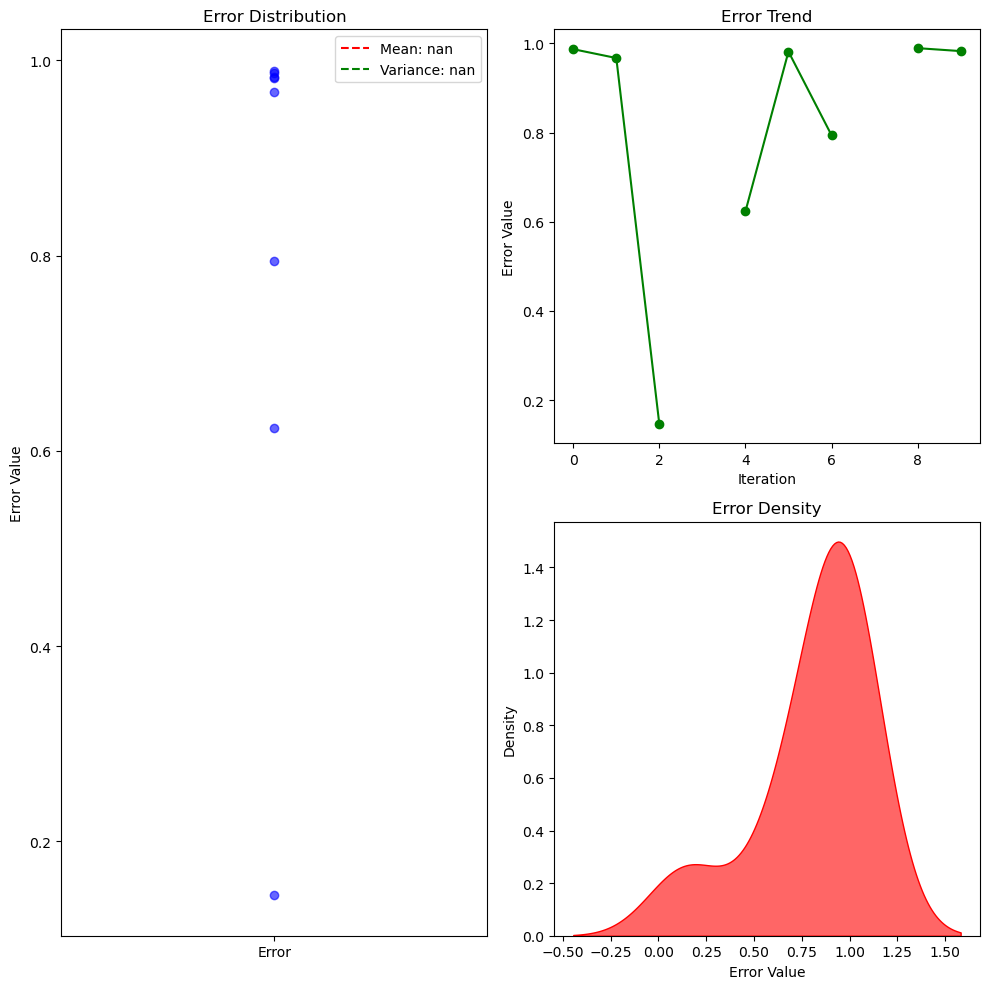

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3304076/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean MAE: nan
Variance MAE: nan


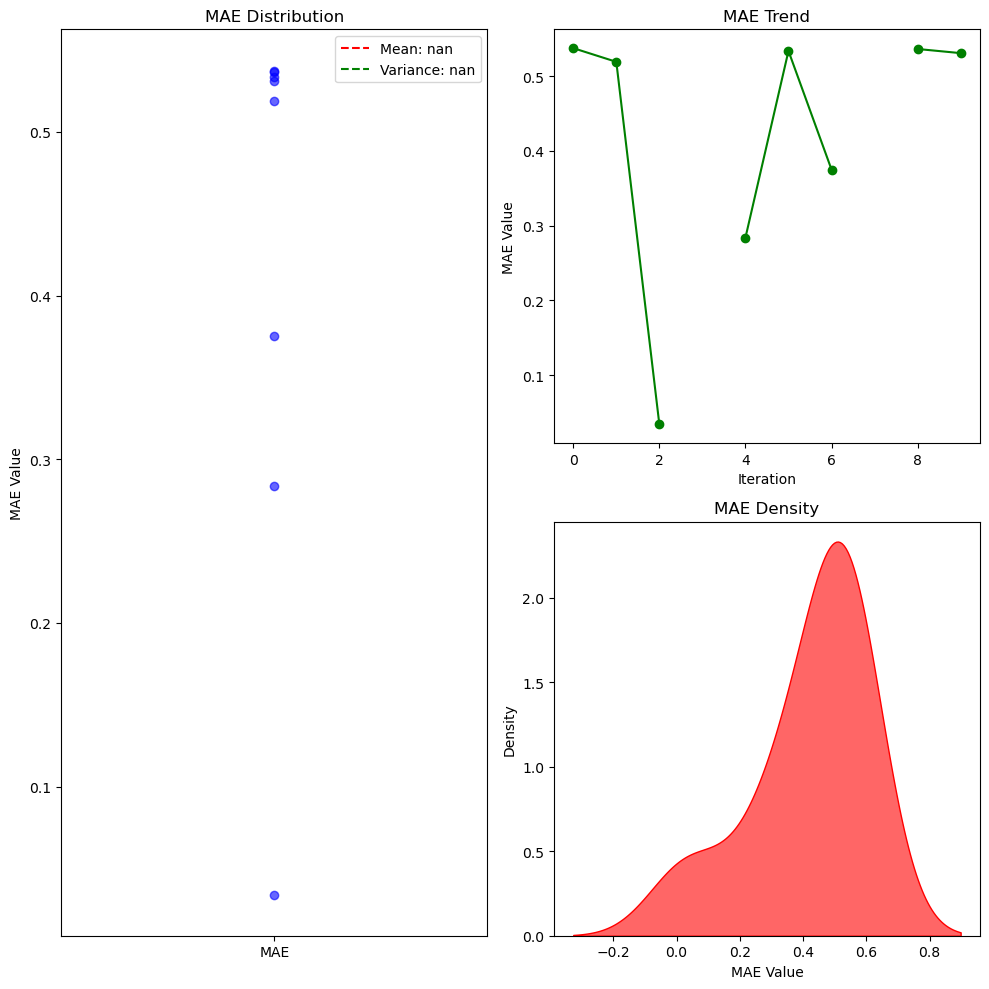

In [10]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: nan
Variance MSE: nan


/tmp/ipykernel_3304076/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


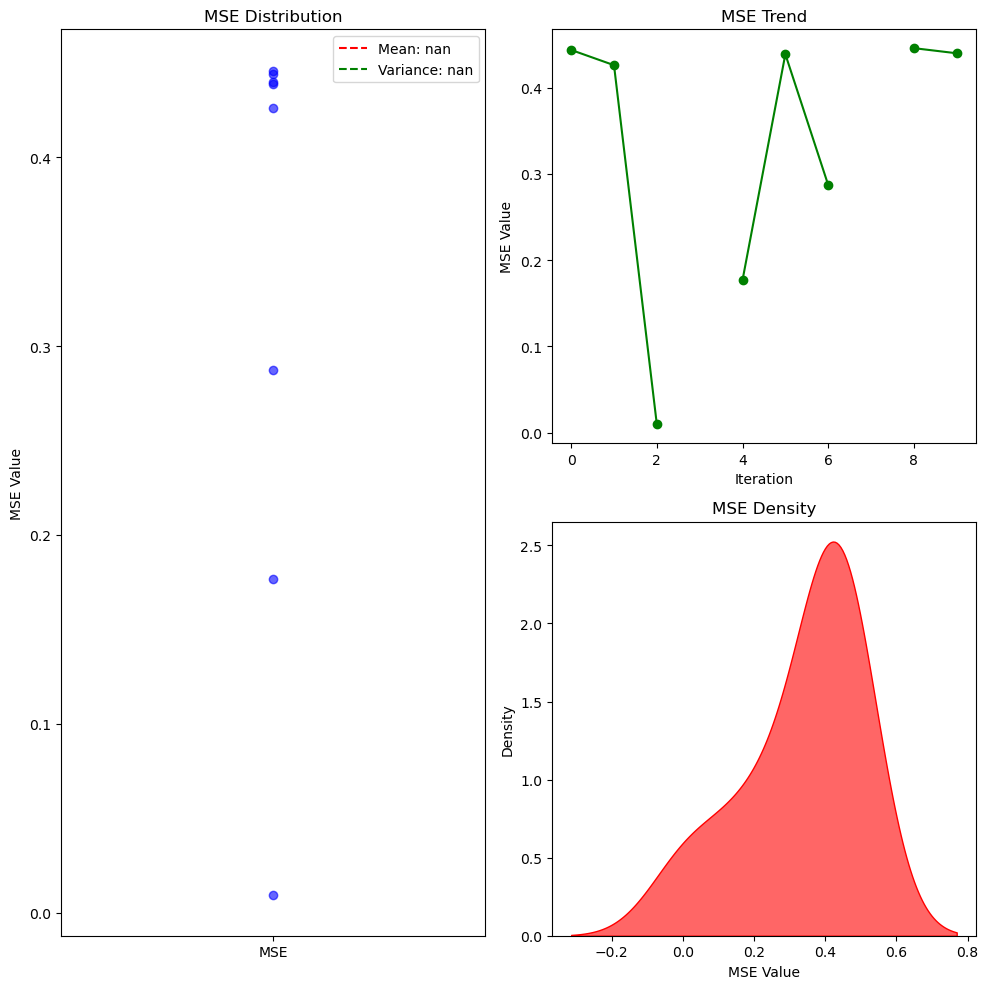

In [11]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [12]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


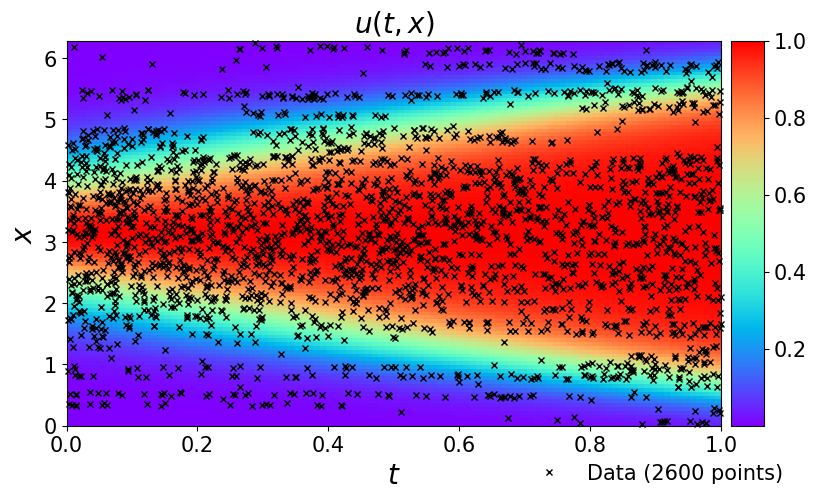

In [13]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [14]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


17183


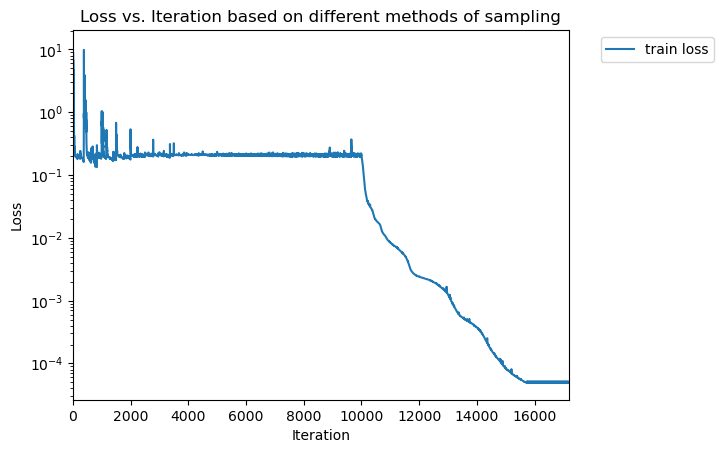

In [15]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


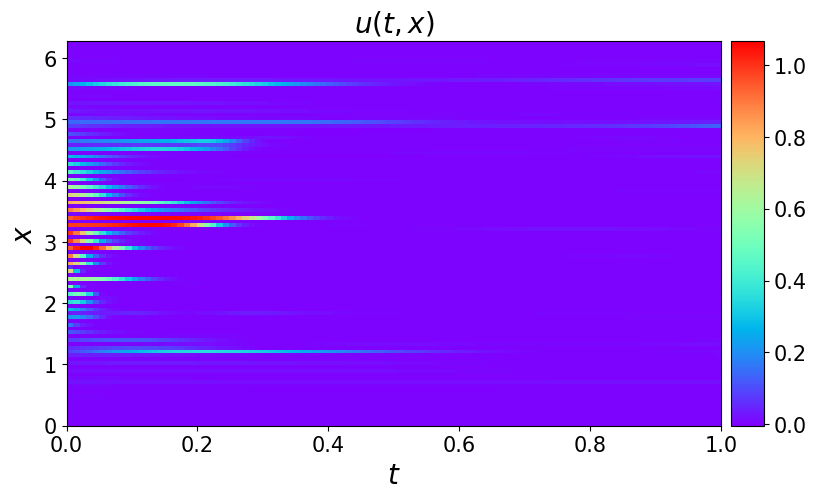

In [16]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

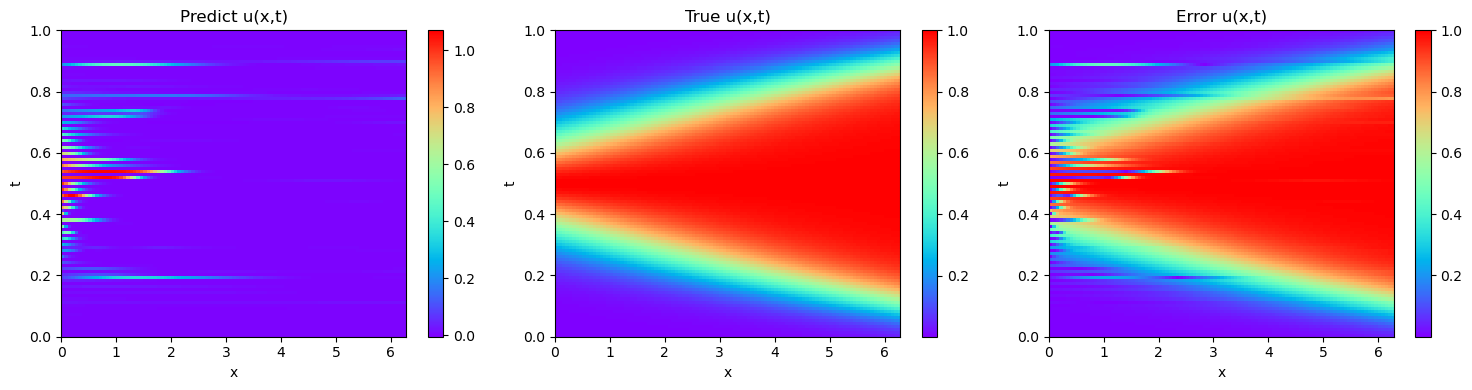

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [18]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

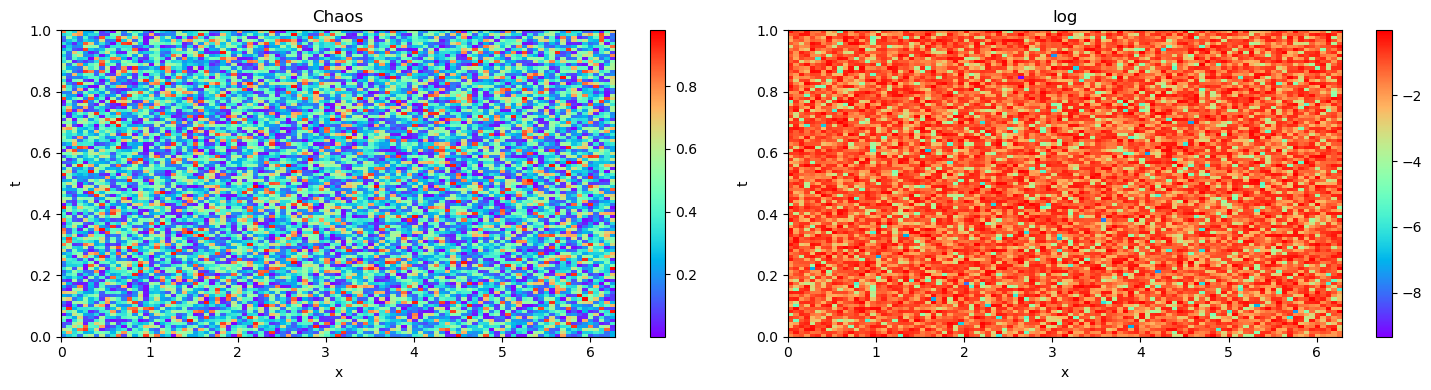

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()